# Preprocessing the Data

In [13]:
from tqdm import tqdm_notebook as tqdm
import preprocessor as p
import numpy as np
import pandas
from math import log
import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh
import sys
import re
from collections import defaultdict, Counter

In [14]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
import torch.nn.functional as F

In [15]:
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [16]:
import matplotlib.pyplot as plt
import random

In [17]:
def preprocess(text):
    p.set_options(p.OPT.URL,p.OPT.MENTION,p.OPT.EMOJI,p.OPT.HASHTAG)
    return p.tokenize(text).split()

In [18]:
def preprocess(text):
    p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.EMOJI ,p.OPT.HASHTAG)
    return p.tokenize(text).split()

In [19]:
def indexer(split_text):
    sent2idx = []
    for w in split_text:
        if w.lower() in word2idx:
            sent2idx.append(word2idx[w.lower()])
        else:
            sent2idx.append(word2idx['_UNK'])
            
    return sent2idx

In [20]:
train = pandas.read_csv('./sentiment_analysis_train_data_classified.csv')
valid = pandas.read_csv('./sentiment_analysis_test_data_classified.csv')

In [21]:
train['clean_text'] = train.tweet.apply(lambda x: preprocess(x.lower().strip()))

words = Counter()
for sent in tqdm(train.clean_text.values):
    words.update(w.lower() for w in sent)
   
# sort with most frequently occuring words first
words = sorted(words, key=words.get, reverse=True)
# add <pad> and <unk> token to vocab which will be used later
words = ['_PAD','_UNK'] + words

word2idx = {o:i for i,o in enumerate(words)}
idx2word = {i:o for i,o in enumerate(words)}

train['sentence2idx'] = train.clean_text.apply(lambda x: indexer(x))
train['length'] = train.clean_text.apply(lambda x: len(x))
train['label'] = train['category'].apply(lambda x: int(x/4))

100%|██████████| 1600000/1600000 [00:10<00:00, 149267.42it/s]


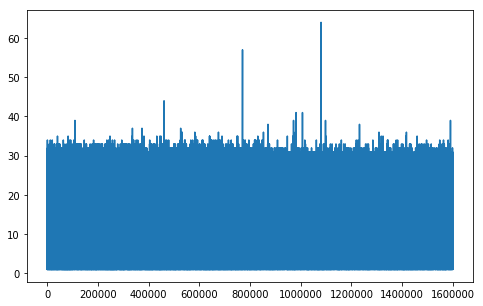

In [22]:
fig = plt.figure(figsize=(8,5))
ax = plt.plot(train.length.values)
plt.show()

In [23]:
valid['clean_text'] = valid.tweet.apply(lambda x: preprocess(x.strip()))

valid['sentence2idx'] = valid.clean_text.apply(lambda x: indexer(x))
valid['length'] = valid.clean_text.apply(lambda x: len(x))
valid['label'] = valid['category'].apply(lambda x: int(x/4))

In [24]:
class VectorizeData(Dataset):
    def __init__(self, df, maxlen=30):
        self.maxlen = maxlen
        self.df = df
#         print('Padding')
        self.df['padded_text'] = self.df.sentence2idx.apply(lambda x: self.pad_data(x))
        self.padded_text = list(self.df.padded_text)
        self.labels = list(self.df.label)
        self.lengths = list(self.df.length)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
#         lens = self.df.length[idx]
        X = self.padded_text[idx]
        y = self.labels[idx]
        lens = self.lengths[idx]
        return X,y,lens
    
    def pad_data(self, s):
        padded = np.zeros((self.maxlen,), dtype=np.int64)
        if len(s) > self.maxlen: padded[:] = s[:self.maxlen]
        else: padded[:len(s)] = s
        return padded

In [25]:
train_loader = VectorizeData(train)
valid_loader = VectorizeData(valid)

In [26]:
tl = DataLoader(dataset=train_loader, batch_size=100, shuffle=True)
print(len(tl))

16000


In [27]:
vl = DataLoader(dataset=valid_loader, batch_size=100, shuffle=False)
print(len(vl))

5


In [28]:
for i, samples in enumerate(tl):
    print(i)
    print(samples)
    break

0
[tensor([[  6615, 133175,      3,  ...,      0,      0,      0],
        [    16,    414,     28,  ...,      0,      0,      0],
        [   140,    173,      7,  ...,      0,      0,      0],
        ...,
        [     2, 504000,     22,  ...,      0,      0,      0],
        [     2,    112,    148,  ...,      0,      0,      0],
        [   277,   2046,      7,  ...,      0,      0,      0]]), tensor([0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0]), tensor([15, 12,  5,  3, 22, 21, 19, 11,  6, 18, 12, 20, 15, 10, 23,  8,  7, 29,
        13,  8,  6, 17, 12, 13,  7, 14,  6,  2,  6,  9, 12, 10, 14,  8, 10, 12,
        10, 19, 14, 24,  8, 10, 24, 20, 16, 12, 17,  4,  5, 21, 28, 29, 21, 16,
        13, 11, 

In [29]:
for i, samples in enumerate(vl):
    print(i)
    print(samples)
    break

0
[tensor([[    2,     3,     1,  ...,     0,     0,     0],
        [  498,     7,     1,  ...,     0,     0,     0],
        [  721,   164, 37735,  ...,     0,     0,     0],
        ...,
        [    3,   137, 10635,  ...,     0,     0,     0],
        [ 4479,  3316,   494,  ...,     0,     0,     0],
        [   41,     6,  1413,  ...,     0,     0,     0]]), tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0]), tensor([20, 10,  9, 27, 14, 12, 12,  6,  2, 11, 14, 24, 16, 13, 17, 22, 30,  4,
        14,  5, 18,  8, 12, 18, 24,  9, 10, 14, 10, 28, 16, 25, 20, 23, 24, 12,
         4, 10, 16, 25, 20,  9,  6, 16, 16,  8,  5,  5, 11, 24,  4, 13, 10,  9,
        19,  8,  6, 10,  8, 12, 26,  7,  4,  7, 12, 

## RecModel

In [30]:
class RecArch(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidir, rnnType,device):
        super(RecArch, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.device = device
        self.rnnType = rnnType
        self.bidirectional = bidir
        
        if self.bidirectional:
            self.numDirs = 2
        else:
            self.numDirs = 1
        
        self.emb = nn.Embedding(self.vocab_size, embedding_dim)
        
        if self.rnnType == 'lstm':
            self.recNN = nn.LSTM(embedding_dim,hidden_dim, num_layers,batch_first=True,bidirectional=self.bidirectional)
            
        if self.rnnType == 'gru':
            self.recNN = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True,bidirectional=self.bidirectional)
            
        if self.rnnType == 'rnn':
            self.recNN = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True, nonlinearity='tanh',bidirectional=self.bidirectional)
        
        self.fc = nn.Linear(self.numDirs*hidden_dim,output_dim)
    
    def encode(self,x):
        embs = self.emb(x)
        embs = embs.view(x.size(0),-1,self.embedding_dim).to(self.device)
        
        h0 = Variable(torch.zeros(self.numDirs*self.num_layers,x.size(0),self.hidden_dim),requires_grad=True).to(self.device)
        
        if self.rnnType == 'lstm':        
            c0 = Variable(torch.zeros(self.numDirs*self.num_layers,x.size(0),self.hidden_dim),requires_grad=True).to(self.device)
            
            out,(hn,cn) = self.recNN(embs,(h0,c0))
        
        else:
            out, hn = self.recNN(embs, h0)
        
#         print(out[:,-1,:].shape)
        return out[:, -1, :]
    
    def forward(self,x):
        embs = self.emb(x)
        embs = embs.view(x.size(0),-1,self.embedding_dim).to(self.device)
        
        h0 = Variable(torch.zeros(self.numDirs*self.num_layers,x.size(0),self.hidden_dim),requires_grad=True).to(self.device)
        
        if self.rnnType == 'lstm':        
            c0 = Variable(torch.zeros(self.numDirs*self.num_layers,x.size(0),self.hidden_dim),requires_grad=True).to(self.device)
            
            out,(hn,cn) = self.recNN(embs,(h0,c0))
        
        else:
            out, hn = self.recNN(embs, h0)
        
#         print(out[:,-1,:].shape)
        out = self.fc(out[:, -1, :])
        return out

### Optimal combination seems to be with GRU of 50 units and 1 layer

In [31]:
vocab_size = len(words)
embedding_dim = 256
n_hidden = 50
n_out = 2
num_layers = 1
rnnType = 'lstm'
bidir = False

if torch.cuda.is_available():
    device = 'cuda:1'
else:
    device = 'cpu'

In [32]:
model = RecArch(vocab_size,embedding_dim,n_hidden,n_out,num_layers,bidir,rnnType,device)
model = model.to(device)
model.float()

RecArch(
  (emb): Embedding(761018, 256)
  (recNN): LSTM(256, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=2, bias=True)
)

# Pretraining Text Encoder

In [34]:
optimizer = torch.optim.Adagrad(model.parameters(),lr=0.01)
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = torch.nn.CrossEntropyLoss()

seq_dim = 30
num_epochs = 10

train_losses_iterwise = []
recall_iterwise = []
precision_iterwise = []
accuracy_iterwise = []
f1score_iterwise = []
val_losses_iterwise = []

for epoch in tqdm(range(num_epochs)):
    train_losses = []
    val_losses = []
    for i, (text,label,lengths) in tqdm(enumerate(tl),total=len(tl)):

        text = Variable(text.view(-1, seq_dim, 1)).to(device)
        label = Variable(label).to(device)
        
#         print(sexism_label)
        
        optimizer.zero_grad()
        outputs = model(text)
        
#         print(outputs)
        
        loss = criterion(outputs, label)
        train_losses.append(loss.data.cpu())
        
        loss.backward()
        optimizer.step()
    
    if epoch % 5 == 0:
        correct = 0
        total = 0

        allLabels = []
        allPreds = []
        probPreds = []

        for i, (text,label,lengths) in enumerate(vl):
            labels=[]
            text = Variable(text.view(-1, seq_dim, 1)).to(device)
            label = Variable(label).to(device)

            predicted = model(text)
            predicted =  torch.softmax(predicted,1)
            probPreds.append(predicted)
            predicted = torch.max(predicted, 1)[1].cpu().numpy().tolist()
    #                 print(predicted)
    #                 print(sexism_label)
            allLabels += (label.cpu().numpy().tolist())
            allPreds += (predicted)

        valacc = accuracy_score(allLabels, allPreds)
        recscore = recall_score(allLabels, allPreds,average='macro')
        precscore = precision_score(allLabels, allPreds,average='macro')
        f1score = f1_score(allLabels, allPreds,average='macro')
        roc = roc_auc_score(allLabels,allPreds)
        cr = classification_report(allLabels, allPreds)
        print(f'acc: {valacc} AUC {roc}')
        print(cr)

        train_losses_iterwise.append(np.mean(train_losses))


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 1/16000 [00:00<34:06,  7.82it/s]

  0%|          | 3/16000 [00:00<27:57,  9.54it/s]

  0%|          | 5/16000 [00:00<23:34, 11.30it/s]

  0%|          | 7/16000 [00:00<20:31, 12.98it/s]

  0%|          | 9/16000 [00:00<18:23, 14.49it/s]

  0%|          | 11/16000 [00:00<16:55, 15.74it/s]

  0%|          | 13/16000 [00:00<15:56, 16.71it/s]

  0%|          | 15/16000 [00:00<15:15, 17.46it/s]

  0%|          | 17/16000 [00:00<14:45, 18.05it/s]

  0%|          | 19/16000 [00:01<14:22, 18.53it/s]

  0%|          | 21/16000 [00:01<14:06, 18.89it/s]

  0%|          | 23/16000 [00:01<13:56, 19.11it/s]

  0%|          | 25/16000 [00:01<13:48, 19.28it/s]

  0%|          | 27/16000 [00:01<13:44, 19.36it/s]

  0%|          | 29/16000 [00:01<13:39, 19.49it/s]

  0%|          | 31/16000 [00:01<13:36, 19.57it/s]

  0%|          | 33/16000 [00:01<13:34, 19.60it/s]

  0%|          | 35/16000 [00:01<13:3

  2%|▏         | 277/16000 [00:14<13:13, 19.80it/s]

  2%|▏         | 279/16000 [00:14<13:16, 19.74it/s]

  2%|▏         | 281/16000 [00:14<13:17, 19.71it/s]

  2%|▏         | 283/16000 [00:14<13:16, 19.72it/s]

  2%|▏         | 285/16000 [00:14<13:16, 19.72it/s]

  2%|▏         | 287/16000 [00:14<13:15, 19.75it/s]

  2%|▏         | 289/16000 [00:14<13:16, 19.71it/s]

  2%|▏         | 291/16000 [00:14<13:19, 19.66it/s]

  2%|▏         | 293/16000 [00:14<13:18, 19.67it/s]

  2%|▏         | 295/16000 [00:15<13:17, 19.70it/s]

  2%|▏         | 297/16000 [00:15<13:16, 19.71it/s]

  2%|▏         | 299/16000 [00:15<13:17, 19.69it/s]

  2%|▏         | 301/16000 [00:15<13:16, 19.72it/s]

  2%|▏         | 303/16000 [00:15<13:13, 19.78it/s]

  2%|▏         | 305/16000 [00:15<13:12, 19.80it/s]

  2%|▏         | 307/16000 [00:15<13:11, 19.81it/s]

  2%|▏         | 309/16000 [00:15<13:14, 19.76it/s]

  2%|▏         | 311/16000 [00:15<13:14, 19.74it/s]

  2%|▏         | 313/16000 [00:15<13:17, 19.68

  3%|▎         | 553/16000 [00:28<13:05, 19.65it/s]

  3%|▎         | 555/16000 [00:28<13:06, 19.64it/s]

  3%|▎         | 557/16000 [00:28<13:04, 19.69it/s]

  3%|▎         | 559/16000 [00:28<13:03, 19.71it/s]

  4%|▎         | 561/16000 [00:28<13:04, 19.68it/s]

  4%|▎         | 563/16000 [00:28<13:05, 19.66it/s]

  4%|▎         | 565/16000 [00:28<13:06, 19.63it/s]

  4%|▎         | 567/16000 [00:28<13:06, 19.63it/s]

  4%|▎         | 569/16000 [00:28<13:05, 19.64it/s]

  4%|▎         | 571/16000 [00:29<13:04, 19.67it/s]

  4%|▎         | 573/16000 [00:29<13:02, 19.72it/s]

  4%|▎         | 575/16000 [00:29<13:03, 19.68it/s]

  4%|▎         | 577/16000 [00:29<13:04, 19.66it/s]

  4%|▎         | 579/16000 [00:29<13:03, 19.69it/s]

  4%|▎         | 581/16000 [00:29<13:04, 19.66it/s]

  4%|▎         | 583/16000 [00:29<13:06, 19.60it/s]

  4%|▎         | 585/16000 [00:29<13:04, 19.66it/s]

  4%|▎         | 587/16000 [00:29<13:03, 19.68it/s]

  4%|▎         | 589/16000 [00:29<13:01, 19.73

  5%|▌         | 829/16000 [00:42<12:50, 19.69it/s]

  5%|▌         | 831/16000 [00:42<12:51, 19.66it/s]

  5%|▌         | 833/16000 [00:42<12:51, 19.66it/s]

  5%|▌         | 835/16000 [00:42<12:51, 19.66it/s]

  5%|▌         | 837/16000 [00:42<12:52, 19.63it/s]

  5%|▌         | 839/16000 [00:42<12:53, 19.60it/s]

  5%|▌         | 841/16000 [00:42<12:52, 19.62it/s]

  5%|▌         | 843/16000 [00:42<12:50, 19.68it/s]

  5%|▌         | 845/16000 [00:42<12:47, 19.76it/s]

  5%|▌         | 847/16000 [00:43<12:48, 19.72it/s]

  5%|▌         | 849/16000 [00:43<12:49, 19.69it/s]

  5%|▌         | 851/16000 [00:43<12:48, 19.70it/s]

  5%|▌         | 853/16000 [00:43<12:47, 19.73it/s]

  5%|▌         | 855/16000 [00:43<12:48, 19.72it/s]

  5%|▌         | 857/16000 [00:43<12:48, 19.70it/s]

  5%|▌         | 859/16000 [00:43<12:49, 19.67it/s]

  5%|▌         | 861/16000 [00:43<12:50, 19.64it/s]

  5%|▌         | 863/16000 [00:43<12:50, 19.65it/s]

  5%|▌         | 865/16000 [00:43<12:49, 19.67

  7%|▋         | 1105/16000 [00:56<12:35, 19.72it/s]

  7%|▋         | 1107/16000 [00:56<12:34, 19.75it/s]

  7%|▋         | 1109/16000 [00:56<12:36, 19.68it/s]

  7%|▋         | 1111/16000 [00:56<12:36, 19.69it/s]

  7%|▋         | 1113/16000 [00:56<12:34, 19.74it/s]

  7%|▋         | 1115/16000 [00:56<12:32, 19.77it/s]

  7%|▋         | 1117/16000 [00:56<12:33, 19.75it/s]

  7%|▋         | 1119/16000 [00:56<12:31, 19.80it/s]

  7%|▋         | 1121/16000 [00:57<12:32, 19.77it/s]

  7%|▋         | 1123/16000 [00:57<12:34, 19.70it/s]

  7%|▋         | 1125/16000 [00:57<12:36, 19.67it/s]

  7%|▋         | 1127/16000 [00:57<12:35, 19.69it/s]

  7%|▋         | 1129/16000 [00:57<12:35, 19.68it/s]

  7%|▋         | 1131/16000 [00:57<12:34, 19.71it/s]

  7%|▋         | 1133/16000 [00:57<12:34, 19.70it/s]

  7%|▋         | 1135/16000 [00:57<12:34, 19.70it/s]

  7%|▋         | 1137/16000 [00:57<12:36, 19.66it/s]

  7%|▋         | 1139/16000 [00:57<12:35, 19.66it/s]

  7%|▋         | 1141/16000 

  9%|▊         | 1377/16000 [01:10<12:22, 19.69it/s]

  9%|▊         | 1379/16000 [01:10<12:22, 19.68it/s]

  9%|▊         | 1381/16000 [01:10<12:23, 19.67it/s]

  9%|▊         | 1383/16000 [01:10<12:23, 19.67it/s]

  9%|▊         | 1385/16000 [01:10<12:20, 19.72it/s]

  9%|▊         | 1387/16000 [01:10<12:19, 19.76it/s]

  9%|▊         | 1389/16000 [01:10<12:21, 19.70it/s]

  9%|▊         | 1391/16000 [01:10<12:22, 19.67it/s]

  9%|▊         | 1393/16000 [01:10<12:20, 19.71it/s]

  9%|▊         | 1395/16000 [01:10<12:21, 19.71it/s]

  9%|▊         | 1397/16000 [01:11<12:21, 19.70it/s]

  9%|▊         | 1399/16000 [01:11<12:20, 19.72it/s]

  9%|▉         | 1401/16000 [01:11<12:20, 19.70it/s]

  9%|▉         | 1403/16000 [01:11<12:20, 19.72it/s]

  9%|▉         | 1405/16000 [01:11<12:20, 19.70it/s]

  9%|▉         | 1407/16000 [01:11<12:21, 19.67it/s]

  9%|▉         | 1409/16000 [01:11<12:22, 19.66it/s]

  9%|▉         | 1411/16000 [01:11<12:23, 19.63it/s]

  9%|▉         | 1413/16000 

 10%|█         | 1649/16000 [01:23<12:04, 19.80it/s]

 10%|█         | 1651/16000 [01:23<12:06, 19.76it/s]

 10%|█         | 1653/16000 [01:24<12:06, 19.76it/s]

 10%|█         | 1655/16000 [01:24<12:06, 19.74it/s]

 10%|█         | 1657/16000 [01:24<12:08, 19.69it/s]

 10%|█         | 1659/16000 [01:24<12:07, 19.71it/s]

 10%|█         | 1661/16000 [01:24<12:08, 19.68it/s]

 10%|█         | 1663/16000 [01:24<12:08, 19.67it/s]

 10%|█         | 1665/16000 [01:24<12:09, 19.66it/s]

 10%|█         | 1667/16000 [01:24<12:08, 19.67it/s]

 10%|█         | 1669/16000 [01:24<12:08, 19.67it/s]

 10%|█         | 1671/16000 [01:24<12:09, 19.65it/s]

 10%|█         | 1673/16000 [01:25<12:07, 19.68it/s]

 10%|█         | 1675/16000 [01:25<12:09, 19.65it/s]

 10%|█         | 1677/16000 [01:25<12:07, 19.69it/s]

 10%|█         | 1679/16000 [01:25<12:05, 19.74it/s]

 11%|█         | 1681/16000 [01:25<12:06, 19.71it/s]

 11%|█         | 1683/16000 [01:25<12:05, 19.75it/s]

 11%|█         | 1685/16000 

 12%|█▏        | 1921/16000 [01:37<11:52, 19.76it/s]

 12%|█▏        | 1923/16000 [01:37<11:54, 19.71it/s]

 12%|█▏        | 1925/16000 [01:37<11:54, 19.70it/s]

 12%|█▏        | 1927/16000 [01:37<11:52, 19.75it/s]

 12%|█▏        | 1929/16000 [01:38<11:50, 19.81it/s]

 12%|█▏        | 1931/16000 [01:38<11:50, 19.79it/s]

 12%|█▏        | 1933/16000 [01:38<11:52, 19.75it/s]

 12%|█▏        | 1935/16000 [01:38<11:53, 19.71it/s]

 12%|█▏        | 1937/16000 [01:38<11:52, 19.73it/s]

 12%|█▏        | 1939/16000 [01:38<11:54, 19.68it/s]

 12%|█▏        | 1941/16000 [01:38<11:52, 19.72it/s]

 12%|█▏        | 1943/16000 [01:38<11:50, 19.77it/s]

 12%|█▏        | 1945/16000 [01:38<11:51, 19.76it/s]

 12%|█▏        | 1947/16000 [01:38<11:49, 19.80it/s]

 12%|█▏        | 1949/16000 [01:39<11:50, 19.78it/s]

 12%|█▏        | 1951/16000 [01:39<11:52, 19.72it/s]

 12%|█▏        | 1953/16000 [01:39<11:52, 19.71it/s]

 12%|█▏        | 1955/16000 [01:39<11:52, 19.70it/s]

 12%|█▏        | 1957/16000 

 14%|█▎        | 2193/16000 [01:51<11:40, 19.70it/s]

 14%|█▎        | 2195/16000 [01:51<11:39, 19.73it/s]

 14%|█▎        | 2197/16000 [01:51<11:40, 19.71it/s]

 14%|█▎        | 2199/16000 [01:51<11:40, 19.71it/s]

 14%|█▍        | 2201/16000 [01:51<11:40, 19.71it/s]

 14%|█▍        | 2203/16000 [01:51<11:41, 19.67it/s]

 14%|█▍        | 2205/16000 [01:52<11:42, 19.64it/s]

 14%|█▍        | 2207/16000 [01:52<11:43, 19.61it/s]

 14%|█▍        | 2209/16000 [01:52<11:42, 19.63it/s]

 14%|█▍        | 2211/16000 [01:52<11:42, 19.62it/s]

 14%|█▍        | 2213/16000 [01:52<11:40, 19.68it/s]

 14%|█▍        | 2215/16000 [01:52<11:37, 19.76it/s]

 14%|█▍        | 2217/16000 [01:52<11:35, 19.82it/s]

 14%|█▍        | 2219/16000 [01:52<11:34, 19.85it/s]

 14%|█▍        | 2221/16000 [01:52<11:37, 19.75it/s]

 14%|█▍        | 2223/16000 [01:52<11:38, 19.73it/s]

 14%|█▍        | 2225/16000 [01:53<11:38, 19.72it/s]

 14%|█▍        | 2227/16000 [01:53<11:37, 19.75it/s]

 14%|█▍        | 2229/16000 

 15%|█▌        | 2465/16000 [02:05<11:29, 19.63it/s]

 15%|█▌        | 2467/16000 [02:05<11:29, 19.62it/s]

 15%|█▌        | 2469/16000 [02:05<11:29, 19.62it/s]

 15%|█▌        | 2471/16000 [02:05<11:28, 19.64it/s]

 15%|█▌        | 2473/16000 [02:05<11:26, 19.71it/s]

 15%|█▌        | 2475/16000 [02:05<11:28, 19.65it/s]

 15%|█▌        | 2477/16000 [02:05<11:27, 19.67it/s]

 15%|█▌        | 2479/16000 [02:05<11:26, 19.70it/s]

 16%|█▌        | 2481/16000 [02:06<11:24, 19.76it/s]

 16%|█▌        | 2483/16000 [02:06<11:21, 19.83it/s]

 16%|█▌        | 2485/16000 [02:06<11:20, 19.86it/s]

 16%|█▌        | 2487/16000 [02:06<11:19, 19.89it/s]

 16%|█▌        | 2489/16000 [02:06<11:18, 19.91it/s]

 16%|█▌        | 2491/16000 [02:06<11:17, 19.93it/s]

 16%|█▌        | 2493/16000 [02:06<11:17, 19.94it/s]

 16%|█▌        | 2495/16000 [02:06<11:18, 19.90it/s]

 16%|█▌        | 2497/16000 [02:06<11:20, 19.85it/s]

 16%|█▌        | 2499/16000 [02:06<11:21, 19.82it/s]

 16%|█▌        | 2501/16000 

 17%|█▋        | 2737/16000 [02:18<11:05, 19.94it/s]

 17%|█▋        | 2739/16000 [02:19<11:04, 19.94it/s]

 17%|█▋        | 2741/16000 [02:19<11:04, 19.95it/s]

 17%|█▋        | 2743/16000 [02:19<11:04, 19.95it/s]

 17%|█▋        | 2745/16000 [02:19<11:04, 19.96it/s]

 17%|█▋        | 2747/16000 [02:19<11:04, 19.96it/s]

 17%|█▋        | 2749/16000 [02:19<11:04, 19.96it/s]

 17%|█▋        | 2751/16000 [02:19<11:04, 19.95it/s]

 17%|█▋        | 2753/16000 [02:19<11:03, 19.97it/s]

 17%|█▋        | 2755/16000 [02:19<11:03, 19.97it/s]

 17%|█▋        | 2758/16000 [02:19<11:02, 19.99it/s]

 17%|█▋        | 2761/16000 [02:20<11:01, 20.00it/s]

 17%|█▋        | 2764/16000 [02:20<11:01, 20.01it/s]

 17%|█▋        | 2767/16000 [02:20<11:01, 20.01it/s]

 17%|█▋        | 2770/16000 [02:20<11:00, 20.02it/s]

 17%|█▋        | 2773/16000 [02:20<11:01, 19.98it/s]

 17%|█▋        | 2775/16000 [02:20<11:02, 19.97it/s]

 17%|█▋        | 2778/16000 [02:20<11:01, 19.99it/s]

 17%|█▋        | 2781/16000 

 19%|█▉        | 3044/16000 [02:34<10:48, 19.99it/s]

 19%|█▉        | 3046/16000 [02:34<10:49, 19.94it/s]

 19%|█▉        | 3048/16000 [02:34<10:49, 19.93it/s]

 19%|█▉        | 3051/16000 [02:34<10:48, 19.96it/s]

 19%|█▉        | 3054/16000 [02:34<10:48, 19.98it/s]

 19%|█▉        | 3057/16000 [02:34<10:47, 19.99it/s]

 19%|█▉        | 3060/16000 [02:35<10:47, 20.00it/s]

 19%|█▉        | 3063/16000 [02:35<10:46, 20.00it/s]

 19%|█▉        | 3066/16000 [02:35<10:46, 19.99it/s]

 19%|█▉        | 3069/16000 [02:35<10:46, 20.00it/s]

 19%|█▉        | 3072/16000 [02:35<10:46, 20.01it/s]

 19%|█▉        | 3075/16000 [02:35<10:45, 20.01it/s]

 19%|█▉        | 3078/16000 [02:36<10:47, 19.95it/s]

 19%|█▉        | 3081/16000 [02:36<10:46, 19.97it/s]

 19%|█▉        | 3084/16000 [02:36<10:46, 19.99it/s]

 19%|█▉        | 3086/16000 [02:36<10:47, 19.95it/s]

 19%|█▉        | 3089/16000 [02:36<10:46, 19.97it/s]

 19%|█▉        | 3092/16000 [02:36<10:45, 19.99it/s]

 19%|█▉        | 3095/16000 

 21%|██        | 3359/16000 [02:50<10:32, 20.00it/s]

 21%|██        | 3362/16000 [02:50<10:31, 20.01it/s]

 21%|██        | 3365/16000 [02:50<10:31, 20.02it/s]

 21%|██        | 3368/16000 [02:50<10:30, 20.02it/s]

 21%|██        | 3371/16000 [02:50<10:30, 20.02it/s]

 21%|██        | 3374/16000 [02:50<10:31, 20.00it/s]

 21%|██        | 3377/16000 [02:50<10:31, 20.00it/s]

 21%|██        | 3380/16000 [02:51<10:30, 20.01it/s]

 21%|██        | 3383/16000 [02:51<10:30, 20.01it/s]

 21%|██        | 3386/16000 [02:51<10:30, 20.02it/s]

 21%|██        | 3389/16000 [02:51<10:29, 20.02it/s]

 21%|██        | 3392/16000 [02:51<10:29, 20.02it/s]

 21%|██        | 3395/16000 [02:51<10:29, 20.02it/s]

 21%|██        | 3398/16000 [02:52<10:29, 20.02it/s]

 21%|██▏       | 3401/16000 [02:52<10:29, 20.02it/s]

 21%|██▏       | 3404/16000 [02:52<10:29, 20.01it/s]

 21%|██▏       | 3407/16000 [02:52<10:29, 20.02it/s]

 21%|██▏       | 3410/16000 [02:52<10:29, 20.01it/s]

 21%|██▏       | 3413/16000 

 23%|██▎       | 3654/16000 [03:04<10:18, 19.96it/s]

 23%|██▎       | 3657/16000 [03:05<10:17, 19.98it/s]

 23%|██▎       | 3659/16000 [03:05<10:18, 19.95it/s]

 23%|██▎       | 3661/16000 [03:05<10:18, 19.95it/s]

 23%|██▎       | 3664/16000 [03:05<10:17, 19.97it/s]

 23%|██▎       | 3667/16000 [03:05<10:17, 19.99it/s]

 23%|██▎       | 3670/16000 [03:05<10:16, 19.99it/s]

 23%|██▎       | 3673/16000 [03:05<10:16, 20.00it/s]

 23%|██▎       | 3676/16000 [03:05<10:16, 20.00it/s]

 23%|██▎       | 3679/16000 [03:06<10:15, 20.01it/s]

 23%|██▎       | 3682/16000 [03:06<10:15, 20.01it/s]

 23%|██▎       | 3685/16000 [03:06<10:15, 20.01it/s]

 23%|██▎       | 3688/16000 [03:06<10:15, 20.01it/s]

 23%|██▎       | 3691/16000 [03:06<10:14, 20.02it/s]

 23%|██▎       | 3694/16000 [03:06<10:14, 20.02it/s]

 23%|██▎       | 3697/16000 [03:07<10:14, 20.02it/s]

 23%|██▎       | 3700/16000 [03:07<10:14, 20.02it/s]

 23%|██▎       | 3703/16000 [03:07<10:14, 20.02it/s]

 23%|██▎       | 3706/16000 

 25%|██▍       | 3970/16000 [03:20<10:09, 19.73it/s]

 25%|██▍       | 3972/16000 [03:20<10:11, 19.68it/s]

 25%|██▍       | 3974/16000 [03:20<10:11, 19.67it/s]

 25%|██▍       | 3976/16000 [03:21<10:10, 19.70it/s]

 25%|██▍       | 3978/16000 [03:21<10:10, 19.68it/s]

 25%|██▍       | 3980/16000 [03:21<10:11, 19.67it/s]

 25%|██▍       | 3982/16000 [03:21<10:10, 19.67it/s]

 25%|██▍       | 3984/16000 [03:21<10:09, 19.71it/s]

 25%|██▍       | 3986/16000 [03:21<10:09, 19.70it/s]

 25%|██▍       | 3988/16000 [03:21<10:10, 19.67it/s]

 25%|██▍       | 3990/16000 [03:21<10:11, 19.64it/s]

 25%|██▍       | 3992/16000 [03:21<10:11, 19.64it/s]

 25%|██▍       | 3994/16000 [03:21<10:12, 19.61it/s]

 25%|██▍       | 3996/16000 [03:22<10:12, 19.61it/s]

 25%|██▍       | 3998/16000 [03:22<10:12, 19.61it/s]

 25%|██▌       | 4000/16000 [03:22<10:11, 19.62it/s]

 25%|██▌       | 4002/16000 [03:22<10:11, 19.63it/s]

 25%|██▌       | 4004/16000 [03:22<10:09, 19.68it/s]

 25%|██▌       | 4006/16000 

 27%|██▋       | 4242/16000 [03:34<09:56, 19.72it/s]

 27%|██▋       | 4244/16000 [03:34<09:57, 19.68it/s]

 27%|██▋       | 4246/16000 [03:34<09:57, 19.67it/s]

 27%|██▋       | 4248/16000 [03:34<09:57, 19.66it/s]

 27%|██▋       | 4250/16000 [03:34<09:57, 19.65it/s]

 27%|██▋       | 4252/16000 [03:35<09:58, 19.64it/s]

 27%|██▋       | 4254/16000 [03:35<09:57, 19.65it/s]

 27%|██▋       | 4256/16000 [03:35<09:57, 19.64it/s]

 27%|██▋       | 4258/16000 [03:35<09:57, 19.65it/s]

 27%|██▋       | 4260/16000 [03:35<09:55, 19.70it/s]

 27%|██▋       | 4262/16000 [03:35<09:56, 19.67it/s]

 27%|██▋       | 4264/16000 [03:35<09:56, 19.67it/s]

 27%|██▋       | 4266/16000 [03:35<09:56, 19.67it/s]

 27%|██▋       | 4268/16000 [03:35<09:54, 19.72it/s]

 27%|██▋       | 4270/16000 [03:35<09:54, 19.74it/s]

 27%|██▋       | 4272/16000 [03:36<09:53, 19.77it/s]

 27%|██▋       | 4274/16000 [03:36<09:52, 19.81it/s]

 27%|██▋       | 4276/16000 [03:36<09:50, 19.84it/s]

 27%|██▋       | 4278/16000 

 29%|██▉       | 4630/16000 [03:53<09:27, 20.02it/s]

 29%|██▉       | 4633/16000 [03:54<09:27, 20.02it/s]

 29%|██▉       | 4636/16000 [03:54<09:27, 20.02it/s]

 29%|██▉       | 4639/16000 [03:54<09:27, 20.02it/s]

 29%|██▉       | 4642/16000 [03:54<09:27, 20.02it/s]

 29%|██▉       | 4645/16000 [03:54<09:27, 20.02it/s]

 29%|██▉       | 4648/16000 [03:54<09:27, 20.02it/s]

 29%|██▉       | 4651/16000 [03:54<09:26, 20.02it/s]

 29%|██▉       | 4654/16000 [03:55<09:26, 20.02it/s]

 29%|██▉       | 4657/16000 [03:55<09:26, 20.02it/s]

 29%|██▉       | 4660/16000 [03:55<09:26, 20.02it/s]

 29%|██▉       | 4663/16000 [03:55<09:26, 20.02it/s]

 29%|██▉       | 4666/16000 [03:55<09:26, 20.02it/s]

 29%|██▉       | 4669/16000 [03:55<09:26, 20.02it/s]

 29%|██▉       | 4672/16000 [03:56<09:25, 20.02it/s]

 29%|██▉       | 4675/16000 [03:56<09:25, 20.02it/s]

 29%|██▉       | 4678/16000 [03:56<09:25, 20.02it/s]

 29%|██▉       | 4681/16000 [03:56<09:25, 20.02it/s]

 29%|██▉       | 4684/16000 

 31%|███       | 4939/16000 [04:09<09:23, 19.64it/s]

 31%|███       | 4941/16000 [04:09<09:22, 19.65it/s]

 31%|███       | 4943/16000 [04:09<09:22, 19.66it/s]

 31%|███       | 4945/16000 [04:09<09:22, 19.66it/s]

 31%|███       | 4947/16000 [04:09<09:22, 19.67it/s]

 31%|███       | 4949/16000 [04:10<09:22, 19.65it/s]

 31%|███       | 4951/16000 [04:10<09:22, 19.66it/s]

 31%|███       | 4953/16000 [04:10<09:20, 19.70it/s]

 31%|███       | 4955/16000 [04:10<09:20, 19.71it/s]

 31%|███       | 4957/16000 [04:10<09:19, 19.74it/s]

 31%|███       | 4959/16000 [04:10<09:18, 19.77it/s]

 31%|███       | 4961/16000 [04:10<09:18, 19.78it/s]

 31%|███       | 4963/16000 [04:10<09:16, 19.83it/s]

 31%|███       | 4965/16000 [04:10<09:15, 19.86it/s]

 31%|███       | 4967/16000 [04:10<09:15, 19.88it/s]

 31%|███       | 4969/16000 [04:11<09:14, 19.91it/s]

 31%|███       | 4971/16000 [04:11<09:13, 19.91it/s]

 31%|███       | 4973/16000 [04:11<09:13, 19.92it/s]

 31%|███       | 4975/16000 

 33%|███▎      | 5211/16000 [04:23<09:08, 19.67it/s]

 33%|███▎      | 5213/16000 [04:23<09:08, 19.68it/s]

 33%|███▎      | 5215/16000 [04:23<09:07, 19.68it/s]

 33%|███▎      | 5217/16000 [04:23<09:08, 19.67it/s]

 33%|███▎      | 5219/16000 [04:23<09:06, 19.72it/s]

 33%|███▎      | 5221/16000 [04:23<09:04, 19.78it/s]

 33%|███▎      | 5223/16000 [04:23<09:05, 19.74it/s]

 33%|███▎      | 5225/16000 [04:24<09:09, 19.62it/s]

 33%|███▎      | 5227/16000 [04:24<09:07, 19.69it/s]

 33%|███▎      | 5229/16000 [04:24<09:05, 19.75it/s]

 33%|███▎      | 5231/16000 [04:24<09:03, 19.80it/s]

 33%|███▎      | 5233/16000 [04:24<09:02, 19.83it/s]

 33%|███▎      | 5235/16000 [04:24<09:02, 19.85it/s]

 33%|███▎      | 5238/16000 [04:24<09:00, 19.90it/s]

 33%|███▎      | 5241/16000 [04:24<08:59, 19.94it/s]

 33%|███▎      | 5244/16000 [04:25<08:58, 19.96it/s]

 33%|███▎      | 5247/16000 [04:25<08:58, 19.98it/s]

 33%|███▎      | 5250/16000 [04:25<08:57, 19.99it/s]

 33%|███▎      | 5253/16000 

 34%|███▍      | 5520/16000 [04:38<08:51, 19.71it/s]

 35%|███▍      | 5522/16000 [04:39<08:51, 19.72it/s]

 35%|███▍      | 5524/16000 [04:39<08:50, 19.74it/s]

 35%|███▍      | 5526/16000 [04:39<08:51, 19.71it/s]

 35%|███▍      | 5528/16000 [04:39<08:51, 19.71it/s]

 35%|███▍      | 5530/16000 [04:39<08:52, 19.67it/s]

 35%|███▍      | 5532/16000 [04:39<08:52, 19.66it/s]

 35%|███▍      | 5534/16000 [04:39<08:52, 19.66it/s]

 35%|███▍      | 5536/16000 [04:39<08:52, 19.63it/s]

 35%|███▍      | 5538/16000 [04:39<08:51, 19.67it/s]

 35%|███▍      | 5540/16000 [04:39<08:50, 19.73it/s]

 35%|███▍      | 5542/16000 [04:40<08:51, 19.69it/s]

 35%|███▍      | 5544/16000 [04:40<08:52, 19.65it/s]

 35%|███▍      | 5546/16000 [04:40<08:51, 19.69it/s]

 35%|███▍      | 5548/16000 [04:40<08:50, 19.69it/s]

 35%|███▍      | 5550/16000 [04:40<08:50, 19.69it/s]

 35%|███▍      | 5552/16000 [04:40<08:49, 19.74it/s]

 35%|███▍      | 5554/16000 [04:40<08:49, 19.74it/s]

 35%|███▍      | 5556/16000 

 36%|███▌      | 5792/16000 [04:52<08:38, 19.70it/s]

 36%|███▌      | 5794/16000 [04:52<08:38, 19.69it/s]

 36%|███▌      | 5796/16000 [04:52<08:38, 19.68it/s]

 36%|███▌      | 5798/16000 [04:53<08:38, 19.68it/s]

 36%|███▋      | 5800/16000 [04:53<08:37, 19.69it/s]

 36%|███▋      | 5802/16000 [04:53<08:38, 19.66it/s]

 36%|███▋      | 5804/16000 [04:53<08:38, 19.67it/s]

 36%|███▋      | 5806/16000 [04:53<08:37, 19.71it/s]

 36%|███▋      | 5808/16000 [04:53<08:37, 19.69it/s]

 36%|███▋      | 5810/16000 [04:53<08:37, 19.67it/s]

 36%|███▋      | 5812/16000 [04:53<08:38, 19.64it/s]

 36%|███▋      | 5814/16000 [04:53<08:38, 19.64it/s]

 36%|███▋      | 5816/16000 [04:53<08:39, 19.61it/s]

 36%|███▋      | 5818/16000 [04:54<08:38, 19.63it/s]

 36%|███▋      | 5820/16000 [04:54<08:38, 19.63it/s]

 36%|███▋      | 5822/16000 [04:54<08:37, 19.68it/s]

 36%|███▋      | 5824/16000 [04:54<08:36, 19.70it/s]

 36%|███▋      | 5826/16000 [04:54<08:37, 19.67it/s]

 36%|███▋      | 5828/16000 

 38%|███▊      | 6064/16000 [05:06<08:24, 19.68it/s]

 38%|███▊      | 6066/16000 [05:06<08:24, 19.68it/s]

 38%|███▊      | 6068/16000 [05:06<08:25, 19.65it/s]

 38%|███▊      | 6070/16000 [05:06<08:24, 19.69it/s]

 38%|███▊      | 6072/16000 [05:06<08:22, 19.75it/s]

 38%|███▊      | 6074/16000 [05:07<08:24, 19.69it/s]

 38%|███▊      | 6076/16000 [05:07<08:24, 19.68it/s]

 38%|███▊      | 6078/16000 [05:07<08:24, 19.67it/s]

 38%|███▊      | 6080/16000 [05:07<08:24, 19.66it/s]

 38%|███▊      | 6082/16000 [05:07<08:25, 19.63it/s]

 38%|███▊      | 6084/16000 [05:07<08:24, 19.66it/s]

 38%|███▊      | 6086/16000 [05:07<08:24, 19.66it/s]

 38%|███▊      | 6088/16000 [05:07<08:24, 19.64it/s]

 38%|███▊      | 6090/16000 [05:07<08:24, 19.65it/s]

 38%|███▊      | 6092/16000 [05:07<08:22, 19.71it/s]

 38%|███▊      | 6094/16000 [05:08<08:23, 19.67it/s]

 38%|███▊      | 6096/16000 [05:08<08:23, 19.68it/s]

 38%|███▊      | 6098/16000 [05:08<08:23, 19.67it/s]

 38%|███▊      | 6100/16000 

 40%|███▉      | 6336/16000 [05:20<08:10, 19.70it/s]

 40%|███▉      | 6338/16000 [05:20<08:10, 19.69it/s]

 40%|███▉      | 6340/16000 [05:20<08:10, 19.70it/s]

 40%|███▉      | 6342/16000 [05:20<08:10, 19.69it/s]

 40%|███▉      | 6344/16000 [05:20<08:10, 19.69it/s]

 40%|███▉      | 6346/16000 [05:20<08:09, 19.71it/s]

 40%|███▉      | 6348/16000 [05:20<08:10, 19.67it/s]

 40%|███▉      | 6350/16000 [05:21<08:11, 19.65it/s]

 40%|███▉      | 6352/16000 [05:21<08:09, 19.69it/s]

 40%|███▉      | 6354/16000 [05:21<08:09, 19.70it/s]

 40%|███▉      | 6356/16000 [05:21<08:10, 19.67it/s]

 40%|███▉      | 6358/16000 [05:21<08:10, 19.65it/s]

 40%|███▉      | 6360/16000 [05:21<08:09, 19.69it/s]

 40%|███▉      | 6362/16000 [05:21<08:07, 19.76it/s]

 40%|███▉      | 6364/16000 [05:21<08:06, 19.79it/s]

 40%|███▉      | 6366/16000 [05:21<08:07, 19.74it/s]

 40%|███▉      | 6368/16000 [05:21<08:08, 19.72it/s]

 40%|███▉      | 6370/16000 [05:22<08:08, 19.73it/s]

 40%|███▉      | 6372/16000 

 41%|████▏     | 6608/16000 [05:34<07:56, 19.72it/s]

 41%|████▏     | 6610/16000 [05:34<07:56, 19.71it/s]

 41%|████▏     | 6612/16000 [05:34<07:56, 19.70it/s]

 41%|████▏     | 6614/16000 [05:34<07:56, 19.69it/s]

 41%|████▏     | 6616/16000 [05:34<07:56, 19.68it/s]

 41%|████▏     | 6618/16000 [05:34<07:56, 19.70it/s]

 41%|████▏     | 6620/16000 [05:34<07:56, 19.70it/s]

 41%|████▏     | 6622/16000 [05:34<07:56, 19.69it/s]

 41%|████▏     | 6624/16000 [05:34<07:55, 19.72it/s]

 41%|████▏     | 6626/16000 [05:35<07:55, 19.71it/s]

 41%|████▏     | 6628/16000 [05:35<07:54, 19.75it/s]

 41%|████▏     | 6630/16000 [05:35<07:54, 19.73it/s]

 41%|████▏     | 6632/16000 [05:35<07:55, 19.69it/s]

 41%|████▏     | 6634/16000 [05:35<07:55, 19.71it/s]

 41%|████▏     | 6636/16000 [05:35<07:54, 19.72it/s]

 41%|████▏     | 6638/16000 [05:35<07:54, 19.74it/s]

 42%|████▏     | 6640/16000 [05:35<07:54, 19.74it/s]

 42%|████▏     | 6642/16000 [05:35<07:52, 19.79it/s]

 42%|████▏     | 6644/16000 

 43%|████▎     | 6880/16000 [05:47<07:43, 19.69it/s]

 43%|████▎     | 6882/16000 [05:48<07:42, 19.71it/s]

 43%|████▎     | 6884/16000 [05:48<07:43, 19.68it/s]

 43%|████▎     | 6886/16000 [05:48<07:42, 19.69it/s]

 43%|████▎     | 6888/16000 [05:48<07:42, 19.70it/s]

 43%|████▎     | 6890/16000 [05:48<07:42, 19.69it/s]

 43%|████▎     | 6892/16000 [05:48<07:42, 19.69it/s]

 43%|████▎     | 6894/16000 [05:48<07:42, 19.67it/s]

 43%|████▎     | 6896/16000 [05:48<07:41, 19.71it/s]

 43%|████▎     | 6898/16000 [05:48<07:40, 19.78it/s]

 43%|████▎     | 6900/16000 [05:48<07:40, 19.76it/s]

 43%|████▎     | 6902/16000 [05:49<07:40, 19.76it/s]

 43%|████▎     | 6904/16000 [05:49<07:39, 19.78it/s]

 43%|████▎     | 6906/16000 [05:49<07:40, 19.76it/s]

 43%|████▎     | 6908/16000 [05:49<07:41, 19.71it/s]

 43%|████▎     | 6910/16000 [05:49<07:41, 19.70it/s]

 43%|████▎     | 6912/16000 [05:49<07:40, 19.72it/s]

 43%|████▎     | 6914/16000 [05:49<07:40, 19.73it/s]

 43%|████▎     | 6916/16000 

 45%|████▍     | 7152/16000 [06:01<07:29, 19.70it/s]

 45%|████▍     | 7154/16000 [06:01<07:27, 19.75it/s]

 45%|████▍     | 7156/16000 [06:01<07:28, 19.70it/s]

 45%|████▍     | 7158/16000 [06:02<07:29, 19.67it/s]

 45%|████▍     | 7160/16000 [06:02<07:30, 19.64it/s]

 45%|████▍     | 7162/16000 [06:02<07:30, 19.63it/s]

 45%|████▍     | 7164/16000 [06:02<07:30, 19.61it/s]

 45%|████▍     | 7166/16000 [06:02<07:29, 19.66it/s]

 45%|████▍     | 7168/16000 [06:02<07:27, 19.73it/s]

 45%|████▍     | 7170/16000 [06:02<07:27, 19.75it/s]

 45%|████▍     | 7172/16000 [06:02<07:27, 19.71it/s]

 45%|████▍     | 7174/16000 [06:02<07:27, 19.73it/s]

 45%|████▍     | 7176/16000 [06:02<07:27, 19.72it/s]

 45%|████▍     | 7178/16000 [06:03<07:28, 19.68it/s]

 45%|████▍     | 7180/16000 [06:03<07:29, 19.64it/s]

 45%|████▍     | 7182/16000 [06:03<07:29, 19.63it/s]

 45%|████▍     | 7184/16000 [06:03<07:28, 19.67it/s]

 45%|████▍     | 7186/16000 [06:03<07:27, 19.69it/s]

 45%|████▍     | 7188/16000 

 46%|████▋     | 7424/16000 [06:15<07:16, 19.67it/s]

 46%|████▋     | 7426/16000 [06:15<07:15, 19.68it/s]

 46%|████▋     | 7428/16000 [06:15<07:15, 19.70it/s]

 46%|████▋     | 7430/16000 [06:15<07:15, 19.66it/s]

 46%|████▋     | 7432/16000 [06:15<07:15, 19.70it/s]

 46%|████▋     | 7434/16000 [06:16<07:15, 19.68it/s]

 46%|████▋     | 7436/16000 [06:16<07:15, 19.68it/s]

 46%|████▋     | 7438/16000 [06:16<07:14, 19.71it/s]

 46%|████▋     | 7440/16000 [06:16<07:15, 19.67it/s]

 47%|████▋     | 7442/16000 [06:16<07:15, 19.65it/s]

 47%|████▋     | 7444/16000 [06:16<07:15, 19.63it/s]

 47%|████▋     | 7446/16000 [06:16<07:14, 19.68it/s]

 47%|████▋     | 7448/16000 [06:16<07:14, 19.69it/s]

 47%|████▋     | 7450/16000 [06:16<07:13, 19.71it/s]

 47%|████▋     | 7452/16000 [06:17<07:13, 19.72it/s]

 47%|████▋     | 7454/16000 [06:17<07:12, 19.78it/s]

 47%|████▋     | 7456/16000 [06:17<07:12, 19.74it/s]

 47%|████▋     | 7458/16000 [06:17<07:13, 19.70it/s]

 47%|████▋     | 7460/16000 

 48%|████▊     | 7696/16000 [06:29<07:01, 19.69it/s]

 48%|████▊     | 7698/16000 [06:29<07:01, 19.70it/s]

 48%|████▊     | 7700/16000 [06:29<07:02, 19.66it/s]

 48%|████▊     | 7702/16000 [06:29<07:02, 19.65it/s]

 48%|████▊     | 7704/16000 [06:29<07:01, 19.69it/s]

 48%|████▊     | 7706/16000 [06:29<07:00, 19.73it/s]

 48%|████▊     | 7708/16000 [06:29<06:59, 19.75it/s]

 48%|████▊     | 7710/16000 [06:30<06:59, 19.77it/s]

 48%|████▊     | 7712/16000 [06:30<07:00, 19.71it/s]

 48%|████▊     | 7714/16000 [06:30<07:00, 19.72it/s]

 48%|████▊     | 7716/16000 [06:30<06:59, 19.74it/s]

 48%|████▊     | 7718/16000 [06:30<06:59, 19.72it/s]

 48%|████▊     | 7720/16000 [06:30<06:59, 19.76it/s]

 48%|████▊     | 7722/16000 [06:30<06:57, 19.82it/s]

 48%|████▊     | 7724/16000 [06:30<06:57, 19.82it/s]

 48%|████▊     | 7726/16000 [06:30<06:58, 19.77it/s]

 48%|████▊     | 7728/16000 [06:31<06:58, 19.75it/s]

 48%|████▊     | 7730/16000 [06:31<06:59, 19.70it/s]

 48%|████▊     | 7732/16000 

 50%|████▉     | 7968/16000 [06:43<06:48, 19.67it/s]

 50%|████▉     | 7970/16000 [06:43<06:48, 19.67it/s]

 50%|████▉     | 7972/16000 [06:43<06:48, 19.65it/s]

 50%|████▉     | 7974/16000 [06:43<06:48, 19.64it/s]

 50%|████▉     | 7976/16000 [06:43<06:48, 19.63it/s]

 50%|████▉     | 7978/16000 [06:43<06:47, 19.67it/s]

 50%|████▉     | 7980/16000 [06:43<06:46, 19.73it/s]

 50%|████▉     | 7982/16000 [06:43<06:46, 19.70it/s]

 50%|████▉     | 7984/16000 [06:43<06:46, 19.72it/s]

 50%|████▉     | 7986/16000 [06:44<06:45, 19.78it/s]

 50%|████▉     | 7988/16000 [06:44<06:43, 19.84it/s]

 50%|████▉     | 7990/16000 [06:44<06:42, 19.88it/s]

 50%|████▉     | 7992/16000 [06:44<06:43, 19.86it/s]

 50%|████▉     | 7994/16000 [06:44<06:43, 19.84it/s]

 50%|████▉     | 7996/16000 [06:44<06:44, 19.77it/s]

 50%|████▉     | 7998/16000 [06:44<06:45, 19.75it/s]

 50%|█████     | 8000/16000 [06:44<06:44, 19.80it/s]

 50%|█████     | 8002/16000 [06:44<06:43, 19.81it/s]

 50%|█████     | 8004/16000 

 52%|█████▏    | 8240/16000 [06:56<06:34, 19.65it/s]

 52%|█████▏    | 8242/16000 [06:57<06:33, 19.71it/s]

 52%|█████▏    | 8244/16000 [06:57<06:32, 19.75it/s]

 52%|█████▏    | 8246/16000 [06:57<06:32, 19.75it/s]

 52%|█████▏    | 8248/16000 [06:57<06:32, 19.76it/s]

 52%|█████▏    | 8250/16000 [06:57<06:31, 19.80it/s]

 52%|█████▏    | 8252/16000 [06:57<06:30, 19.82it/s]

 52%|█████▏    | 8254/16000 [06:57<06:30, 19.86it/s]

 52%|█████▏    | 8256/16000 [06:57<06:29, 19.89it/s]

 52%|█████▏    | 8258/16000 [06:57<06:29, 19.90it/s]

 52%|█████▏    | 8260/16000 [06:57<06:29, 19.87it/s]

 52%|█████▏    | 8262/16000 [06:58<06:30, 19.80it/s]

 52%|█████▏    | 8264/16000 [06:58<06:30, 19.81it/s]

 52%|█████▏    | 8266/16000 [06:58<06:30, 19.79it/s]

 52%|█████▏    | 8268/16000 [06:58<06:31, 19.73it/s]

 52%|█████▏    | 8270/16000 [06:58<06:31, 19.75it/s]

 52%|█████▏    | 8272/16000 [06:58<06:31, 19.72it/s]

 52%|█████▏    | 8274/16000 [06:58<06:32, 19.69it/s]

 52%|█████▏    | 8276/16000 

 53%|█████▎    | 8512/16000 [07:10<06:18, 19.79it/s]

 53%|█████▎    | 8514/16000 [07:10<06:17, 19.84it/s]

 53%|█████▎    | 8516/16000 [07:10<06:17, 19.82it/s]

 53%|█████▎    | 8518/16000 [07:11<06:17, 19.83it/s]

 53%|█████▎    | 8520/16000 [07:11<06:17, 19.81it/s]

 53%|█████▎    | 8522/16000 [07:11<06:18, 19.74it/s]

 53%|█████▎    | 8524/16000 [07:11<06:19, 19.68it/s]

 53%|█████▎    | 8526/16000 [07:11<06:19, 19.68it/s]

 53%|█████▎    | 8528/16000 [07:11<06:19, 19.69it/s]

 53%|█████▎    | 8530/16000 [07:11<06:18, 19.72it/s]

 53%|█████▎    | 8532/16000 [07:11<06:18, 19.73it/s]

 53%|█████▎    | 8534/16000 [07:11<06:18, 19.71it/s]

 53%|█████▎    | 8536/16000 [07:12<06:19, 19.68it/s]

 53%|█████▎    | 8538/16000 [07:12<06:19, 19.65it/s]

 53%|█████▎    | 8540/16000 [07:12<06:19, 19.64it/s]

 53%|█████▎    | 8542/16000 [07:12<06:19, 19.64it/s]

 53%|█████▎    | 8544/16000 [07:12<06:19, 19.67it/s]

 53%|█████▎    | 8546/16000 [07:12<06:19, 19.64it/s]

 53%|█████▎    | 8548/16000 

 55%|█████▍    | 8784/16000 [07:24<06:07, 19.62it/s]

 55%|█████▍    | 8786/16000 [07:24<06:06, 19.67it/s]

 55%|█████▍    | 8788/16000 [07:24<06:05, 19.71it/s]

 55%|█████▍    | 8790/16000 [07:24<06:05, 19.75it/s]

 55%|█████▍    | 8792/16000 [07:25<06:03, 19.81it/s]

 55%|█████▍    | 8794/16000 [07:25<06:03, 19.84it/s]

 55%|█████▍    | 8796/16000 [07:25<06:04, 19.77it/s]

 55%|█████▍    | 8798/16000 [07:25<06:04, 19.75it/s]

 55%|█████▌    | 8800/16000 [07:25<06:05, 19.71it/s]

 55%|█████▌    | 8802/16000 [07:25<06:04, 19.76it/s]

 55%|█████▌    | 8804/16000 [07:25<06:03, 19.82it/s]

 55%|█████▌    | 8806/16000 [07:25<06:03, 19.82it/s]

 55%|█████▌    | 8808/16000 [07:25<06:02, 19.81it/s]

 55%|█████▌    | 8810/16000 [07:25<06:02, 19.85it/s]

 55%|█████▌    | 8812/16000 [07:26<06:01, 19.88it/s]

 55%|█████▌    | 8814/16000 [07:26<06:01, 19.88it/s]

 55%|█████▌    | 8816/16000 [07:26<06:01, 19.89it/s]

 55%|█████▌    | 8818/16000 [07:26<06:00, 19.91it/s]

 55%|█████▌    | 8820/16000 

 57%|█████▋    | 9056/16000 [07:38<05:53, 19.66it/s]

 57%|█████▋    | 9058/16000 [07:38<05:52, 19.72it/s]

 57%|█████▋    | 9060/16000 [07:38<05:51, 19.76it/s]

 57%|█████▋    | 9062/16000 [07:38<05:50, 19.79it/s]

 57%|█████▋    | 9064/16000 [07:38<05:50, 19.81it/s]

 57%|█████▋    | 9066/16000 [07:38<05:50, 19.80it/s]

 57%|█████▋    | 9068/16000 [07:38<05:50, 19.78it/s]

 57%|█████▋    | 9070/16000 [07:39<05:50, 19.77it/s]

 57%|█████▋    | 9072/16000 [07:39<05:50, 19.76it/s]

 57%|█████▋    | 9074/16000 [07:39<05:50, 19.75it/s]

 57%|█████▋    | 9076/16000 [07:39<05:50, 19.74it/s]

 57%|█████▋    | 9078/16000 [07:39<05:50, 19.74it/s]

 57%|█████▋    | 9080/16000 [07:39<05:50, 19.72it/s]

 57%|█████▋    | 9082/16000 [07:39<05:50, 19.72it/s]

 57%|█████▋    | 9084/16000 [07:39<05:50, 19.71it/s]

 57%|█████▋    | 9086/16000 [07:39<05:50, 19.70it/s]

 57%|█████▋    | 9088/16000 [07:39<05:50, 19.72it/s]

 57%|█████▋    | 9090/16000 [07:40<05:50, 19.72it/s]

 57%|█████▋    | 9092/16000 

 58%|█████▊    | 9328/16000 [07:52<05:35, 19.87it/s]

 58%|█████▊    | 9330/16000 [07:52<05:35, 19.87it/s]

 58%|█████▊    | 9332/16000 [07:52<05:35, 19.87it/s]

 58%|█████▊    | 9334/16000 [07:52<05:35, 19.87it/s]

 58%|█████▊    | 9336/16000 [07:52<05:35, 19.87it/s]

 58%|█████▊    | 9338/16000 [07:52<05:35, 19.86it/s]

 58%|█████▊    | 9340/16000 [07:52<05:37, 19.76it/s]

 58%|█████▊    | 9342/16000 [07:52<05:37, 19.71it/s]

 58%|█████▊    | 9344/16000 [07:52<05:38, 19.69it/s]

 58%|█████▊    | 9346/16000 [07:53<05:37, 19.71it/s]

 58%|█████▊    | 9348/16000 [07:53<05:37, 19.74it/s]

 58%|█████▊    | 9350/16000 [07:53<05:36, 19.75it/s]

 58%|█████▊    | 9352/16000 [07:53<05:36, 19.77it/s]

 58%|█████▊    | 9354/16000 [07:53<05:35, 19.78it/s]

 58%|█████▊    | 9356/16000 [07:53<05:35, 19.79it/s]

 58%|█████▊    | 9358/16000 [07:53<05:35, 19.79it/s]

 58%|█████▊    | 9360/16000 [07:53<05:35, 19.80it/s]

 59%|█████▊    | 9362/16000 [07:53<05:36, 19.72it/s]

 59%|█████▊    | 9364/16000 

 60%|██████    | 9600/16000 [08:05<05:26, 19.57it/s]

 60%|██████    | 9602/16000 [08:06<05:27, 19.55it/s]

 60%|██████    | 9604/16000 [08:06<05:27, 19.53it/s]

 60%|██████    | 9606/16000 [08:06<05:27, 19.51it/s]

 60%|██████    | 9608/16000 [08:06<05:26, 19.59it/s]

 60%|██████    | 9610/16000 [08:06<05:24, 19.67it/s]

 60%|██████    | 9612/16000 [08:06<05:23, 19.72it/s]

 60%|██████    | 9614/16000 [08:06<05:22, 19.78it/s]

 60%|██████    | 9616/16000 [08:06<05:22, 19.80it/s]

 60%|██████    | 9618/16000 [08:06<05:22, 19.81it/s]

 60%|██████    | 9620/16000 [08:06<05:21, 19.83it/s]

 60%|██████    | 9622/16000 [08:07<05:21, 19.84it/s]

 60%|██████    | 9624/16000 [08:07<05:21, 19.85it/s]

 60%|██████    | 9626/16000 [08:07<05:21, 19.85it/s]

 60%|██████    | 9628/16000 [08:07<05:20, 19.86it/s]

 60%|██████    | 9630/16000 [08:07<05:20, 19.86it/s]

 60%|██████    | 9632/16000 [08:07<05:21, 19.79it/s]

 60%|██████    | 9634/16000 [08:07<05:22, 19.71it/s]

 60%|██████    | 9636/16000 

 62%|██████▏   | 9872/16000 [08:19<05:11, 19.67it/s]

 62%|██████▏   | 9874/16000 [08:19<05:10, 19.70it/s]

 62%|██████▏   | 9876/16000 [08:19<05:09, 19.76it/s]

 62%|██████▏   | 9878/16000 [08:20<05:09, 19.78it/s]

 62%|██████▏   | 9880/16000 [08:20<05:09, 19.76it/s]

 62%|██████▏   | 9882/16000 [08:20<05:08, 19.80it/s]

 62%|██████▏   | 9884/16000 [08:20<05:08, 19.84it/s]

 62%|██████▏   | 9886/16000 [08:20<05:09, 19.78it/s]

 62%|██████▏   | 9888/16000 [08:20<05:09, 19.73it/s]

 62%|██████▏   | 9890/16000 [08:20<05:10, 19.70it/s]

 62%|██████▏   | 9892/16000 [08:20<05:10, 19.70it/s]

 62%|██████▏   | 9894/16000 [08:20<05:10, 19.66it/s]

 62%|██████▏   | 9896/16000 [08:20<05:09, 19.70it/s]

 62%|██████▏   | 9898/16000 [08:21<05:08, 19.76it/s]

 62%|██████▏   | 9900/16000 [08:21<05:09, 19.72it/s]

 62%|██████▏   | 9902/16000 [08:21<05:09, 19.70it/s]

 62%|██████▏   | 9904/16000 [08:21<05:10, 19.66it/s]

 62%|██████▏   | 9906/16000 [08:21<05:09, 19.70it/s]

 62%|██████▏   | 9908/16000 

 63%|██████▎   | 10142/16000 [08:33<04:57, 19.69it/s]

 63%|██████▎   | 10144/16000 [08:33<04:57, 19.71it/s]

 63%|██████▎   | 10146/16000 [08:33<04:57, 19.69it/s]

 63%|██████▎   | 10148/16000 [08:33<04:57, 19.67it/s]

 63%|██████▎   | 10150/16000 [08:33<04:57, 19.67it/s]

 63%|██████▎   | 10152/16000 [08:33<04:57, 19.69it/s]

 63%|██████▎   | 10154/16000 [08:34<04:56, 19.69it/s]

 63%|██████▎   | 10156/16000 [08:34<04:56, 19.71it/s]

 63%|██████▎   | 10158/16000 [08:34<04:56, 19.67it/s]

 64%|██████▎   | 10160/16000 [08:34<04:56, 19.72it/s]

 64%|██████▎   | 10162/16000 [08:34<04:55, 19.74it/s]

 64%|██████▎   | 10164/16000 [08:34<04:56, 19.70it/s]

 64%|██████▎   | 10166/16000 [08:34<04:55, 19.71it/s]

 64%|██████▎   | 10168/16000 [08:34<04:56, 19.68it/s]

 64%|██████▎   | 10170/16000 [08:34<04:56, 19.67it/s]

 64%|██████▎   | 10172/16000 [08:34<04:56, 19.64it/s]

 64%|██████▎   | 10174/16000 [08:35<04:57, 19.61it/s]

 64%|██████▎   | 10176/16000 [08:35<04:57, 19.60it/s]

 64%|█████

 65%|██████▌   | 10410/16000 [08:47<04:42, 19.78it/s]

 65%|██████▌   | 10412/16000 [08:47<04:42, 19.80it/s]

 65%|██████▌   | 10414/16000 [08:47<04:41, 19.82it/s]

 65%|██████▌   | 10416/16000 [08:47<04:42, 19.77it/s]

 65%|██████▌   | 10418/16000 [08:47<04:43, 19.71it/s]

 65%|██████▌   | 10420/16000 [08:47<04:43, 19.67it/s]

 65%|██████▌   | 10422/16000 [08:47<04:43, 19.68it/s]

 65%|██████▌   | 10424/16000 [08:47<04:43, 19.67it/s]

 65%|██████▌   | 10426/16000 [08:47<04:43, 19.67it/s]

 65%|██████▌   | 10428/16000 [08:47<04:43, 19.66it/s]

 65%|██████▌   | 10430/16000 [08:48<04:43, 19.67it/s]

 65%|██████▌   | 10432/16000 [08:48<04:43, 19.67it/s]

 65%|██████▌   | 10434/16000 [08:48<04:43, 19.67it/s]

 65%|██████▌   | 10436/16000 [08:48<04:43, 19.64it/s]

 65%|██████▌   | 10438/16000 [08:48<04:42, 19.67it/s]

 65%|██████▌   | 10440/16000 [08:48<04:42, 19.70it/s]

 65%|██████▌   | 10442/16000 [08:48<04:42, 19.67it/s]

 65%|██████▌   | 10444/16000 [08:48<04:43, 19.63it/s]

 65%|█████

 67%|██████▋   | 10678/16000 [09:00<04:31, 19.60it/s]

 67%|██████▋   | 10680/16000 [09:00<04:30, 19.69it/s]

 67%|██████▋   | 10682/16000 [09:00<04:29, 19.75it/s]

 67%|██████▋   | 10684/16000 [09:00<04:28, 19.80it/s]

 67%|██████▋   | 10686/16000 [09:01<04:27, 19.83it/s]

 67%|██████▋   | 10688/16000 [09:01<04:27, 19.85it/s]

 67%|██████▋   | 10690/16000 [09:01<04:27, 19.89it/s]

 67%|██████▋   | 10693/16000 [09:01<04:26, 19.93it/s]

 67%|██████▋   | 10696/16000 [09:01<04:25, 19.96it/s]

 67%|██████▋   | 10699/16000 [09:01<04:25, 19.98it/s]

 67%|██████▋   | 10702/16000 [09:01<04:25, 19.99it/s]

 67%|██████▋   | 10705/16000 [09:02<04:24, 20.00it/s]

 67%|██████▋   | 10708/16000 [09:02<04:24, 20.01it/s]

 67%|██████▋   | 10711/16000 [09:02<04:24, 20.01it/s]

 67%|██████▋   | 10714/16000 [09:02<04:24, 20.01it/s]

 67%|██████▋   | 10717/16000 [09:02<04:23, 20.02it/s]

 67%|██████▋   | 10720/16000 [09:02<04:23, 20.02it/s]

 67%|██████▋   | 10723/16000 [09:02<04:23, 20.02it/s]

 67%|█████

 69%|██████▉   | 11074/16000 [09:20<04:06, 20.02it/s]

 69%|██████▉   | 11077/16000 [09:20<04:05, 20.02it/s]

 69%|██████▉   | 11080/16000 [09:20<04:05, 20.02it/s]

 69%|██████▉   | 11083/16000 [09:20<04:05, 20.02it/s]

 69%|██████▉   | 11086/16000 [09:21<04:05, 20.02it/s]

 69%|██████▉   | 11089/16000 [09:21<04:05, 20.02it/s]

 69%|██████▉   | 11092/16000 [09:21<04:05, 20.02it/s]

 69%|██████▉   | 11095/16000 [09:21<04:05, 20.02it/s]

 69%|██████▉   | 11098/16000 [09:21<04:04, 20.02it/s]

 69%|██████▉   | 11101/16000 [09:21<04:04, 20.02it/s]

 69%|██████▉   | 11104/16000 [09:21<04:04, 20.02it/s]

 69%|██████▉   | 11107/16000 [09:22<04:04, 20.02it/s]

 69%|██████▉   | 11110/16000 [09:22<04:04, 20.02it/s]

 69%|██████▉   | 11113/16000 [09:22<04:04, 20.02it/s]

 69%|██████▉   | 11116/16000 [09:22<04:03, 20.02it/s]

 69%|██████▉   | 11119/16000 [09:22<04:03, 20.02it/s]

 70%|██████▉   | 11122/16000 [09:22<04:03, 20.02it/s]

 70%|██████▉   | 11125/16000 [09:23<04:03, 20.02it/s]

 70%|█████

 72%|███████▏  | 11476/16000 [09:40<03:45, 20.02it/s]

 72%|███████▏  | 11479/16000 [09:40<03:45, 20.02it/s]

 72%|███████▏  | 11482/16000 [09:40<03:45, 20.02it/s]

 72%|███████▏  | 11485/16000 [09:41<03:45, 20.02it/s]

 72%|███████▏  | 11488/16000 [09:41<03:45, 20.02it/s]

 72%|███████▏  | 11491/16000 [09:41<03:45, 20.02it/s]

 72%|███████▏  | 11494/16000 [09:41<03:45, 20.02it/s]

 72%|███████▏  | 11497/16000 [09:41<03:44, 20.02it/s]

 72%|███████▏  | 11500/16000 [09:41<03:44, 20.02it/s]

 72%|███████▏  | 11503/16000 [09:41<03:44, 20.02it/s]

 72%|███████▏  | 11506/16000 [09:42<03:44, 20.02it/s]

 72%|███████▏  | 11509/16000 [09:42<03:44, 20.02it/s]

 72%|███████▏  | 11512/16000 [09:42<03:44, 20.02it/s]

 72%|███████▏  | 11515/16000 [09:42<03:44, 20.00it/s]

 72%|███████▏  | 11518/16000 [09:42<03:44, 20.01it/s]

 72%|███████▏  | 11521/16000 [09:42<03:44, 19.92it/s]

 72%|███████▏  | 11523/16000 [09:42<03:45, 19.87it/s]

 72%|███████▏  | 11525/16000 [09:43<03:45, 19.85it/s]

 72%|█████

 73%|███████▎  | 11759/16000 [09:54<03:35, 19.68it/s]

 74%|███████▎  | 11761/16000 [09:54<03:35, 19.68it/s]

 74%|███████▎  | 11763/16000 [09:55<03:35, 19.67it/s]

 74%|███████▎  | 11765/16000 [09:55<03:35, 19.70it/s]

 74%|███████▎  | 11767/16000 [09:55<03:35, 19.69it/s]

 74%|███████▎  | 11769/16000 [09:55<03:34, 19.68it/s]

 74%|███████▎  | 11771/16000 [09:55<03:34, 19.69it/s]

 74%|███████▎  | 11773/16000 [09:55<03:34, 19.68it/s]

 74%|███████▎  | 11775/16000 [09:55<03:34, 19.66it/s]

 74%|███████▎  | 11777/16000 [09:55<03:34, 19.68it/s]

 74%|███████▎  | 11779/16000 [09:55<03:34, 19.65it/s]

 74%|███████▎  | 11781/16000 [09:56<03:34, 19.65it/s]

 74%|███████▎  | 11783/16000 [09:56<03:35, 19.61it/s]

 74%|███████▎  | 11785/16000 [09:56<03:34, 19.61it/s]

 74%|███████▎  | 11787/16000 [09:56<03:34, 19.66it/s]

 74%|███████▎  | 11789/16000 [09:56<03:33, 19.71it/s]

 74%|███████▎  | 11791/16000 [09:56<03:33, 19.68it/s]

 74%|███████▎  | 11793/16000 [09:56<03:33, 19.68it/s]

 74%|█████

 75%|███████▌  | 12027/16000 [10:08<03:22, 19.64it/s]

 75%|███████▌  | 12029/16000 [10:08<03:21, 19.68it/s]

 75%|███████▌  | 12031/16000 [10:08<03:21, 19.66it/s]

 75%|███████▌  | 12033/16000 [10:08<03:21, 19.69it/s]

 75%|███████▌  | 12035/16000 [10:08<03:21, 19.68it/s]

 75%|███████▌  | 12037/16000 [10:09<03:21, 19.68it/s]

 75%|███████▌  | 12039/16000 [10:09<03:21, 19.70it/s]

 75%|███████▌  | 12041/16000 [10:09<03:21, 19.66it/s]

 75%|███████▌  | 12043/16000 [10:09<03:20, 19.70it/s]

 75%|███████▌  | 12045/16000 [10:09<03:20, 19.71it/s]

 75%|███████▌  | 12047/16000 [10:09<03:20, 19.74it/s]

 75%|███████▌  | 12049/16000 [10:09<03:19, 19.76it/s]

 75%|███████▌  | 12051/16000 [10:09<03:20, 19.71it/s]

 75%|███████▌  | 12053/16000 [10:09<03:20, 19.69it/s]

 75%|███████▌  | 12055/16000 [10:09<03:20, 19.67it/s]

 75%|███████▌  | 12057/16000 [10:10<03:20, 19.70it/s]

 75%|███████▌  | 12059/16000 [10:10<03:19, 19.71it/s]

 75%|███████▌  | 12061/16000 [10:10<03:20, 19.68it/s]

 75%|█████

 77%|███████▋  | 12307/16000 [10:22<03:05, 19.87it/s]

 77%|███████▋  | 12309/16000 [10:22<03:05, 19.87it/s]

 77%|███████▋  | 12311/16000 [10:22<03:05, 19.87it/s]

 77%|███████▋  | 12313/16000 [10:22<03:05, 19.87it/s]

 77%|███████▋  | 12315/16000 [10:23<03:05, 19.87it/s]

 77%|███████▋  | 12317/16000 [10:23<03:05, 19.87it/s]

 77%|███████▋  | 12319/16000 [10:23<03:05, 19.87it/s]

 77%|███████▋  | 12321/16000 [10:23<03:05, 19.87it/s]

 77%|███████▋  | 12323/16000 [10:23<03:05, 19.87it/s]

 77%|███████▋  | 12325/16000 [10:23<03:04, 19.90it/s]

 77%|███████▋  | 12327/16000 [10:23<03:04, 19.89it/s]

 77%|███████▋  | 12329/16000 [10:23<03:04, 19.89it/s]

 77%|███████▋  | 12331/16000 [10:23<03:04, 19.89it/s]

 77%|███████▋  | 12333/16000 [10:23<03:04, 19.88it/s]

 77%|███████▋  | 12335/16000 [10:24<03:04, 19.88it/s]

 77%|███████▋  | 12337/16000 [10:24<03:04, 19.88it/s]

 77%|███████▋  | 12339/16000 [10:24<03:04, 19.87it/s]

 77%|███████▋  | 12341/16000 [10:24<03:04, 19.87it/s]

 77%|█████

 79%|███████▊  | 12575/16000 [10:36<02:53, 19.70it/s]

 79%|███████▊  | 12577/16000 [10:36<02:53, 19.70it/s]

 79%|███████▊  | 12579/16000 [10:36<02:53, 19.73it/s]

 79%|███████▊  | 12581/16000 [10:36<02:53, 19.75it/s]

 79%|███████▊  | 12583/16000 [10:36<02:52, 19.75it/s]

 79%|███████▊  | 12585/16000 [10:36<02:52, 19.76it/s]

 79%|███████▊  | 12587/16000 [10:36<02:53, 19.71it/s]

 79%|███████▊  | 12589/16000 [10:36<02:53, 19.70it/s]

 79%|███████▊  | 12591/16000 [10:36<02:52, 19.73it/s]

 79%|███████▊  | 12593/16000 [10:37<02:52, 19.75it/s]

 79%|███████▊  | 12595/16000 [10:37<02:52, 19.77it/s]

 79%|███████▊  | 12597/16000 [10:37<02:51, 19.79it/s]

 79%|███████▊  | 12599/16000 [10:37<02:51, 19.79it/s]

 79%|███████▉  | 12601/16000 [10:37<02:51, 19.80it/s]

 79%|███████▉  | 12603/16000 [10:37<02:51, 19.80it/s]

 79%|███████▉  | 12605/16000 [10:37<02:51, 19.80it/s]

 79%|███████▉  | 12607/16000 [10:37<02:51, 19.81it/s]

 79%|███████▉  | 12609/16000 [10:37<02:51, 19.82it/s]

 79%|█████

 80%|████████  | 12843/16000 [10:49<02:41, 19.51it/s]

 80%|████████  | 12845/16000 [10:49<02:41, 19.50it/s]

 80%|████████  | 12847/16000 [10:49<02:41, 19.51it/s]

 80%|████████  | 12849/16000 [10:50<02:41, 19.55it/s]

 80%|████████  | 12851/16000 [10:50<02:40, 19.60it/s]

 80%|████████  | 12853/16000 [10:50<02:40, 19.59it/s]

 80%|████████  | 12855/16000 [10:50<02:40, 19.56it/s]

 80%|████████  | 12857/16000 [10:50<02:41, 19.50it/s]

 80%|████████  | 12859/16000 [10:50<02:41, 19.48it/s]

 80%|████████  | 12861/16000 [10:50<02:41, 19.49it/s]

 80%|████████  | 12863/16000 [10:50<02:41, 19.47it/s]

 80%|████████  | 12865/16000 [10:50<02:41, 19.45it/s]

 80%|████████  | 12867/16000 [10:51<02:40, 19.50it/s]

 80%|████████  | 12869/16000 [10:51<02:40, 19.51it/s]

 80%|████████  | 12871/16000 [10:51<02:40, 19.47it/s]

 80%|████████  | 12873/16000 [10:51<02:40, 19.47it/s]

 80%|████████  | 12875/16000 [10:51<02:40, 19.48it/s]

 80%|████████  | 12877/16000 [10:51<02:40, 19.47it/s]

 80%|█████

 82%|████████▏ | 13111/16000 [11:03<02:24, 19.95it/s]

 82%|████████▏ | 13113/16000 [11:03<02:24, 19.95it/s]

 82%|████████▏ | 13115/16000 [11:03<02:24, 19.95it/s]

 82%|████████▏ | 13117/16000 [11:03<02:24, 19.96it/s]

 82%|████████▏ | 13119/16000 [11:03<02:24, 19.96it/s]

 82%|████████▏ | 13121/16000 [11:03<02:24, 19.96it/s]

 82%|████████▏ | 13123/16000 [11:04<02:24, 19.96it/s]

 82%|████████▏ | 13125/16000 [11:04<02:24, 19.96it/s]

 82%|████████▏ | 13127/16000 [11:04<02:23, 19.97it/s]

 82%|████████▏ | 13129/16000 [11:04<02:23, 19.97it/s]

 82%|████████▏ | 13131/16000 [11:04<02:23, 19.96it/s]

 82%|████████▏ | 13133/16000 [11:04<02:23, 19.96it/s]

 82%|████████▏ | 13135/16000 [11:04<02:23, 19.96it/s]

 82%|████████▏ | 13137/16000 [11:04<02:23, 19.96it/s]

 82%|████████▏ | 13139/16000 [11:04<02:23, 19.96it/s]

 82%|████████▏ | 13141/16000 [11:04<02:23, 19.96it/s]

 82%|████████▏ | 13143/16000 [11:05<02:23, 19.96it/s]

 82%|████████▏ | 13145/16000 [11:05<02:23, 19.92it/s]

 82%|█████

 84%|████████▎ | 13379/16000 [11:16<02:12, 19.83it/s]

 84%|████████▎ | 13381/16000 [11:17<02:11, 19.86it/s]

 84%|████████▎ | 13383/16000 [11:17<02:11, 19.88it/s]

 84%|████████▎ | 13385/16000 [11:17<02:11, 19.82it/s]

 84%|████████▎ | 13387/16000 [11:17<02:12, 19.74it/s]

 84%|████████▎ | 13389/16000 [11:17<02:12, 19.73it/s]

 84%|████████▎ | 13391/16000 [11:17<02:12, 19.68it/s]

 84%|████████▎ | 13393/16000 [11:17<02:12, 19.66it/s]

 84%|████████▎ | 13395/16000 [11:17<02:12, 19.64it/s]

 84%|████████▎ | 13397/16000 [11:17<02:12, 19.66it/s]

 84%|████████▎ | 13399/16000 [11:17<02:12, 19.66it/s]

 84%|████████▍ | 13401/16000 [11:18<02:12, 19.66it/s]

 84%|████████▍ | 13403/16000 [11:18<02:12, 19.65it/s]

 84%|████████▍ | 13405/16000 [11:18<02:12, 19.63it/s]

 84%|████████▍ | 13407/16000 [11:18<02:11, 19.69it/s]

 84%|████████▍ | 13409/16000 [11:18<02:11, 19.69it/s]

 84%|████████▍ | 13411/16000 [11:18<02:11, 19.69it/s]

 84%|████████▍ | 13413/16000 [11:18<02:11, 19.73it/s]

 84%|█████

 85%|████████▌ | 13647/16000 [11:30<01:59, 19.67it/s]

 85%|████████▌ | 13649/16000 [11:30<01:59, 19.67it/s]

 85%|████████▌ | 13651/16000 [11:30<01:59, 19.72it/s]

 85%|████████▌ | 13653/16000 [11:30<01:59, 19.67it/s]

 85%|████████▌ | 13655/16000 [11:30<01:59, 19.68it/s]

 85%|████████▌ | 13657/16000 [11:31<01:59, 19.65it/s]

 85%|████████▌ | 13659/16000 [11:31<01:59, 19.63it/s]

 85%|████████▌ | 13661/16000 [11:31<01:59, 19.64it/s]

 85%|████████▌ | 13663/16000 [11:31<01:58, 19.66it/s]

 85%|████████▌ | 13665/16000 [11:31<01:58, 19.65it/s]

 85%|████████▌ | 13667/16000 [11:31<01:58, 19.66it/s]

 85%|████████▌ | 13669/16000 [11:31<01:58, 19.63it/s]

 85%|████████▌ | 13671/16000 [11:31<01:58, 19.63it/s]

 85%|████████▌ | 13673/16000 [11:31<01:58, 19.64it/s]

 85%|████████▌ | 13675/16000 [11:32<01:58, 19.66it/s]

 85%|████████▌ | 13677/16000 [11:32<01:58, 19.65it/s]

 85%|████████▌ | 13679/16000 [11:32<01:58, 19.64it/s]

 86%|████████▌ | 13681/16000 [11:32<01:57, 19.69it/s]

 86%|█████

 87%|████████▋ | 13915/16000 [11:44<01:45, 19.68it/s]

 87%|████████▋ | 13917/16000 [11:44<01:45, 19.73it/s]

 87%|████████▋ | 13919/16000 [11:44<01:45, 19.72it/s]

 87%|████████▋ | 13921/16000 [11:44<01:45, 19.71it/s]

 87%|████████▋ | 13923/16000 [11:44<01:45, 19.68it/s]

 87%|████████▋ | 13925/16000 [11:44<01:45, 19.65it/s]

 87%|████████▋ | 13927/16000 [11:44<01:45, 19.62it/s]

 87%|████████▋ | 13929/16000 [11:44<01:45, 19.65it/s]

 87%|████████▋ | 13931/16000 [11:44<01:45, 19.64it/s]

 87%|████████▋ | 13933/16000 [11:45<01:45, 19.62it/s]

 87%|████████▋ | 13935/16000 [11:45<01:45, 19.63it/s]

 87%|████████▋ | 13937/16000 [11:45<01:44, 19.65it/s]

 87%|████████▋ | 13939/16000 [11:45<01:44, 19.69it/s]

 87%|████████▋ | 13941/16000 [11:45<01:44, 19.65it/s]

 87%|████████▋ | 13943/16000 [11:45<01:44, 19.63it/s]

 87%|████████▋ | 13945/16000 [11:45<01:44, 19.65it/s]

 87%|████████▋ | 13947/16000 [11:45<01:44, 19.70it/s]

 87%|████████▋ | 13949/16000 [11:45<01:43, 19.78it/s]

 87%|█████

 89%|████████▊ | 14183/16000 [11:57<01:32, 19.75it/s]

 89%|████████▊ | 14185/16000 [11:57<01:31, 19.78it/s]

 89%|████████▊ | 14187/16000 [11:57<01:31, 19.76it/s]

 89%|████████▊ | 14189/16000 [11:58<01:31, 19.72it/s]

 89%|████████▊ | 14191/16000 [11:58<01:31, 19.70it/s]

 89%|████████▊ | 14193/16000 [11:58<01:31, 19.67it/s]

 89%|████████▊ | 14195/16000 [11:58<01:31, 19.65it/s]

 89%|████████▊ | 14197/16000 [11:58<01:31, 19.66it/s]

 89%|████████▊ | 14199/16000 [11:58<01:31, 19.71it/s]

 89%|████████▉ | 14201/16000 [11:58<01:31, 19.74it/s]

 89%|████████▉ | 14203/16000 [11:58<01:31, 19.70it/s]

 89%|████████▉ | 14205/16000 [11:58<01:31, 19.70it/s]

 89%|████████▉ | 14207/16000 [11:59<01:31, 19.66it/s]

 89%|████████▉ | 14209/16000 [11:59<01:31, 19.64it/s]

 89%|████████▉ | 14211/16000 [11:59<01:30, 19.67it/s]

 89%|████████▉ | 14213/16000 [11:59<01:30, 19.67it/s]

 89%|████████▉ | 14215/16000 [11:59<01:30, 19.69it/s]

 89%|████████▉ | 14217/16000 [11:59<01:30, 19.65it/s]

 89%|█████

 90%|█████████ | 14451/16000 [12:11<01:18, 19.64it/s]

 90%|█████████ | 14453/16000 [12:11<01:18, 19.61it/s]

 90%|█████████ | 14455/16000 [12:11<01:18, 19.63it/s]

 90%|█████████ | 14457/16000 [12:11<01:18, 19.65it/s]

 90%|█████████ | 14459/16000 [12:11<01:18, 19.66it/s]

 90%|█████████ | 14461/16000 [12:11<01:18, 19.65it/s]

 90%|█████████ | 14463/16000 [12:12<01:18, 19.70it/s]

 90%|█████████ | 14465/16000 [12:12<01:17, 19.76it/s]

 90%|█████████ | 14467/16000 [12:12<01:17, 19.74it/s]

 90%|█████████ | 14469/16000 [12:12<01:17, 19.71it/s]

 90%|█████████ | 14471/16000 [12:12<01:17, 19.73it/s]

 90%|█████████ | 14473/16000 [12:12<01:17, 19.79it/s]

 90%|█████████ | 14475/16000 [12:12<01:17, 19.74it/s]

 90%|█████████ | 14477/16000 [12:12<01:17, 19.71it/s]

 90%|█████████ | 14479/16000 [12:12<01:17, 19.73it/s]

 91%|█████████ | 14481/16000 [12:12<01:17, 19.71it/s]

 91%|█████████ | 14483/16000 [12:13<01:17, 19.67it/s]

 91%|█████████ | 14485/16000 [12:13<01:17, 19.67it/s]

 91%|█████

 92%|█████████▏| 14719/16000 [12:25<01:05, 19.62it/s]

 92%|█████████▏| 14721/16000 [12:25<01:05, 19.64it/s]

 92%|█████████▏| 14723/16000 [12:25<01:04, 19.71it/s]

 92%|█████████▏| 14725/16000 [12:25<01:04, 19.79it/s]

 92%|█████████▏| 14727/16000 [12:25<01:04, 19.84it/s]

 92%|█████████▏| 14729/16000 [12:25<01:04, 19.76it/s]

 92%|█████████▏| 14731/16000 [12:25<01:04, 19.74it/s]

 92%|█████████▏| 14733/16000 [12:25<01:04, 19.73it/s]

 92%|█████████▏| 14735/16000 [12:25<01:04, 19.71it/s]

 92%|█████████▏| 14737/16000 [12:25<01:04, 19.68it/s]

 92%|█████████▏| 14739/16000 [12:26<01:04, 19.69it/s]

 92%|█████████▏| 14741/16000 [12:26<01:03, 19.73it/s]

 92%|█████████▏| 14743/16000 [12:26<01:03, 19.70it/s]

 92%|█████████▏| 14745/16000 [12:26<01:03, 19.74it/s]

 92%|█████████▏| 14747/16000 [12:26<01:03, 19.76it/s]

 92%|█████████▏| 14749/16000 [12:26<01:03, 19.73it/s]

 92%|█████████▏| 14751/16000 [12:26<01:03, 19.76it/s]

 92%|█████████▏| 14753/16000 [12:26<01:02, 19.81it/s]

 92%|█████

 94%|█████████▎| 14987/16000 [12:38<00:51, 19.73it/s]

 94%|█████████▎| 14989/16000 [12:38<00:51, 19.72it/s]

 94%|█████████▎| 14991/16000 [12:38<00:51, 19.73it/s]

 94%|█████████▎| 14993/16000 [12:38<00:51, 19.74it/s]

 94%|█████████▎| 14995/16000 [12:39<00:50, 19.79it/s]

 94%|█████████▎| 14997/16000 [12:39<00:50, 19.73it/s]

 94%|█████████▎| 14999/16000 [12:39<00:50, 19.74it/s]

 94%|█████████▍| 15001/16000 [12:39<00:50, 19.70it/s]

 94%|█████████▍| 15003/16000 [12:39<00:50, 19.73it/s]

 94%|█████████▍| 15005/16000 [12:39<00:50, 19.70it/s]

 94%|█████████▍| 15007/16000 [12:39<00:50, 19.68it/s]

 94%|█████████▍| 15009/16000 [12:39<00:50, 19.66it/s]

 94%|█████████▍| 15011/16000 [12:39<00:50, 19.65it/s]

 94%|█████████▍| 15013/16000 [12:39<00:50, 19.68it/s]

 94%|█████████▍| 15015/16000 [12:40<00:50, 19.70it/s]

 94%|█████████▍| 15017/16000 [12:40<00:49, 19.70it/s]

 94%|█████████▍| 15019/16000 [12:40<00:49, 19.66it/s]

 94%|█████████▍| 15021/16000 [12:40<00:49, 19.64it/s]

 94%|█████

 95%|█████████▌| 15255/16000 [12:52<00:37, 19.78it/s]

 95%|█████████▌| 15257/16000 [12:52<00:37, 19.83it/s]

 95%|█████████▌| 15259/16000 [12:52<00:37, 19.76it/s]

 95%|█████████▌| 15261/16000 [12:52<00:37, 19.77it/s]

 95%|█████████▌| 15263/16000 [12:52<00:37, 19.77it/s]

 95%|█████████▌| 15265/16000 [12:52<00:37, 19.72it/s]

 95%|█████████▌| 15267/16000 [12:52<00:37, 19.71it/s]

 95%|█████████▌| 15269/16000 [12:52<00:37, 19.67it/s]

 95%|█████████▌| 15271/16000 [12:53<00:37, 19.69it/s]

 95%|█████████▌| 15273/16000 [12:53<00:36, 19.70it/s]

 95%|█████████▌| 15275/16000 [12:53<00:36, 19.68it/s]

 95%|█████████▌| 15277/16000 [12:53<00:36, 19.66it/s]

 95%|█████████▌| 15279/16000 [12:53<00:36, 19.63it/s]

 96%|█████████▌| 15281/16000 [12:53<00:36, 19.61it/s]

 96%|█████████▌| 15283/16000 [12:53<00:36, 19.62it/s]

 96%|█████████▌| 15285/16000 [12:53<00:36, 19.63it/s]

 96%|█████████▌| 15287/16000 [12:53<00:36, 19.66it/s]

 96%|█████████▌| 15289/16000 [12:53<00:36, 19.66it/s]

 96%|█████

 97%|█████████▋| 15563/16000 [13:07<00:21, 20.03it/s]

 97%|█████████▋| 15566/16000 [13:07<00:21, 20.03it/s]

 97%|█████████▋| 15569/16000 [13:08<00:21, 20.03it/s]

 97%|█████████▋| 15572/16000 [13:08<00:21, 20.03it/s]

 97%|█████████▋| 15575/16000 [13:08<00:21, 20.03it/s]

 97%|█████████▋| 15578/16000 [13:08<00:21, 20.03it/s]

 97%|█████████▋| 15581/16000 [13:08<00:20, 20.03it/s]

 97%|█████████▋| 15584/16000 [13:08<00:20, 20.03it/s]

 97%|█████████▋| 15587/16000 [13:08<00:20, 20.03it/s]

 97%|█████████▋| 15590/16000 [13:09<00:20, 20.03it/s]

 97%|█████████▋| 15593/16000 [13:09<00:20, 20.03it/s]

 97%|█████████▋| 15596/16000 [13:09<00:20, 20.03it/s]

 97%|█████████▋| 15599/16000 [13:09<00:20, 20.03it/s]

 98%|█████████▊| 15602/16000 [13:09<00:19, 20.01it/s]

 98%|█████████▊| 15605/16000 [13:09<00:19, 20.00it/s]

 98%|█████████▊| 15607/16000 [13:09<00:19, 19.99it/s]

 98%|█████████▊| 15609/16000 [13:10<00:19, 19.97it/s]

 98%|█████████▊| 15611/16000 [13:10<00:19, 19.97it/s]

 98%|█████

100%|█████████▉| 15924/16000 [13:25<00:03, 19.99it/s]

100%|█████████▉| 15926/16000 [13:25<00:03, 19.98it/s]

100%|█████████▉| 15928/16000 [13:25<00:03, 19.98it/s]

100%|█████████▉| 15930/16000 [13:26<00:03, 19.97it/s]

100%|█████████▉| 15932/16000 [13:26<00:03, 19.97it/s]

100%|█████████▉| 15934/16000 [13:26<00:03, 19.97it/s]

100%|█████████▉| 15936/16000 [13:26<00:03, 19.96it/s]

100%|█████████▉| 15938/16000 [13:26<00:03, 19.96it/s]

100%|█████████▉| 15940/16000 [13:26<00:03, 19.96it/s]

100%|█████████▉| 15942/16000 [13:26<00:02, 19.96it/s]

100%|█████████▉| 15945/16000 [13:26<00:02, 19.98it/s]

100%|█████████▉| 15948/16000 [13:26<00:02, 19.99it/s]

100%|█████████▉| 15951/16000 [13:27<00:02, 20.00it/s]

100%|█████████▉| 15954/16000 [13:27<00:02, 20.01it/s]

100%|█████████▉| 15957/16000 [13:27<00:02, 20.01it/s]

100%|█████████▉| 15960/16000 [13:27<00:01, 20.01it/s]

100%|█████████▉| 15963/16000 [13:27<00:01, 20.02it/s]

100%|█████████▉| 15966/16000 [13:27<00:01, 20.02it/s]

100%|█████

acc: 0.6445783132530121 AUC 0.6814925580748366
              precision    recall  f1-score   support

           0       0.84      0.54      0.66       316
           1       0.51      0.82      0.63       182

   micro avg       0.64      0.64      0.64       498
   macro avg       0.67      0.68      0.64       498
weighted avg       0.72      0.64      0.65       498





  0%|          | 1/16000 [00:00<38:26,  6.93it/s]

  0%|          | 4/16000 [00:00<30:54,  8.63it/s]

  0%|          | 6/16000 [00:00<25:38, 10.40it/s]

  0%|          | 8/16000 [00:00<21:56, 12.14it/s]

  0%|          | 10/16000 [00:00<19:21, 13.76it/s]

  0%|          | 12/16000 [00:00<17:33, 15.18it/s]

  0%|          | 14/16000 [00:00<16:17, 16.36it/s]

  0%|          | 17/16000 [00:00<15:23, 17.31it/s]

  0%|          | 20/16000 [00:01<14:45, 18.04it/s]

  0%|          | 23/16000 [00:01<14:19, 18.60it/s]

  0%|          | 26/16000 [00:01<14:00, 19.00it/s]

  0%|          | 29/16000 [00:01<13:47, 19.30it/s]

  0%|          | 32/16000 [00:01<13:38, 19.51it/s]

  0%|          | 35/16000 [00:01<13:31, 19.66it/s]

  0%|          | 38/16000 [00:01<13:27, 19.77it/s]

  0%|          | 41/16000 [00:02<13:24, 19.85it/s]

  0%|          | 44/16000 [00:02<13:21, 19.90it/s]

  0%|          | 47/16000 [00:02<13:20, 19.94it/s]

  0%|          | 50/16000 [00:02<13:18, 19.96it/s]

  0%|         

  2%|▏         | 385/16000 [00:19<12:59, 20.02it/s]

  2%|▏         | 388/16000 [00:19<12:59, 20.03it/s]

  2%|▏         | 391/16000 [00:19<12:59, 20.02it/s]

  2%|▏         | 394/16000 [00:19<12:59, 20.02it/s]

  2%|▏         | 397/16000 [00:19<13:00, 20.00it/s]

  2%|▏         | 399/16000 [00:20<13:00, 19.99it/s]

  3%|▎         | 401/16000 [00:20<13:00, 19.98it/s]

  3%|▎         | 403/16000 [00:20<13:00, 19.97it/s]

  3%|▎         | 405/16000 [00:20<13:01, 19.97it/s]

  3%|▎         | 407/16000 [00:20<13:00, 19.97it/s]

  3%|▎         | 409/16000 [00:20<13:00, 19.96it/s]

  3%|▎         | 411/16000 [00:20<13:00, 19.96it/s]

  3%|▎         | 413/16000 [00:20<13:00, 19.96it/s]

  3%|▎         | 415/16000 [00:20<13:00, 19.96it/s]

  3%|▎         | 417/16000 [00:20<13:00, 19.96it/s]

  3%|▎         | 419/16000 [00:21<13:00, 19.97it/s]

  3%|▎         | 422/16000 [00:21<12:59, 19.98it/s]

  3%|▎         | 425/16000 [00:21<12:58, 20.00it/s]

  3%|▎         | 428/16000 [00:21<12:58, 20.01

  5%|▍         | 756/16000 [00:37<12:41, 20.02it/s]

  5%|▍         | 759/16000 [00:38<12:41, 20.02it/s]

  5%|▍         | 762/16000 [00:38<12:40, 20.02it/s]

  5%|▍         | 765/16000 [00:38<12:40, 20.03it/s]

  5%|▍         | 768/16000 [00:38<12:40, 20.03it/s]

  5%|▍         | 771/16000 [00:38<12:40, 20.03it/s]

  5%|▍         | 774/16000 [00:38<12:40, 20.03it/s]

  5%|▍         | 777/16000 [00:38<12:40, 20.03it/s]

  5%|▍         | 780/16000 [00:39<12:39, 20.03it/s]

  5%|▍         | 783/16000 [00:39<12:39, 20.03it/s]

  5%|▍         | 786/16000 [00:39<12:39, 20.03it/s]

  5%|▍         | 789/16000 [00:39<12:39, 20.03it/s]

  5%|▍         | 792/16000 [00:39<12:39, 20.03it/s]

  5%|▍         | 795/16000 [00:39<12:39, 20.03it/s]

  5%|▍         | 798/16000 [00:39<12:39, 20.01it/s]

  5%|▌         | 801/16000 [00:40<12:39, 20.00it/s]

  5%|▌         | 804/16000 [00:40<12:40, 19.99it/s]

  5%|▌         | 806/16000 [00:40<12:40, 19.98it/s]

  5%|▌         | 808/16000 [00:40<12:40, 19.98

  7%|▋         | 1159/16000 [00:58<12:21, 20.03it/s]

  7%|▋         | 1162/16000 [00:58<12:20, 20.03it/s]

  7%|▋         | 1165/16000 [00:58<12:20, 20.02it/s]

  7%|▋         | 1168/16000 [00:58<12:20, 20.03it/s]

  7%|▋         | 1171/16000 [00:58<12:20, 20.02it/s]

  7%|▋         | 1174/16000 [00:58<12:20, 20.02it/s]

  7%|▋         | 1177/16000 [00:58<12:20, 20.02it/s]

  7%|▋         | 1180/16000 [00:59<12:20, 20.02it/s]

  7%|▋         | 1183/16000 [00:59<12:19, 20.03it/s]

  7%|▋         | 1186/16000 [00:59<12:19, 20.03it/s]

  7%|▋         | 1189/16000 [00:59<12:19, 20.03it/s]

  7%|▋         | 1192/16000 [00:59<12:19, 20.03it/s]

  7%|▋         | 1195/16000 [00:59<12:19, 20.03it/s]

  7%|▋         | 1198/16000 [00:59<12:19, 20.02it/s]

  8%|▊         | 1201/16000 [01:00<12:18, 20.03it/s]

  8%|▊         | 1204/16000 [01:00<12:18, 20.03it/s]

  8%|▊         | 1207/16000 [01:00<12:18, 20.03it/s]

  8%|▊         | 1210/16000 [01:00<12:18, 20.03it/s]

  8%|▊         | 1213/16000 

 10%|▉         | 1525/16000 [01:16<12:08, 19.87it/s]

 10%|▉         | 1527/16000 [01:16<12:08, 19.87it/s]

 10%|▉         | 1529/16000 [01:16<12:08, 19.88it/s]

 10%|▉         | 1531/16000 [01:16<12:07, 19.88it/s]

 10%|▉         | 1533/16000 [01:16<12:07, 19.87it/s]

 10%|▉         | 1535/16000 [01:16<12:07, 19.87it/s]

 10%|▉         | 1537/16000 [01:16<12:07, 19.87it/s]

 10%|▉         | 1539/16000 [01:17<12:07, 19.87it/s]

 10%|▉         | 1541/16000 [01:17<12:07, 19.87it/s]

 10%|▉         | 1543/16000 [01:17<12:07, 19.88it/s]

 10%|▉         | 1545/16000 [01:17<12:06, 19.88it/s]

 10%|▉         | 1547/16000 [01:17<12:07, 19.87it/s]

 10%|▉         | 1549/16000 [01:17<12:06, 19.88it/s]

 10%|▉         | 1551/16000 [01:17<12:06, 19.88it/s]

 10%|▉         | 1553/16000 [01:17<12:06, 19.88it/s]

 10%|▉         | 1555/16000 [01:17<12:06, 19.88it/s]

 10%|▉         | 1557/16000 [01:17<12:06, 19.88it/s]

 10%|▉         | 1559/16000 [01:18<12:06, 19.88it/s]

 10%|▉         | 1561/16000 

 11%|█         | 1797/16000 [01:30<12:05, 19.59it/s]

 11%|█         | 1799/16000 [01:30<12:03, 19.62it/s]

 11%|█▏        | 1801/16000 [01:30<12:07, 19.53it/s]

 11%|█▏        | 1803/16000 [01:30<12:07, 19.52it/s]

 11%|█▏        | 1805/16000 [01:30<12:08, 19.49it/s]

 11%|█▏        | 1807/16000 [01:30<12:07, 19.52it/s]

 11%|█▏        | 1809/16000 [01:30<12:04, 19.60it/s]

 11%|█▏        | 1811/16000 [01:30<12:01, 19.66it/s]

 11%|█▏        | 1813/16000 [01:30<11:59, 19.71it/s]

 11%|█▏        | 1815/16000 [01:31<11:58, 19.74it/s]

 11%|█▏        | 1817/16000 [01:31<11:57, 19.76it/s]

 11%|█▏        | 1819/16000 [01:31<12:01, 19.67it/s]

 11%|█▏        | 1821/16000 [01:31<12:00, 19.67it/s]

 11%|█▏        | 1823/16000 [01:31<11:59, 19.72it/s]

 11%|█▏        | 1825/16000 [01:31<11:58, 19.73it/s]

 11%|█▏        | 1827/16000 [01:31<11:59, 19.69it/s]

 11%|█▏        | 1829/16000 [01:31<11:58, 19.73it/s]

 11%|█▏        | 1831/16000 [01:31<11:57, 19.75it/s]

 11%|█▏        | 1833/16000 

 13%|█▎        | 2069/16000 [01:43<11:50, 19.60it/s]

 13%|█▎        | 2071/16000 [01:44<11:48, 19.65it/s]

 13%|█▎        | 2073/16000 [01:44<11:47, 19.70it/s]

 13%|█▎        | 2075/16000 [01:44<11:45, 19.73it/s]

 13%|█▎        | 2077/16000 [01:44<11:44, 19.75it/s]

 13%|█▎        | 2079/16000 [01:44<11:44, 19.77it/s]

 13%|█▎        | 2081/16000 [01:44<11:43, 19.78it/s]

 13%|█▎        | 2083/16000 [01:44<11:45, 19.73it/s]

 13%|█▎        | 2085/16000 [01:44<11:44, 19.74it/s]

 13%|█▎        | 2087/16000 [01:44<11:44, 19.74it/s]

 13%|█▎        | 2089/16000 [01:44<11:47, 19.66it/s]

 13%|█▎        | 2091/16000 [01:45<11:47, 19.66it/s]

 13%|█▎        | 2093/16000 [01:45<11:48, 19.63it/s]

 13%|█▎        | 2095/16000 [01:45<11:47, 19.66it/s]

 13%|█▎        | 2097/16000 [01:45<11:49, 19.60it/s]

 13%|█▎        | 2099/16000 [01:45<11:48, 19.61it/s]

 13%|█▎        | 2101/16000 [01:45<11:46, 19.66it/s]

 13%|█▎        | 2103/16000 [01:45<11:45, 19.70it/s]

 13%|█▎        | 2105/16000 

 15%|█▍        | 2342/16000 [01:57<11:38, 19.55it/s]

 15%|█▍        | 2344/16000 [01:57<11:37, 19.58it/s]

 15%|█▍        | 2346/16000 [01:58<11:34, 19.66it/s]

 15%|█▍        | 2348/16000 [01:58<11:32, 19.71it/s]

 15%|█▍        | 2351/16000 [01:58<11:29, 19.81it/s]

 15%|█▍        | 2354/16000 [01:58<11:26, 19.87it/s]

 15%|█▍        | 2357/16000 [01:58<11:25, 19.91it/s]

 15%|█▍        | 2359/16000 [01:58<11:25, 19.90it/s]

 15%|█▍        | 2361/16000 [01:58<11:24, 19.92it/s]

 15%|█▍        | 2363/16000 [01:58<11:26, 19.86it/s]

 15%|█▍        | 2365/16000 [01:58<11:29, 19.79it/s]

 15%|█▍        | 2367/16000 [01:59<11:29, 19.76it/s]

 15%|█▍        | 2369/16000 [01:59<11:28, 19.80it/s]

 15%|█▍        | 2371/16000 [01:59<11:26, 19.85it/s]

 15%|█▍        | 2373/16000 [01:59<11:25, 19.88it/s]

 15%|█▍        | 2375/16000 [01:59<11:28, 19.79it/s]

 15%|█▍        | 2377/16000 [01:59<11:28, 19.79it/s]

 15%|█▍        | 2379/16000 [01:59<11:27, 19.83it/s]

 15%|█▍        | 2381/16000 

 16%|█▋        | 2617/16000 [02:11<11:14, 19.84it/s]

 16%|█▋        | 2619/16000 [02:11<11:14, 19.83it/s]

 16%|█▋        | 2621/16000 [02:11<11:13, 19.87it/s]

 16%|█▋        | 2623/16000 [02:12<11:12, 19.89it/s]

 16%|█▋        | 2625/16000 [02:12<11:14, 19.83it/s]

 16%|█▋        | 2627/16000 [02:12<11:16, 19.78it/s]

 16%|█▋        | 2629/16000 [02:12<11:18, 19.71it/s]

 16%|█▋        | 2631/16000 [02:12<11:17, 19.75it/s]

 16%|█▋        | 2633/16000 [02:12<11:15, 19.80it/s]

 16%|█▋        | 2635/16000 [02:12<11:17, 19.74it/s]

 16%|█▋        | 2637/16000 [02:12<11:18, 19.69it/s]

 16%|█▋        | 2639/16000 [02:12<11:20, 19.64it/s]

 17%|█▋        | 2641/16000 [02:12<11:19, 19.66it/s]

 17%|█▋        | 2643/16000 [02:13<11:20, 19.63it/s]

 17%|█▋        | 2645/16000 [02:13<11:18, 19.67it/s]

 17%|█▋        | 2647/16000 [02:13<11:17, 19.70it/s]

 17%|█▋        | 2649/16000 [02:13<11:19, 19.66it/s]

 17%|█▋        | 2651/16000 [02:13<11:17, 19.69it/s]

 17%|█▋        | 2653/16000 

 18%|█▊        | 2903/16000 [02:26<11:04, 19.72it/s]

 18%|█▊        | 2905/16000 [02:26<11:02, 19.78it/s]

 18%|█▊        | 2907/16000 [02:26<11:01, 19.78it/s]

 18%|█▊        | 2909/16000 [02:26<11:02, 19.76it/s]

 18%|█▊        | 2911/16000 [02:26<11:01, 19.80it/s]

 18%|█▊        | 2913/16000 [02:26<11:01, 19.79it/s]

 18%|█▊        | 2915/16000 [02:26<11:02, 19.76it/s]

 18%|█▊        | 2917/16000 [02:26<11:02, 19.74it/s]

 18%|█▊        | 2919/16000 [02:26<11:01, 19.77it/s]

 18%|█▊        | 2921/16000 [02:27<10:59, 19.83it/s]

 18%|█▊        | 2923/16000 [02:27<10:59, 19.84it/s]

 18%|█▊        | 2925/16000 [02:27<11:01, 19.78it/s]

 18%|█▊        | 2927/16000 [02:27<11:02, 19.72it/s]

 18%|█▊        | 2929/16000 [02:27<11:02, 19.74it/s]

 18%|█▊        | 2931/16000 [02:27<10:59, 19.81it/s]

 18%|█▊        | 2933/16000 [02:27<11:00, 19.79it/s]

 18%|█▊        | 2935/16000 [02:27<10:59, 19.81it/s]

 18%|█▊        | 2937/16000 [02:27<11:00, 19.77it/s]

 18%|█▊        | 2939/16000 

 20%|██        | 3261/16000 [02:44<10:35, 20.04it/s]

 20%|██        | 3264/16000 [02:44<10:35, 20.04it/s]

 20%|██        | 3267/16000 [02:44<10:35, 20.04it/s]

 20%|██        | 3270/16000 [02:44<10:35, 20.03it/s]

 20%|██        | 3273/16000 [02:44<10:35, 20.04it/s]

 20%|██        | 3276/16000 [02:44<10:35, 20.04it/s]

 20%|██        | 3279/16000 [02:44<10:34, 20.04it/s]

 21%|██        | 3282/16000 [02:45<10:34, 20.04it/s]

 21%|██        | 3285/16000 [02:45<10:34, 20.04it/s]

 21%|██        | 3288/16000 [02:45<10:34, 20.04it/s]

 21%|██        | 3291/16000 [02:45<10:34, 20.04it/s]

 21%|██        | 3294/16000 [02:45<10:34, 20.04it/s]

 21%|██        | 3297/16000 [02:45<10:33, 20.04it/s]

 21%|██        | 3300/16000 [02:46<10:33, 20.04it/s]

 21%|██        | 3303/16000 [02:46<10:33, 20.04it/s]

 21%|██        | 3306/16000 [02:46<10:33, 20.04it/s]

 21%|██        | 3309/16000 [02:46<10:33, 20.04it/s]

 21%|██        | 3312/16000 [02:46<10:33, 20.04it/s]

 21%|██        | 3315/16000 

 22%|██▏       | 3554/16000 [02:58<10:29, 19.79it/s]

 22%|██▏       | 3556/16000 [02:58<10:28, 19.81it/s]

 22%|██▏       | 3558/16000 [02:59<10:27, 19.83it/s]

 22%|██▏       | 3560/16000 [02:59<10:26, 19.85it/s]

 22%|██▏       | 3562/16000 [02:59<10:26, 19.86it/s]

 22%|██▏       | 3564/16000 [02:59<10:25, 19.89it/s]

 22%|██▏       | 3566/16000 [02:59<10:26, 19.86it/s]

 22%|██▏       | 3568/16000 [02:59<10:29, 19.75it/s]

 22%|██▏       | 3570/16000 [02:59<10:30, 19.71it/s]

 22%|██▏       | 3572/16000 [02:59<10:30, 19.72it/s]

 22%|██▏       | 3574/16000 [02:59<10:29, 19.74it/s]

 22%|██▏       | 3576/16000 [02:59<10:32, 19.64it/s]

 22%|██▏       | 3578/16000 [03:00<10:32, 19.65it/s]

 22%|██▏       | 3580/16000 [03:00<10:30, 19.69it/s]

 22%|██▏       | 3582/16000 [03:00<10:29, 19.71it/s]

 22%|██▏       | 3584/16000 [03:00<10:31, 19.66it/s]

 22%|██▏       | 3586/16000 [03:00<10:33, 19.59it/s]

 22%|██▏       | 3588/16000 [03:00<10:34, 19.57it/s]

 22%|██▏       | 3590/16000 

 24%|██▍       | 3826/16000 [03:12<10:17, 19.71it/s]

 24%|██▍       | 3828/16000 [03:12<10:16, 19.74it/s]

 24%|██▍       | 3830/16000 [03:12<10:15, 19.77it/s]

 24%|██▍       | 3832/16000 [03:12<10:15, 19.78it/s]

 24%|██▍       | 3834/16000 [03:13<10:14, 19.79it/s]

 24%|██▍       | 3836/16000 [03:13<10:16, 19.74it/s]

 24%|██▍       | 3838/16000 [03:13<10:17, 19.71it/s]

 24%|██▍       | 3840/16000 [03:13<10:16, 19.72it/s]

 24%|██▍       | 3842/16000 [03:13<10:16, 19.73it/s]

 24%|██▍       | 3844/16000 [03:13<10:18, 19.65it/s]

 24%|██▍       | 3846/16000 [03:13<10:20, 19.60it/s]

 24%|██▍       | 3848/16000 [03:13<10:20, 19.59it/s]

 24%|██▍       | 3850/16000 [03:13<10:21, 19.54it/s]

 24%|██▍       | 3852/16000 [03:13<10:22, 19.52it/s]

 24%|██▍       | 3854/16000 [03:14<10:23, 19.49it/s]

 24%|██▍       | 3856/16000 [03:14<10:23, 19.47it/s]

 24%|██▍       | 3858/16000 [03:14<10:22, 19.52it/s]

 24%|██▍       | 3860/16000 [03:14<10:22, 19.51it/s]

 24%|██▍       | 3862/16000 

 26%|██▌       | 4098/16000 [03:26<10:03, 19.71it/s]

 26%|██▌       | 4100/16000 [03:26<10:02, 19.76it/s]

 26%|██▌       | 4102/16000 [03:26<10:01, 19.79it/s]

 26%|██▌       | 4104/16000 [03:26<10:00, 19.82it/s]

 26%|██▌       | 4106/16000 [03:26<09:59, 19.85it/s]

 26%|██▌       | 4108/16000 [03:26<09:58, 19.86it/s]

 26%|██▌       | 4110/16000 [03:27<09:58, 19.86it/s]

 26%|██▌       | 4112/16000 [03:27<09:58, 19.86it/s]

 26%|██▌       | 4114/16000 [03:27<09:59, 19.82it/s]

 26%|██▌       | 4116/16000 [03:27<10:02, 19.72it/s]

 26%|██▌       | 4118/16000 [03:27<10:04, 19.67it/s]

 26%|██▌       | 4120/16000 [03:27<10:03, 19.67it/s]

 26%|██▌       | 4122/16000 [03:27<10:03, 19.69it/s]

 26%|██▌       | 4124/16000 [03:27<10:01, 19.74it/s]

 26%|██▌       | 4126/16000 [03:27<10:01, 19.75it/s]

 26%|██▌       | 4128/16000 [03:27<10:00, 19.77it/s]

 26%|██▌       | 4130/16000 [03:28<10:03, 19.68it/s]

 26%|██▌       | 4132/16000 [03:28<10:03, 19.68it/s]

 26%|██▌       | 4134/16000 

 27%|██▋       | 4370/16000 [03:40<09:42, 19.96it/s]

 27%|██▋       | 4372/16000 [03:40<09:43, 19.92it/s]

 27%|██▋       | 4374/16000 [03:40<09:43, 19.92it/s]

 27%|██▋       | 4376/16000 [03:40<09:42, 19.94it/s]

 27%|██▋       | 4378/16000 [03:40<09:42, 19.95it/s]

 27%|██▋       | 4380/16000 [03:40<09:42, 19.96it/s]

 27%|██▋       | 4382/16000 [03:40<09:42, 19.96it/s]

 27%|██▋       | 4384/16000 [03:40<09:43, 19.92it/s]

 27%|██▋       | 4386/16000 [03:40<09:42, 19.93it/s]

 27%|██▋       | 4388/16000 [03:41<09:42, 19.95it/s]

 27%|██▋       | 4390/16000 [03:41<09:41, 19.95it/s]

 27%|██▋       | 4392/16000 [03:41<09:41, 19.96it/s]

 27%|██▋       | 4394/16000 [03:41<09:41, 19.96it/s]

 27%|██▋       | 4396/16000 [03:41<09:41, 19.96it/s]

 27%|██▋       | 4398/16000 [03:41<09:41, 19.95it/s]

 28%|██▊       | 4401/16000 [03:41<09:41, 19.96it/s]

 28%|██▊       | 4403/16000 [03:41<09:41, 19.93it/s]

 28%|██▊       | 4406/16000 [03:41<09:40, 19.96it/s]

 28%|██▊       | 4409/16000 

 29%|██▉       | 4652/16000 [03:54<09:32, 19.83it/s]

 29%|██▉       | 4654/16000 [03:54<09:30, 19.87it/s]

 29%|██▉       | 4656/16000 [03:54<09:30, 19.90it/s]

 29%|██▉       | 4658/16000 [03:54<09:29, 19.92it/s]

 29%|██▉       | 4660/16000 [03:54<09:28, 19.94it/s]

 29%|██▉       | 4662/16000 [03:54<09:28, 19.95it/s]

 29%|██▉       | 4664/16000 [03:54<09:28, 19.96it/s]

 29%|██▉       | 4666/16000 [03:55<09:27, 19.96it/s]

 29%|██▉       | 4668/16000 [03:55<09:27, 19.96it/s]

 29%|██▉       | 4670/16000 [03:55<09:27, 19.96it/s]

 29%|██▉       | 4672/16000 [03:55<09:27, 19.96it/s]

 29%|██▉       | 4674/16000 [03:55<09:27, 19.96it/s]

 29%|██▉       | 4676/16000 [03:55<09:27, 19.96it/s]

 29%|██▉       | 4678/16000 [03:55<09:27, 19.96it/s]

 29%|██▉       | 4680/16000 [03:55<09:27, 19.96it/s]

 29%|██▉       | 4682/16000 [03:55<09:27, 19.96it/s]

 29%|██▉       | 4684/16000 [03:55<09:26, 19.96it/s]

 29%|██▉       | 4686/16000 [03:56<09:26, 19.96it/s]

 29%|██▉       | 4688/16000 

 31%|███       | 4924/16000 [04:08<09:14, 19.97it/s]

 31%|███       | 4926/16000 [04:08<09:14, 19.97it/s]

 31%|███       | 4928/16000 [04:08<09:14, 19.97it/s]

 31%|███       | 4930/16000 [04:08<09:14, 19.97it/s]

 31%|███       | 4932/16000 [04:08<09:14, 19.97it/s]

 31%|███       | 4934/16000 [04:08<09:14, 19.97it/s]

 31%|███       | 4936/16000 [04:08<09:14, 19.97it/s]

 31%|███       | 4938/16000 [04:08<09:14, 19.96it/s]

 31%|███       | 4940/16000 [04:08<09:13, 19.97it/s]

 31%|███       | 4942/16000 [04:08<09:13, 19.96it/s]

 31%|███       | 4944/16000 [04:09<09:13, 19.97it/s]

 31%|███       | 4946/16000 [04:09<09:13, 19.96it/s]

 31%|███       | 4948/16000 [04:09<09:13, 19.96it/s]

 31%|███       | 4950/16000 [04:09<09:13, 19.97it/s]

 31%|███       | 4952/16000 [04:09<09:13, 19.97it/s]

 31%|███       | 4954/16000 [04:09<09:13, 19.97it/s]

 31%|███       | 4956/16000 [04:09<09:12, 19.97it/s]

 31%|███       | 4958/16000 [04:09<09:12, 19.98it/s]

 31%|███       | 4960/16000 

 32%|███▏      | 5196/16000 [04:21<09:08, 19.69it/s]

 32%|███▏      | 5198/16000 [04:21<09:07, 19.72it/s]

 32%|███▎      | 5200/16000 [04:21<09:06, 19.75it/s]

 33%|███▎      | 5202/16000 [04:22<09:07, 19.72it/s]

 33%|███▎      | 5204/16000 [04:22<09:07, 19.71it/s]

 33%|███▎      | 5206/16000 [04:22<09:07, 19.73it/s]

 33%|███▎      | 5208/16000 [04:22<09:05, 19.78it/s]

 33%|███▎      | 5210/16000 [04:22<09:06, 19.75it/s]

 33%|███▎      | 5212/16000 [04:22<09:05, 19.78it/s]

 33%|███▎      | 5214/16000 [04:22<09:04, 19.83it/s]

 33%|███▎      | 5216/16000 [04:22<09:05, 19.77it/s]

 33%|███▎      | 5218/16000 [04:22<09:07, 19.70it/s]

 33%|███▎      | 5220/16000 [04:22<09:08, 19.66it/s]

 33%|███▎      | 5222/16000 [04:23<09:08, 19.64it/s]

 33%|███▎      | 5224/16000 [04:23<09:07, 19.69it/s]

 33%|███▎      | 5226/16000 [04:23<09:07, 19.69it/s]

 33%|███▎      | 5228/16000 [04:23<09:07, 19.66it/s]

 33%|███▎      | 5230/16000 [04:23<09:07, 19.66it/s]

 33%|███▎      | 5232/16000 

 34%|███▍      | 5468/16000 [04:35<08:56, 19.64it/s]

 34%|███▍      | 5470/16000 [04:35<08:55, 19.66it/s]

 34%|███▍      | 5472/16000 [04:35<08:55, 19.68it/s]

 34%|███▍      | 5474/16000 [04:35<08:54, 19.70it/s]

 34%|███▍      | 5476/16000 [04:35<08:54, 19.70it/s]

 34%|███▍      | 5478/16000 [04:36<08:54, 19.70it/s]

 34%|███▍      | 5480/16000 [04:36<08:54, 19.68it/s]

 34%|███▍      | 5482/16000 [04:36<08:54, 19.69it/s]

 34%|███▍      | 5484/16000 [04:36<08:52, 19.76it/s]

 34%|███▍      | 5486/16000 [04:36<08:50, 19.83it/s]

 34%|███▍      | 5488/16000 [04:36<08:48, 19.87it/s]

 34%|███▍      | 5490/16000 [04:36<08:49, 19.85it/s]

 34%|███▍      | 5492/16000 [04:36<08:51, 19.78it/s]

 34%|███▍      | 5494/16000 [04:36<08:52, 19.73it/s]

 34%|███▍      | 5496/16000 [04:36<08:51, 19.75it/s]

 34%|███▍      | 5498/16000 [04:37<08:49, 19.82it/s]

 34%|███▍      | 5500/16000 [04:37<08:48, 19.87it/s]

 34%|███▍      | 5502/16000 [04:37<08:49, 19.82it/s]

 34%|███▍      | 5504/16000 

 36%|███▌      | 5741/16000 [04:49<08:36, 19.87it/s]

 36%|███▌      | 5743/16000 [04:49<08:36, 19.87it/s]

 36%|███▌      | 5745/16000 [04:49<08:36, 19.87it/s]

 36%|███▌      | 5747/16000 [04:49<08:36, 19.86it/s]

 36%|███▌      | 5749/16000 [04:49<08:36, 19.86it/s]

 36%|███▌      | 5751/16000 [04:49<08:35, 19.87it/s]

 36%|███▌      | 5753/16000 [04:49<08:35, 19.87it/s]

 36%|███▌      | 5755/16000 [04:50<08:39, 19.74it/s]

 36%|███▌      | 5757/16000 [04:50<08:39, 19.72it/s]

 36%|███▌      | 5759/16000 [04:50<08:38, 19.75it/s]

 36%|███▌      | 5761/16000 [04:50<08:37, 19.77it/s]

 36%|███▌      | 5763/16000 [04:50<08:37, 19.78it/s]

 36%|███▌      | 5765/16000 [04:50<08:37, 19.79it/s]

 36%|███▌      | 5767/16000 [04:50<08:36, 19.79it/s]

 36%|███▌      | 5769/16000 [04:50<08:36, 19.80it/s]

 36%|███▌      | 5771/16000 [04:50<08:36, 19.80it/s]

 36%|███▌      | 5773/16000 [04:50<08:35, 19.83it/s]

 36%|███▌      | 5775/16000 [04:51<08:35, 19.83it/s]

 36%|███▌      | 5777/16000 

 38%|███▊      | 6013/16000 [05:03<08:26, 19.71it/s]

 38%|███▊      | 6015/16000 [05:03<08:27, 19.67it/s]

 38%|███▊      | 6017/16000 [05:03<08:26, 19.71it/s]

 38%|███▊      | 6019/16000 [05:03<08:26, 19.71it/s]

 38%|███▊      | 6021/16000 [05:03<08:26, 19.71it/s]

 38%|███▊      | 6023/16000 [05:03<08:26, 19.69it/s]

 38%|███▊      | 6025/16000 [05:03<08:26, 19.68it/s]

 38%|███▊      | 6027/16000 [05:03<08:26, 19.70it/s]

 38%|███▊      | 6029/16000 [05:03<08:26, 19.67it/s]

 38%|███▊      | 6031/16000 [05:04<08:29, 19.57it/s]

 38%|███▊      | 6033/16000 [05:04<08:28, 19.59it/s]

 38%|███▊      | 6035/16000 [05:04<08:27, 19.64it/s]

 38%|███▊      | 6037/16000 [05:04<08:26, 19.69it/s]

 38%|███▊      | 6039/16000 [05:04<08:24, 19.73it/s]

 38%|███▊      | 6041/16000 [05:04<08:24, 19.75it/s]

 38%|███▊      | 6043/16000 [05:04<08:25, 19.70it/s]

 38%|███▊      | 6045/16000 [05:04<08:24, 19.72it/s]

 38%|███▊      | 6047/16000 [05:04<08:24, 19.73it/s]

 38%|███▊      | 6049/16000 

 39%|███▉      | 6285/16000 [05:16<08:08, 19.88it/s]

 39%|███▉      | 6287/16000 [05:17<08:08, 19.88it/s]

 39%|███▉      | 6289/16000 [05:17<08:08, 19.89it/s]

 39%|███▉      | 6291/16000 [05:17<08:08, 19.89it/s]

 39%|███▉      | 6293/16000 [05:17<08:08, 19.85it/s]

 39%|███▉      | 6295/16000 [05:17<08:10, 19.77it/s]

 39%|███▉      | 6297/16000 [05:17<08:10, 19.77it/s]

 39%|███▉      | 6299/16000 [05:17<08:11, 19.73it/s]

 39%|███▉      | 6301/16000 [05:17<08:12, 19.69it/s]

 39%|███▉      | 6303/16000 [05:17<08:11, 19.71it/s]

 39%|███▉      | 6305/16000 [05:17<08:11, 19.74it/s]

 39%|███▉      | 6307/16000 [05:18<08:11, 19.72it/s]

 39%|███▉      | 6309/16000 [05:18<08:11, 19.70it/s]

 39%|███▉      | 6311/16000 [05:18<08:11, 19.71it/s]

 39%|███▉      | 6313/16000 [05:18<08:10, 19.73it/s]

 39%|███▉      | 6315/16000 [05:18<08:10, 19.76it/s]

 39%|███▉      | 6317/16000 [05:18<08:09, 19.78it/s]

 39%|███▉      | 6319/16000 [05:18<08:08, 19.80it/s]

 40%|███▉      | 6321/16000 

 41%|████      | 6559/16000 [05:30<07:56, 19.82it/s]

 41%|████      | 6561/16000 [05:30<07:56, 19.82it/s]

 41%|████      | 6563/16000 [05:31<07:57, 19.74it/s]

 41%|████      | 6565/16000 [05:31<07:57, 19.74it/s]

 41%|████      | 6567/16000 [05:31<07:57, 19.74it/s]

 41%|████      | 6569/16000 [05:31<07:57, 19.77it/s]

 41%|████      | 6571/16000 [05:31<07:56, 19.77it/s]

 41%|████      | 6573/16000 [05:31<07:56, 19.78it/s]

 41%|████      | 6575/16000 [05:31<07:56, 19.76it/s]

 41%|████      | 6577/16000 [05:31<07:56, 19.77it/s]

 41%|████      | 6579/16000 [05:31<07:56, 19.78it/s]

 41%|████      | 6581/16000 [05:31<07:54, 19.84it/s]

 41%|████      | 6583/16000 [05:32<07:53, 19.88it/s]

 41%|████      | 6585/16000 [05:32<07:53, 19.90it/s]

 41%|████      | 6587/16000 [05:32<07:52, 19.93it/s]

 41%|████      | 6589/16000 [05:32<07:52, 19.94it/s]

 41%|████      | 6591/16000 [05:32<07:51, 19.94it/s]

 41%|████      | 6593/16000 [05:32<07:51, 19.94it/s]

 41%|████      | 6595/16000 

 43%|████▎     | 6833/16000 [05:44<07:44, 19.74it/s]

 43%|████▎     | 6835/16000 [05:44<07:44, 19.73it/s]

 43%|████▎     | 6837/16000 [05:44<07:43, 19.77it/s]

 43%|████▎     | 6839/16000 [05:44<07:43, 19.76it/s]

 43%|████▎     | 6841/16000 [05:45<07:42, 19.78it/s]

 43%|████▎     | 6843/16000 [05:45<07:41, 19.85it/s]

 43%|████▎     | 6845/16000 [05:45<07:40, 19.89it/s]

 43%|████▎     | 6847/16000 [05:45<07:39, 19.91it/s]

 43%|████▎     | 6849/16000 [05:45<07:40, 19.86it/s]

 43%|████▎     | 6851/16000 [05:45<07:41, 19.81it/s]

 43%|████▎     | 6853/16000 [05:45<07:41, 19.81it/s]

 43%|████▎     | 6855/16000 [05:45<07:42, 19.79it/s]

 43%|████▎     | 6857/16000 [05:45<07:41, 19.79it/s]

 43%|████▎     | 6859/16000 [05:45<07:42, 19.75it/s]

 43%|████▎     | 6861/16000 [05:46<07:42, 19.78it/s]

 43%|████▎     | 6863/16000 [05:46<07:40, 19.83it/s]

 43%|████▎     | 6865/16000 [05:46<07:39, 19.87it/s]

 43%|████▎     | 6867/16000 [05:46<07:39, 19.89it/s]

 43%|████▎     | 6869/16000 

 44%|████▍     | 7106/16000 [05:58<07:29, 19.80it/s]

 44%|████▍     | 7108/16000 [05:58<07:29, 19.80it/s]

 44%|████▍     | 7110/16000 [05:58<07:28, 19.83it/s]

 44%|████▍     | 7112/16000 [05:58<07:28, 19.80it/s]

 44%|████▍     | 7114/16000 [05:58<07:28, 19.82it/s]

 44%|████▍     | 7116/16000 [05:58<07:28, 19.80it/s]

 44%|████▍     | 7118/16000 [05:59<07:29, 19.78it/s]

 44%|████▍     | 7120/16000 [05:59<07:28, 19.81it/s]

 45%|████▍     | 7122/16000 [05:59<07:28, 19.78it/s]

 45%|████▍     | 7124/16000 [05:59<07:29, 19.77it/s]

 45%|████▍     | 7126/16000 [05:59<07:29, 19.74it/s]

 45%|████▍     | 7128/16000 [05:59<07:29, 19.74it/s]

 45%|████▍     | 7130/16000 [05:59<07:28, 19.77it/s]

 45%|████▍     | 7132/16000 [05:59<07:27, 19.81it/s]

 45%|████▍     | 7134/16000 [05:59<07:27, 19.81it/s]

 45%|████▍     | 7136/16000 [05:59<07:26, 19.86it/s]

 45%|████▍     | 7138/16000 [06:00<07:25, 19.89it/s]

 45%|████▍     | 7140/16000 [06:00<07:26, 19.83it/s]

 45%|████▍     | 7142/16000 

 46%|████▌     | 7380/16000 [06:12<07:16, 19.75it/s]

 46%|████▌     | 7382/16000 [06:12<07:15, 19.77it/s]

 46%|████▌     | 7384/16000 [06:12<07:16, 19.75it/s]

 46%|████▌     | 7386/16000 [06:12<07:16, 19.75it/s]

 46%|████▌     | 7388/16000 [06:12<07:14, 19.81it/s]

 46%|████▌     | 7390/16000 [06:12<07:13, 19.86it/s]

 46%|████▌     | 7392/16000 [06:12<07:12, 19.89it/s]

 46%|████▌     | 7394/16000 [06:12<07:14, 19.80it/s]

 46%|████▌     | 7396/16000 [06:13<07:14, 19.80it/s]

 46%|████▌     | 7398/16000 [06:13<07:15, 19.76it/s]

 46%|████▋     | 7400/16000 [06:13<07:14, 19.81it/s]

 46%|████▋     | 7402/16000 [06:13<07:12, 19.86it/s]

 46%|████▋     | 7404/16000 [06:13<07:12, 19.90it/s]

 46%|████▋     | 7406/16000 [06:13<07:11, 19.92it/s]

 46%|████▋     | 7408/16000 [06:13<07:10, 19.94it/s]

 46%|████▋     | 7410/16000 [06:13<07:10, 19.95it/s]

 46%|████▋     | 7412/16000 [06:13<07:11, 19.91it/s]

 46%|████▋     | 7414/16000 [06:13<07:12, 19.87it/s]

 46%|████▋     | 7416/16000 

 48%|████▊     | 7658/16000 [06:26<06:57, 19.96it/s]

 48%|████▊     | 7660/16000 [06:26<06:57, 19.96it/s]

 48%|████▊     | 7662/16000 [06:26<06:57, 19.96it/s]

 48%|████▊     | 7664/16000 [06:26<06:57, 19.96it/s]

 48%|████▊     | 7666/16000 [06:26<06:57, 19.97it/s]

 48%|████▊     | 7668/16000 [06:26<06:57, 19.96it/s]

 48%|████▊     | 7670/16000 [06:26<06:57, 19.95it/s]

 48%|████▊     | 7672/16000 [06:26<06:57, 19.95it/s]

 48%|████▊     | 7674/16000 [06:27<06:57, 19.96it/s]

 48%|████▊     | 7676/16000 [06:27<06:57, 19.96it/s]

 48%|████▊     | 7678/16000 [06:27<06:57, 19.95it/s]

 48%|████▊     | 7681/16000 [06:27<06:56, 19.97it/s]

 48%|████▊     | 7683/16000 [06:27<06:58, 19.86it/s]

 48%|████▊     | 7685/16000 [06:27<07:00, 19.79it/s]

 48%|████▊     | 7687/16000 [06:27<07:01, 19.73it/s]

 48%|████▊     | 7689/16000 [06:27<07:00, 19.76it/s]

 48%|████▊     | 7691/16000 [06:27<07:00, 19.78it/s]

 48%|████▊     | 7693/16000 [06:28<06:59, 19.79it/s]

 48%|████▊     | 7695/16000 

 50%|████▉     | 7932/16000 [06:40<06:48, 19.74it/s]

 50%|████▉     | 7934/16000 [06:40<06:48, 19.74it/s]

 50%|████▉     | 7936/16000 [06:40<06:48, 19.74it/s]

 50%|████▉     | 7938/16000 [06:40<06:48, 19.73it/s]

 50%|████▉     | 7940/16000 [06:40<06:47, 19.78it/s]

 50%|████▉     | 7942/16000 [06:40<06:48, 19.74it/s]

 50%|████▉     | 7944/16000 [06:40<06:47, 19.77it/s]

 50%|████▉     | 7946/16000 [06:40<06:46, 19.84it/s]

 50%|████▉     | 7948/16000 [06:40<06:45, 19.84it/s]

 50%|████▉     | 7950/16000 [06:40<06:47, 19.77it/s]

 50%|████▉     | 7952/16000 [06:41<06:46, 19.78it/s]

 50%|████▉     | 7954/16000 [06:41<06:46, 19.77it/s]

 50%|████▉     | 7956/16000 [06:41<06:47, 19.74it/s]

 50%|████▉     | 7958/16000 [06:41<06:46, 19.79it/s]

 50%|████▉     | 7960/16000 [06:41<06:45, 19.84it/s]

 50%|████▉     | 7962/16000 [06:41<06:44, 19.89it/s]

 50%|████▉     | 7964/16000 [06:41<06:43, 19.91it/s]

 50%|████▉     | 7966/16000 [06:41<06:44, 19.88it/s]

 50%|████▉     | 7968/16000 

 51%|█████▏    | 8204/16000 [06:53<06:32, 19.88it/s]

 51%|█████▏    | 8206/16000 [06:53<06:31, 19.90it/s]

 51%|█████▏    | 8208/16000 [06:54<06:31, 19.92it/s]

 51%|█████▏    | 8210/16000 [06:54<06:30, 19.93it/s]

 51%|█████▏    | 8212/16000 [06:54<06:30, 19.94it/s]

 51%|█████▏    | 8214/16000 [06:54<06:30, 19.95it/s]

 51%|█████▏    | 8216/16000 [06:54<06:30, 19.95it/s]

 51%|█████▏    | 8218/16000 [06:54<06:29, 19.96it/s]

 51%|█████▏    | 8220/16000 [06:54<06:30, 19.90it/s]

 51%|█████▏    | 8222/16000 [06:54<06:32, 19.83it/s]

 51%|█████▏    | 8224/16000 [06:54<06:32, 19.79it/s]

 51%|█████▏    | 8226/16000 [06:54<06:34, 19.73it/s]

 51%|█████▏    | 8228/16000 [06:55<06:33, 19.74it/s]

 51%|█████▏    | 8230/16000 [06:55<06:32, 19.80it/s]

 51%|█████▏    | 8232/16000 [06:55<06:31, 19.86it/s]

 51%|█████▏    | 8234/16000 [06:55<06:31, 19.82it/s]

 51%|█████▏    | 8236/16000 [06:55<06:32, 19.80it/s]

 51%|█████▏    | 8238/16000 [06:55<06:32, 19.75it/s]

 52%|█████▏    | 8240/16000 

 53%|█████▎    | 8476/16000 [07:07<06:17, 19.93it/s]

 53%|█████▎    | 8478/16000 [07:07<06:17, 19.95it/s]

 53%|█████▎    | 8480/16000 [07:07<06:17, 19.91it/s]

 53%|█████▎    | 8482/16000 [07:07<06:19, 19.81it/s]

 53%|█████▎    | 8484/16000 [07:07<06:19, 19.81it/s]

 53%|█████▎    | 8486/16000 [07:08<06:18, 19.85it/s]

 53%|█████▎    | 8488/16000 [07:08<06:17, 19.88it/s]

 53%|█████▎    | 8490/16000 [07:08<06:17, 19.91it/s]

 53%|█████▎    | 8492/16000 [07:08<06:17, 19.86it/s]

 53%|█████▎    | 8494/16000 [07:08<06:17, 19.88it/s]

 53%|█████▎    | 8496/16000 [07:08<06:16, 19.91it/s]

 53%|█████▎    | 8498/16000 [07:08<06:16, 19.93it/s]

 53%|█████▎    | 8500/16000 [07:08<06:16, 19.94it/s]

 53%|█████▎    | 8502/16000 [07:08<06:15, 19.95it/s]

 53%|█████▎    | 8504/16000 [07:08<06:16, 19.92it/s]

 53%|█████▎    | 8506/16000 [07:09<06:16, 19.92it/s]

 53%|█████▎    | 8508/16000 [07:09<06:15, 19.94it/s]

 53%|█████▎    | 8510/16000 [07:09<06:15, 19.96it/s]

 53%|█████▎    | 8512/16000 

 55%|█████▍    | 8748/16000 [07:21<06:03, 19.95it/s]

 55%|█████▍    | 8750/16000 [07:21<06:04, 19.86it/s]

 55%|█████▍    | 8752/16000 [07:21<06:05, 19.85it/s]

 55%|█████▍    | 8754/16000 [07:21<06:05, 19.83it/s]

 55%|█████▍    | 8756/16000 [07:21<06:05, 19.80it/s]

 55%|█████▍    | 8758/16000 [07:21<06:06, 19.75it/s]

 55%|█████▍    | 8760/16000 [07:21<06:06, 19.76it/s]

 55%|█████▍    | 8762/16000 [07:21<06:05, 19.81it/s]

 55%|█████▍    | 8764/16000 [07:22<06:06, 19.77it/s]

 55%|█████▍    | 8766/16000 [07:22<06:06, 19.72it/s]

 55%|█████▍    | 8768/16000 [07:22<06:06, 19.73it/s]

 55%|█████▍    | 8770/16000 [07:22<06:05, 19.79it/s]

 55%|█████▍    | 8772/16000 [07:22<06:05, 19.75it/s]

 55%|█████▍    | 8774/16000 [07:22<06:05, 19.79it/s]

 55%|█████▍    | 8776/16000 [07:22<06:04, 19.84it/s]

 55%|█████▍    | 8778/16000 [07:22<06:04, 19.83it/s]

 55%|█████▍    | 8780/16000 [07:22<06:03, 19.85it/s]

 55%|█████▍    | 8782/16000 [07:22<06:03, 19.88it/s]

 55%|█████▍    | 8784/16000 

 56%|█████▋    | 9022/16000 [07:35<05:51, 19.83it/s]

 56%|█████▋    | 9024/16000 [07:35<05:50, 19.88it/s]

 56%|█████▋    | 9026/16000 [07:35<05:50, 19.90it/s]

 56%|█████▋    | 9028/16000 [07:35<05:50, 19.90it/s]

 56%|█████▋    | 9030/16000 [07:35<05:51, 19.82it/s]

 56%|█████▋    | 9032/16000 [07:35<05:51, 19.82it/s]

 56%|█████▋    | 9034/16000 [07:35<05:50, 19.87it/s]

 56%|█████▋    | 9036/16000 [07:35<05:49, 19.90it/s]

 56%|█████▋    | 9038/16000 [07:35<05:49, 19.92it/s]

 56%|█████▋    | 9040/16000 [07:35<05:49, 19.93it/s]

 57%|█████▋    | 9042/16000 [07:36<05:49, 19.90it/s]

 57%|█████▋    | 9044/16000 [07:36<05:50, 19.86it/s]

 57%|█████▋    | 9046/16000 [07:36<05:49, 19.88it/s]

 57%|█████▋    | 9048/16000 [07:36<05:51, 19.78it/s]

 57%|█████▋    | 9050/16000 [07:36<05:50, 19.82it/s]

 57%|█████▋    | 9052/16000 [07:36<05:50, 19.84it/s]

 57%|█████▋    | 9054/16000 [07:36<05:50, 19.82it/s]

 57%|█████▋    | 9056/16000 [07:36<05:50, 19.81it/s]

 57%|█████▋    | 9058/16000 

 58%|█████▊    | 9294/16000 [07:48<05:38, 19.81it/s]

 58%|█████▊    | 9296/16000 [07:48<05:38, 19.83it/s]

 58%|█████▊    | 9298/16000 [07:48<05:37, 19.83it/s]

 58%|█████▊    | 9300/16000 [07:49<05:38, 19.78it/s]

 58%|█████▊    | 9302/16000 [07:49<05:38, 19.81it/s]

 58%|█████▊    | 9304/16000 [07:49<05:37, 19.86it/s]

 58%|█████▊    | 9306/16000 [07:49<05:36, 19.89it/s]

 58%|█████▊    | 9308/16000 [07:49<05:36, 19.92it/s]

 58%|█████▊    | 9310/16000 [07:49<05:35, 19.93it/s]

 58%|█████▊    | 9312/16000 [07:49<05:36, 19.89it/s]

 58%|█████▊    | 9314/16000 [07:49<05:37, 19.82it/s]

 58%|█████▊    | 9316/16000 [07:49<05:37, 19.79it/s]

 58%|█████▊    | 9318/16000 [07:50<05:37, 19.79it/s]

 58%|█████▊    | 9320/16000 [07:50<05:37, 19.80it/s]

 58%|█████▊    | 9322/16000 [07:50<05:37, 19.76it/s]

 58%|█████▊    | 9324/16000 [07:50<05:38, 19.72it/s]

 58%|█████▊    | 9326/16000 [07:50<05:38, 19.70it/s]

 58%|█████▊    | 9328/16000 [07:50<05:37, 19.74it/s]

 58%|█████▊    | 9330/16000 

 60%|█████▉    | 9566/16000 [08:02<05:26, 19.73it/s]

 60%|█████▉    | 9568/16000 [08:02<05:25, 19.74it/s]

 60%|█████▉    | 9570/16000 [08:02<05:25, 19.73it/s]

 60%|█████▉    | 9572/16000 [08:02<05:25, 19.73it/s]

 60%|█████▉    | 9574/16000 [08:02<05:25, 19.74it/s]

 60%|█████▉    | 9576/16000 [08:03<05:24, 19.77it/s]

 60%|█████▉    | 9578/16000 [08:03<05:23, 19.83it/s]

 60%|█████▉    | 9580/16000 [08:03<05:23, 19.84it/s]

 60%|█████▉    | 9582/16000 [08:03<05:24, 19.78it/s]

 60%|█████▉    | 9584/16000 [08:03<05:24, 19.76it/s]

 60%|█████▉    | 9586/16000 [08:03<05:24, 19.80it/s]

 60%|█████▉    | 9588/16000 [08:03<05:23, 19.85it/s]

 60%|█████▉    | 9590/16000 [08:03<05:22, 19.89it/s]

 60%|█████▉    | 9592/16000 [08:03<05:23, 19.83it/s]

 60%|█████▉    | 9594/16000 [08:03<05:23, 19.80it/s]

 60%|█████▉    | 9596/16000 [08:04<05:23, 19.82it/s]

 60%|█████▉    | 9598/16000 [08:04<05:24, 19.75it/s]

 60%|██████    | 9600/16000 [08:04<05:24, 19.71it/s]

 60%|██████    | 9602/16000 

 61%|██████▏   | 9838/16000 [08:16<05:12, 19.75it/s]

 62%|██████▏   | 9840/16000 [08:16<05:12, 19.73it/s]

 62%|██████▏   | 9842/16000 [08:16<05:11, 19.77it/s]

 62%|██████▏   | 9844/16000 [08:16<05:10, 19.83it/s]

 62%|██████▏   | 9846/16000 [08:16<05:09, 19.87it/s]

 62%|██████▏   | 9848/16000 [08:16<05:10, 19.84it/s]

 62%|██████▏   | 9850/16000 [08:16<05:10, 19.82it/s]

 62%|██████▏   | 9852/16000 [08:16<05:10, 19.77it/s]

 62%|██████▏   | 9854/16000 [08:17<05:11, 19.73it/s]

 62%|██████▏   | 9856/16000 [08:17<05:11, 19.75it/s]

 62%|██████▏   | 9858/16000 [08:17<05:10, 19.80it/s]

 62%|██████▏   | 9860/16000 [08:17<05:09, 19.85it/s]

 62%|██████▏   | 9862/16000 [08:17<05:10, 19.80it/s]

 62%|██████▏   | 9864/16000 [08:17<05:10, 19.79it/s]

 62%|██████▏   | 9866/16000 [08:17<05:10, 19.77it/s]

 62%|██████▏   | 9868/16000 [08:17<05:09, 19.82it/s]

 62%|██████▏   | 9870/16000 [08:17<05:08, 19.86it/s]

 62%|██████▏   | 9872/16000 [08:17<05:08, 19.89it/s]

 62%|██████▏   | 9874/16000 

 63%|██████▎   | 10108/16000 [08:29<04:56, 19.88it/s]

 63%|██████▎   | 10110/16000 [08:29<04:56, 19.90it/s]

 63%|██████▎   | 10112/16000 [08:30<04:55, 19.91it/s]

 63%|██████▎   | 10114/16000 [08:30<04:55, 19.91it/s]

 63%|██████▎   | 10116/16000 [08:30<04:57, 19.80it/s]

 63%|██████▎   | 10118/16000 [08:30<04:57, 19.78it/s]

 63%|██████▎   | 10120/16000 [08:30<04:58, 19.73it/s]

 63%|██████▎   | 10122/16000 [08:30<04:58, 19.70it/s]

 63%|██████▎   | 10124/16000 [08:30<04:57, 19.72it/s]

 63%|██████▎   | 10126/16000 [08:30<04:58, 19.69it/s]

 63%|██████▎   | 10128/16000 [08:30<04:58, 19.65it/s]

 63%|██████▎   | 10130/16000 [08:31<04:59, 19.62it/s]

 63%|██████▎   | 10132/16000 [08:31<04:58, 19.67it/s]

 63%|██████▎   | 10134/16000 [08:31<04:57, 19.74it/s]

 63%|██████▎   | 10136/16000 [08:31<04:55, 19.82it/s]

 63%|██████▎   | 10138/16000 [08:31<04:55, 19.83it/s]

 63%|██████▎   | 10140/16000 [08:31<04:55, 19.81it/s]

 63%|██████▎   | 10142/16000 [08:31<04:56, 19.79it/s]

 63%|█████

 65%|██████▌   | 10400/16000 [08:44<04:39, 20.04it/s]

 65%|██████▌   | 10403/16000 [08:44<04:39, 20.04it/s]

 65%|██████▌   | 10406/16000 [08:44<04:39, 20.04it/s]

 65%|██████▌   | 10409/16000 [08:45<04:39, 20.03it/s]

 65%|██████▌   | 10412/16000 [08:45<04:38, 20.03it/s]

 65%|██████▌   | 10415/16000 [08:45<04:38, 20.03it/s]

 65%|██████▌   | 10418/16000 [08:45<04:38, 20.03it/s]

 65%|██████▌   | 10421/16000 [08:45<04:38, 20.03it/s]

 65%|██████▌   | 10424/16000 [08:45<04:38, 20.03it/s]

 65%|██████▌   | 10427/16000 [08:45<04:38, 20.04it/s]

 65%|██████▌   | 10430/16000 [08:46<04:37, 20.04it/s]

 65%|██████▌   | 10433/16000 [08:46<04:37, 20.04it/s]

 65%|██████▌   | 10436/16000 [08:46<04:37, 20.04it/s]

 65%|██████▌   | 10439/16000 [08:46<04:37, 20.04it/s]

 65%|██████▌   | 10442/16000 [08:46<04:37, 20.04it/s]

 65%|██████▌   | 10445/16000 [08:46<04:37, 20.04it/s]

 65%|██████▌   | 10448/16000 [08:46<04:37, 20.04it/s]

 65%|██████▌   | 10451/16000 [08:47<04:36, 20.04it/s]

 65%|█████

 67%|██████▋   | 10698/16000 [08:59<04:27, 19.81it/s]

 67%|██████▋   | 10700/16000 [08:59<04:27, 19.79it/s]

 67%|██████▋   | 10702/16000 [08:59<04:27, 19.77it/s]

 67%|██████▋   | 10704/16000 [08:59<04:27, 19.80it/s]

 67%|██████▋   | 10706/16000 [08:59<04:26, 19.86it/s]

 67%|██████▋   | 10708/16000 [09:00<04:25, 19.90it/s]

 67%|██████▋   | 10710/16000 [09:00<04:25, 19.91it/s]

 67%|██████▋   | 10712/16000 [09:00<04:26, 19.85it/s]

 67%|██████▋   | 10714/16000 [09:00<04:26, 19.80it/s]

 67%|██████▋   | 10716/16000 [09:00<04:27, 19.74it/s]

 67%|██████▋   | 10718/16000 [09:00<04:27, 19.73it/s]

 67%|██████▋   | 10720/16000 [09:00<04:27, 19.77it/s]

 67%|██████▋   | 10722/16000 [09:00<04:26, 19.83it/s]

 67%|██████▋   | 10724/16000 [09:00<04:25, 19.87it/s]

 67%|██████▋   | 10726/16000 [09:00<04:25, 19.84it/s]

 67%|██████▋   | 10728/16000 [09:01<04:25, 19.84it/s]

 67%|██████▋   | 10730/16000 [09:01<04:25, 19.88it/s]

 67%|██████▋   | 10732/16000 [09:01<04:24, 19.91it/s]

 67%|█████

 69%|██████▊   | 10979/16000 [09:13<04:10, 20.04it/s]

 69%|██████▊   | 10982/16000 [09:13<04:10, 20.04it/s]

 69%|██████▊   | 10985/16000 [09:13<04:10, 20.04it/s]

 69%|██████▊   | 10988/16000 [09:14<04:10, 20.04it/s]

 69%|██████▊   | 10991/16000 [09:14<04:09, 20.04it/s]

 69%|██████▊   | 10994/16000 [09:14<04:09, 20.04it/s]

 69%|██████▊   | 10997/16000 [09:14<04:09, 20.04it/s]

 69%|██████▉   | 11000/16000 [09:14<04:09, 20.04it/s]

 69%|██████▉   | 11003/16000 [09:14<04:09, 20.04it/s]

 69%|██████▉   | 11006/16000 [09:15<04:09, 20.04it/s]

 69%|██████▉   | 11009/16000 [09:15<04:09, 20.04it/s]

 69%|██████▉   | 11012/16000 [09:15<04:08, 20.04it/s]

 69%|██████▉   | 11015/16000 [09:15<04:08, 20.05it/s]

 69%|██████▉   | 11018/16000 [09:15<04:08, 20.05it/s]

 69%|██████▉   | 11021/16000 [09:15<04:08, 20.05it/s]

 69%|██████▉   | 11024/16000 [09:15<04:08, 20.04it/s]

 69%|██████▉   | 11027/16000 [09:16<04:08, 20.04it/s]

 69%|██████▉   | 11030/16000 [09:16<04:07, 20.05it/s]

 69%|█████

 71%|███████   | 11357/16000 [09:32<03:53, 19.92it/s]

 71%|███████   | 11359/16000 [09:32<03:52, 19.93it/s]

 71%|███████   | 11361/16000 [09:32<03:52, 19.94it/s]

 71%|███████   | 11363/16000 [09:32<03:52, 19.95it/s]

 71%|███████   | 11365/16000 [09:32<03:52, 19.91it/s]

 71%|███████   | 11367/16000 [09:33<03:53, 19.81it/s]

 71%|███████   | 11369/16000 [09:33<03:53, 19.81it/s]

 71%|███████   | 11371/16000 [09:33<03:53, 19.86it/s]

 71%|███████   | 11373/16000 [09:33<03:53, 19.85it/s]

 71%|███████   | 11375/16000 [09:33<03:53, 19.84it/s]

 71%|███████   | 11377/16000 [09:33<03:53, 19.79it/s]

 71%|███████   | 11379/16000 [09:33<03:53, 19.79it/s]

 71%|███████   | 11381/16000 [09:33<03:53, 19.78it/s]

 71%|███████   | 11383/16000 [09:33<03:54, 19.71it/s]

 71%|███████   | 11385/16000 [09:33<03:54, 19.70it/s]

 71%|███████   | 11387/16000 [09:34<03:53, 19.74it/s]

 71%|███████   | 11389/16000 [09:34<03:53, 19.76it/s]

 71%|███████   | 11391/16000 [09:34<03:52, 19.79it/s]

 71%|█████

 73%|███████▎  | 11627/16000 [09:46<03:39, 19.96it/s]

 73%|███████▎  | 11629/16000 [09:46<03:38, 19.97it/s]

 73%|███████▎  | 11631/16000 [09:46<03:38, 19.97it/s]

 73%|███████▎  | 11633/16000 [09:46<03:38, 19.98it/s]

 73%|███████▎  | 11635/16000 [09:46<03:38, 19.98it/s]

 73%|███████▎  | 11637/16000 [09:46<03:38, 19.94it/s]

 73%|███████▎  | 11639/16000 [09:46<03:39, 19.90it/s]

 73%|███████▎  | 11641/16000 [09:46<03:38, 19.91it/s]

 73%|███████▎  | 11643/16000 [09:47<03:39, 19.86it/s]

 73%|███████▎  | 11645/16000 [09:47<03:39, 19.87it/s]

 73%|███████▎  | 11647/16000 [09:47<03:39, 19.84it/s]

 73%|███████▎  | 11649/16000 [09:47<03:39, 19.81it/s]

 73%|███████▎  | 11651/16000 [09:47<03:39, 19.83it/s]

 73%|███████▎  | 11653/16000 [09:47<03:38, 19.88it/s]

 73%|███████▎  | 11655/16000 [09:47<03:38, 19.91it/s]

 73%|███████▎  | 11657/16000 [09:47<03:37, 19.93it/s]

 73%|███████▎  | 11659/16000 [09:47<03:37, 19.95it/s]

 73%|███████▎  | 11661/16000 [09:47<03:37, 19.96it/s]

 73%|█████

 74%|███████▍  | 11898/16000 [09:59<03:26, 19.84it/s]

 74%|███████▍  | 11900/16000 [09:59<03:26, 19.83it/s]

 74%|███████▍  | 11902/16000 [10:00<03:26, 19.82it/s]

 74%|███████▍  | 11904/16000 [10:00<03:26, 19.79it/s]

 74%|███████▍  | 11906/16000 [10:00<03:26, 19.83it/s]

 74%|███████▍  | 11909/16000 [10:00<03:25, 19.86it/s]

 74%|███████▍  | 11911/16000 [10:00<03:26, 19.78it/s]

 74%|███████▍  | 11913/16000 [10:00<03:27, 19.74it/s]

 74%|███████▍  | 11915/16000 [10:00<03:26, 19.79it/s]

 74%|███████▍  | 11917/16000 [10:00<03:26, 19.78it/s]

 74%|███████▍  | 11919/16000 [10:00<03:26, 19.76it/s]

 75%|███████▍  | 11921/16000 [10:01<03:26, 19.80it/s]

 75%|███████▍  | 11923/16000 [10:01<03:25, 19.81it/s]

 75%|███████▍  | 11925/16000 [10:01<03:26, 19.77it/s]

 75%|███████▍  | 11927/16000 [10:01<03:26, 19.73it/s]

 75%|███████▍  | 11929/16000 [10:01<03:26, 19.75it/s]

 75%|███████▍  | 11931/16000 [10:01<03:25, 19.77it/s]

 75%|███████▍  | 11933/16000 [10:01<03:26, 19.73it/s]

 75%|█████

 76%|███████▌  | 12169/16000 [10:13<03:12, 19.88it/s]

 76%|███████▌  | 12171/16000 [10:13<03:12, 19.91it/s]

 76%|███████▌  | 12173/16000 [10:13<03:12, 19.85it/s]

 76%|███████▌  | 12175/16000 [10:13<03:12, 19.85it/s]

 76%|███████▌  | 12177/16000 [10:13<03:12, 19.89it/s]

 76%|███████▌  | 12179/16000 [10:14<03:12, 19.86it/s]

 76%|███████▌  | 12181/16000 [10:14<03:12, 19.83it/s]

 76%|███████▌  | 12183/16000 [10:14<03:12, 19.80it/s]

 76%|███████▌  | 12185/16000 [10:14<03:12, 19.79it/s]

 76%|███████▌  | 12187/16000 [10:14<03:12, 19.77it/s]

 76%|███████▌  | 12189/16000 [10:14<03:12, 19.75it/s]

 76%|███████▌  | 12191/16000 [10:14<03:12, 19.75it/s]

 76%|███████▌  | 12193/16000 [10:14<03:13, 19.71it/s]

 76%|███████▌  | 12195/16000 [10:14<03:12, 19.75it/s]

 76%|███████▌  | 12197/16000 [10:14<03:11, 19.82it/s]

 76%|███████▋  | 12200/16000 [10:15<03:11, 19.87it/s]

 76%|███████▋  | 12202/16000 [10:15<03:10, 19.90it/s]

 76%|███████▋  | 12204/16000 [10:15<03:10, 19.93it/s]

 76%|█████

 78%|███████▊  | 12442/16000 [10:27<02:59, 19.81it/s]

 78%|███████▊  | 12445/16000 [10:27<02:58, 19.87it/s]

 78%|███████▊  | 12447/16000 [10:27<02:58, 19.91it/s]

 78%|███████▊  | 12449/16000 [10:27<02:58, 19.93it/s]

 78%|███████▊  | 12451/16000 [10:27<02:58, 19.87it/s]

 78%|███████▊  | 12453/16000 [10:27<02:58, 19.83it/s]

 78%|███████▊  | 12455/16000 [10:27<02:58, 19.86it/s]

 78%|███████▊  | 12458/16000 [10:28<02:57, 19.91it/s]

 78%|███████▊  | 12460/16000 [10:28<02:57, 19.92it/s]

 78%|███████▊  | 12462/16000 [10:28<02:57, 19.92it/s]

 78%|███████▊  | 12464/16000 [10:28<02:57, 19.88it/s]

 78%|███████▊  | 12466/16000 [10:28<02:58, 19.83it/s]

 78%|███████▊  | 12468/16000 [10:28<02:57, 19.85it/s]

 78%|███████▊  | 12470/16000 [10:28<02:57, 19.86it/s]

 78%|███████▊  | 12472/16000 [10:28<02:57, 19.90it/s]

 78%|███████▊  | 12474/16000 [10:28<02:57, 19.92it/s]

 78%|███████▊  | 12476/16000 [10:29<02:57, 19.91it/s]

 78%|███████▊  | 12478/16000 [10:29<02:57, 19.87it/s]

 78%|█████

 79%|███████▉  | 12717/16000 [10:41<02:45, 19.80it/s]

 79%|███████▉  | 12719/16000 [10:41<02:46, 19.76it/s]

 80%|███████▉  | 12721/16000 [10:41<02:45, 19.75it/s]

 80%|███████▉  | 12723/16000 [10:41<02:46, 19.72it/s]

 80%|███████▉  | 12725/16000 [10:41<02:46, 19.72it/s]

 80%|███████▉  | 12727/16000 [10:41<02:46, 19.70it/s]

 80%|███████▉  | 12729/16000 [10:41<02:46, 19.69it/s]

 80%|███████▉  | 12731/16000 [10:41<02:46, 19.67it/s]

 80%|███████▉  | 12733/16000 [10:41<02:45, 19.69it/s]

 80%|███████▉  | 12735/16000 [10:42<02:45, 19.69it/s]

 80%|███████▉  | 12737/16000 [10:42<02:45, 19.67it/s]

 80%|███████▉  | 12739/16000 [10:42<02:45, 19.68it/s]

 80%|███████▉  | 12741/16000 [10:42<02:45, 19.69it/s]

 80%|███████▉  | 12743/16000 [10:42<02:45, 19.70it/s]

 80%|███████▉  | 12745/16000 [10:42<02:45, 19.66it/s]

 80%|███████▉  | 12747/16000 [10:42<02:45, 19.66it/s]

 80%|███████▉  | 12749/16000 [10:42<02:44, 19.72it/s]

 80%|███████▉  | 12751/16000 [10:42<02:44, 19.75it/s]

 80%|█████

 81%|████████  | 12993/16000 [10:55<02:32, 19.67it/s]

 81%|████████  | 12995/16000 [10:55<02:32, 19.68it/s]

 81%|████████  | 12997/16000 [10:55<02:32, 19.70it/s]

 81%|████████  | 12999/16000 [10:55<02:31, 19.75it/s]

 81%|████████▏ | 13001/16000 [10:55<02:31, 19.82it/s]

 81%|████████▏ | 13003/16000 [10:55<02:31, 19.77it/s]

 81%|████████▏ | 13005/16000 [10:55<02:31, 19.75it/s]

 81%|████████▏ | 13007/16000 [10:55<02:31, 19.79it/s]

 81%|████████▏ | 13009/16000 [10:55<02:31, 19.79it/s]

 81%|████████▏ | 13011/16000 [10:56<02:30, 19.81it/s]

 81%|████████▏ | 13013/16000 [10:56<02:30, 19.87it/s]

 81%|████████▏ | 13015/16000 [10:56<02:30, 19.85it/s]

 81%|████████▏ | 13017/16000 [10:56<02:30, 19.77it/s]

 81%|████████▏ | 13019/16000 [10:56<02:30, 19.77it/s]

 81%|████████▏ | 13021/16000 [10:56<02:30, 19.76it/s]

 81%|████████▏ | 13023/16000 [10:56<02:30, 19.75it/s]

 81%|████████▏ | 13025/16000 [10:56<02:30, 19.73it/s]

 81%|████████▏ | 13027/16000 [10:56<02:30, 19.75it/s]

 81%|█████

 83%|████████▎ | 13261/16000 [11:08<02:17, 19.88it/s]

 83%|████████▎ | 13263/16000 [11:08<02:17, 19.86it/s]

 83%|████████▎ | 13265/16000 [11:08<02:17, 19.88it/s]

 83%|████████▎ | 13267/16000 [11:08<02:17, 19.91it/s]

 83%|████████▎ | 13269/16000 [11:09<02:16, 19.94it/s]

 83%|████████▎ | 13271/16000 [11:09<02:16, 19.94it/s]

 83%|████████▎ | 13273/16000 [11:09<02:16, 19.96it/s]

 83%|████████▎ | 13275/16000 [11:09<02:17, 19.89it/s]

 83%|████████▎ | 13277/16000 [11:09<02:17, 19.87it/s]

 83%|████████▎ | 13279/16000 [11:09<02:17, 19.85it/s]

 83%|████████▎ | 13281/16000 [11:09<02:17, 19.83it/s]

 83%|████████▎ | 13283/16000 [11:09<02:17, 19.80it/s]

 83%|████████▎ | 13285/16000 [11:09<02:16, 19.84it/s]

 83%|████████▎ | 13288/16000 [11:10<02:16, 19.88it/s]

 83%|████████▎ | 13290/16000 [11:10<02:16, 19.82it/s]

 83%|████████▎ | 13292/16000 [11:10<02:16, 19.80it/s]

 83%|████████▎ | 13294/16000 [11:10<02:16, 19.79it/s]

 83%|████████▎ | 13296/16000 [11:10<02:16, 19.83it/s]

 83%|█████

 85%|████████▍ | 13531/16000 [11:22<02:05, 19.72it/s]

 85%|████████▍ | 13533/16000 [11:22<02:04, 19.75it/s]

 85%|████████▍ | 13535/16000 [11:22<02:04, 19.77it/s]

 85%|████████▍ | 13537/16000 [11:22<02:04, 19.75it/s]

 85%|████████▍ | 13539/16000 [11:22<02:04, 19.74it/s]

 85%|████████▍ | 13541/16000 [11:22<02:04, 19.69it/s]

 85%|████████▍ | 13543/16000 [11:22<02:04, 19.72it/s]

 85%|████████▍ | 13545/16000 [11:22<02:04, 19.77it/s]

 85%|████████▍ | 13547/16000 [11:23<02:04, 19.76it/s]

 85%|████████▍ | 13549/16000 [11:23<02:04, 19.71it/s]

 85%|████████▍ | 13551/16000 [11:23<02:04, 19.72it/s]

 85%|████████▍ | 13553/16000 [11:23<02:04, 19.71it/s]

 85%|████████▍ | 13555/16000 [11:23<02:03, 19.73it/s]

 85%|████████▍ | 13557/16000 [11:23<02:03, 19.77it/s]

 85%|████████▍ | 13559/16000 [11:23<02:03, 19.82it/s]

 85%|████████▍ | 13561/16000 [11:23<02:03, 19.76it/s]

 85%|████████▍ | 13563/16000 [11:23<02:03, 19.71it/s]

 85%|████████▍ | 13565/16000 [11:24<02:03, 19.71it/s]

 85%|█████

 86%|████████▌ | 13799/16000 [11:35<01:51, 19.73it/s]

 86%|████████▋ | 13801/16000 [11:35<01:51, 19.75it/s]

 86%|████████▋ | 13803/16000 [11:36<01:50, 19.81it/s]

 86%|████████▋ | 13805/16000 [11:36<01:50, 19.86it/s]

 86%|████████▋ | 13808/16000 [11:36<01:50, 19.90it/s]

 86%|████████▋ | 13810/16000 [11:36<01:50, 19.83it/s]

 86%|████████▋ | 13812/16000 [11:36<01:50, 19.80it/s]

 86%|████████▋ | 13814/16000 [11:36<01:50, 19.73it/s]

 86%|████████▋ | 13816/16000 [11:36<01:50, 19.76it/s]

 86%|████████▋ | 13818/16000 [11:36<01:50, 19.81it/s]

 86%|████████▋ | 13820/16000 [11:36<01:49, 19.85it/s]

 86%|████████▋ | 13822/16000 [11:36<01:50, 19.78it/s]

 86%|████████▋ | 13824/16000 [11:37<01:50, 19.77it/s]

 86%|████████▋ | 13826/16000 [11:37<01:49, 19.77it/s]

 86%|████████▋ | 13828/16000 [11:37<01:49, 19.82it/s]

 86%|████████▋ | 13831/16000 [11:37<01:49, 19.84it/s]

 86%|████████▋ | 13833/16000 [11:37<01:49, 19.80it/s]

 86%|████████▋ | 13835/16000 [11:37<01:49, 19.76it/s]

 86%|█████

 88%|████████▊ | 14070/16000 [11:49<01:37, 19.87it/s]

 88%|████████▊ | 14072/16000 [11:49<01:37, 19.86it/s]

 88%|████████▊ | 14074/16000 [11:49<01:36, 19.89it/s]

 88%|████████▊ | 14076/16000 [11:49<01:36, 19.86it/s]

 88%|████████▊ | 14078/16000 [11:49<01:36, 19.86it/s]

 88%|████████▊ | 14080/16000 [11:50<01:36, 19.89it/s]

 88%|████████▊ | 14082/16000 [11:50<01:36, 19.92it/s]

 88%|████████▊ | 14084/16000 [11:50<01:36, 19.84it/s]

 88%|████████▊ | 14086/16000 [11:50<01:36, 19.81it/s]

 88%|████████▊ | 14088/16000 [11:50<01:36, 19.76it/s]

 88%|████████▊ | 14090/16000 [11:50<01:36, 19.77it/s]

 88%|████████▊ | 14092/16000 [11:50<01:36, 19.78it/s]

 88%|████████▊ | 14094/16000 [11:50<01:36, 19.82it/s]

 88%|████████▊ | 14097/16000 [11:50<01:35, 19.87it/s]

 88%|████████▊ | 14099/16000 [11:50<01:35, 19.90it/s]

 88%|████████▊ | 14101/16000 [11:51<01:35, 19.88it/s]

 88%|████████▊ | 14103/16000 [11:51<01:35, 19.83it/s]

 88%|████████▊ | 14105/16000 [11:51<01:35, 19.78it/s]

 88%|█████

 90%|████████▉ | 14340/16000 [12:03<01:23, 19.84it/s]

 90%|████████▉ | 14342/16000 [12:03<01:23, 19.86it/s]

 90%|████████▉ | 14344/16000 [12:03<01:23, 19.86it/s]

 90%|████████▉ | 14346/16000 [12:03<01:23, 19.89it/s]

 90%|████████▉ | 14348/16000 [12:03<01:22, 19.92it/s]

 90%|████████▉ | 14350/16000 [12:03<01:22, 19.91it/s]

 90%|████████▉ | 14352/16000 [12:03<01:23, 19.85it/s]

 90%|████████▉ | 14354/16000 [12:03<01:23, 19.81it/s]

 90%|████████▉ | 14356/16000 [12:03<01:23, 19.80it/s]

 90%|████████▉ | 14358/16000 [12:04<01:22, 19.83it/s]

 90%|████████▉ | 14360/16000 [12:04<01:22, 19.83it/s]

 90%|████████▉ | 14362/16000 [12:04<01:22, 19.77it/s]

 90%|████████▉ | 14364/16000 [12:04<01:22, 19.80it/s]

 90%|████████▉ | 14366/16000 [12:04<01:22, 19.85it/s]

 90%|████████▉ | 14368/16000 [12:04<01:22, 19.89it/s]

 90%|████████▉ | 14370/16000 [12:04<01:21, 19.92it/s]

 90%|████████▉ | 14372/16000 [12:04<01:21, 19.94it/s]

 90%|████████▉ | 14374/16000 [12:04<01:21, 19.86it/s]

 90%|█████

 91%|█████████▏| 14609/16000 [12:16<01:09, 19.93it/s]

 91%|█████████▏| 14611/16000 [12:16<01:09, 19.93it/s]

 91%|█████████▏| 14613/16000 [12:16<01:09, 19.84it/s]

 91%|█████████▏| 14615/16000 [12:16<01:09, 19.80it/s]

 91%|█████████▏| 14617/16000 [12:17<01:09, 19.83it/s]

 91%|█████████▏| 14619/16000 [12:17<01:09, 19.87it/s]

 91%|█████████▏| 14621/16000 [12:17<01:09, 19.79it/s]

 91%|█████████▏| 14623/16000 [12:17<01:09, 19.76it/s]

 91%|█████████▏| 14625/16000 [12:17<01:09, 19.77it/s]

 91%|█████████▏| 14627/16000 [12:17<01:09, 19.79it/s]

 91%|█████████▏| 14629/16000 [12:17<01:09, 19.74it/s]

 91%|█████████▏| 14631/16000 [12:17<01:09, 19.74it/s]

 91%|█████████▏| 14633/16000 [12:17<01:09, 19.78it/s]

 91%|█████████▏| 14635/16000 [12:18<01:08, 19.84it/s]

 91%|█████████▏| 14637/16000 [12:18<01:08, 19.85it/s]

 91%|█████████▏| 14639/16000 [12:18<01:08, 19.79it/s]

 92%|█████████▏| 14641/16000 [12:18<01:08, 19.73it/s]

 92%|█████████▏| 14643/16000 [12:18<01:08, 19.75it/s]

 92%|█████

 93%|█████████▎| 14878/16000 [12:30<00:56, 19.82it/s]

 93%|█████████▎| 14880/16000 [12:30<00:56, 19.78it/s]

 93%|█████████▎| 14882/16000 [12:30<00:56, 19.72it/s]

 93%|█████████▎| 14884/16000 [12:30<00:56, 19.72it/s]

 93%|█████████▎| 14886/16000 [12:30<00:56, 19.78it/s]

 93%|█████████▎| 14888/16000 [12:30<00:56, 19.83it/s]

 93%|█████████▎| 14890/16000 [12:30<00:55, 19.85it/s]

 93%|█████████▎| 14892/16000 [12:30<00:56, 19.78it/s]

 93%|█████████▎| 14894/16000 [12:31<00:56, 19.73it/s]

 93%|█████████▎| 14896/16000 [12:31<00:55, 19.76it/s]

 93%|█████████▎| 14898/16000 [12:31<00:55, 19.83it/s]

 93%|█████████▎| 14900/16000 [12:31<00:55, 19.80it/s]

 93%|█████████▎| 14902/16000 [12:31<00:55, 19.84it/s]

 93%|█████████▎| 14904/16000 [12:31<00:55, 19.81it/s]

 93%|█████████▎| 14906/16000 [12:31<00:55, 19.81it/s]

 93%|█████████▎| 14908/16000 [12:31<00:55, 19.76it/s]

 93%|█████████▎| 14910/16000 [12:31<00:55, 19.81it/s]

 93%|█████████▎| 14913/16000 [12:32<00:54, 19.87it/s]

 93%|█████

 95%|█████████▍| 15153/16000 [12:44<00:42, 19.97it/s]

 95%|█████████▍| 15155/16000 [12:44<00:42, 19.98it/s]

 95%|█████████▍| 15158/16000 [12:44<00:42, 20.00it/s]

 95%|█████████▍| 15160/16000 [12:44<00:42, 19.88it/s]

 95%|█████████▍| 15162/16000 [12:44<00:42, 19.83it/s]

 95%|█████████▍| 15164/16000 [12:44<00:42, 19.84it/s]

 95%|█████████▍| 15167/16000 [12:44<00:41, 19.89it/s]

 95%|█████████▍| 15169/16000 [12:44<00:41, 19.91it/s]

 95%|█████████▍| 15171/16000 [12:45<00:41, 19.93it/s]

 95%|█████████▍| 15173/16000 [12:45<00:41, 19.94it/s]

 95%|█████████▍| 15175/16000 [12:45<00:41, 19.92it/s]

 95%|█████████▍| 15177/16000 [12:45<00:41, 19.93it/s]

 95%|█████████▍| 15179/16000 [12:45<00:41, 19.86it/s]

 95%|█████████▍| 15181/16000 [12:45<00:41, 19.81it/s]

 95%|█████████▍| 15183/16000 [12:45<00:41, 19.77it/s]

 95%|█████████▍| 15185/16000 [12:45<00:41, 19.75it/s]

 95%|█████████▍| 15187/16000 [12:45<00:41, 19.73it/s]

 95%|█████████▍| 15189/16000 [12:45<00:41, 19.69it/s]

 95%|█████

 96%|█████████▋| 15428/16000 [12:57<00:28, 19.90it/s]

 96%|█████████▋| 15430/16000 [12:58<00:28, 19.84it/s]

 96%|█████████▋| 15432/16000 [12:58<00:28, 19.86it/s]

 96%|█████████▋| 15434/16000 [12:58<00:28, 19.88it/s]

 96%|█████████▋| 15436/16000 [12:58<00:28, 19.90it/s]

 96%|█████████▋| 15438/16000 [12:58<00:28, 19.87it/s]

 96%|█████████▋| 15440/16000 [12:58<00:28, 19.90it/s]

 97%|█████████▋| 15442/16000 [12:58<00:28, 19.92it/s]

 97%|█████████▋| 15444/16000 [12:58<00:27, 19.94it/s]

 97%|█████████▋| 15446/16000 [12:58<00:27, 19.94it/s]

 97%|█████████▋| 15448/16000 [12:58<00:27, 19.95it/s]

 97%|█████████▋| 15450/16000 [12:59<00:27, 19.96it/s]

 97%|█████████▋| 15452/16000 [12:59<00:27, 19.93it/s]

 97%|█████████▋| 15454/16000 [12:59<00:27, 19.93it/s]

 97%|█████████▋| 15456/16000 [12:59<00:27, 19.94it/s]

 97%|█████████▋| 15458/16000 [12:59<00:27, 19.90it/s]

 97%|█████████▋| 15460/16000 [12:59<00:27, 19.87it/s]

 97%|█████████▋| 15462/16000 [12:59<00:27, 19.89it/s]

 97%|█████

 98%|█████████▊| 15699/16000 [13:11<00:15, 19.91it/s]

 98%|█████████▊| 15701/16000 [13:11<00:15, 19.93it/s]

 98%|█████████▊| 15703/16000 [13:11<00:14, 19.95it/s]

 98%|█████████▊| 15705/16000 [13:11<00:14, 19.85it/s]

 98%|█████████▊| 15707/16000 [13:12<00:14, 19.84it/s]

 98%|█████████▊| 15709/16000 [13:12<00:14, 19.88it/s]

 98%|█████████▊| 15711/16000 [13:12<00:14, 19.80it/s]

 98%|█████████▊| 15713/16000 [13:12<00:14, 19.81it/s]

 98%|█████████▊| 15715/16000 [13:12<00:14, 19.84it/s]

 98%|█████████▊| 15717/16000 [13:12<00:14, 19.86it/s]

 98%|█████████▊| 15719/16000 [13:12<00:14, 19.83it/s]

 98%|█████████▊| 15721/16000 [13:12<00:14, 19.82it/s]

 98%|█████████▊| 15723/16000 [13:12<00:14, 19.77it/s]

 98%|█████████▊| 15725/16000 [13:12<00:13, 19.76it/s]

 98%|█████████▊| 15727/16000 [13:13<00:13, 19.80it/s]

 98%|█████████▊| 15729/16000 [13:13<00:13, 19.85it/s]

 98%|█████████▊| 15731/16000 [13:13<00:13, 19.89it/s]

 98%|█████████▊| 15733/16000 [13:13<00:13, 19.87it/s]

 98%|█████

100%|█████████▉| 15968/16000 [13:25<00:01, 19.93it/s]

100%|█████████▉| 15970/16000 [13:25<00:01, 19.90it/s]

100%|█████████▉| 15972/16000 [13:25<00:01, 19.81it/s]

100%|█████████▉| 15974/16000 [13:25<00:01, 19.79it/s]

100%|█████████▉| 15976/16000 [13:25<00:01, 19.81it/s]

100%|█████████▉| 15978/16000 [13:25<00:01, 19.75it/s]

100%|█████████▉| 15980/16000 [13:25<00:01, 19.76it/s]

100%|█████████▉| 15982/16000 [13:25<00:00, 19.81it/s]

100%|█████████▉| 15984/16000 [13:26<00:00, 19.86it/s]

100%|█████████▉| 15986/16000 [13:26<00:00, 19.86it/s]

100%|█████████▉| 15988/16000 [13:26<00:00, 19.89it/s]

100%|█████████▉| 15990/16000 [13:26<00:00, 19.85it/s]

100%|█████████▉| 15992/16000 [13:26<00:00, 19.86it/s]

100%|█████████▉| 15994/16000 [13:26<00:00, 19.87it/s]

100%|█████████▉| 15996/16000 [13:26<00:00, 19.79it/s]

100%|█████████▉| 15998/16000 [13:26<00:00, 19.82it/s]

100%|██████████| 16000/16000 [13:26<00:00, 19.83it/s]

 20%|██        | 2/10 [26:56<1:47:50, 808.82s/it]

  0%|         

  2%|▏         | 360/16000 [00:18<12:59, 20.05it/s]

  2%|▏         | 363/16000 [00:18<12:59, 20.05it/s]

  2%|▏         | 366/16000 [00:18<12:59, 20.05it/s]

  2%|▏         | 369/16000 [00:18<12:59, 20.05it/s]

  2%|▏         | 372/16000 [00:18<12:59, 20.05it/s]

  2%|▏         | 375/16000 [00:18<12:59, 20.05it/s]

  2%|▏         | 378/16000 [00:18<12:59, 20.05it/s]

  2%|▏         | 381/16000 [00:19<12:59, 20.05it/s]

  2%|▏         | 384/16000 [00:19<12:58, 20.06it/s]

  2%|▏         | 387/16000 [00:19<12:58, 20.06it/s]

  2%|▏         | 390/16000 [00:19<12:58, 20.05it/s]

  2%|▏         | 393/16000 [00:19<12:58, 20.05it/s]

  2%|▏         | 396/16000 [00:19<12:58, 20.05it/s]

  2%|▏         | 399/16000 [00:19<12:57, 20.05it/s]

  3%|▎         | 402/16000 [00:20<12:57, 20.06it/s]

  3%|▎         | 405/16000 [00:20<12:57, 20.06it/s]

  3%|▎         | 408/16000 [00:20<12:57, 20.05it/s]

  3%|▎         | 411/16000 [00:20<12:57, 20.05it/s]

  3%|▎         | 414/16000 [00:20<12:57, 20.05

  5%|▍         | 746/16000 [00:37<12:48, 19.85it/s]

  5%|▍         | 748/16000 [00:37<12:47, 19.87it/s]

  5%|▍         | 750/16000 [00:37<12:46, 19.90it/s]

  5%|▍         | 752/16000 [00:37<12:46, 19.89it/s]

  5%|▍         | 754/16000 [00:37<12:49, 19.81it/s]

  5%|▍         | 756/16000 [00:37<12:49, 19.80it/s]

  5%|▍         | 758/16000 [00:37<12:50, 19.78it/s]

  5%|▍         | 760/16000 [00:38<12:52, 19.73it/s]

  5%|▍         | 762/16000 [00:38<12:51, 19.76it/s]

  5%|▍         | 764/16000 [00:38<12:48, 19.81it/s]

  5%|▍         | 766/16000 [00:38<12:51, 19.75it/s]

  5%|▍         | 768/16000 [00:38<12:50, 19.77it/s]

  5%|▍         | 770/16000 [00:38<12:48, 19.82it/s]

  5%|▍         | 772/16000 [00:38<12:50, 19.77it/s]

  5%|▍         | 774/16000 [00:38<12:49, 19.79it/s]

  5%|▍         | 776/16000 [00:38<12:48, 19.82it/s]

  5%|▍         | 778/16000 [00:38<12:49, 19.79it/s]

  5%|▍         | 780/16000 [00:39<12:49, 19.79it/s]

  5%|▍         | 782/16000 [00:39<12:48, 19.81

  6%|▋         | 1026/16000 [00:51<12:36, 19.79it/s]

  6%|▋         | 1028/16000 [00:51<12:37, 19.76it/s]

  6%|▋         | 1030/16000 [00:51<12:40, 19.70it/s]

  6%|▋         | 1032/16000 [00:51<12:39, 19.70it/s]

  6%|▋         | 1034/16000 [00:51<12:37, 19.76it/s]

  6%|▋         | 1036/16000 [00:51<12:35, 19.82it/s]

  6%|▋         | 1038/16000 [00:52<12:36, 19.79it/s]

  6%|▋         | 1040/16000 [00:52<12:34, 19.83it/s]

  7%|▋         | 1042/16000 [00:52<12:32, 19.88it/s]

  7%|▋         | 1044/16000 [00:52<12:31, 19.91it/s]

  7%|▋         | 1046/16000 [00:52<12:30, 19.93it/s]

  7%|▋         | 1048/16000 [00:52<12:29, 19.94it/s]

  7%|▋         | 1050/16000 [00:52<12:29, 19.94it/s]

  7%|▋         | 1052/16000 [00:52<12:29, 19.96it/s]

  7%|▋         | 1054/16000 [00:52<12:28, 19.96it/s]

  7%|▋         | 1056/16000 [00:52<12:30, 19.92it/s]

  7%|▋         | 1058/16000 [00:53<12:34, 19.80it/s]

  7%|▋         | 1060/16000 [00:53<12:35, 19.77it/s]

  7%|▋         | 1062/16000 

  8%|▊         | 1300/16000 [01:05<12:18, 19.90it/s]

  8%|▊         | 1302/16000 [01:05<12:20, 19.84it/s]

  8%|▊         | 1304/16000 [01:05<12:22, 19.79it/s]

  8%|▊         | 1306/16000 [01:05<12:21, 19.80it/s]

  8%|▊         | 1308/16000 [01:05<12:21, 19.82it/s]

  8%|▊         | 1310/16000 [01:05<12:21, 19.82it/s]

  8%|▊         | 1312/16000 [01:05<12:23, 19.76it/s]

  8%|▊         | 1314/16000 [01:05<12:23, 19.75it/s]

  8%|▊         | 1316/16000 [01:06<12:24, 19.72it/s]

  8%|▊         | 1318/16000 [01:06<12:23, 19.74it/s]

  8%|▊         | 1320/16000 [01:06<12:23, 19.74it/s]

  8%|▊         | 1322/16000 [01:06<12:25, 19.69it/s]

  8%|▊         | 1324/16000 [01:06<12:25, 19.68it/s]

  8%|▊         | 1326/16000 [01:06<12:26, 19.67it/s]

  8%|▊         | 1328/16000 [01:06<12:25, 19.67it/s]

  8%|▊         | 1330/16000 [01:06<12:24, 19.71it/s]

  8%|▊         | 1332/16000 [01:06<12:22, 19.76it/s]

  8%|▊         | 1334/16000 [01:06<12:21, 19.78it/s]

  8%|▊         | 1337/16000 

 10%|▉         | 1578/16000 [01:19<12:02, 19.95it/s]

 10%|▉         | 1580/16000 [01:19<12:02, 19.96it/s]

 10%|▉         | 1582/16000 [01:19<12:02, 19.96it/s]

 10%|▉         | 1584/16000 [01:19<12:02, 19.96it/s]

 10%|▉         | 1586/16000 [01:19<12:02, 19.96it/s]

 10%|▉         | 1588/16000 [01:19<12:02, 19.95it/s]

 10%|▉         | 1590/16000 [01:19<12:02, 19.95it/s]

 10%|▉         | 1592/16000 [01:19<12:03, 19.91it/s]

 10%|▉         | 1594/16000 [01:20<12:02, 19.93it/s]

 10%|▉         | 1596/16000 [01:20<12:03, 19.90it/s]

 10%|▉         | 1598/16000 [01:20<12:03, 19.91it/s]

 10%|█         | 1600/16000 [01:20<12:04, 19.87it/s]

 10%|█         | 1602/16000 [01:20<12:03, 19.90it/s]

 10%|█         | 1604/16000 [01:20<12:02, 19.93it/s]

 10%|█         | 1606/16000 [01:20<12:01, 19.94it/s]

 10%|█         | 1608/16000 [01:20<12:01, 19.94it/s]

 10%|█         | 1610/16000 [01:20<12:01, 19.95it/s]

 10%|█         | 1612/16000 [01:20<12:02, 19.91it/s]

 10%|█         | 1614/16000 

 12%|█▏        | 1853/16000 [01:33<11:51, 19.89it/s]

 12%|█▏        | 1855/16000 [01:33<11:50, 19.92it/s]

 12%|█▏        | 1857/16000 [01:33<11:49, 19.94it/s]

 12%|█▏        | 1859/16000 [01:33<11:49, 19.94it/s]

 12%|█▏        | 1861/16000 [01:33<11:50, 19.91it/s]

 12%|█▏        | 1863/16000 [01:33<11:51, 19.88it/s]

 12%|█▏        | 1865/16000 [01:33<11:50, 19.90it/s]

 12%|█▏        | 1867/16000 [01:33<11:49, 19.93it/s]

 12%|█▏        | 1869/16000 [01:33<11:49, 19.92it/s]

 12%|█▏        | 1871/16000 [01:33<11:49, 19.91it/s]

 12%|█▏        | 1874/16000 [01:34<11:48, 19.93it/s]

 12%|█▏        | 1877/16000 [01:34<11:47, 19.96it/s]

 12%|█▏        | 1880/16000 [01:34<11:46, 19.99it/s]

 12%|█▏        | 1882/16000 [01:34<11:47, 19.96it/s]

 12%|█▏        | 1885/16000 [01:34<11:46, 19.99it/s]

 12%|█▏        | 1888/16000 [01:34<11:46, 19.98it/s]

 12%|█▏        | 1891/16000 [01:34<11:45, 19.99it/s]

 12%|█▏        | 1894/16000 [01:35<11:44, 20.01it/s]

 12%|█▏        | 1897/16000 

 13%|█▎        | 2151/16000 [01:48<11:38, 19.82it/s]

 13%|█▎        | 2153/16000 [01:48<11:39, 19.80it/s]

 13%|█▎        | 2155/16000 [01:48<11:40, 19.75it/s]

 13%|█▎        | 2157/16000 [01:48<11:39, 19.78it/s]

 13%|█▎        | 2159/16000 [01:48<11:37, 19.83it/s]

 14%|█▎        | 2162/16000 [01:48<11:35, 19.89it/s]

 14%|█▎        | 2164/16000 [01:48<11:35, 19.89it/s]

 14%|█▎        | 2166/16000 [01:48<11:37, 19.83it/s]

 14%|█▎        | 2168/16000 [01:48<11:36, 19.86it/s]

 14%|█▎        | 2170/16000 [01:48<11:35, 19.89it/s]

 14%|█▎        | 2172/16000 [01:49<11:37, 19.83it/s]

 14%|█▎        | 2174/16000 [01:49<11:39, 19.78it/s]

 14%|█▎        | 2176/16000 [01:49<11:40, 19.74it/s]

 14%|█▎        | 2178/16000 [01:49<11:38, 19.78it/s]

 14%|█▎        | 2180/16000 [01:49<11:38, 19.77it/s]

 14%|█▎        | 2182/16000 [01:49<11:38, 19.78it/s]

 14%|█▎        | 2184/16000 [01:49<11:36, 19.83it/s]

 14%|█▎        | 2186/16000 [01:49<11:36, 19.82it/s]

 14%|█▎        | 2188/16000 

 15%|█▌        | 2424/16000 [02:01<11:28, 19.73it/s]

 15%|█▌        | 2426/16000 [02:01<11:25, 19.79it/s]

 15%|█▌        | 2428/16000 [02:02<11:27, 19.73it/s]

 15%|█▌        | 2430/16000 [02:02<11:26, 19.76it/s]

 15%|█▌        | 2432/16000 [02:02<11:25, 19.78it/s]

 15%|█▌        | 2434/16000 [02:02<11:25, 19.78it/s]

 15%|█▌        | 2436/16000 [02:02<11:27, 19.73it/s]

 15%|█▌        | 2438/16000 [02:02<11:26, 19.74it/s]

 15%|█▌        | 2440/16000 [02:02<11:24, 19.81it/s]

 15%|█▌        | 2442/16000 [02:02<11:22, 19.87it/s]

 15%|█▌        | 2444/16000 [02:02<11:21, 19.90it/s]

 15%|█▌        | 2446/16000 [02:02<11:20, 19.92it/s]

 15%|█▌        | 2448/16000 [02:03<11:19, 19.94it/s]

 15%|█▌        | 2450/16000 [02:03<11:19, 19.94it/s]

 15%|█▌        | 2452/16000 [02:03<11:19, 19.95it/s]

 15%|█▌        | 2454/16000 [02:03<11:18, 19.96it/s]

 15%|█▌        | 2456/16000 [02:03<11:18, 19.97it/s]

 15%|█▌        | 2458/16000 [02:03<11:18, 19.95it/s]

 15%|█▌        | 2460/16000 

 17%|█▋        | 2697/16000 [02:15<11:09, 19.88it/s]

 17%|█▋        | 2699/16000 [02:15<11:09, 19.87it/s]

 17%|█▋        | 2701/16000 [02:15<11:11, 19.81it/s]

 17%|█▋        | 2703/16000 [02:15<11:10, 19.82it/s]

 17%|█▋        | 2705/16000 [02:15<11:09, 19.87it/s]

 17%|█▋        | 2707/16000 [02:16<11:07, 19.91it/s]

 17%|█▋        | 2709/16000 [02:16<11:09, 19.84it/s]

 17%|█▋        | 2711/16000 [02:16<11:10, 19.81it/s]

 17%|█▋        | 2713/16000 [02:16<11:11, 19.79it/s]

 17%|█▋        | 2715/16000 [02:16<11:10, 19.82it/s]

 17%|█▋        | 2717/16000 [02:16<11:08, 19.87it/s]

 17%|█▋        | 2719/16000 [02:16<11:09, 19.82it/s]

 17%|█▋        | 2721/16000 [02:16<11:09, 19.84it/s]

 17%|█▋        | 2723/16000 [02:16<11:11, 19.76it/s]

 17%|█▋        | 2725/16000 [02:17<11:13, 19.71it/s]

 17%|█▋        | 2727/16000 [02:17<11:16, 19.61it/s]

 17%|█▋        | 2729/16000 [02:17<11:15, 19.64it/s]

 17%|█▋        | 2731/16000 [02:17<11:16, 19.62it/s]

 17%|█▋        | 2733/16000 

 19%|█▊        | 2969/16000 [02:29<10:55, 19.87it/s]

 19%|█▊        | 2971/16000 [02:29<10:55, 19.89it/s]

 19%|█▊        | 2973/16000 [02:29<10:57, 19.81it/s]

 19%|█▊        | 2975/16000 [02:29<10:58, 19.79it/s]

 19%|█▊        | 2977/16000 [02:29<11:00, 19.73it/s]

 19%|█▊        | 2979/16000 [02:29<11:00, 19.71it/s]

 19%|█▊        | 2981/16000 [02:29<10:58, 19.76it/s]

 19%|█▊        | 2983/16000 [02:30<10:59, 19.74it/s]

 19%|█▊        | 2985/16000 [02:30<10:58, 19.78it/s]

 19%|█▊        | 2987/16000 [02:30<10:57, 19.79it/s]

 19%|█▊        | 2989/16000 [02:30<10:58, 19.77it/s]

 19%|█▊        | 2991/16000 [02:30<10:57, 19.80it/s]

 19%|█▊        | 2993/16000 [02:30<10:55, 19.85it/s]

 19%|█▊        | 2995/16000 [02:30<10:53, 19.89it/s]

 19%|█▊        | 2997/16000 [02:30<10:52, 19.92it/s]

 19%|█▊        | 2999/16000 [02:30<10:53, 19.89it/s]

 19%|█▉        | 3001/16000 [02:30<10:55, 19.84it/s]

 19%|█▉        | 3003/16000 [02:31<10:54, 19.87it/s]

 19%|█▉        | 3005/16000 

 20%|██        | 3256/16000 [02:43<10:38, 19.95it/s]

 20%|██        | 3259/16000 [02:43<10:37, 19.97it/s]

 20%|██        | 3262/16000 [02:44<10:37, 19.99it/s]

 20%|██        | 3265/16000 [02:44<10:36, 20.00it/s]

 20%|██        | 3268/16000 [02:44<10:36, 20.01it/s]

 20%|██        | 3271/16000 [02:44<10:36, 19.99it/s]

 20%|██        | 3273/16000 [02:44<10:37, 19.96it/s]

 20%|██        | 3275/16000 [02:44<10:38, 19.93it/s]

 20%|██        | 3277/16000 [02:44<10:41, 19.84it/s]

 20%|██        | 3280/16000 [02:44<10:39, 19.90it/s]

 21%|██        | 3283/16000 [02:45<10:38, 19.91it/s]

 21%|██        | 3285/16000 [02:45<10:37, 19.94it/s]

 21%|██        | 3288/16000 [02:45<10:36, 19.97it/s]

 21%|██        | 3290/16000 [02:45<10:37, 19.95it/s]

 21%|██        | 3293/16000 [02:45<10:36, 19.97it/s]

 21%|██        | 3296/16000 [02:45<10:35, 19.98it/s]

 21%|██        | 3299/16000 [02:45<10:35, 19.99it/s]

 21%|██        | 3302/16000 [02:46<10:34, 20.00it/s]

 21%|██        | 3304/16000 

 22%|██▏       | 3556/16000 [02:58<10:23, 19.96it/s]

 22%|██▏       | 3558/16000 [02:58<10:24, 19.91it/s]

 22%|██▏       | 3560/16000 [02:59<10:25, 19.89it/s]

 22%|██▏       | 3563/16000 [02:59<10:24, 19.90it/s]

 22%|██▏       | 3565/16000 [02:59<10:24, 19.91it/s]

 22%|██▏       | 3567/16000 [02:59<10:23, 19.93it/s]

 22%|██▏       | 3569/16000 [02:59<10:24, 19.90it/s]

 22%|██▏       | 3571/16000 [02:59<10:24, 19.91it/s]

 22%|██▏       | 3573/16000 [02:59<10:24, 19.91it/s]

 22%|██▏       | 3575/16000 [02:59<10:23, 19.93it/s]

 22%|██▏       | 3577/16000 [02:59<10:24, 19.89it/s]

 22%|██▏       | 3579/16000 [02:59<10:24, 19.90it/s]

 22%|██▏       | 3581/16000 [03:00<10:24, 19.90it/s]

 22%|██▏       | 3583/16000 [03:00<10:27, 19.79it/s]

 22%|██▏       | 3585/16000 [03:00<10:27, 19.78it/s]

 22%|██▏       | 3587/16000 [03:00<10:26, 19.82it/s]

 22%|██▏       | 3589/16000 [03:00<10:25, 19.83it/s]

 22%|██▏       | 3591/16000 [03:00<10:25, 19.84it/s]

 22%|██▏       | 3593/16000 

 24%|██▍       | 3836/16000 [03:12<10:09, 19.94it/s]

 24%|██▍       | 3838/16000 [03:13<10:11, 19.89it/s]

 24%|██▍       | 3840/16000 [03:13<10:10, 19.91it/s]

 24%|██▍       | 3842/16000 [03:13<10:09, 19.93it/s]

 24%|██▍       | 3844/16000 [03:13<10:13, 19.81it/s]

 24%|██▍       | 3846/16000 [03:13<10:12, 19.83it/s]

 24%|██▍       | 3848/16000 [03:13<10:11, 19.86it/s]

 24%|██▍       | 3850/16000 [03:13<10:10, 19.90it/s]

 24%|██▍       | 3852/16000 [03:13<10:10, 19.91it/s]

 24%|██▍       | 3854/16000 [03:13<10:09, 19.93it/s]

 24%|██▍       | 3856/16000 [03:13<10:09, 19.91it/s]

 24%|██▍       | 3858/16000 [03:14<10:13, 19.81it/s]

 24%|██▍       | 3860/16000 [03:14<10:12, 19.82it/s]

 24%|██▍       | 3862/16000 [03:14<10:10, 19.87it/s]

 24%|██▍       | 3864/16000 [03:14<10:09, 19.90it/s]

 24%|██▍       | 3866/16000 [03:14<10:09, 19.89it/s]

 24%|██▍       | 3868/16000 [03:14<10:10, 19.88it/s]

 24%|██▍       | 3870/16000 [03:14<10:09, 19.91it/s]

 24%|██▍       | 3872/16000 

 26%|██▌       | 4108/16000 [03:26<09:57, 19.91it/s]

 26%|██▌       | 4110/16000 [03:26<09:56, 19.92it/s]

 26%|██▌       | 4112/16000 [03:26<09:56, 19.94it/s]

 26%|██▌       | 4114/16000 [03:26<09:56, 19.94it/s]

 26%|██▌       | 4116/16000 [03:27<09:57, 19.89it/s]

 26%|██▌       | 4118/16000 [03:27<09:57, 19.90it/s]

 26%|██▌       | 4120/16000 [03:27<09:56, 19.91it/s]

 26%|██▌       | 4122/16000 [03:27<09:56, 19.90it/s]

 26%|██▌       | 4124/16000 [03:27<09:56, 19.92it/s]

 26%|██▌       | 4126/16000 [03:27<09:55, 19.94it/s]

 26%|██▌       | 4128/16000 [03:27<09:56, 19.90it/s]

 26%|██▌       | 4130/16000 [03:27<09:56, 19.91it/s]

 26%|██▌       | 4132/16000 [03:27<09:56, 19.89it/s]

 26%|██▌       | 4134/16000 [03:27<09:56, 19.90it/s]

 26%|██▌       | 4136/16000 [03:28<09:55, 19.92it/s]

 26%|██▌       | 4138/16000 [03:28<09:56, 19.89it/s]

 26%|██▌       | 4140/16000 [03:28<09:56, 19.87it/s]

 26%|██▌       | 4142/16000 [03:28<09:56, 19.89it/s]

 26%|██▌       | 4144/16000 

 27%|██▋       | 4388/16000 [03:40<09:48, 19.74it/s]

 27%|██▋       | 4390/16000 [03:40<09:47, 19.76it/s]

 27%|██▋       | 4392/16000 [03:40<09:46, 19.81it/s]

 27%|██▋       | 4394/16000 [03:41<09:44, 19.85it/s]

 27%|██▋       | 4396/16000 [03:41<09:46, 19.80it/s]

 27%|██▋       | 4398/16000 [03:41<09:46, 19.79it/s]

 28%|██▊       | 4400/16000 [03:41<09:45, 19.82it/s]

 28%|██▊       | 4402/16000 [03:41<09:44, 19.85it/s]

 28%|██▊       | 4404/16000 [03:41<09:44, 19.83it/s]

 28%|██▊       | 4406/16000 [03:41<09:46, 19.76it/s]

 28%|██▊       | 4408/16000 [03:41<09:46, 19.78it/s]

 28%|██▊       | 4410/16000 [03:41<09:46, 19.75it/s]

 28%|██▊       | 4412/16000 [03:41<09:46, 19.74it/s]

 28%|██▊       | 4414/16000 [03:42<09:46, 19.75it/s]

 28%|██▊       | 4416/16000 [03:42<09:46, 19.74it/s]

 28%|██▊       | 4418/16000 [03:42<09:46, 19.73it/s]

 28%|██▊       | 4420/16000 [03:42<09:46, 19.76it/s]

 28%|██▊       | 4422/16000 [03:42<09:44, 19.81it/s]

 28%|██▊       | 4424/16000 

 29%|██▉       | 4662/16000 [03:54<09:34, 19.74it/s]

 29%|██▉       | 4664/16000 [03:54<09:34, 19.72it/s]

 29%|██▉       | 4666/16000 [03:54<09:34, 19.71it/s]

 29%|██▉       | 4668/16000 [03:54<09:33, 19.75it/s]

 29%|██▉       | 4670/16000 [03:54<09:34, 19.73it/s]

 29%|██▉       | 4672/16000 [03:55<09:34, 19.73it/s]

 29%|██▉       | 4674/16000 [03:55<09:33, 19.76it/s]

 29%|██▉       | 4676/16000 [03:55<09:33, 19.74it/s]

 29%|██▉       | 4678/16000 [03:55<09:34, 19.70it/s]

 29%|██▉       | 4680/16000 [03:55<09:34, 19.72it/s]

 29%|██▉       | 4682/16000 [03:55<09:35, 19.68it/s]

 29%|██▉       | 4684/16000 [03:55<09:34, 19.68it/s]

 29%|██▉       | 4686/16000 [03:55<09:33, 19.72it/s]

 29%|██▉       | 4688/16000 [03:55<09:31, 19.79it/s]

 29%|██▉       | 4690/16000 [03:55<09:30, 19.84it/s]

 29%|██▉       | 4692/16000 [03:56<09:32, 19.77it/s]

 29%|██▉       | 4694/16000 [03:56<09:32, 19.76it/s]

 29%|██▉       | 4696/16000 [03:56<09:30, 19.80it/s]

 29%|██▉       | 4698/16000 

 31%|███       | 4934/16000 [04:08<09:20, 19.74it/s]

 31%|███       | 4936/16000 [04:08<09:18, 19.79it/s]

 31%|███       | 4938/16000 [04:08<09:17, 19.84it/s]

 31%|███       | 4940/16000 [04:08<09:17, 19.83it/s]

 31%|███       | 4942/16000 [04:08<09:17, 19.84it/s]

 31%|███       | 4944/16000 [04:08<09:16, 19.87it/s]

 31%|███       | 4946/16000 [04:08<09:15, 19.91it/s]

 31%|███       | 4948/16000 [04:08<09:14, 19.93it/s]

 31%|███       | 4950/16000 [04:09<09:15, 19.90it/s]

 31%|███       | 4952/16000 [04:09<09:16, 19.87it/s]

 31%|███       | 4954/16000 [04:09<09:17, 19.82it/s]

 31%|███       | 4956/16000 [04:09<09:19, 19.76it/s]

 31%|███       | 4958/16000 [04:09<09:18, 19.78it/s]

 31%|███       | 4960/16000 [04:09<09:18, 19.78it/s]

 31%|███       | 4962/16000 [04:09<09:17, 19.81it/s]

 31%|███       | 4964/16000 [04:09<09:18, 19.76it/s]

 31%|███       | 4966/16000 [04:09<09:18, 19.74it/s]

 31%|███       | 4968/16000 [04:09<09:17, 19.78it/s]

 31%|███       | 4970/16000 

 33%|███▎      | 5206/16000 [04:22<09:06, 19.74it/s]

 33%|███▎      | 5208/16000 [04:22<09:07, 19.73it/s]

 33%|███▎      | 5210/16000 [04:22<09:07, 19.70it/s]

 33%|███▎      | 5212/16000 [04:22<09:07, 19.70it/s]

 33%|███▎      | 5214/16000 [04:22<09:06, 19.75it/s]

 33%|███▎      | 5216/16000 [04:22<09:08, 19.68it/s]

 33%|███▎      | 5218/16000 [04:22<09:07, 19.69it/s]

 33%|███▎      | 5220/16000 [04:22<09:06, 19.73it/s]

 33%|███▎      | 5222/16000 [04:22<09:06, 19.74it/s]

 33%|███▎      | 5224/16000 [04:22<09:04, 19.77it/s]

 33%|███▎      | 5226/16000 [04:23<09:06, 19.72it/s]

 33%|███▎      | 5228/16000 [04:23<09:05, 19.75it/s]

 33%|███▎      | 5230/16000 [04:23<09:03, 19.81it/s]

 33%|███▎      | 5232/16000 [04:23<09:02, 19.86it/s]

 33%|███▎      | 5234/16000 [04:23<09:01, 19.90it/s]

 33%|███▎      | 5236/16000 [04:23<09:00, 19.91it/s]

 33%|███▎      | 5238/16000 [04:23<09:03, 19.81it/s]

 33%|███▎      | 5240/16000 [04:23<09:05, 19.73it/s]

 33%|███▎      | 5242/16000 

 34%|███▍      | 5478/16000 [04:35<08:49, 19.88it/s]

 34%|███▍      | 5480/16000 [04:35<08:48, 19.90it/s]

 34%|███▍      | 5482/16000 [04:35<08:49, 19.86it/s]

 34%|███▍      | 5484/16000 [04:36<08:48, 19.88it/s]

 34%|███▍      | 5486/16000 [04:36<08:48, 19.91it/s]

 34%|███▍      | 5488/16000 [04:36<08:50, 19.81it/s]

 34%|███▍      | 5490/16000 [04:36<08:50, 19.80it/s]

 34%|███▍      | 5492/16000 [04:36<08:51, 19.78it/s]

 34%|███▍      | 5494/16000 [04:36<08:51, 19.78it/s]

 34%|███▍      | 5496/16000 [04:36<08:49, 19.82it/s]

 34%|███▍      | 5498/16000 [04:36<08:49, 19.83it/s]

 34%|███▍      | 5500/16000 [04:36<08:51, 19.75it/s]

 34%|███▍      | 5502/16000 [04:36<08:51, 19.74it/s]

 34%|███▍      | 5504/16000 [04:37<08:50, 19.78it/s]

 34%|███▍      | 5506/16000 [04:37<08:49, 19.83it/s]

 34%|███▍      | 5508/16000 [04:37<08:47, 19.88it/s]

 34%|███▍      | 5510/16000 [04:37<08:50, 19.79it/s]

 34%|███▍      | 5512/16000 [04:37<08:49, 19.79it/s]

 34%|███▍      | 5514/16000 

 36%|███▌      | 5750/16000 [04:49<08:41, 19.66it/s]

 36%|███▌      | 5752/16000 [04:49<08:42, 19.63it/s]

 36%|███▌      | 5754/16000 [04:49<08:41, 19.66it/s]

 36%|███▌      | 5756/16000 [04:49<08:42, 19.62it/s]

 36%|███▌      | 5758/16000 [04:49<08:41, 19.64it/s]

 36%|███▌      | 5760/16000 [04:50<08:41, 19.63it/s]

 36%|███▌      | 5762/16000 [04:50<08:40, 19.67it/s]

 36%|███▌      | 5764/16000 [04:50<08:39, 19.71it/s]

 36%|███▌      | 5766/16000 [04:50<08:37, 19.77it/s]

 36%|███▌      | 5768/16000 [04:50<08:38, 19.72it/s]

 36%|███▌      | 5770/16000 [04:50<08:37, 19.76it/s]

 36%|███▌      | 5772/16000 [04:50<08:38, 19.71it/s]

 36%|███▌      | 5774/16000 [04:50<08:39, 19.70it/s]

 36%|███▌      | 5776/16000 [04:50<08:38, 19.70it/s]

 36%|███▌      | 5778/16000 [04:50<08:40, 19.65it/s]

 36%|███▌      | 5780/16000 [04:51<08:39, 19.67it/s]

 36%|███▌      | 5782/16000 [04:51<08:40, 19.64it/s]

 36%|███▌      | 5784/16000 [04:51<08:39, 19.68it/s]

 36%|███▌      | 5786/16000 

 38%|███▊      | 6022/16000 [05:03<08:24, 19.79it/s]

 38%|███▊      | 6024/16000 [05:03<08:24, 19.76it/s]

 38%|███▊      | 6026/16000 [05:03<08:26, 19.71it/s]

 38%|███▊      | 6028/16000 [05:03<08:26, 19.69it/s]

 38%|███▊      | 6030/16000 [05:03<08:26, 19.70it/s]

 38%|███▊      | 6032/16000 [05:03<08:24, 19.76it/s]

 38%|███▊      | 6034/16000 [05:03<08:23, 19.81it/s]

 38%|███▊      | 6036/16000 [05:03<08:23, 19.79it/s]

 38%|███▊      | 6038/16000 [05:04<08:24, 19.74it/s]

 38%|███▊      | 6040/16000 [05:04<08:23, 19.77it/s]

 38%|███▊      | 6042/16000 [05:04<08:23, 19.79it/s]

 38%|███▊      | 6044/16000 [05:04<08:23, 19.77it/s]

 38%|███▊      | 6046/16000 [05:04<08:25, 19.70it/s]

 38%|███▊      | 6048/16000 [05:04<08:25, 19.71it/s]

 38%|███▊      | 6050/16000 [05:04<08:23, 19.75it/s]

 38%|███▊      | 6052/16000 [05:04<08:23, 19.77it/s]

 38%|███▊      | 6054/16000 [05:04<08:24, 19.71it/s]

 38%|███▊      | 6056/16000 [05:04<08:24, 19.71it/s]

 38%|███▊      | 6058/16000 

 51%|█████▏    | 8213/16000 [06:53<06:33, 19.79it/s]

 51%|█████▏    | 8215/16000 [06:53<06:34, 19.73it/s]

 51%|█████▏    | 8217/16000 [06:53<06:33, 19.76it/s]

 51%|█████▏    | 8219/16000 [06:54<06:32, 19.81it/s]

 51%|█████▏    | 8221/16000 [06:54<06:32, 19.81it/s]

 51%|█████▏    | 8223/16000 [06:54<06:33, 19.78it/s]

 51%|█████▏    | 8225/16000 [06:54<06:32, 19.80it/s]

 51%|█████▏    | 8227/16000 [06:54<06:31, 19.84it/s]

 51%|█████▏    | 8229/16000 [06:54<06:30, 19.88it/s]

 51%|█████▏    | 8231/16000 [06:54<06:30, 19.91it/s]

 51%|█████▏    | 8233/16000 [06:54<06:31, 19.86it/s]

 51%|█████▏    | 8235/16000 [06:54<06:31, 19.82it/s]

 51%|█████▏    | 8237/16000 [06:54<06:31, 19.85it/s]

 51%|█████▏    | 8239/16000 [06:55<06:31, 19.83it/s]

 52%|█████▏    | 8241/16000 [06:55<06:32, 19.77it/s]

 52%|█████▏    | 8243/16000 [06:55<06:32, 19.75it/s]

 52%|█████▏    | 8245/16000 [06:55<06:32, 19.77it/s]

 52%|█████▏    | 8247/16000 [06:55<06:33, 19.73it/s]

 52%|█████▏    | 8249/16000 

 53%|█████▎    | 8487/16000 [07:07<06:19, 19.78it/s]

 53%|█████▎    | 8489/16000 [07:07<06:18, 19.83it/s]

 53%|█████▎    | 8491/16000 [07:07<06:17, 19.87it/s]

 53%|█████▎    | 8493/16000 [07:07<06:17, 19.90it/s]

 53%|█████▎    | 8495/16000 [07:07<06:16, 19.92it/s]

 53%|█████▎    | 8497/16000 [07:08<06:16, 19.94it/s]

 53%|█████▎    | 8499/16000 [07:08<06:17, 19.85it/s]

 53%|█████▎    | 8501/16000 [07:08<06:17, 19.84it/s]

 53%|█████▎    | 8503/16000 [07:08<06:17, 19.86it/s]

 53%|█████▎    | 8505/16000 [07:08<06:18, 19.78it/s]

 53%|█████▎    | 8507/16000 [07:08<06:18, 19.79it/s]

 53%|█████▎    | 8509/16000 [07:08<06:18, 19.77it/s]

 53%|█████▎    | 8511/16000 [07:08<06:19, 19.75it/s]

 53%|█████▎    | 8513/16000 [07:08<06:18, 19.79it/s]

 53%|█████▎    | 8515/16000 [07:08<06:17, 19.81it/s]

 53%|█████▎    | 8517/16000 [07:09<06:17, 19.81it/s]

 53%|█████▎    | 8519/16000 [07:09<06:17, 19.84it/s]

 53%|█████▎    | 8521/16000 [07:09<06:17, 19.81it/s]

 53%|█████▎    | 8523/16000 

 55%|█████▍    | 8759/16000 [07:21<06:06, 19.76it/s]

 55%|█████▍    | 8761/16000 [07:21<06:06, 19.75it/s]

 55%|█████▍    | 8763/16000 [07:21<06:06, 19.72it/s]

 55%|█████▍    | 8765/16000 [07:21<06:06, 19.72it/s]

 55%|█████▍    | 8767/16000 [07:21<06:07, 19.70it/s]

 55%|█████▍    | 8769/16000 [07:21<06:07, 19.67it/s]

 55%|█████▍    | 8771/16000 [07:21<06:06, 19.71it/s]

 55%|█████▍    | 8773/16000 [07:21<06:05, 19.78it/s]

 55%|█████▍    | 8775/16000 [07:22<06:04, 19.84it/s]

 55%|█████▍    | 8777/16000 [07:22<06:04, 19.80it/s]

 55%|█████▍    | 8779/16000 [07:22<06:05, 19.77it/s]

 55%|█████▍    | 8781/16000 [07:22<06:04, 19.78it/s]

 55%|█████▍    | 8783/16000 [07:22<06:03, 19.83it/s]

 55%|█████▍    | 8785/16000 [07:22<06:02, 19.88it/s]

 55%|█████▍    | 8787/16000 [07:22<06:04, 19.81it/s]

 55%|█████▍    | 8789/16000 [07:22<06:05, 19.75it/s]

 55%|█████▍    | 8791/16000 [07:22<06:05, 19.75it/s]

 55%|█████▍    | 8793/16000 [07:22<06:04, 19.79it/s]

 55%|█████▍    | 8795/16000 

 56%|█████▋    | 9033/16000 [07:35<05:50, 19.89it/s]

 56%|█████▋    | 9035/16000 [07:35<05:49, 19.91it/s]

 56%|█████▋    | 9037/16000 [07:35<05:50, 19.86it/s]

 56%|█████▋    | 9039/16000 [07:35<05:51, 19.80it/s]

 57%|█████▋    | 9041/16000 [07:35<05:51, 19.82it/s]

 57%|█████▋    | 9043/16000 [07:35<05:52, 19.76it/s]

 57%|█████▋    | 9045/16000 [07:35<05:52, 19.75it/s]

 57%|█████▋    | 9047/16000 [07:35<05:51, 19.80it/s]

 57%|█████▋    | 9049/16000 [07:35<05:50, 19.81it/s]

 57%|█████▋    | 9051/16000 [07:36<05:50, 19.81it/s]

 57%|█████▋    | 9053/16000 [07:36<05:50, 19.83it/s]

 57%|█████▋    | 9055/16000 [07:36<05:51, 19.76it/s]

 57%|█████▋    | 9057/16000 [07:36<05:51, 19.75it/s]

 57%|█████▋    | 9059/16000 [07:36<05:50, 19.78it/s]

 57%|█████▋    | 9061/16000 [07:36<05:51, 19.75it/s]

 57%|█████▋    | 9063/16000 [07:36<05:51, 19.72it/s]

 57%|█████▋    | 9065/16000 [07:36<05:50, 19.77it/s]

 57%|█████▋    | 9067/16000 [07:36<05:51, 19.70it/s]

 57%|█████▋    | 9069/16000 

 58%|█████▊    | 9306/16000 [07:48<05:37, 19.83it/s]

 58%|█████▊    | 9308/16000 [07:48<05:39, 19.69it/s]

 58%|█████▊    | 9310/16000 [07:49<05:39, 19.69it/s]

 58%|█████▊    | 9312/16000 [07:49<05:38, 19.77it/s]

 58%|█████▊    | 9314/16000 [07:49<05:39, 19.68it/s]

 58%|█████▊    | 9316/16000 [07:49<05:38, 19.74it/s]

 58%|█████▊    | 9318/16000 [07:49<05:37, 19.80it/s]

 58%|█████▊    | 9320/16000 [07:49<05:36, 19.86it/s]

 58%|█████▊    | 9322/16000 [07:49<05:35, 19.89it/s]

 58%|█████▊    | 9324/16000 [07:49<05:35, 19.91it/s]

 58%|█████▊    | 9326/16000 [07:49<05:35, 19.87it/s]

 58%|█████▊    | 9328/16000 [07:50<05:35, 19.89it/s]

 58%|█████▊    | 9330/16000 [07:50<05:36, 19.84it/s]

 58%|█████▊    | 9332/16000 [07:50<05:37, 19.77it/s]

 58%|█████▊    | 9334/16000 [07:50<05:36, 19.78it/s]

 58%|█████▊    | 9336/16000 [07:50<05:36, 19.78it/s]

 58%|█████▊    | 9338/16000 [07:50<05:36, 19.80it/s]

 58%|█████▊    | 9340/16000 [07:50<05:35, 19.85it/s]

 58%|█████▊    | 9342/16000 

 60%|█████▉    | 9581/16000 [08:02<05:22, 19.89it/s]

 60%|█████▉    | 9583/16000 [08:02<05:22, 19.91it/s]

 60%|█████▉    | 9585/16000 [08:02<05:23, 19.84it/s]

 60%|█████▉    | 9587/16000 [08:03<05:23, 19.83it/s]

 60%|█████▉    | 9589/16000 [08:03<05:24, 19.76it/s]

 60%|█████▉    | 9591/16000 [08:03<05:24, 19.78it/s]

 60%|█████▉    | 9593/16000 [08:03<05:23, 19.80it/s]

 60%|█████▉    | 9595/16000 [08:03<05:23, 19.79it/s]

 60%|█████▉    | 9597/16000 [08:03<05:23, 19.81it/s]

 60%|█████▉    | 9599/16000 [08:03<05:22, 19.85it/s]

 60%|██████    | 9601/16000 [08:03<05:23, 19.80it/s]

 60%|██████    | 9603/16000 [08:03<05:22, 19.81it/s]

 60%|██████    | 9605/16000 [08:03<05:22, 19.86it/s]

 60%|██████    | 9607/16000 [08:04<05:22, 19.81it/s]

 60%|██████    | 9609/16000 [08:04<05:22, 19.79it/s]

 60%|██████    | 9611/16000 [08:04<05:22, 19.80it/s]

 60%|██████    | 9613/16000 [08:04<05:22, 19.83it/s]

 60%|██████    | 9615/16000 [08:04<05:21, 19.88it/s]

 60%|██████    | 9617/16000 

 62%|██████▏   | 9854/16000 [08:16<05:11, 19.76it/s]

 62%|██████▏   | 9856/16000 [08:16<05:10, 19.78it/s]

 62%|██████▏   | 9858/16000 [08:16<05:11, 19.74it/s]

 62%|██████▏   | 9860/16000 [08:16<05:12, 19.64it/s]

 62%|██████▏   | 9862/16000 [08:16<05:12, 19.63it/s]

 62%|██████▏   | 9864/16000 [08:17<05:12, 19.63it/s]

 62%|██████▏   | 9866/16000 [08:17<05:12, 19.60it/s]

 62%|██████▏   | 9868/16000 [08:17<05:12, 19.63it/s]

 62%|██████▏   | 9870/16000 [08:17<05:11, 19.66it/s]

 62%|██████▏   | 9872/16000 [08:17<05:10, 19.71it/s]

 62%|██████▏   | 9874/16000 [08:17<05:09, 19.79it/s]

 62%|██████▏   | 9876/16000 [08:17<05:08, 19.85it/s]

 62%|██████▏   | 9878/16000 [08:17<05:08, 19.85it/s]

 62%|██████▏   | 9880/16000 [08:17<05:08, 19.83it/s]

 62%|██████▏   | 9882/16000 [08:17<05:09, 19.78it/s]

 62%|██████▏   | 9884/16000 [08:18<05:09, 19.76it/s]

 62%|██████▏   | 9886/16000 [08:18<05:09, 19.76it/s]

 62%|██████▏   | 9888/16000 [08:18<05:08, 19.83it/s]

 62%|██████▏   | 9891/16000 

 78%|███████▊  | 12410/16000 [10:25<03:00, 19.91it/s]

 78%|███████▊  | 12412/16000 [10:25<03:00, 19.93it/s]

 78%|███████▊  | 12414/16000 [10:25<02:59, 19.94it/s]

 78%|███████▊  | 12416/16000 [10:25<02:59, 19.95it/s]

 78%|███████▊  | 12418/16000 [10:25<02:59, 19.96it/s]

 78%|███████▊  | 12420/16000 [10:25<02:59, 19.95it/s]

 78%|███████▊  | 12422/16000 [10:26<02:59, 19.91it/s]

 78%|███████▊  | 12424/16000 [10:26<02:59, 19.92it/s]

 78%|███████▊  | 12426/16000 [10:26<02:59, 19.93it/s]

 78%|███████▊  | 12428/16000 [10:26<02:59, 19.89it/s]

 78%|███████▊  | 12430/16000 [10:26<02:59, 19.91it/s]

 78%|███████▊  | 12432/16000 [10:26<02:59, 19.92it/s]

 78%|███████▊  | 12434/16000 [10:26<02:59, 19.83it/s]

 78%|███████▊  | 12436/16000 [10:26<03:00, 19.79it/s]

 78%|███████▊  | 12438/16000 [10:26<02:59, 19.81it/s]

 78%|███████▊  | 12440/16000 [10:26<02:59, 19.86it/s]

 78%|███████▊  | 12442/16000 [10:27<02:59, 19.85it/s]

 78%|███████▊  | 12444/16000 [10:27<02:59, 19.84it/s]

 78%|█████

 79%|███████▉  | 12681/16000 [10:39<02:47, 19.84it/s]

 79%|███████▉  | 12683/16000 [10:39<02:46, 19.88it/s]

 79%|███████▉  | 12685/16000 [10:39<02:47, 19.81it/s]

 79%|███████▉  | 12687/16000 [10:39<02:47, 19.79it/s]

 79%|███████▉  | 12689/16000 [10:39<02:47, 19.72it/s]

 79%|███████▉  | 12691/16000 [10:39<02:47, 19.72it/s]

 79%|███████▉  | 12693/16000 [10:39<02:47, 19.77it/s]

 79%|███████▉  | 12695/16000 [10:39<02:46, 19.84it/s]

 79%|███████▉  | 12697/16000 [10:39<02:47, 19.76it/s]

 79%|███████▉  | 12699/16000 [10:40<02:46, 19.78it/s]

 79%|███████▉  | 12701/16000 [10:40<02:46, 19.83it/s]

 79%|███████▉  | 12703/16000 [10:40<02:45, 19.88it/s]

 79%|███████▉  | 12706/16000 [10:40<02:45, 19.91it/s]

 79%|███████▉  | 12709/16000 [10:40<02:45, 19.94it/s]

 79%|███████▉  | 12711/16000 [10:40<02:45, 19.87it/s]

 79%|███████▉  | 12713/16000 [10:40<02:45, 19.80it/s]

 79%|███████▉  | 12715/16000 [10:40<02:45, 19.82it/s]

 79%|███████▉  | 12717/16000 [10:40<02:45, 19.78it/s]

 79%|█████

 81%|████████  | 12953/16000 [10:52<02:34, 19.77it/s]

 81%|████████  | 12955/16000 [10:52<02:34, 19.75it/s]

 81%|████████  | 12957/16000 [10:53<02:34, 19.75it/s]

 81%|████████  | 12959/16000 [10:53<02:33, 19.76it/s]

 81%|████████  | 12961/16000 [10:53<02:33, 19.76it/s]

 81%|████████  | 12963/16000 [10:53<02:33, 19.81it/s]

 81%|████████  | 12965/16000 [10:53<02:32, 19.87it/s]

 81%|████████  | 12968/16000 [10:53<02:32, 19.90it/s]

 81%|████████  | 12970/16000 [10:53<02:32, 19.93it/s]

 81%|████████  | 12972/16000 [10:53<02:31, 19.94it/s]

 81%|████████  | 12974/16000 [10:53<02:31, 19.95it/s]

 81%|████████  | 12976/16000 [10:54<02:32, 19.86it/s]

 81%|████████  | 12978/16000 [10:54<02:32, 19.83it/s]

 81%|████████  | 12980/16000 [10:54<02:32, 19.85it/s]

 81%|████████  | 12982/16000 [10:54<02:32, 19.80it/s]

 81%|████████  | 12984/16000 [10:54<02:32, 19.77it/s]

 81%|████████  | 12986/16000 [10:54<02:32, 19.72it/s]

 81%|████████  | 12988/16000 [10:54<02:32, 19.70it/s]

 81%|█████

 83%|████████▎ | 13223/16000 [11:06<02:20, 19.78it/s]

 83%|████████▎ | 13225/16000 [11:06<02:19, 19.83it/s]

 83%|████████▎ | 13227/16000 [11:06<02:19, 19.88it/s]

 83%|████████▎ | 13229/16000 [11:06<02:19, 19.91it/s]

 83%|████████▎ | 13231/16000 [11:06<02:18, 19.94it/s]

 83%|████████▎ | 13233/16000 [11:06<02:18, 19.95it/s]

 83%|████████▎ | 13235/16000 [11:07<02:18, 19.95it/s]

 83%|████████▎ | 13237/16000 [11:07<02:18, 19.92it/s]

 83%|████████▎ | 13239/16000 [11:07<02:18, 19.93it/s]

 83%|████████▎ | 13241/16000 [11:07<02:19, 19.84it/s]

 83%|████████▎ | 13243/16000 [11:07<02:18, 19.84it/s]

 83%|████████▎ | 13245/16000 [11:07<02:19, 19.81it/s]

 83%|████████▎ | 13247/16000 [11:07<02:19, 19.74it/s]

 83%|████████▎ | 13249/16000 [11:07<02:19, 19.73it/s]

 83%|████████▎ | 13251/16000 [11:07<02:19, 19.77it/s]

 83%|████████▎ | 13253/16000 [11:07<02:19, 19.72it/s]

 83%|████████▎ | 13255/16000 [11:08<02:19, 19.74it/s]

 83%|████████▎ | 13257/16000 [11:08<02:18, 19.80it/s]

 83%|█████

 84%|████████▍ | 13498/16000 [11:20<02:06, 19.82it/s]

 84%|████████▍ | 13500/16000 [11:20<02:05, 19.87it/s]

 84%|████████▍ | 13502/16000 [11:20<02:05, 19.87it/s]

 84%|████████▍ | 13504/16000 [11:20<02:05, 19.81it/s]

 84%|████████▍ | 13506/16000 [11:20<02:06, 19.76it/s]

 84%|████████▍ | 13508/16000 [11:20<02:06, 19.75it/s]

 84%|████████▍ | 13510/16000 [11:20<02:06, 19.75it/s]

 84%|████████▍ | 13512/16000 [11:21<02:06, 19.70it/s]

 84%|████████▍ | 13514/16000 [11:21<02:06, 19.71it/s]

 84%|████████▍ | 13516/16000 [11:21<02:05, 19.72it/s]

 84%|████████▍ | 13518/16000 [11:21<02:05, 19.72it/s]

 84%|████████▍ | 13520/16000 [11:21<02:05, 19.70it/s]

 85%|████████▍ | 13522/16000 [11:21<02:05, 19.74it/s]

 85%|████████▍ | 13524/16000 [11:21<02:05, 19.77it/s]

 85%|████████▍ | 13526/16000 [11:21<02:04, 19.82it/s]

 85%|████████▍ | 13528/16000 [11:21<02:04, 19.87it/s]

 85%|████████▍ | 13530/16000 [11:21<02:04, 19.84it/s]

 85%|████████▍ | 13532/16000 [11:22<02:04, 19.81it/s]

 85%|█████

 86%|████████▌ | 13770/16000 [11:34<01:51, 19.94it/s]

 86%|████████▌ | 13772/16000 [11:34<01:51, 19.95it/s]

 86%|████████▌ | 13774/16000 [11:34<01:51, 19.96it/s]

 86%|████████▌ | 13776/16000 [11:34<01:51, 19.89it/s]

 86%|████████▌ | 13778/16000 [11:34<01:51, 19.87it/s]

 86%|████████▌ | 13780/16000 [11:34<01:51, 19.90it/s]

 86%|████████▌ | 13782/16000 [11:34<01:51, 19.88it/s]

 86%|████████▌ | 13784/16000 [11:34<01:51, 19.83it/s]

 86%|████████▌ | 13786/16000 [11:34<01:51, 19.87it/s]

 86%|████████▌ | 13788/16000 [11:34<01:51, 19.85it/s]

 86%|████████▌ | 13790/16000 [11:35<01:51, 19.80it/s]

 86%|████████▌ | 13792/16000 [11:35<01:51, 19.75it/s]

 86%|████████▌ | 13794/16000 [11:35<01:51, 19.71it/s]

 86%|████████▌ | 13796/16000 [11:35<01:51, 19.73it/s]

 86%|████████▌ | 13798/16000 [11:35<01:51, 19.78it/s]

 86%|████████▋ | 13801/16000 [11:35<01:50, 19.85it/s]

 86%|████████▋ | 13803/16000 [11:35<01:50, 19.89it/s]

 86%|████████▋ | 13805/16000 [11:35<01:50, 19.92it/s]

 86%|█████

 88%|████████▊ | 14040/16000 [11:47<01:38, 19.87it/s]

 88%|████████▊ | 14042/16000 [11:47<01:38, 19.84it/s]

 88%|████████▊ | 14044/16000 [11:47<01:38, 19.86it/s]

 88%|████████▊ | 14046/16000 [11:48<01:38, 19.87it/s]

 88%|████████▊ | 14048/16000 [11:48<01:38, 19.85it/s]

 88%|████████▊ | 14050/16000 [11:48<01:38, 19.87it/s]

 88%|████████▊ | 14052/16000 [11:48<01:37, 19.90it/s]

 88%|████████▊ | 14054/16000 [11:48<01:37, 19.92it/s]

 88%|████████▊ | 14056/16000 [11:48<01:37, 19.87it/s]

 88%|████████▊ | 14058/16000 [11:48<01:37, 19.90it/s]

 88%|████████▊ | 14061/16000 [11:48<01:37, 19.93it/s]

 88%|████████▊ | 14063/16000 [11:48<01:37, 19.89it/s]

 88%|████████▊ | 14065/16000 [11:48<01:37, 19.84it/s]

 88%|████████▊ | 14067/16000 [11:49<01:37, 19.81it/s]

 88%|████████▊ | 14069/16000 [11:49<01:37, 19.80it/s]

 88%|████████▊ | 14071/16000 [11:49<01:37, 19.84it/s]

 88%|████████▊ | 14073/16000 [11:49<01:37, 19.84it/s]

 88%|████████▊ | 14075/16000 [11:49<01:36, 19.86it/s]

 88%|█████

 89%|████████▉ | 14310/16000 [12:01<01:25, 19.88it/s]

 89%|████████▉ | 14312/16000 [12:01<01:25, 19.80it/s]

 89%|████████▉ | 14314/16000 [12:01<01:25, 19.77it/s]

 89%|████████▉ | 14316/16000 [12:01<01:25, 19.78it/s]

 89%|████████▉ | 14318/16000 [12:01<01:25, 19.75it/s]

 90%|████████▉ | 14320/16000 [12:01<01:25, 19.74it/s]

 90%|████████▉ | 14322/16000 [12:01<01:25, 19.73it/s]

 90%|████████▉ | 14324/16000 [12:02<01:24, 19.78it/s]

 90%|████████▉ | 14326/16000 [12:02<01:24, 19.83it/s]

 90%|████████▉ | 14328/16000 [12:02<01:24, 19.76it/s]

 90%|████████▉ | 14330/16000 [12:02<01:24, 19.76it/s]

 90%|████████▉ | 14332/16000 [12:02<01:24, 19.80it/s]

 90%|████████▉ | 14335/16000 [12:02<01:23, 19.86it/s]

 90%|████████▉ | 14337/16000 [12:02<01:23, 19.89it/s]

 90%|████████▉ | 14339/16000 [12:02<01:23, 19.86it/s]

 90%|████████▉ | 14341/16000 [12:02<01:23, 19.79it/s]

 90%|████████▉ | 14343/16000 [12:03<01:23, 19.76it/s]

 90%|████████▉ | 14345/16000 [12:03<01:23, 19.78it/s]

 90%|█████

  6%|▌         | 909/16000 [00:45<12:44, 19.75it/s]

  6%|▌         | 911/16000 [00:45<12:43, 19.76it/s]

  6%|▌         | 913/16000 [00:46<12:43, 19.75it/s]

  6%|▌         | 915/16000 [00:46<12:43, 19.77it/s]

  6%|▌         | 917/16000 [00:46<12:42, 19.78it/s]

  6%|▌         | 919/16000 [00:46<12:41, 19.82it/s]

  6%|▌         | 921/16000 [00:46<12:39, 19.87it/s]

  6%|▌         | 923/16000 [00:46<12:41, 19.80it/s]

  6%|▌         | 925/16000 [00:46<12:41, 19.79it/s]

  6%|▌         | 927/16000 [00:46<12:42, 19.76it/s]

  6%|▌         | 929/16000 [00:46<12:41, 19.80it/s]

  6%|▌         | 932/16000 [00:47<12:38, 19.86it/s]

  6%|▌         | 934/16000 [00:47<12:41, 19.79it/s]

  6%|▌         | 936/16000 [00:47<12:40, 19.80it/s]

  6%|▌         | 938/16000 [00:47<12:39, 19.84it/s]

  6%|▌         | 940/16000 [00:47<12:37, 19.89it/s]

  6%|▌         | 942/16000 [00:47<12:36, 19.91it/s]

  6%|▌         | 944/16000 [00:47<12:38, 19.86it/s]

  6%|▌         | 946/16000 [00:47<12:37, 19.86

  7%|▋         | 1194/16000 [01:00<12:25, 19.85it/s]

  7%|▋         | 1196/16000 [01:00<12:24, 19.89it/s]

  7%|▋         | 1198/16000 [01:00<12:23, 19.92it/s]

  8%|▊         | 1200/16000 [01:00<12:22, 19.94it/s]

  8%|▊         | 1202/16000 [01:00<12:23, 19.91it/s]

  8%|▊         | 1204/16000 [01:00<12:25, 19.84it/s]

  8%|▊         | 1206/16000 [01:00<12:26, 19.83it/s]

  8%|▊         | 1208/16000 [01:00<12:27, 19.80it/s]

  8%|▊         | 1210/16000 [01:00<12:29, 19.74it/s]

  8%|▊         | 1212/16000 [01:01<12:29, 19.74it/s]

  8%|▊         | 1214/16000 [01:01<12:29, 19.73it/s]

  8%|▊         | 1216/16000 [01:01<12:27, 19.78it/s]

  8%|▊         | 1218/16000 [01:01<12:24, 19.84it/s]

  8%|▊         | 1220/16000 [01:01<12:23, 19.88it/s]

  8%|▊         | 1222/16000 [01:01<12:24, 19.85it/s]

  8%|▊         | 1224/16000 [01:01<12:25, 19.82it/s]

  8%|▊         | 1226/16000 [01:01<12:24, 19.85it/s]

  8%|▊         | 1229/16000 [01:01<12:22, 19.89it/s]

  8%|▊         | 1231/16000 

  9%|▉         | 1472/16000 [01:14<12:14, 19.78it/s]

  9%|▉         | 1474/16000 [01:14<12:12, 19.82it/s]

  9%|▉         | 1476/16000 [01:14<12:13, 19.79it/s]

  9%|▉         | 1478/16000 [01:14<12:13, 19.80it/s]

  9%|▉         | 1480/16000 [01:14<12:11, 19.85it/s]

  9%|▉         | 1482/16000 [01:14<12:11, 19.84it/s]

  9%|▉         | 1484/16000 [01:14<12:12, 19.81it/s]

  9%|▉         | 1486/16000 [01:14<12:11, 19.84it/s]

  9%|▉         | 1488/16000 [01:15<12:11, 19.85it/s]

  9%|▉         | 1490/16000 [01:15<12:09, 19.89it/s]

  9%|▉         | 1492/16000 [01:15<12:08, 19.91it/s]

  9%|▉         | 1494/16000 [01:15<12:07, 19.94it/s]

  9%|▉         | 1496/16000 [01:15<12:06, 19.95it/s]

  9%|▉         | 1498/16000 [01:15<12:07, 19.93it/s]

  9%|▉         | 1500/16000 [01:15<12:09, 19.89it/s]

  9%|▉         | 1502/16000 [01:15<12:08, 19.90it/s]

  9%|▉         | 1504/16000 [01:15<12:07, 19.93it/s]

  9%|▉         | 1506/16000 [01:15<12:09, 19.88it/s]

  9%|▉         | 1508/16000 

 11%|█         | 1756/16000 [01:28<12:01, 19.75it/s]

 11%|█         | 1758/16000 [01:28<12:00, 19.76it/s]

 11%|█         | 1760/16000 [01:28<12:01, 19.75it/s]

 11%|█         | 1762/16000 [01:28<12:00, 19.75it/s]

 11%|█         | 1764/16000 [01:28<12:02, 19.70it/s]

 11%|█         | 1766/16000 [01:29<12:02, 19.70it/s]

 11%|█         | 1768/16000 [01:29<12:01, 19.72it/s]

 11%|█         | 1770/16000 [01:29<12:01, 19.73it/s]

 11%|█         | 1772/16000 [01:29<11:59, 19.77it/s]

 11%|█         | 1774/16000 [01:29<11:57, 19.84it/s]

 11%|█         | 1776/16000 [01:29<11:58, 19.81it/s]

 11%|█         | 1778/16000 [01:29<11:59, 19.77it/s]

 11%|█         | 1780/16000 [01:29<11:58, 19.79it/s]

 11%|█         | 1782/16000 [01:29<11:56, 19.84it/s]

 11%|█         | 1784/16000 [01:29<11:56, 19.84it/s]

 11%|█         | 1786/16000 [01:30<11:56, 19.85it/s]

 11%|█         | 1788/16000 [01:30<11:58, 19.79it/s]

 11%|█         | 1790/16000 [01:30<11:57, 19.79it/s]

 11%|█         | 1792/16000 

 13%|█▎        | 2043/16000 [01:42<11:40, 19.91it/s]

 13%|█▎        | 2045/16000 [01:43<11:42, 19.86it/s]

 13%|█▎        | 2047/16000 [01:43<11:43, 19.83it/s]

 13%|█▎        | 2049/16000 [01:43<11:42, 19.85it/s]

 13%|█▎        | 2051/16000 [01:43<11:41, 19.89it/s]

 13%|█▎        | 2053/16000 [01:43<11:42, 19.87it/s]

 13%|█▎        | 2055/16000 [01:43<11:44, 19.78it/s]

 13%|█▎        | 2057/16000 [01:43<11:43, 19.81it/s]

 13%|█▎        | 2059/16000 [01:43<11:42, 19.85it/s]

 13%|█▎        | 2061/16000 [01:43<11:42, 19.85it/s]

 13%|█▎        | 2063/16000 [01:44<11:42, 19.84it/s]

 13%|█▎        | 2065/16000 [01:44<11:41, 19.87it/s]

 13%|█▎        | 2068/16000 [01:44<11:40, 19.90it/s]

 13%|█▎        | 2070/16000 [01:44<11:39, 19.90it/s]

 13%|█▎        | 2072/16000 [01:44<11:42, 19.84it/s]

 13%|█▎        | 2074/16000 [01:44<11:43, 19.79it/s]

 13%|█▎        | 2076/16000 [01:44<11:43, 19.80it/s]

 13%|█▎        | 2078/16000 [01:44<11:43, 19.79it/s]

 13%|█▎        | 2080/16000 

 15%|█▍        | 2323/16000 [01:57<11:25, 19.95it/s]

 15%|█▍        | 2325/16000 [01:57<11:25, 19.95it/s]

 15%|█▍        | 2327/16000 [01:57<11:26, 19.90it/s]

 15%|█▍        | 2329/16000 [01:57<11:27, 19.88it/s]

 15%|█▍        | 2331/16000 [01:57<11:28, 19.84it/s]

 15%|█▍        | 2333/16000 [01:57<11:28, 19.84it/s]

 15%|█▍        | 2335/16000 [01:57<11:30, 19.79it/s]

 15%|█▍        | 2337/16000 [01:57<11:29, 19.81it/s]

 15%|█▍        | 2339/16000 [01:57<11:27, 19.87it/s]

 15%|█▍        | 2341/16000 [01:58<11:27, 19.86it/s]

 15%|█▍        | 2343/16000 [01:58<11:28, 19.83it/s]

 15%|█▍        | 2345/16000 [01:58<11:27, 19.88it/s]

 15%|█▍        | 2348/16000 [01:58<11:25, 19.91it/s]

 15%|█▍        | 2350/16000 [01:58<11:24, 19.93it/s]

 15%|█▍        | 2352/16000 [01:58<11:24, 19.95it/s]

 15%|█▍        | 2354/16000 [01:58<11:23, 19.96it/s]

 15%|█▍        | 2356/16000 [01:58<11:23, 19.97it/s]

 15%|█▍        | 2358/16000 [01:58<11:22, 19.98it/s]

 15%|█▍        | 2360/16000 

 16%|█▋        | 2600/16000 [02:11<11:13, 19.89it/s]

 16%|█▋        | 2603/16000 [02:11<11:12, 19.92it/s]

 16%|█▋        | 2605/16000 [02:11<11:11, 19.94it/s]

 16%|█▋        | 2608/16000 [02:11<11:10, 19.96it/s]

 16%|█▋        | 2610/16000 [02:11<11:12, 19.93it/s]

 16%|█▋        | 2612/16000 [02:11<11:13, 19.88it/s]

 16%|█▋        | 2614/16000 [02:11<11:15, 19.82it/s]

 16%|█▋        | 2616/16000 [02:11<11:15, 19.81it/s]

 16%|█▋        | 2618/16000 [02:11<11:16, 19.79it/s]

 16%|█▋        | 2620/16000 [02:12<11:14, 19.83it/s]

 16%|█▋        | 2622/16000 [02:12<11:13, 19.87it/s]

 16%|█▋        | 2624/16000 [02:12<11:14, 19.85it/s]

 16%|█▋        | 2626/16000 [02:12<11:14, 19.84it/s]

 16%|█▋        | 2628/16000 [02:12<11:16, 19.77it/s]

 16%|█▋        | 2630/16000 [02:12<11:16, 19.75it/s]

 16%|█▋        | 2632/16000 [02:12<11:15, 19.80it/s]

 16%|█▋        | 2634/16000 [02:12<11:13, 19.86it/s]

 16%|█▋        | 2636/16000 [02:12<11:13, 19.83it/s]

 16%|█▋        | 2638/16000 

 35%|███▌      | 5608/16000 [04:41<08:43, 19.86it/s]

 35%|███▌      | 5610/16000 [04:41<08:45, 19.79it/s]

 35%|███▌      | 5612/16000 [04:41<08:45, 19.79it/s]

 35%|███▌      | 5614/16000 [04:41<08:44, 19.79it/s]

 35%|███▌      | 5616/16000 [04:41<08:45, 19.76it/s]

 35%|███▌      | 5618/16000 [04:42<08:44, 19.79it/s]

 35%|███▌      | 5620/16000 [04:42<08:42, 19.85it/s]

 35%|███▌      | 5622/16000 [04:42<08:41, 19.89it/s]

 35%|███▌      | 5624/16000 [04:42<08:40, 19.92it/s]

 35%|███▌      | 5626/16000 [04:42<08:40, 19.94it/s]

 35%|███▌      | 5628/16000 [04:42<08:42, 19.84it/s]

 35%|███▌      | 5630/16000 [04:42<08:43, 19.81it/s]

 35%|███▌      | 5632/16000 [04:42<08:43, 19.82it/s]

 35%|███▌      | 5634/16000 [04:42<08:42, 19.86it/s]

 35%|███▌      | 5637/16000 [04:43<08:40, 19.90it/s]

 35%|███▌      | 5639/16000 [04:43<08:41, 19.88it/s]

 35%|███▌      | 5641/16000 [04:43<08:42, 19.83it/s]

 35%|███▌      | 5643/16000 [04:43<08:42, 19.81it/s]

 35%|███▌      | 5645/16000 

 37%|███▋      | 5892/16000 [04:55<08:31, 19.76it/s]

 37%|███▋      | 5894/16000 [04:56<08:31, 19.74it/s]

 37%|███▋      | 5896/16000 [04:56<08:32, 19.73it/s]

 37%|███▋      | 5898/16000 [04:56<08:32, 19.73it/s]

 37%|███▋      | 5900/16000 [04:56<08:31, 19.75it/s]

 37%|███▋      | 5902/16000 [04:56<08:29, 19.81it/s]

 37%|███▋      | 5904/16000 [04:56<08:29, 19.80it/s]

 37%|███▋      | 5906/16000 [04:56<08:29, 19.82it/s]

 37%|███▋      | 5909/16000 [04:56<08:27, 19.88it/s]

 37%|███▋      | 5912/16000 [04:56<08:26, 19.91it/s]

 37%|███▋      | 5914/16000 [04:57<08:25, 19.93it/s]

 37%|███▋      | 5916/16000 [04:57<08:25, 19.94it/s]

 37%|███▋      | 5918/16000 [04:57<08:25, 19.95it/s]

 37%|███▋      | 5920/16000 [04:57<08:24, 19.96it/s]

 37%|███▋      | 5922/16000 [04:57<08:24, 19.97it/s]

 37%|███▋      | 5925/16000 [04:57<08:24, 19.98it/s]

 37%|███▋      | 5927/16000 [04:57<08:24, 19.96it/s]

 37%|███▋      | 5929/16000 [04:57<08:24, 19.97it/s]

 37%|███▋      | 5931/16000 

 39%|███▉      | 6206/16000 [05:11<08:10, 19.98it/s]

 39%|███▉      | 6208/16000 [05:11<08:10, 19.98it/s]

 39%|███▉      | 6211/16000 [05:11<08:09, 19.98it/s]

 39%|███▉      | 6213/16000 [05:11<08:09, 19.98it/s]

 39%|███▉      | 6215/16000 [05:12<08:09, 19.98it/s]

 39%|███▉      | 6217/16000 [05:12<08:09, 19.98it/s]

 39%|███▉      | 6219/16000 [05:12<08:09, 19.98it/s]

 39%|███▉      | 6222/16000 [05:12<08:09, 19.99it/s]

 39%|███▉      | 6224/16000 [05:12<08:09, 19.99it/s]

 39%|███▉      | 6226/16000 [05:12<08:09, 19.97it/s]

 39%|███▉      | 6228/16000 [05:12<08:09, 19.98it/s]

 39%|███▉      | 6230/16000 [05:12<08:08, 19.98it/s]

 39%|███▉      | 6232/16000 [05:12<08:08, 19.99it/s]

 39%|███▉      | 6234/16000 [05:13<08:08, 19.98it/s]

 39%|███▉      | 6237/16000 [05:13<08:08, 19.99it/s]

 39%|███▉      | 6239/16000 [05:13<08:08, 19.99it/s]

 39%|███▉      | 6242/16000 [05:13<08:07, 20.01it/s]

 39%|███▉      | 6245/16000 [05:13<08:07, 20.01it/s]

 39%|███▉      | 6248/16000 

 41%|████      | 6500/16000 [05:26<07:55, 19.98it/s]

 41%|████      | 6503/16000 [05:26<07:55, 19.98it/s]

 41%|████      | 6505/16000 [05:26<07:55, 19.98it/s]

 41%|████      | 6507/16000 [05:26<07:55, 19.98it/s]

 41%|████      | 6509/16000 [05:26<07:54, 19.98it/s]

 41%|████      | 6511/16000 [05:26<07:55, 19.98it/s]

 41%|████      | 6513/16000 [05:26<07:54, 19.98it/s]

 41%|████      | 6515/16000 [05:27<07:54, 19.98it/s]

 41%|████      | 6517/16000 [05:27<07:54, 19.98it/s]

 41%|████      | 6519/16000 [05:27<07:54, 19.98it/s]

 41%|████      | 6521/16000 [05:27<07:54, 19.97it/s]

 41%|████      | 6523/16000 [05:27<07:54, 19.97it/s]

 41%|████      | 6526/16000 [05:27<07:54, 19.98it/s]

 41%|████      | 6528/16000 [05:27<07:54, 19.95it/s]

 41%|████      | 6530/16000 [05:27<07:54, 19.96it/s]

 41%|████      | 6533/16000 [05:27<07:53, 19.98it/s]

 41%|████      | 6535/16000 [05:28<07:53, 19.98it/s]

 41%|████      | 6537/16000 [05:28<07:53, 19.98it/s]

 41%|████      | 6539/16000 

 42%|████▏     | 6791/16000 [05:40<07:41, 19.97it/s]

 42%|████▏     | 6793/16000 [05:40<07:40, 19.98it/s]

 42%|████▏     | 6795/16000 [05:41<07:40, 19.97it/s]

 42%|████▏     | 6798/16000 [05:41<07:40, 19.98it/s]

 42%|████▎     | 6800/16000 [05:41<07:40, 19.97it/s]

 43%|████▎     | 6802/16000 [05:41<07:40, 19.97it/s]

 43%|████▎     | 6804/16000 [05:41<07:40, 19.98it/s]

 43%|████▎     | 6806/16000 [05:41<07:40, 19.98it/s]

 43%|████▎     | 6808/16000 [05:41<07:39, 19.98it/s]

 43%|████▎     | 6810/16000 [05:41<07:39, 19.98it/s]

 43%|████▎     | 6812/16000 [05:41<07:39, 19.98it/s]

 43%|████▎     | 6814/16000 [05:42<07:39, 19.97it/s]

 43%|████▎     | 6816/16000 [05:42<07:39, 19.98it/s]

 43%|████▎     | 6818/16000 [05:42<07:39, 19.98it/s]

 43%|████▎     | 6820/16000 [05:42<07:39, 19.98it/s]

 43%|████▎     | 6822/16000 [05:42<07:39, 19.99it/s]

 43%|████▎     | 6825/16000 [05:42<07:38, 19.99it/s]

 43%|████▎     | 6827/16000 [05:42<07:39, 19.98it/s]

 43%|████▎     | 6829/16000 

 44%|████▍     | 7096/16000 [05:56<07:25, 19.99it/s]

 44%|████▍     | 7098/16000 [05:56<07:25, 19.99it/s]

 44%|████▍     | 7101/16000 [05:56<07:25, 20.00it/s]

 44%|████▍     | 7103/16000 [05:56<07:25, 19.99it/s]

 44%|████▍     | 7105/16000 [05:56<07:25, 19.99it/s]

 44%|████▍     | 7107/16000 [05:56<07:24, 19.99it/s]

 44%|████▍     | 7109/16000 [05:56<07:24, 19.99it/s]

 44%|████▍     | 7111/16000 [05:56<07:24, 19.99it/s]

 44%|████▍     | 7113/16000 [05:57<07:24, 19.99it/s]

 44%|████▍     | 7116/16000 [05:57<07:24, 20.00it/s]

 44%|████▍     | 7118/16000 [05:57<07:24, 19.98it/s]

 44%|████▍     | 7120/16000 [05:57<07:24, 19.96it/s]

 45%|████▍     | 7123/16000 [05:57<07:24, 19.97it/s]

 45%|████▍     | 7125/16000 [05:57<07:24, 19.98it/s]

 45%|████▍     | 7127/16000 [05:57<07:24, 19.98it/s]

 45%|████▍     | 7129/16000 [05:57<07:24, 19.98it/s]

 45%|████▍     | 7131/16000 [05:57<07:23, 19.98it/s]

 45%|████▍     | 7133/16000 [05:58<07:23, 19.98it/s]

 45%|████▍     | 7136/16000 

 46%|████▋     | 7415/16000 [06:12<07:09, 19.98it/s]

 46%|████▋     | 7417/16000 [06:12<07:09, 19.97it/s]

 46%|████▋     | 7419/16000 [06:12<07:09, 19.97it/s]

 46%|████▋     | 7421/16000 [06:12<07:09, 19.98it/s]

 46%|████▋     | 7423/16000 [06:12<07:09, 19.98it/s]

 46%|████▋     | 7425/16000 [06:12<07:09, 19.98it/s]

 46%|████▋     | 7427/16000 [06:12<07:09, 19.97it/s]

 46%|████▋     | 7429/16000 [06:12<07:09, 19.98it/s]

 46%|████▋     | 7431/16000 [06:12<07:08, 19.98it/s]

 46%|████▋     | 7433/16000 [06:13<07:09, 19.96it/s]

 46%|████▋     | 7435/16000 [06:13<07:08, 19.97it/s]

 46%|████▋     | 7437/16000 [06:13<07:08, 19.98it/s]

 46%|████▋     | 7439/16000 [06:13<07:08, 19.98it/s]

 47%|████▋     | 7441/16000 [06:13<07:08, 19.98it/s]

 47%|████▋     | 7443/16000 [06:13<07:08, 19.98it/s]

 47%|████▋     | 7445/16000 [06:13<07:08, 19.98it/s]

 47%|████▋     | 7447/16000 [06:13<07:08, 19.97it/s]

 47%|████▋     | 7449/16000 [06:13<07:08, 19.98it/s]

 47%|████▋     | 7451/16000 

 48%|████▊     | 7708/16000 [06:26<06:54, 20.01it/s]

 48%|████▊     | 7711/16000 [06:26<06:54, 20.02it/s]

 48%|████▊     | 7714/16000 [06:27<06:53, 20.03it/s]

 48%|████▊     | 7717/16000 [06:27<06:53, 20.03it/s]

 48%|████▊     | 7720/16000 [06:27<06:53, 20.02it/s]

 48%|████▊     | 7723/16000 [06:27<06:53, 20.02it/s]

 48%|████▊     | 7726/16000 [06:27<06:53, 20.03it/s]

 48%|████▊     | 7729/16000 [06:27<06:52, 20.03it/s]

 48%|████▊     | 7732/16000 [06:27<06:52, 20.04it/s]

 48%|████▊     | 7735/16000 [06:28<06:52, 20.05it/s]

 48%|████▊     | 7738/16000 [06:28<06:52, 20.04it/s]

 48%|████▊     | 7741/16000 [06:28<06:52, 20.03it/s]

 48%|████▊     | 7744/16000 [06:28<06:52, 20.02it/s]

 48%|████▊     | 7747/16000 [06:28<06:52, 20.00it/s]

 48%|████▊     | 7750/16000 [06:28<06:52, 20.00it/s]

 48%|████▊     | 7753/16000 [06:29<06:52, 19.99it/s]

 48%|████▊     | 7755/16000 [06:29<06:52, 19.99it/s]

 48%|████▊     | 7758/16000 [06:29<06:52, 19.99it/s]IOPub message rate exceeded.
T

 67%|██████▋   | 10648/16000 [08:53<04:28, 19.94it/s]

 67%|██████▋   | 10650/16000 [08:54<04:28, 19.95it/s]

 67%|██████▋   | 10652/16000 [08:54<04:27, 19.96it/s]

 67%|██████▋   | 10654/16000 [08:54<04:28, 19.92it/s]

 67%|██████▋   | 10656/16000 [08:54<04:28, 19.88it/s]

 67%|██████▋   | 10658/16000 [08:54<04:29, 19.83it/s]

 67%|██████▋   | 10660/16000 [08:54<04:29, 19.83it/s]

 67%|██████▋   | 10662/16000 [08:54<04:28, 19.87it/s]

 67%|██████▋   | 10664/16000 [08:54<04:28, 19.90it/s]

 67%|██████▋   | 10666/16000 [08:54<04:27, 19.92it/s]

 67%|██████▋   | 10668/16000 [08:54<04:27, 19.94it/s]

 67%|██████▋   | 10670/16000 [08:55<04:27, 19.95it/s]

 67%|██████▋   | 10672/16000 [08:55<04:27, 19.95it/s]

 67%|██████▋   | 10674/16000 [08:55<04:26, 19.96it/s]

 67%|██████▋   | 10676/16000 [08:55<04:28, 19.87it/s]

 67%|██████▋   | 10678/16000 [08:55<04:28, 19.84it/s]

 67%|██████▋   | 10680/16000 [08:55<04:28, 19.81it/s]

 67%|██████▋   | 10682/16000 [08:55<04:29, 19.75it/s]

 67%|█████

 68%|██████▊   | 10916/16000 [09:07<04:18, 19.69it/s]

 68%|██████▊   | 10918/16000 [09:07<04:17, 19.71it/s]

 68%|██████▊   | 10920/16000 [09:07<04:17, 19.73it/s]

 68%|██████▊   | 10922/16000 [09:07<04:16, 19.79it/s]

 68%|██████▊   | 10924/16000 [09:07<04:16, 19.82it/s]

 68%|██████▊   | 10926/16000 [09:08<04:16, 19.79it/s]

 68%|██████▊   | 10928/16000 [09:08<04:15, 19.83it/s]

 68%|██████▊   | 10930/16000 [09:08<04:15, 19.88it/s]

 68%|██████▊   | 10932/16000 [09:08<04:15, 19.85it/s]

 68%|██████▊   | 10934/16000 [09:08<04:15, 19.82it/s]

 68%|██████▊   | 10936/16000 [09:08<04:15, 19.83it/s]

 68%|██████▊   | 10938/16000 [09:08<04:14, 19.86it/s]

 68%|██████▊   | 10940/16000 [09:08<04:15, 19.84it/s]

 68%|██████▊   | 10942/16000 [09:08<04:14, 19.87it/s]

 68%|██████▊   | 10944/16000 [09:08<04:14, 19.89it/s]

 68%|██████▊   | 10946/16000 [09:09<04:13, 19.92it/s]

 68%|██████▊   | 10948/16000 [09:09<04:13, 19.93it/s]

 68%|██████▊   | 10950/16000 [09:09<04:13, 19.95it/s]

 68%|█████

 70%|██████▉   | 11185/16000 [09:21<04:02, 19.85it/s]

 70%|██████▉   | 11187/16000 [09:21<04:02, 19.85it/s]

 70%|██████▉   | 11189/16000 [09:21<04:01, 19.89it/s]

 70%|██████▉   | 11191/16000 [09:21<04:01, 19.91it/s]

 70%|██████▉   | 11193/16000 [09:21<04:01, 19.88it/s]

 70%|██████▉   | 11195/16000 [09:21<04:01, 19.86it/s]

 70%|██████▉   | 11197/16000 [09:21<04:02, 19.79it/s]

 70%|██████▉   | 11199/16000 [09:21<04:03, 19.74it/s]

 70%|███████   | 11201/16000 [09:21<04:03, 19.73it/s]

 70%|███████   | 11203/16000 [09:21<04:02, 19.78it/s]

 70%|███████   | 11205/16000 [09:22<04:02, 19.80it/s]

 70%|███████   | 11207/16000 [09:22<04:02, 19.79it/s]

 70%|███████   | 11209/16000 [09:22<04:02, 19.74it/s]

 70%|███████   | 11211/16000 [09:22<04:02, 19.72it/s]

 70%|███████   | 11213/16000 [09:22<04:03, 19.70it/s]

 70%|███████   | 11215/16000 [09:22<04:02, 19.70it/s]

 70%|███████   | 11217/16000 [09:22<04:02, 19.70it/s]

 70%|███████   | 11219/16000 [09:22<04:01, 19.76it/s]

 70%|█████

 72%|███████▏  | 11454/16000 [09:34<03:49, 19.84it/s]

 72%|███████▏  | 11456/16000 [09:34<03:48, 19.88it/s]

 72%|███████▏  | 11458/16000 [09:34<03:48, 19.86it/s]

 72%|███████▏  | 11460/16000 [09:34<03:48, 19.84it/s]

 72%|███████▏  | 11462/16000 [09:35<03:49, 19.79it/s]

 72%|███████▏  | 11464/16000 [09:35<03:49, 19.77it/s]

 72%|███████▏  | 11466/16000 [09:35<03:49, 19.78it/s]

 72%|███████▏  | 11468/16000 [09:35<03:48, 19.79it/s]

 72%|███████▏  | 11470/16000 [09:35<03:48, 19.83it/s]

 72%|███████▏  | 11472/16000 [09:35<03:47, 19.87it/s]

 72%|███████▏  | 11475/16000 [09:35<03:47, 19.91it/s]

 72%|███████▏  | 11477/16000 [09:35<03:47, 19.92it/s]

 72%|███████▏  | 11479/16000 [09:35<03:47, 19.86it/s]

 72%|███████▏  | 11481/16000 [09:36<03:47, 19.86it/s]

 72%|███████▏  | 11483/16000 [09:36<03:47, 19.89it/s]

 72%|███████▏  | 11485/16000 [09:36<03:47, 19.87it/s]

 72%|███████▏  | 11487/16000 [09:36<03:46, 19.90it/s]

 72%|███████▏  | 11489/16000 [09:36<03:47, 19.84it/s]

 72%|█████

 73%|███████▎  | 11724/16000 [09:48<03:35, 19.82it/s]

 73%|███████▎  | 11727/16000 [09:48<03:35, 19.83it/s]

 73%|███████▎  | 11729/16000 [09:48<03:35, 19.81it/s]

 73%|███████▎  | 11731/16000 [09:48<03:35, 19.80it/s]

 73%|███████▎  | 11733/16000 [09:48<03:35, 19.80it/s]

 73%|███████▎  | 11735/16000 [09:48<03:36, 19.75it/s]

 73%|███████▎  | 11737/16000 [09:48<03:36, 19.73it/s]

 73%|███████▎  | 11739/16000 [09:49<03:36, 19.73it/s]

 73%|███████▎  | 11741/16000 [09:49<03:35, 19.79it/s]

 73%|███████▎  | 11743/16000 [09:49<03:34, 19.84it/s]

 73%|███████▎  | 11745/16000 [09:49<03:34, 19.82it/s]

 73%|███████▎  | 11747/16000 [09:49<03:34, 19.85it/s]

 73%|███████▎  | 11749/16000 [09:49<03:34, 19.86it/s]

 73%|███████▎  | 11751/16000 [09:49<03:34, 19.82it/s]

 73%|███████▎  | 11753/16000 [09:49<03:34, 19.78it/s]

 73%|███████▎  | 11755/16000 [09:49<03:34, 19.76it/s]

 73%|███████▎  | 11757/16000 [09:49<03:34, 19.74it/s]

 73%|███████▎  | 11759/16000 [09:50<03:34, 19.78it/s]

 74%|█████

 75%|███████▍  | 11994/16000 [10:01<03:22, 19.78it/s]

 75%|███████▍  | 11996/16000 [10:02<03:22, 19.74it/s]

 75%|███████▍  | 11998/16000 [10:02<03:22, 19.74it/s]

 75%|███████▌  | 12000/16000 [10:02<03:22, 19.79it/s]

 75%|███████▌  | 12002/16000 [10:02<03:21, 19.85it/s]

 75%|███████▌  | 12004/16000 [10:02<03:20, 19.88it/s]

 75%|███████▌  | 12006/16000 [10:02<03:20, 19.91it/s]

 75%|███████▌  | 12008/16000 [10:02<03:20, 19.92it/s]

 75%|███████▌  | 12010/16000 [10:02<03:20, 19.94it/s]

 75%|███████▌  | 12012/16000 [10:02<03:19, 19.95it/s]

 75%|███████▌  | 12014/16000 [10:02<03:20, 19.92it/s]

 75%|███████▌  | 12016/16000 [10:03<03:20, 19.91it/s]

 75%|███████▌  | 12018/16000 [10:03<03:19, 19.93it/s]

 75%|███████▌  | 12020/16000 [10:03<03:20, 19.88it/s]

 75%|███████▌  | 12022/16000 [10:03<03:20, 19.85it/s]

 75%|███████▌  | 12024/16000 [10:03<03:20, 19.81it/s]

 75%|███████▌  | 12026/16000 [10:03<03:20, 19.81it/s]

 75%|███████▌  | 12028/16000 [10:03<03:20, 19.84it/s]

 75%|█████

 77%|███████▋  | 12262/16000 [10:15<03:08, 19.87it/s]

 77%|███████▋  | 12264/16000 [10:15<03:07, 19.89it/s]

 77%|███████▋  | 12266/16000 [10:15<03:07, 19.91it/s]

 77%|███████▋  | 12268/16000 [10:15<03:07, 19.87it/s]

 77%|███████▋  | 12270/16000 [10:15<03:08, 19.82it/s]

 77%|███████▋  | 12272/16000 [10:15<03:08, 19.83it/s]

 77%|███████▋  | 12274/16000 [10:16<03:08, 19.77it/s]

 77%|███████▋  | 12276/16000 [10:16<03:08, 19.80it/s]

 77%|███████▋  | 12278/16000 [10:16<03:07, 19.85it/s]

 77%|███████▋  | 12280/16000 [10:16<03:07, 19.81it/s]

 77%|███████▋  | 12282/16000 [10:16<03:08, 19.75it/s]

 77%|███████▋  | 12284/16000 [10:16<03:08, 19.71it/s]

 77%|███████▋  | 12286/16000 [10:16<03:08, 19.69it/s]

 77%|███████▋  | 12288/16000 [10:16<03:08, 19.68it/s]

 77%|███████▋  | 12290/16000 [10:16<03:08, 19.70it/s]

 77%|███████▋  | 12292/16000 [10:16<03:07, 19.75it/s]

 77%|███████▋  | 12294/16000 [10:17<03:07, 19.77it/s]

 77%|███████▋  | 12296/16000 [10:17<03:07, 19.72it/s]

 77%|█████

 93%|█████████▎| 14834/16000 [12:25<00:58, 19.79it/s]

 93%|█████████▎| 14836/16000 [12:25<00:58, 19.75it/s]

 93%|█████████▎| 14838/16000 [12:25<00:58, 19.73it/s]

 93%|█████████▎| 14840/16000 [12:25<00:58, 19.74it/s]

 93%|█████████▎| 14842/16000 [12:25<00:58, 19.80it/s]

 93%|█████████▎| 14844/16000 [12:25<00:58, 19.86it/s]

 93%|█████████▎| 14846/16000 [12:25<00:58, 19.89it/s]

 93%|█████████▎| 14848/16000 [12:25<00:57, 19.89it/s]

 93%|█████████▎| 14850/16000 [12:26<00:57, 19.89it/s]

 93%|█████████▎| 14852/16000 [12:26<00:57, 19.92it/s]

 93%|█████████▎| 14854/16000 [12:26<00:57, 19.94it/s]

 93%|█████████▎| 14856/16000 [12:26<00:57, 19.95it/s]

 93%|█████████▎| 14858/16000 [12:26<00:57, 19.89it/s]

 93%|█████████▎| 14860/16000 [12:26<00:57, 19.91it/s]

 93%|█████████▎| 14862/16000 [12:26<00:57, 19.94it/s]

 93%|█████████▎| 14864/16000 [12:26<00:56, 19.94it/s]

 93%|█████████▎| 14866/16000 [12:26<00:56, 19.95it/s]

 93%|█████████▎| 14868/16000 [12:26<00:56, 19.96it/s]

 93%|█████

 95%|█████████▍| 15198/16000 [12:43<00:40, 20.03it/s]

 95%|█████████▌| 15201/16000 [12:43<00:39, 20.02it/s]

 95%|█████████▌| 15204/16000 [12:43<00:39, 20.03it/s]

 95%|█████████▌| 15207/16000 [12:43<00:39, 20.03it/s]

 95%|█████████▌| 15210/16000 [12:44<00:39, 20.03it/s]

 95%|█████████▌| 15213/16000 [12:44<00:39, 20.03it/s]

 95%|█████████▌| 15216/16000 [12:44<00:39, 20.02it/s]

 95%|█████████▌| 15219/16000 [12:44<00:39, 20.02it/s]

 95%|█████████▌| 15222/16000 [12:44<00:38, 20.02it/s]

 95%|█████████▌| 15225/16000 [12:44<00:38, 20.02it/s]

 95%|█████████▌| 15228/16000 [12:44<00:38, 20.00it/s]

 95%|█████████▌| 15230/16000 [12:45<00:38, 19.99it/s]

 95%|█████████▌| 15233/16000 [12:45<00:38, 20.01it/s]

 95%|█████████▌| 15236/16000 [12:45<00:38, 20.01it/s]

 95%|█████████▌| 15239/16000 [12:45<00:38, 20.02it/s]

 95%|█████████▌| 15242/16000 [12:45<00:37, 20.02it/s]

 95%|█████████▌| 15245/16000 [12:45<00:37, 20.03it/s]

 95%|█████████▌| 15248/16000 [12:45<00:37, 20.02it/s]

 95%|█████

 97%|█████████▋| 15599/16000 [13:03<00:20, 20.03it/s]

 98%|█████████▊| 15602/16000 [13:03<00:19, 20.03it/s]

 98%|█████████▊| 15605/16000 [13:03<00:19, 20.04it/s]

 98%|█████████▊| 15608/16000 [13:03<00:19, 20.03it/s]

 98%|█████████▊| 15611/16000 [13:04<00:19, 20.03it/s]

 98%|█████████▊| 15614/16000 [13:04<00:19, 20.03it/s]

 98%|█████████▊| 15617/16000 [13:04<00:19, 20.04it/s]

 98%|█████████▊| 15620/16000 [13:04<00:18, 20.03it/s]

 98%|█████████▊| 15623/16000 [13:04<00:18, 20.04it/s]

 98%|█████████▊| 15626/16000 [13:04<00:18, 20.04it/s]

 98%|█████████▊| 15629/16000 [13:04<00:18, 20.03it/s]

 98%|█████████▊| 15632/16000 [13:05<00:18, 20.03it/s]

 98%|█████████▊| 15635/16000 [13:05<00:18, 20.03it/s]

 98%|█████████▊| 15638/16000 [13:05<00:18, 20.03it/s]

 98%|█████████▊| 15641/16000 [13:05<00:17, 20.03it/s]

 98%|█████████▊| 15644/16000 [13:05<00:17, 20.03it/s]

 98%|█████████▊| 15647/16000 [13:05<00:17, 20.03it/s]

 98%|█████████▊| 15650/16000 [13:06<00:17, 20.03it/s]

 98%|█████

 40%|████      | 4/10 [53:46<1:20:40, 806.79s/it]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 1/16000 [00:00<40:03,  6.66it/s]

  0%|          | 3/16000 [00:00<32:06,  8.31it/s]

  0%|          | 5/16000 [00:00<26:31, 10.05it/s]

  0%|          | 7/16000 [00:00<22:35, 11.80it/s]

  0%|          | 9/16000 [00:00<19:49, 13.44it/s]

  0%|          | 11/16000 [00:00<17:53, 14.89it/s]

  0%|          | 13/16000 [00:00<16:32, 16.11it/s]

  0%|          | 15/16000 [00:00<15:35, 17.09it/s]

  0%|          | 17/16000 [00:00<14:57, 17.81it/s]

  0%|          | 19/16000 [00:01<14:32, 18.31it/s]

  0%|          | 21/16000 [00:01<14:13, 18.72it/s]

  0%|          | 23/16000 [00:01<13:59, 19.03it/s]

  0%|          | 25/16000 [00:01<13:48, 19.28it/s]

  0%|          | 27/16000 [00:01<13:42, 19.41it/s]

  0%|          | 29/16000 [00:01<13:36, 19.56it/s]

  0%|          | 31/16000 [00:01<13:34, 19.61it/s]

  0%|          | 33/16000 [00:01<13:33, 19.63it/s]

  0%|          | 35/16000 [

  2%|▏         | 307/16000 [00:15<13:08, 19.90it/s]

  2%|▏         | 309/16000 [00:15<13:11, 19.82it/s]

  2%|▏         | 311/16000 [00:15<13:13, 19.78it/s]

  2%|▏         | 313/16000 [00:15<13:14, 19.75it/s]

  2%|▏         | 315/16000 [00:15<13:14, 19.75it/s]

  2%|▏         | 317/16000 [00:16<13:15, 19.71it/s]

  2%|▏         | 319/16000 [00:16<13:13, 19.76it/s]

  2%|▏         | 321/16000 [00:16<13:11, 19.82it/s]

  2%|▏         | 323/16000 [00:16<13:09, 19.86it/s]

  2%|▏         | 325/16000 [00:16<13:09, 19.85it/s]

  2%|▏         | 327/16000 [00:16<13:07, 19.89it/s]

  2%|▏         | 329/16000 [00:16<13:06, 19.92it/s]

  2%|▏         | 331/16000 [00:16<13:06, 19.93it/s]

  2%|▏         | 333/16000 [00:16<13:09, 19.83it/s]

  2%|▏         | 335/16000 [00:16<13:10, 19.83it/s]

  2%|▏         | 337/16000 [00:17<13:08, 19.86it/s]

  2%|▏         | 339/16000 [00:17<13:08, 19.86it/s]

  2%|▏         | 341/16000 [00:17<13:08, 19.87it/s]

  2%|▏         | 343/16000 [00:17<13:07, 19.88

  4%|▎         | 584/16000 [00:29<12:56, 19.86it/s]

  4%|▎         | 586/16000 [00:29<12:56, 19.84it/s]

  4%|▎         | 588/16000 [00:29<12:58, 19.81it/s]

  4%|▎         | 590/16000 [00:29<12:56, 19.84it/s]

  4%|▎         | 592/16000 [00:29<12:54, 19.89it/s]

  4%|▎         | 594/16000 [00:30<12:53, 19.92it/s]

  4%|▎         | 596/16000 [00:30<12:52, 19.93it/s]

  4%|▎         | 598/16000 [00:30<12:52, 19.93it/s]

  4%|▍         | 600/16000 [00:30<12:55, 19.87it/s]

  4%|▍         | 602/16000 [00:30<12:56, 19.83it/s]

  4%|▍         | 604/16000 [00:30<12:55, 19.84it/s]

  4%|▍         | 606/16000 [00:30<12:54, 19.88it/s]

  4%|▍         | 608/16000 [00:30<12:57, 19.80it/s]

  4%|▍         | 610/16000 [00:30<12:58, 19.78it/s]

  4%|▍         | 612/16000 [00:30<12:58, 19.76it/s]

  4%|▍         | 614/16000 [00:31<12:59, 19.73it/s]

  4%|▍         | 616/16000 [00:31<12:59, 19.74it/s]

  4%|▍         | 618/16000 [00:31<12:57, 19.78it/s]

  4%|▍         | 620/16000 [00:31<12:54, 19.85

  5%|▌         | 861/16000 [00:43<12:38, 19.97it/s]

  5%|▌         | 863/16000 [00:43<12:40, 19.90it/s]

  5%|▌         | 865/16000 [00:43<12:41, 19.87it/s]

  5%|▌         | 867/16000 [00:43<12:41, 19.88it/s]

  5%|▌         | 870/16000 [00:43<12:39, 19.92it/s]

  5%|▌         | 872/16000 [00:44<12:38, 19.93it/s]

  5%|▌         | 874/16000 [00:44<12:42, 19.85it/s]

  5%|▌         | 876/16000 [00:44<12:44, 19.79it/s]

  5%|▌         | 878/16000 [00:44<12:46, 19.73it/s]

  6%|▌         | 880/16000 [00:44<12:46, 19.73it/s]

  6%|▌         | 882/16000 [00:44<12:45, 19.76it/s]

  6%|▌         | 884/16000 [00:44<12:42, 19.82it/s]

  6%|▌         | 886/16000 [00:44<12:44, 19.78it/s]

  6%|▌         | 888/16000 [00:44<12:44, 19.76it/s]

  6%|▌         | 890/16000 [00:44<12:46, 19.71it/s]

  6%|▌         | 892/16000 [00:45<12:48, 19.67it/s]

  6%|▌         | 894/16000 [00:45<12:47, 19.68it/s]

  6%|▌         | 896/16000 [00:45<12:46, 19.70it/s]

  6%|▌         | 898/16000 [00:45<12:46, 19.70

  7%|▋         | 1137/16000 [00:57<12:29, 19.84it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 20%|█▉        | 3188/16000 [02:40<10:44, 19.89it/s]

 20%|█▉        | 3190/16000 [02:41<10:43, 19.89it/s]

 20%|█▉        | 3192/16000 [02:41<10:43, 19.91it/s]

 20%|█▉        | 3194/16000 [02:41<10:42, 19.93it/s]

 20%|█▉        | 3196/16000 [02:41<10:42, 19.94it/s]

 20%|█▉        | 3198/16000 [02:41<10:41, 19.95it/s]

 20%|██        | 3200/16000 [02:41<10:44, 19.86it/s]

 20%|██        | 3202/16000 [02:41<10:46, 19.79it/s]

 20%|██        | 3204/16000 [02:41<10:46, 19.81it/s]

 20%|██        | 3206/16000 [02:41<10:44, 19.85it/s]

 20%|██        | 3208/16000 [02:41<10:43, 19.89it/s]

 20%|██        | 3210/160

 22%|██▏       | 3448/16000 [02:54<10:33, 19.82it/s]

 22%|██▏       | 3450/16000 [02:54<10:33, 19.82it/s]

 22%|██▏       | 3452/16000 [02:54<10:31, 19.86it/s]

 22%|██▏       | 3454/16000 [02:54<10:30, 19.90it/s]

 22%|██▏       | 3456/16000 [02:54<10:29, 19.93it/s]

 22%|██▏       | 3458/16000 [02:54<10:30, 19.89it/s]

 22%|██▏       | 3460/16000 [02:54<10:31, 19.86it/s]

 22%|██▏       | 3462/16000 [02:54<10:32, 19.82it/s]

 22%|██▏       | 3464/16000 [02:54<10:33, 19.78it/s]

 22%|██▏       | 3466/16000 [02:54<10:35, 19.72it/s]

 22%|██▏       | 3468/16000 [02:55<10:36, 19.69it/s]

 22%|██▏       | 3470/16000 [02:55<10:35, 19.72it/s]

 22%|██▏       | 3472/16000 [02:55<10:33, 19.78it/s]

 22%|██▏       | 3474/16000 [02:55<10:32, 19.80it/s]

 22%|██▏       | 3476/16000 [02:55<10:33, 19.78it/s]

 22%|██▏       | 3478/16000 [02:55<10:34, 19.73it/s]

 22%|██▏       | 3480/16000 [02:55<10:34, 19.73it/s]

 22%|██▏       | 3482/16000 [02:55<10:33, 19.75it/s]

 22%|██▏       | 3484/16000 

 23%|██▎       | 3721/16000 [03:07<10:21, 19.75it/s]

 23%|██▎       | 3723/16000 [03:07<10:20, 19.77it/s]

 23%|██▎       | 3725/16000 [03:08<10:19, 19.83it/s]

 23%|██▎       | 3727/16000 [03:08<10:17, 19.87it/s]

 23%|██▎       | 3729/16000 [03:08<10:16, 19.90it/s]

 23%|██▎       | 3731/16000 [03:08<10:16, 19.91it/s]

 23%|██▎       | 3733/16000 [03:08<10:15, 19.93it/s]

 23%|██▎       | 3735/16000 [03:08<10:18, 19.84it/s]

 23%|██▎       | 3737/16000 [03:08<10:19, 19.80it/s]

 23%|██▎       | 3739/16000 [03:08<10:19, 19.81it/s]

 23%|██▎       | 3741/16000 [03:08<10:20, 19.74it/s]

 23%|██▎       | 3743/16000 [03:08<10:21, 19.73it/s]

 23%|██▎       | 3745/16000 [03:09<10:21, 19.73it/s]

 23%|██▎       | 3747/16000 [03:09<10:20, 19.75it/s]

 23%|██▎       | 3749/16000 [03:09<10:20, 19.75it/s]

 23%|██▎       | 3751/16000 [03:09<10:20, 19.75it/s]

 23%|██▎       | 3753/16000 [03:09<10:20, 19.74it/s]

 23%|██▎       | 3755/16000 [03:09<10:21, 19.72it/s]

 23%|██▎       | 3757/16000 

 25%|██▍       | 3993/16000 [03:21<10:03, 19.91it/s]

 25%|██▍       | 3995/16000 [03:21<10:02, 19.92it/s]

 25%|██▍       | 3997/16000 [03:21<10:04, 19.87it/s]

 25%|██▍       | 3999/16000 [03:21<10:03, 19.88it/s]

 25%|██▌       | 4001/16000 [03:21<10:05, 19.83it/s]

 25%|██▌       | 4003/16000 [03:22<10:07, 19.76it/s]

 25%|██▌       | 4005/16000 [03:22<10:07, 19.75it/s]

 25%|██▌       | 4007/16000 [03:22<10:06, 19.76it/s]

 25%|██▌       | 4009/16000 [03:22<10:06, 19.78it/s]

 25%|██▌       | 4011/16000 [03:22<10:05, 19.80it/s]

 25%|██▌       | 4013/16000 [03:22<10:06, 19.76it/s]

 25%|██▌       | 4015/16000 [03:22<10:07, 19.72it/s]

 25%|██▌       | 4017/16000 [03:22<10:07, 19.74it/s]

 25%|██▌       | 4019/16000 [03:22<10:05, 19.80it/s]

 25%|██▌       | 4021/16000 [03:22<10:04, 19.81it/s]

 25%|██▌       | 4023/16000 [03:23<10:04, 19.80it/s]

 25%|██▌       | 4025/16000 [03:23<10:03, 19.85it/s]

 25%|██▌       | 4027/16000 [03:23<10:02, 19.89it/s]

 25%|██▌       | 4029/16000 

 27%|██▋       | 4265/16000 [03:35<09:54, 19.75it/s]

 27%|██▋       | 4267/16000 [03:35<09:53, 19.76it/s]

 27%|██▋       | 4269/16000 [03:35<09:52, 19.80it/s]

 27%|██▋       | 4271/16000 [03:35<09:52, 19.80it/s]

 27%|██▋       | 4273/16000 [03:35<09:53, 19.77it/s]

 27%|██▋       | 4275/16000 [03:35<09:51, 19.81it/s]

 27%|██▋       | 4277/16000 [03:35<09:50, 19.86it/s]

 27%|██▋       | 4279/16000 [03:36<09:49, 19.90it/s]

 27%|██▋       | 4281/16000 [03:36<09:49, 19.88it/s]

 27%|██▋       | 4283/16000 [03:36<09:50, 19.84it/s]

 27%|██▋       | 4285/16000 [03:36<09:51, 19.82it/s]

 27%|██▋       | 4287/16000 [03:36<09:49, 19.86it/s]

 27%|██▋       | 4289/16000 [03:36<09:48, 19.89it/s]

 27%|██▋       | 4291/16000 [03:36<09:47, 19.92it/s]

 27%|██▋       | 4293/16000 [03:36<09:47, 19.93it/s]

 27%|██▋       | 4295/16000 [03:36<09:46, 19.94it/s]

 27%|██▋       | 4297/16000 [03:36<09:47, 19.93it/s]

 27%|██▋       | 4299/16000 [03:37<09:46, 19.93it/s]

 27%|██▋       | 4301/16000 

 28%|██▊       | 4537/16000 [03:49<09:35, 19.92it/s]

 28%|██▊       | 4539/16000 [03:49<09:36, 19.88it/s]

 28%|██▊       | 4541/16000 [03:49<09:36, 19.88it/s]

 28%|██▊       | 4543/16000 [03:49<09:35, 19.91it/s]

 28%|██▊       | 4545/16000 [03:49<09:34, 19.93it/s]

 28%|██▊       | 4547/16000 [03:49<09:37, 19.83it/s]

 28%|██▊       | 4549/16000 [03:49<09:39, 19.76it/s]

 28%|██▊       | 4551/16000 [03:49<09:40, 19.73it/s]

 28%|██▊       | 4553/16000 [03:49<09:39, 19.75it/s]

 28%|██▊       | 4555/16000 [03:49<09:39, 19.74it/s]

 28%|██▊       | 4557/16000 [03:50<09:39, 19.76it/s]

 28%|██▊       | 4559/16000 [03:50<09:38, 19.79it/s]

 29%|██▊       | 4561/16000 [03:50<09:38, 19.78it/s]

 29%|██▊       | 4563/16000 [03:50<09:37, 19.81it/s]

 29%|██▊       | 4565/16000 [03:50<09:38, 19.78it/s]

 29%|██▊       | 4567/16000 [03:50<09:39, 19.73it/s]

 29%|██▊       | 4569/16000 [03:50<09:40, 19.69it/s]

 29%|██▊       | 4571/16000 [03:50<09:39, 19.73it/s]

 29%|██▊       | 4573/16000 

 30%|███       | 4812/16000 [04:02<09:25, 19.79it/s]

 30%|███       | 4814/16000 [04:03<09:24, 19.81it/s]

 30%|███       | 4816/16000 [04:03<09:23, 19.86it/s]

 30%|███       | 4818/16000 [04:03<09:23, 19.84it/s]

 30%|███       | 4820/16000 [04:03<09:23, 19.84it/s]

 30%|███       | 4822/16000 [04:03<09:22, 19.87it/s]

 30%|███       | 4824/16000 [04:03<09:22, 19.87it/s]

 30%|███       | 4826/16000 [04:03<09:23, 19.83it/s]

 30%|███       | 4828/16000 [04:03<09:23, 19.84it/s]

 30%|███       | 4830/16000 [04:03<09:21, 19.88it/s]

 30%|███       | 4833/16000 [04:03<09:21, 19.90it/s]

 30%|███       | 4835/16000 [04:04<09:22, 19.86it/s]

 30%|███       | 4837/16000 [04:04<09:24, 19.79it/s]

 30%|███       | 4839/16000 [04:04<09:24, 19.78it/s]

 30%|███       | 4841/16000 [04:04<09:23, 19.80it/s]

 30%|███       | 4843/16000 [04:04<09:21, 19.86it/s]

 30%|███       | 4845/16000 [04:04<09:20, 19.90it/s]

 30%|███       | 4847/16000 [04:04<09:19, 19.92it/s]

 30%|███       | 4849/16000 

 32%|███▏      | 5090/16000 [04:16<09:11, 19.78it/s]

 32%|███▏      | 5092/16000 [04:17<09:12, 19.74it/s]

 32%|███▏      | 5094/16000 [04:17<09:12, 19.75it/s]

 32%|███▏      | 5096/16000 [04:17<09:11, 19.79it/s]

 32%|███▏      | 5098/16000 [04:17<09:11, 19.79it/s]

 32%|███▏      | 5100/16000 [04:17<09:09, 19.84it/s]

 32%|███▏      | 5102/16000 [04:17<09:08, 19.86it/s]

 32%|███▏      | 5104/16000 [04:17<09:09, 19.83it/s]

 32%|███▏      | 5106/16000 [04:17<09:08, 19.87it/s]

 32%|███▏      | 5108/16000 [04:17<09:07, 19.90it/s]

 32%|███▏      | 5110/16000 [04:17<09:06, 19.92it/s]

 32%|███▏      | 5112/16000 [04:18<09:07, 19.89it/s]

 32%|███▏      | 5114/16000 [04:18<09:09, 19.81it/s]

 32%|███▏      | 5116/16000 [04:18<09:10, 19.75it/s]

 32%|███▏      | 5118/16000 [04:18<09:11, 19.74it/s]

 32%|███▏      | 5120/16000 [04:18<09:12, 19.70it/s]

 32%|███▏      | 5122/16000 [04:18<09:12, 19.70it/s]

 32%|███▏      | 5124/16000 [04:18<09:10, 19.76it/s]

 32%|███▏      | 5126/16000 

 48%|████▊     | 7670/16000 [06:27<06:59, 19.84it/s]

 48%|████▊     | 7672/16000 [06:27<06:59, 19.86it/s]

 48%|████▊     | 7674/16000 [06:27<07:00, 19.82it/s]

 48%|████▊     | 7676/16000 [06:27<06:59, 19.83it/s]

 48%|████▊     | 7678/16000 [06:27<06:58, 19.88it/s]

 48%|████▊     | 7681/16000 [06:27<06:57, 19.92it/s]

 48%|████▊     | 7683/16000 [06:27<06:58, 19.88it/s]

 48%|████▊     | 7685/16000 [06:27<06:59, 19.83it/s]

 48%|████▊     | 7687/16000 [06:27<06:58, 19.85it/s]

 48%|████▊     | 7689/16000 [06:28<06:58, 19.88it/s]

 48%|████▊     | 7691/16000 [06:28<06:59, 19.82it/s]

 48%|████▊     | 7693/16000 [06:28<06:59, 19.82it/s]

 48%|████▊     | 7695/16000 [06:28<07:00, 19.76it/s]

 48%|████▊     | 7697/16000 [06:28<07:00, 19.75it/s]

 48%|████▊     | 7699/16000 [06:28<07:00, 19.75it/s]

 48%|████▊     | 7701/16000 [06:28<06:59, 19.79it/s]

 48%|████▊     | 7703/16000 [06:28<06:58, 19.82it/s]

 48%|████▊     | 7705/16000 [06:28<06:59, 19.79it/s]

 48%|████▊     | 7707/16000 

 50%|████▉     | 7952/16000 [06:41<06:47, 19.73it/s]

 50%|████▉     | 7954/16000 [06:41<06:48, 19.71it/s]

 50%|████▉     | 7956/16000 [06:41<06:48, 19.70it/s]

 50%|████▉     | 7958/16000 [06:41<06:48, 19.69it/s]

 50%|████▉     | 7960/16000 [06:41<06:47, 19.73it/s]

 50%|████▉     | 7962/16000 [06:41<06:47, 19.74it/s]

 50%|████▉     | 7964/16000 [06:41<06:46, 19.77it/s]

 50%|████▉     | 7966/16000 [06:42<06:46, 19.78it/s]

 50%|████▉     | 7968/16000 [06:42<06:45, 19.79it/s]

 50%|████▉     | 7970/16000 [06:42<06:46, 19.73it/s]

 50%|████▉     | 7972/16000 [06:42<06:47, 19.71it/s]

 50%|████▉     | 7974/16000 [06:42<06:47, 19.71it/s]

 50%|████▉     | 7976/16000 [06:42<06:47, 19.71it/s]

 50%|████▉     | 7978/16000 [06:42<06:46, 19.71it/s]

 50%|████▉     | 7980/16000 [06:42<06:46, 19.72it/s]

 50%|████▉     | 7982/16000 [06:42<06:46, 19.75it/s]

 50%|████▉     | 7984/16000 [06:42<06:45, 19.76it/s]

 50%|████▉     | 7986/16000 [06:43<06:44, 19.81it/s]

 50%|████▉     | 7989/16000 

 51%|█████▏    | 8232/16000 [06:55<06:29, 19.92it/s]

 51%|█████▏    | 8235/16000 [06:55<06:29, 19.94it/s]

 51%|█████▏    | 8237/16000 [06:55<06:31, 19.85it/s]

 51%|█████▏    | 8239/16000 [06:55<06:32, 19.79it/s]

 52%|█████▏    | 8241/16000 [06:55<06:31, 19.79it/s]

 52%|█████▏    | 8243/16000 [06:56<06:31, 19.80it/s]

 52%|█████▏    | 8245/16000 [06:56<06:32, 19.78it/s]

 52%|█████▏    | 8247/16000 [06:56<06:31, 19.79it/s]

 52%|█████▏    | 8249/16000 [06:56<06:32, 19.75it/s]

 52%|█████▏    | 8251/16000 [06:56<06:32, 19.75it/s]

 52%|█████▏    | 8253/16000 [06:56<06:32, 19.75it/s]

 52%|█████▏    | 8255/16000 [06:56<06:32, 19.72it/s]

 52%|█████▏    | 8257/16000 [06:56<06:32, 19.71it/s]

 52%|█████▏    | 8259/16000 [06:56<06:32, 19.72it/s]

 52%|█████▏    | 8261/16000 [06:56<06:31, 19.74it/s]

 52%|█████▏    | 8263/16000 [06:57<06:30, 19.81it/s]

 52%|█████▏    | 8265/16000 [06:57<06:30, 19.82it/s]

 52%|█████▏    | 8267/16000 [06:57<06:29, 19.83it/s]

 52%|█████▏    | 8269/16000 

 53%|█████▎    | 8505/16000 [07:09<06:19, 19.77it/s]

 53%|█████▎    | 8507/16000 [07:09<06:18, 19.82it/s]

 53%|█████▎    | 8509/16000 [07:09<06:17, 19.83it/s]

 53%|█████▎    | 8511/16000 [07:09<06:18, 19.79it/s]

 53%|█████▎    | 8513/16000 [07:09<06:18, 19.80it/s]

 53%|█████▎    | 8515/16000 [07:09<06:18, 19.79it/s]

 53%|█████▎    | 8517/16000 [07:09<06:17, 19.81it/s]

 53%|█████▎    | 8519/16000 [07:09<06:16, 19.86it/s]

 53%|█████▎    | 8521/16000 [07:10<06:16, 19.85it/s]

 53%|█████▎    | 8523/16000 [07:10<06:17, 19.80it/s]

 53%|█████▎    | 8525/16000 [07:10<06:18, 19.77it/s]

 53%|█████▎    | 8527/16000 [07:10<06:19, 19.71it/s]

 53%|█████▎    | 8529/16000 [07:10<06:19, 19.68it/s]

 53%|█████▎    | 8531/16000 [07:10<06:19, 19.69it/s]

 53%|█████▎    | 8533/16000 [07:10<06:18, 19.75it/s]

 53%|█████▎    | 8535/16000 [07:10<06:18, 19.73it/s]

 53%|█████▎    | 8537/16000 [07:10<06:17, 19.78it/s]

 53%|█████▎    | 8539/16000 [07:10<06:16, 19.84it/s]

 53%|█████▎    | 8541/16000 

 55%|█████▍    | 8779/16000 [07:23<06:03, 19.86it/s]

 55%|█████▍    | 8781/16000 [07:23<06:04, 19.79it/s]

 55%|█████▍    | 8783/16000 [07:23<06:04, 19.81it/s]

 55%|█████▍    | 8785/16000 [07:23<06:03, 19.87it/s]

 55%|█████▍    | 8787/16000 [07:23<06:02, 19.89it/s]

 55%|█████▍    | 8789/16000 [07:23<06:02, 19.89it/s]

 55%|█████▍    | 8791/16000 [07:23<06:01, 19.91it/s]

 55%|█████▍    | 8793/16000 [07:23<06:03, 19.84it/s]

 55%|█████▍    | 8795/16000 [07:23<06:03, 19.80it/s]

 55%|█████▍    | 8797/16000 [07:23<06:03, 19.79it/s]

 55%|█████▍    | 8799/16000 [07:24<06:02, 19.84it/s]

 55%|█████▌    | 8801/16000 [07:24<06:04, 19.78it/s]

 55%|█████▌    | 8803/16000 [07:24<06:04, 19.75it/s]

 55%|█████▌    | 8805/16000 [07:24<06:03, 19.77it/s]

 55%|█████▌    | 8807/16000 [07:24<06:03, 19.78it/s]

 55%|█████▌    | 8809/16000 [07:24<06:02, 19.83it/s]

 55%|█████▌    | 8811/16000 [07:24<06:02, 19.84it/s]

 55%|█████▌    | 8813/16000 [07:24<06:02, 19.82it/s]

 55%|█████▌    | 8815/16000 

 57%|█████▋    | 9051/16000 [07:36<05:52, 19.70it/s]

 57%|█████▋    | 9053/16000 [07:36<05:52, 19.69it/s]

 57%|█████▋    | 9055/16000 [07:37<05:52, 19.68it/s]

 57%|█████▋    | 9057/16000 [07:37<05:52, 19.70it/s]

 57%|█████▋    | 9059/16000 [07:37<05:51, 19.77it/s]

 57%|█████▋    | 9061/16000 [07:37<05:50, 19.82it/s]

 57%|█████▋    | 9063/16000 [07:37<05:50, 19.80it/s]

 57%|█████▋    | 9065/16000 [07:37<05:50, 19.78it/s]

 57%|█████▋    | 9067/16000 [07:37<05:49, 19.81it/s]

 57%|█████▋    | 9070/16000 [07:37<05:48, 19.87it/s]

 57%|█████▋    | 9072/16000 [07:37<05:48, 19.90it/s]

 57%|█████▋    | 9074/16000 [07:37<05:47, 19.92it/s]

 57%|█████▋    | 9076/16000 [07:38<05:47, 19.94it/s]

 57%|█████▋    | 9078/16000 [07:38<05:47, 19.91it/s]

 57%|█████▋    | 9080/16000 [07:38<05:48, 19.83it/s]

 57%|█████▋    | 9082/16000 [07:38<05:49, 19.82it/s]

 57%|█████▋    | 9084/16000 [07:38<05:49, 19.80it/s]

 57%|█████▋    | 9086/16000 [07:38<05:49, 19.80it/s]

 57%|█████▋    | 9088/16000 

 58%|█████▊    | 9327/16000 [07:50<05:38, 19.72it/s]

 58%|█████▊    | 9329/16000 [07:50<05:38, 19.69it/s]

 58%|█████▊    | 9331/16000 [07:50<05:38, 19.70it/s]

 58%|█████▊    | 9333/16000 [07:51<05:38, 19.68it/s]

 58%|█████▊    | 9335/16000 [07:51<05:38, 19.70it/s]

 58%|█████▊    | 9337/16000 [07:51<05:37, 19.73it/s]

 58%|█████▊    | 9339/16000 [07:51<05:37, 19.74it/s]

 58%|█████▊    | 9341/16000 [07:51<05:36, 19.77it/s]

 58%|█████▊    | 9344/16000 [07:51<05:35, 19.84it/s]

 58%|█████▊    | 9346/16000 [07:51<05:35, 19.82it/s]

 58%|█████▊    | 9348/16000 [07:51<05:35, 19.83it/s]

 58%|█████▊    | 9350/16000 [07:51<05:34, 19.86it/s]

 58%|█████▊    | 9352/16000 [07:52<05:34, 19.90it/s]

 58%|█████▊    | 9354/16000 [07:52<05:33, 19.92it/s]

 58%|█████▊    | 9356/16000 [07:52<05:33, 19.93it/s]

 58%|█████▊    | 9358/16000 [07:52<05:33, 19.95it/s]

 58%|█████▊    | 9360/16000 [07:52<05:32, 19.96it/s]

 59%|█████▊    | 9362/16000 [07:52<05:33, 19.89it/s]

 59%|█████▊    | 9364/16000 

 74%|███████▍  | 11909/16000 [10:01<03:25, 19.86it/s]

 74%|███████▍  | 11911/16000 [10:01<03:25, 19.90it/s]

 74%|███████▍  | 11913/16000 [10:01<03:25, 19.92it/s]

 74%|███████▍  | 11915/16000 [10:01<03:24, 19.94it/s]

 74%|███████▍  | 11917/16000 [10:01<03:24, 19.95it/s]

 74%|███████▍  | 11919/16000 [10:01<03:24, 19.96it/s]

 75%|███████▍  | 11921/16000 [10:01<03:25, 19.88it/s]

 75%|███████▍  | 11923/16000 [10:01<03:25, 19.86it/s]

 75%|███████▍  | 11925/16000 [10:01<03:24, 19.88it/s]

 75%|███████▍  | 11927/16000 [10:02<03:24, 19.88it/s]

 75%|███████▍  | 11929/16000 [10:02<03:24, 19.92it/s]

 75%|███████▍  | 11931/16000 [10:02<03:24, 19.91it/s]

 75%|███████▍  | 11933/16000 [10:02<03:24, 19.85it/s]

 75%|███████▍  | 11935/16000 [10:02<03:25, 19.82it/s]

 75%|███████▍  | 11937/16000 [10:02<03:24, 19.85it/s]

 75%|███████▍  | 11939/16000 [10:02<03:24, 19.89it/s]

 75%|███████▍  | 11941/16000 [10:02<03:24, 19.89it/s]

 75%|███████▍  | 11943/16000 [10:02<03:23, 19.90it/s]

 75%|█████

 76%|███████▌  | 12180/16000 [10:14<03:13, 19.71it/s]

 76%|███████▌  | 12182/16000 [10:14<03:13, 19.73it/s]

 76%|███████▌  | 12184/16000 [10:14<03:12, 19.78it/s]

 76%|███████▌  | 12186/16000 [10:15<03:12, 19.83it/s]

 76%|███████▌  | 12188/16000 [10:15<03:12, 19.78it/s]

 76%|███████▌  | 12190/16000 [10:15<03:12, 19.78it/s]

 76%|███████▌  | 12192/16000 [10:15<03:12, 19.82it/s]

 76%|███████▌  | 12195/16000 [10:15<03:11, 19.87it/s]

 76%|███████▌  | 12197/16000 [10:15<03:11, 19.81it/s]

 76%|███████▌  | 12199/16000 [10:15<03:12, 19.77it/s]

 76%|███████▋  | 12201/16000 [10:15<03:12, 19.75it/s]

 76%|███████▋  | 12203/16000 [10:15<03:12, 19.73it/s]

 76%|███████▋  | 12205/16000 [10:16<03:11, 19.78it/s]

 76%|███████▋  | 12207/16000 [10:16<03:11, 19.83it/s]

 76%|███████▋  | 12209/16000 [10:16<03:11, 19.83it/s]

 76%|███████▋  | 12211/16000 [10:16<03:11, 19.81it/s]

 76%|███████▋  | 12213/16000 [10:16<03:11, 19.82it/s]

 76%|███████▋  | 12215/16000 [10:16<03:10, 19.87it/s]

 76%|█████

 78%|███████▊  | 12454/16000 [10:28<02:58, 19.85it/s]

 78%|███████▊  | 12456/16000 [10:28<02:58, 19.85it/s]

 78%|███████▊  | 12458/16000 [10:28<02:59, 19.77it/s]

 78%|███████▊  | 12460/16000 [10:28<02:58, 19.78it/s]

 78%|███████▊  | 12462/16000 [10:28<02:58, 19.82it/s]

 78%|███████▊  | 12464/16000 [10:29<02:58, 19.83it/s]

 78%|███████▊  | 12466/16000 [10:29<02:58, 19.83it/s]

 78%|███████▊  | 12468/16000 [10:29<02:58, 19.82it/s]

 78%|███████▊  | 12470/16000 [10:29<02:58, 19.82it/s]

 78%|███████▊  | 12472/16000 [10:29<02:58, 19.76it/s]

 78%|███████▊  | 12474/16000 [10:29<02:58, 19.76it/s]

 78%|███████▊  | 12476/16000 [10:29<02:58, 19.74it/s]

 78%|███████▊  | 12478/16000 [10:29<02:58, 19.72it/s]

 78%|███████▊  | 12480/16000 [10:29<02:58, 19.71it/s]

 78%|███████▊  | 12482/16000 [10:29<02:58, 19.76it/s]

 78%|███████▊  | 12484/16000 [10:30<02:57, 19.83it/s]

 78%|███████▊  | 12486/16000 [10:30<02:57, 19.83it/s]

 78%|███████▊  | 12488/16000 [10:30<02:57, 19.79it/s]

 78%|█████

 80%|███████▉  | 12728/16000 [10:42<02:44, 19.87it/s]

 80%|███████▉  | 12730/16000 [10:42<02:44, 19.90it/s]

 80%|███████▉  | 12732/16000 [10:42<02:44, 19.84it/s]

 80%|███████▉  | 12734/16000 [10:42<02:44, 19.85it/s]

 80%|███████▉  | 12736/16000 [10:42<02:44, 19.89it/s]

 80%|███████▉  | 12738/16000 [10:42<02:43, 19.92it/s]

 80%|███████▉  | 12740/16000 [10:42<02:43, 19.94it/s]

 80%|███████▉  | 12742/16000 [10:43<02:43, 19.91it/s]

 80%|███████▉  | 12744/16000 [10:43<02:43, 19.87it/s]

 80%|███████▉  | 12746/16000 [10:43<02:43, 19.90it/s]

 80%|███████▉  | 12748/16000 [10:43<02:43, 19.84it/s]

 80%|███████▉  | 12750/16000 [10:43<02:43, 19.86it/s]

 80%|███████▉  | 12752/16000 [10:43<02:43, 19.89it/s]

 80%|███████▉  | 12754/16000 [10:43<02:43, 19.88it/s]

 80%|███████▉  | 12756/16000 [10:43<02:43, 19.83it/s]

 80%|███████▉  | 12758/16000 [10:43<02:43, 19.80it/s]

 80%|███████▉  | 12760/16000 [10:44<02:43, 19.81it/s]

 80%|███████▉  | 12762/16000 [10:44<02:43, 19.81it/s]

 80%|█████

 81%|████████▏ | 13001/16000 [10:56<02:31, 19.76it/s]

 81%|████████▏ | 13003/16000 [10:56<02:31, 19.80it/s]

 81%|████████▏ | 13005/16000 [10:56<02:31, 19.81it/s]

 81%|████████▏ | 13007/16000 [10:56<02:30, 19.83it/s]

 81%|████████▏ | 13009/16000 [10:56<02:30, 19.87it/s]

 81%|████████▏ | 13011/16000 [10:56<02:30, 19.91it/s]

 81%|████████▏ | 13013/16000 [10:56<02:29, 19.92it/s]

 81%|████████▏ | 13016/16000 [10:56<02:29, 19.95it/s]

 81%|████████▏ | 13018/16000 [10:57<02:29, 19.96it/s]

 81%|████████▏ | 13020/16000 [10:57<02:29, 19.96it/s]

 81%|████████▏ | 13022/16000 [10:57<02:29, 19.97it/s]

 81%|████████▏ | 13024/16000 [10:57<02:29, 19.97it/s]

 81%|████████▏ | 13026/16000 [10:57<02:29, 19.91it/s]

 81%|████████▏ | 13028/16000 [10:57<02:29, 19.82it/s]

 81%|████████▏ | 13030/16000 [10:57<02:30, 19.76it/s]

 81%|████████▏ | 13032/16000 [10:57<02:30, 19.72it/s]

 81%|████████▏ | 13034/16000 [10:57<02:30, 19.69it/s]

 81%|████████▏ | 13036/16000 [10:57<02:30, 19.69it/s]

 81%|█████

 83%|████████▎ | 13271/16000 [11:09<02:17, 19.81it/s]

 83%|████████▎ | 13273/16000 [11:09<02:17, 19.84it/s]

 83%|████████▎ | 13275/16000 [11:09<02:17, 19.88it/s]

 83%|████████▎ | 13277/16000 [11:10<02:16, 19.91it/s]

 83%|████████▎ | 13279/16000 [11:10<02:17, 19.86it/s]

 83%|████████▎ | 13281/16000 [11:10<02:17, 19.80it/s]

 83%|████████▎ | 13283/16000 [11:10<02:16, 19.84it/s]

 83%|████████▎ | 13285/16000 [11:10<02:16, 19.89it/s]

 83%|████████▎ | 13287/16000 [11:10<02:16, 19.91it/s]

 83%|████████▎ | 13289/16000 [11:10<02:16, 19.88it/s]

 83%|████████▎ | 13291/16000 [11:10<02:16, 19.85it/s]

 83%|████████▎ | 13293/16000 [11:10<02:16, 19.80it/s]

 83%|████████▎ | 13295/16000 [11:10<02:16, 19.83it/s]

 83%|████████▎ | 13297/16000 [11:11<02:16, 19.83it/s]

 83%|████████▎ | 13299/16000 [11:11<02:16, 19.83it/s]

 83%|████████▎ | 13301/16000 [11:11<02:16, 19.79it/s]

 83%|████████▎ | 13303/16000 [11:11<02:16, 19.80it/s]

 83%|████████▎ | 13305/16000 [11:11<02:16, 19.78it/s]

 83%|█████

 85%|████████▍ | 13542/16000 [11:23<02:04, 19.81it/s]

 85%|████████▍ | 13544/16000 [11:23<02:04, 19.80it/s]

 85%|████████▍ | 13546/16000 [11:23<02:04, 19.74it/s]

 85%|████████▍ | 13548/16000 [11:23<02:04, 19.72it/s]

 85%|████████▍ | 13550/16000 [11:23<02:04, 19.74it/s]

 85%|████████▍ | 13552/16000 [11:23<02:04, 19.71it/s]

 85%|████████▍ | 13554/16000 [11:24<02:03, 19.74it/s]

 85%|████████▍ | 13556/16000 [11:24<02:03, 19.81it/s]

 85%|████████▍ | 13559/16000 [11:24<02:02, 19.87it/s]

 85%|████████▍ | 13561/16000 [11:24<02:02, 19.91it/s]

 85%|████████▍ | 13563/16000 [11:24<02:02, 19.93it/s]

 85%|████████▍ | 13565/16000 [11:24<02:02, 19.85it/s]

 85%|████████▍ | 13567/16000 [11:24<02:02, 19.81it/s]

 85%|████████▍ | 13569/16000 [11:24<02:02, 19.81it/s]

 85%|████████▍ | 13571/16000 [11:24<02:02, 19.76it/s]

 85%|████████▍ | 13573/16000 [11:25<02:02, 19.79it/s]

 85%|████████▍ | 13575/16000 [11:25<02:02, 19.83it/s]

 85%|████████▍ | 13577/16000 [11:25<02:02, 19.80it/s]

 85%|█████

 86%|████████▋ | 13821/16000 [11:37<01:49, 19.99it/s]

 86%|████████▋ | 13823/16000 [11:37<01:48, 19.98it/s]

 86%|████████▋ | 13825/16000 [11:37<01:48, 19.98it/s]

 86%|████████▋ | 13827/16000 [11:37<01:48, 19.98it/s]

 86%|████████▋ | 13829/16000 [11:37<01:48, 19.98it/s]

 86%|████████▋ | 13831/16000 [11:38<01:48, 19.98it/s]

 86%|████████▋ | 13834/16000 [11:38<01:48, 19.99it/s]

 86%|████████▋ | 13836/16000 [11:38<01:48, 19.98it/s]

 86%|████████▋ | 13838/16000 [11:38<01:48, 19.98it/s]

 86%|████████▋ | 13840/16000 [11:38<01:48, 19.98it/s]

 87%|████████▋ | 13842/16000 [11:38<01:48, 19.98it/s]

 87%|████████▋ | 13844/16000 [11:38<01:47, 19.97it/s]

 87%|████████▋ | 13846/16000 [11:38<01:47, 19.97it/s]

 87%|████████▋ | 13849/16000 [11:38<01:47, 19.98it/s]

 87%|████████▋ | 13851/16000 [11:39<01:47, 19.96it/s]

 87%|████████▋ | 13853/16000 [11:39<01:47, 19.94it/s]

 87%|████████▋ | 13856/16000 [11:39<01:47, 19.94it/s]

 87%|████████▋ | 13858/16000 [11:39<01:47, 19.93it/s]

 87%|█████

  4%|▍         | 649/16000 [00:32<12:45, 20.05it/s]

  4%|▍         | 652/16000 [00:32<12:45, 20.04it/s]

  4%|▍         | 655/16000 [00:32<12:45, 20.04it/s]

  4%|▍         | 658/16000 [00:32<12:45, 20.04it/s]

  4%|▍         | 661/16000 [00:33<12:45, 20.04it/s]

  4%|▍         | 664/16000 [00:33<12:45, 20.04it/s]

  4%|▍         | 667/16000 [00:33<12:45, 20.04it/s]

  4%|▍         | 670/16000 [00:33<12:44, 20.04it/s]

  4%|▍         | 673/16000 [00:33<12:44, 20.04it/s]

  4%|▍         | 676/16000 [00:33<12:44, 20.04it/s]

  4%|▍         | 679/16000 [00:33<12:44, 20.04it/s]

  4%|▍         | 682/16000 [00:34<12:44, 20.04it/s]

  4%|▍         | 685/16000 [00:34<12:44, 20.05it/s]

  4%|▍         | 688/16000 [00:34<12:43, 20.05it/s]

  4%|▍         | 691/16000 [00:34<12:43, 20.04it/s]

  4%|▍         | 694/16000 [00:34<12:43, 20.04it/s]

  4%|▍         | 697/16000 [00:34<12:43, 20.05it/s]

  4%|▍         | 700/16000 [00:34<12:43, 20.05it/s]

  4%|▍         | 703/16000 [00:35<12:43, 20.04

  7%|▋         | 1063/16000 [00:53<12:25, 20.04it/s]

  7%|▋         | 1066/16000 [00:53<12:25, 20.04it/s]

  7%|▋         | 1069/16000 [00:53<12:24, 20.04it/s]

  7%|▋         | 1072/16000 [00:53<12:24, 20.05it/s]

  7%|▋         | 1075/16000 [00:53<12:24, 20.05it/s]

  7%|▋         | 1078/16000 [00:53<12:24, 20.04it/s]

  7%|▋         | 1081/16000 [00:53<12:24, 20.04it/s]

  7%|▋         | 1084/16000 [00:54<12:24, 20.04it/s]

  7%|▋         | 1087/16000 [00:54<12:24, 20.04it/s]

  7%|▋         | 1090/16000 [00:54<12:24, 20.04it/s]

  7%|▋         | 1093/16000 [00:54<12:24, 20.04it/s]

  7%|▋         | 1096/16000 [00:54<12:23, 20.04it/s]

  7%|▋         | 1099/16000 [00:54<12:23, 20.04it/s]

  7%|▋         | 1102/16000 [00:55<12:23, 20.05it/s]

  7%|▋         | 1105/16000 [00:55<12:23, 20.05it/s]

  7%|▋         | 1108/16000 [00:55<12:22, 20.05it/s]

  7%|▋         | 1111/16000 [00:55<12:22, 20.05it/s]

  7%|▋         | 1114/16000 [00:55<12:22, 20.04it/s]

  7%|▋         | 1117/16000 

  9%|▉         | 1463/16000 [01:13<12:16, 19.75it/s]

  9%|▉         | 1465/16000 [01:13<12:17, 19.70it/s]

  9%|▉         | 1467/16000 [01:13<12:15, 19.75it/s]

  9%|▉         | 1469/16000 [01:13<12:14, 19.79it/s]

  9%|▉         | 1471/16000 [01:13<12:16, 19.72it/s]

  9%|▉         | 1473/16000 [01:13<12:17, 19.69it/s]

  9%|▉         | 1475/16000 [01:13<12:18, 19.67it/s]

  9%|▉         | 1477/16000 [01:13<12:19, 19.63it/s]

  9%|▉         | 1479/16000 [01:13<12:18, 19.67it/s]

  9%|▉         | 1481/16000 [01:13<12:16, 19.72it/s]

  9%|▉         | 1483/16000 [01:14<12:17, 19.67it/s]

  9%|▉         | 1485/16000 [01:14<12:18, 19.65it/s]

  9%|▉         | 1487/16000 [01:14<12:16, 19.70it/s]

  9%|▉         | 1489/16000 [01:14<12:13, 19.78it/s]

  9%|▉         | 1491/16000 [01:14<12:11, 19.84it/s]

  9%|▉         | 1493/16000 [01:14<12:13, 19.77it/s]

  9%|▉         | 1495/16000 [01:14<12:15, 19.72it/s]

  9%|▉         | 1497/16000 [01:14<12:14, 19.75it/s]

  9%|▉         | 1499/16000 

 11%|█         | 1738/16000 [01:26<11:58, 19.84it/s]

 11%|█         | 1740/16000 [01:27<11:57, 19.87it/s]

 11%|█         | 1742/16000 [01:27<11:58, 19.83it/s]

 11%|█         | 1744/16000 [01:27<11:57, 19.86it/s]

 11%|█         | 1746/16000 [01:27<11:56, 19.90it/s]

 11%|█         | 1748/16000 [01:27<11:58, 19.85it/s]

 11%|█         | 1750/16000 [01:27<11:59, 19.81it/s]

 11%|█         | 1752/16000 [01:27<12:00, 19.78it/s]

 11%|█         | 1754/16000 [01:27<11:58, 19.82it/s]

 11%|█         | 1756/16000 [01:27<11:57, 19.86it/s]

 11%|█         | 1758/16000 [01:27<11:55, 19.90it/s]

 11%|█         | 1760/16000 [01:28<11:54, 19.93it/s]

 11%|█         | 1762/16000 [01:28<11:53, 19.94it/s]

 11%|█         | 1764/16000 [01:28<11:53, 19.96it/s]

 11%|█         | 1766/16000 [01:28<11:52, 19.97it/s]

 11%|█         | 1768/16000 [01:28<11:53, 19.94it/s]

 11%|█         | 1770/16000 [01:28<11:55, 19.88it/s]

 11%|█         | 1772/16000 [01:28<11:55, 19.88it/s]

 11%|█         | 1774/16000 

 13%|█▎        | 2018/16000 [01:41<11:39, 19.99it/s]

 13%|█▎        | 2020/16000 [01:41<11:39, 19.99it/s]

 13%|█▎        | 2022/16000 [01:41<11:39, 19.98it/s]

 13%|█▎        | 2024/16000 [01:41<11:39, 19.99it/s]

 13%|█▎        | 2026/16000 [01:41<11:39, 19.99it/s]

 13%|█▎        | 2028/16000 [01:41<11:39, 19.99it/s]

 13%|█▎        | 2030/16000 [01:41<11:39, 19.98it/s]

 13%|█▎        | 2032/16000 [01:41<11:39, 19.98it/s]

 13%|█▎        | 2034/16000 [01:41<11:38, 19.98it/s]

 13%|█▎        | 2036/16000 [01:41<11:38, 19.98it/s]

 13%|█▎        | 2038/16000 [01:42<11:38, 19.98it/s]

 13%|█▎        | 2040/16000 [01:42<11:38, 19.98it/s]

 13%|█▎        | 2042/16000 [01:42<11:38, 19.98it/s]

 13%|█▎        | 2044/16000 [01:42<11:38, 19.98it/s]

 13%|█▎        | 2046/16000 [01:42<11:38, 19.98it/s]

 13%|█▎        | 2048/16000 [01:42<11:38, 19.98it/s]

 13%|█▎        | 2050/16000 [01:42<11:38, 19.98it/s]

 13%|█▎        | 2052/16000 [01:42<11:38, 19.98it/s]

 13%|█▎        | 2054/16000 

 15%|█▌        | 2402/16000 [02:00<11:18, 20.04it/s]

 15%|█▌        | 2405/16000 [02:00<11:18, 20.05it/s]

 15%|█▌        | 2408/16000 [02:00<11:18, 20.04it/s]

 15%|█▌        | 2411/16000 [02:00<11:17, 20.05it/s]

 15%|█▌        | 2414/16000 [02:00<11:17, 20.04it/s]

 15%|█▌        | 2417/16000 [02:00<11:17, 20.05it/s]

 15%|█▌        | 2420/16000 [02:01<11:17, 20.05it/s]

 15%|█▌        | 2423/16000 [02:01<11:17, 20.05it/s]

 15%|█▌        | 2426/16000 [02:01<11:16, 20.06it/s]

 15%|█▌        | 2429/16000 [02:01<11:16, 20.05it/s]

 15%|█▌        | 2432/16000 [02:01<11:16, 20.06it/s]

 15%|█▌        | 2435/16000 [02:01<11:16, 20.05it/s]

 15%|█▌        | 2438/16000 [02:01<11:16, 20.06it/s]

 15%|█▌        | 2441/16000 [02:02<11:16, 20.05it/s]

 15%|█▌        | 2444/16000 [02:02<11:16, 20.05it/s]

 15%|█▌        | 2447/16000 [02:02<11:15, 20.05it/s]

 15%|█▌        | 2450/16000 [02:02<11:15, 20.05it/s]

 15%|█▌        | 2453/16000 [02:02<11:15, 20.05it/s]

 15%|█▌        | 2456/16000 

 18%|█▊        | 2810/16000 [02:20<10:57, 20.05it/s]

 18%|█▊        | 2813/16000 [02:20<10:57, 20.05it/s]

 18%|█▊        | 2816/16000 [02:20<10:57, 20.05it/s]

 18%|█▊        | 2819/16000 [02:20<10:57, 20.05it/s]

 18%|█▊        | 2822/16000 [02:21<10:57, 20.05it/s]

 18%|█▊        | 2825/16000 [02:21<10:57, 20.05it/s]

 18%|█▊        | 2828/16000 [02:21<10:56, 20.05it/s]

 18%|█▊        | 2831/16000 [02:21<10:56, 20.05it/s]

 18%|█▊        | 2834/16000 [02:21<10:56, 20.05it/s]

 18%|█▊        | 2837/16000 [02:21<10:56, 20.05it/s]

 18%|█▊        | 2840/16000 [02:22<10:56, 20.05it/s]

 18%|█▊        | 2843/16000 [02:22<10:56, 20.05it/s]

 18%|█▊        | 2846/16000 [02:22<10:56, 20.05it/s]

 18%|█▊        | 2849/16000 [02:22<10:56, 20.05it/s]

 18%|█▊        | 2852/16000 [02:22<10:55, 20.05it/s]

 18%|█▊        | 2855/16000 [02:22<10:55, 20.05it/s]

 18%|█▊        | 2858/16000 [02:22<10:55, 20.05it/s]

 18%|█▊        | 2861/16000 [02:23<10:55, 20.05it/s]

 18%|█▊        | 2864/16000 

 32%|███▏      | 5122/16000 [04:17<09:07, 19.88it/s]

 32%|███▏      | 5124/16000 [04:17<09:08, 19.84it/s]

 32%|███▏      | 5126/16000 [04:17<09:07, 19.87it/s]

 32%|███▏      | 5128/16000 [04:17<09:06, 19.90it/s]

 32%|███▏      | 5130/16000 [04:17<09:07, 19.86it/s]

 32%|███▏      | 5132/16000 [04:17<09:08, 19.83it/s]

 32%|███▏      | 5134/16000 [04:17<09:07, 19.86it/s]

 32%|███▏      | 5136/16000 [04:17<09:05, 19.90it/s]

 32%|███▏      | 5138/16000 [04:17<09:05, 19.90it/s]

 32%|███▏      | 5140/16000 [04:17<09:07, 19.85it/s]

 32%|███▏      | 5142/16000 [04:18<09:08, 19.80it/s]

 32%|███▏      | 5144/16000 [04:18<09:08, 19.80it/s]

 32%|███▏      | 5146/16000 [04:18<09:06, 19.86it/s]

 32%|███▏      | 5148/16000 [04:18<09:06, 19.84it/s]

 32%|███▏      | 5150/16000 [04:18<09:08, 19.79it/s]

 32%|███▏      | 5152/16000 [04:18<09:08, 19.76it/s]

 32%|███▏      | 5154/16000 [04:18<09:08, 19.76it/s]

 32%|███▏      | 5156/16000 [04:18<09:09, 19.72it/s]

 32%|███▏      | 5158/16000 

 34%|███▎      | 5396/16000 [04:30<08:53, 19.88it/s]

 34%|███▎      | 5398/16000 [04:31<08:52, 19.90it/s]

 34%|███▍      | 5400/16000 [04:31<08:53, 19.85it/s]

 34%|███▍      | 5402/16000 [04:31<08:55, 19.80it/s]

 34%|███▍      | 5404/16000 [04:31<08:56, 19.76it/s]

 34%|███▍      | 5406/16000 [04:31<08:56, 19.75it/s]

 34%|███▍      | 5408/16000 [04:31<08:55, 19.78it/s]

 34%|███▍      | 5410/16000 [04:31<08:56, 19.73it/s]

 34%|███▍      | 5412/16000 [04:31<08:57, 19.71it/s]

 34%|███▍      | 5414/16000 [04:31<08:56, 19.72it/s]

 34%|███▍      | 5416/16000 [04:31<08:57, 19.70it/s]

 34%|███▍      | 5418/16000 [04:32<08:56, 19.71it/s]

 34%|███▍      | 5420/16000 [04:32<08:56, 19.73it/s]

 34%|███▍      | 5422/16000 [04:32<08:56, 19.71it/s]

 34%|███▍      | 5424/16000 [04:32<08:56, 19.71it/s]

 34%|███▍      | 5426/16000 [04:32<08:55, 19.74it/s]

 34%|███▍      | 5428/16000 [04:32<08:55, 19.74it/s]

 34%|███▍      | 5430/16000 [04:32<08:55, 19.73it/s]

 34%|███▍      | 5432/16000 

 35%|███▌      | 5670/16000 [04:44<08:41, 19.81it/s]

 35%|███▌      | 5673/16000 [04:44<08:39, 19.86it/s]

 35%|███▌      | 5675/16000 [04:45<08:40, 19.83it/s]

 35%|███▌      | 5677/16000 [04:45<08:40, 19.85it/s]

 35%|███▌      | 5679/16000 [04:45<08:38, 19.89it/s]

 36%|███▌      | 5681/16000 [04:45<08:40, 19.83it/s]

 36%|███▌      | 5683/16000 [04:45<08:42, 19.75it/s]

 36%|███▌      | 5685/16000 [04:45<08:42, 19.74it/s]

 36%|███▌      | 5687/16000 [04:45<08:42, 19.74it/s]

 36%|███▌      | 5689/16000 [04:45<08:41, 19.79it/s]

 36%|███▌      | 5691/16000 [04:45<08:40, 19.81it/s]

 36%|███▌      | 5693/16000 [04:45<08:40, 19.82it/s]

 36%|███▌      | 5695/16000 [04:46<08:38, 19.86it/s]

 36%|███▌      | 5698/16000 [04:46<08:37, 19.90it/s]

 36%|███▌      | 5700/16000 [04:46<08:38, 19.86it/s]

 36%|███▌      | 5702/16000 [04:46<08:40, 19.80it/s]

 36%|███▌      | 5704/16000 [04:46<08:40, 19.78it/s]

 36%|███▌      | 5706/16000 [04:46<08:39, 19.81it/s]

 36%|███▌      | 5708/16000 

 37%|███▋      | 5946/16000 [04:58<08:29, 19.73it/s]

 37%|███▋      | 5948/16000 [04:58<08:29, 19.72it/s]

 37%|███▋      | 5950/16000 [04:58<08:29, 19.73it/s]

 37%|███▋      | 5952/16000 [04:59<08:29, 19.72it/s]

 37%|███▋      | 5954/16000 [04:59<08:29, 19.71it/s]

 37%|███▋      | 5956/16000 [04:59<08:29, 19.72it/s]

 37%|███▋      | 5958/16000 [04:59<08:28, 19.75it/s]

 37%|███▋      | 5960/16000 [04:59<08:28, 19.74it/s]

 37%|███▋      | 5962/16000 [04:59<08:28, 19.74it/s]

 37%|███▋      | 5964/16000 [04:59<08:27, 19.78it/s]

 37%|███▋      | 5966/16000 [04:59<08:27, 19.77it/s]

 37%|███▋      | 5968/16000 [04:59<08:28, 19.75it/s]

 37%|███▋      | 5970/16000 [04:59<08:26, 19.79it/s]

 37%|███▋      | 5972/16000 [05:00<08:25, 19.85it/s]

 37%|███▋      | 5974/16000 [05:00<08:24, 19.89it/s]

 37%|███▋      | 5976/16000 [05:00<08:24, 19.86it/s]

 37%|███▋      | 5978/16000 [05:00<08:26, 19.78it/s]

 37%|███▋      | 5980/16000 [05:00<08:27, 19.74it/s]

 37%|███▋      | 5982/16000 

 39%|███▉      | 6220/16000 [05:12<08:14, 19.78it/s]

 39%|███▉      | 6222/16000 [05:12<08:15, 19.74it/s]

 39%|███▉      | 6224/16000 [05:12<08:14, 19.77it/s]

 39%|███▉      | 6226/16000 [05:12<08:12, 19.83it/s]

 39%|███▉      | 6228/16000 [05:12<08:11, 19.87it/s]

 39%|███▉      | 6230/16000 [05:13<08:10, 19.90it/s]

 39%|███▉      | 6232/16000 [05:13<08:11, 19.86it/s]

 39%|███▉      | 6234/16000 [05:13<08:13, 19.81it/s]

 39%|███▉      | 6236/16000 [05:13<08:14, 19.76it/s]

 39%|███▉      | 6238/16000 [05:13<08:14, 19.76it/s]

 39%|███▉      | 6240/16000 [05:13<08:14, 19.73it/s]

 39%|███▉      | 6242/16000 [05:13<08:13, 19.78it/s]

 39%|███▉      | 6244/16000 [05:13<08:12, 19.79it/s]

 39%|███▉      | 6246/16000 [05:13<08:12, 19.80it/s]

 39%|███▉      | 6248/16000 [05:13<08:11, 19.85it/s]

 39%|███▉      | 6250/16000 [05:14<08:10, 19.89it/s]

 39%|███▉      | 6252/16000 [05:14<08:09, 19.91it/s]

 39%|███▉      | 6254/16000 [05:14<08:09, 19.92it/s]

 39%|███▉      | 6256/16000 

 41%|████      | 6493/16000 [05:26<07:56, 19.95it/s]

 41%|████      | 6495/16000 [05:26<07:56, 19.96it/s]

 41%|████      | 6497/16000 [05:26<07:56, 19.95it/s]

 41%|████      | 6499/16000 [05:26<07:58, 19.88it/s]

 41%|████      | 6501/16000 [05:26<07:58, 19.87it/s]

 41%|████      | 6503/16000 [05:26<07:57, 19.90it/s]

 41%|████      | 6505/16000 [05:26<07:56, 19.92it/s]

 41%|████      | 6507/16000 [05:27<07:56, 19.91it/s]

 41%|████      | 6509/16000 [05:27<07:56, 19.93it/s]

 41%|████      | 6511/16000 [05:27<07:58, 19.83it/s]

 41%|████      | 6513/16000 [05:27<07:58, 19.83it/s]

 41%|████      | 6515/16000 [05:27<07:57, 19.86it/s]

 41%|████      | 6517/16000 [05:27<07:57, 19.84it/s]

 41%|████      | 6519/16000 [05:27<07:59, 19.76it/s]

 41%|████      | 6521/16000 [05:27<07:59, 19.78it/s]

 41%|████      | 6523/16000 [05:27<07:59, 19.76it/s]

 41%|████      | 6525/16000 [05:27<08:00, 19.71it/s]

 41%|████      | 6527/16000 [05:28<08:00, 19.72it/s]

 41%|████      | 6529/16000 

 42%|████▏     | 6765/16000 [05:40<07:42, 19.97it/s]

 42%|████▏     | 6767/16000 [05:40<07:42, 19.97it/s]

 42%|████▏     | 6769/16000 [05:40<07:42, 19.97it/s]

 42%|████▏     | 6771/16000 [05:40<07:42, 19.97it/s]

 42%|████▏     | 6773/16000 [05:40<07:42, 19.97it/s]

 42%|████▏     | 6775/16000 [05:40<07:41, 19.97it/s]

 42%|████▏     | 6777/16000 [05:40<07:41, 19.97it/s]

 42%|████▏     | 6780/16000 [05:40<07:41, 19.99it/s]

 42%|████▏     | 6783/16000 [05:40<07:40, 20.00it/s]

 42%|████▏     | 6786/16000 [05:41<07:40, 20.01it/s]

 42%|████▏     | 6789/16000 [05:41<07:40, 20.01it/s]

 42%|████▏     | 6792/16000 [05:41<07:39, 20.02it/s]

 42%|████▏     | 6795/16000 [05:41<07:39, 20.02it/s]

 42%|████▏     | 6798/16000 [05:41<07:39, 20.02it/s]

 43%|████▎     | 6801/16000 [05:41<07:39, 20.03it/s]

 43%|████▎     | 6804/16000 [05:41<07:39, 20.03it/s]

 43%|████▎     | 6807/16000 [05:42<07:38, 20.03it/s]

 43%|████▎     | 6810/16000 [05:42<07:38, 20.03it/s]

 43%|████▎     | 6813/16000 

 45%|████▍     | 7159/16000 [05:59<07:21, 20.04it/s]

 45%|████▍     | 7162/16000 [05:59<07:21, 20.03it/s]

 45%|████▍     | 7165/16000 [06:00<07:21, 20.03it/s]

 45%|████▍     | 7168/16000 [06:00<07:21, 20.03it/s]

 45%|████▍     | 7171/16000 [06:00<07:21, 20.02it/s]

 45%|████▍     | 7174/16000 [06:00<07:20, 20.02it/s]

 45%|████▍     | 7177/16000 [06:00<07:20, 20.02it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 61%|██████    | 9688/16000 [08:07<05:18, 19.81it/s]

 61%|██████    | 9690/16000 [08:07<05:18, 19.84it/s]

 61%|██████    | 9692/16000 [08:07<05:18, 19.78it/s]

 61%|██████    | 9694/16000 [08:07<05:18, 19.78it/s]

 61%|██████    | 9696/16000 [08:07<05:18, 19.81it/s]

 61%|██████    | 9698/160

 62%|██████▏   | 9937/16000 [08:19<05:05, 19.84it/s]

 62%|██████▏   | 9939/16000 [08:19<05:04, 19.87it/s]

 62%|██████▏   | 9941/16000 [08:19<05:04, 19.91it/s]

 62%|██████▏   | 9943/16000 [08:19<05:03, 19.93it/s]

 62%|██████▏   | 9945/16000 [08:20<05:03, 19.95it/s]

 62%|██████▏   | 9947/16000 [08:20<05:03, 19.92it/s]

 62%|██████▏   | 9949/16000 [08:20<05:04, 19.85it/s]

 62%|██████▏   | 9951/16000 [08:20<05:05, 19.83it/s]

 62%|██████▏   | 9953/16000 [08:20<05:05, 19.81it/s]

 62%|██████▏   | 9955/16000 [08:20<05:05, 19.78it/s]

 62%|██████▏   | 9957/16000 [08:20<05:05, 19.81it/s]

 62%|██████▏   | 9959/16000 [08:20<05:04, 19.86it/s]

 62%|██████▏   | 9961/16000 [08:20<05:05, 19.79it/s]

 62%|██████▏   | 9963/16000 [08:20<05:05, 19.79it/s]

 62%|██████▏   | 9965/16000 [08:21<05:04, 19.84it/s]

 62%|██████▏   | 9967/16000 [08:21<05:05, 19.76it/s]

 62%|██████▏   | 9969/16000 [08:21<05:05, 19.76it/s]

 62%|██████▏   | 9971/16000 [08:21<05:05, 19.71it/s]

 62%|██████▏   | 9973/16000 

 64%|██████▍   | 10205/16000 [08:33<04:52, 19.81it/s]

 64%|██████▍   | 10207/16000 [08:33<04:52, 19.81it/s]

 64%|██████▍   | 10209/16000 [08:33<04:51, 19.84it/s]

 64%|██████▍   | 10211/16000 [08:33<04:52, 19.79it/s]

 64%|██████▍   | 10213/16000 [08:33<04:52, 19.80it/s]

 64%|██████▍   | 10215/16000 [08:33<04:52, 19.79it/s]

 64%|██████▍   | 10217/16000 [08:33<04:53, 19.73it/s]

 64%|██████▍   | 10219/16000 [08:33<04:53, 19.71it/s]

 64%|██████▍   | 10221/16000 [08:34<04:53, 19.71it/s]

 64%|██████▍   | 10223/16000 [08:34<04:52, 19.77it/s]

 64%|██████▍   | 10225/16000 [08:34<04:52, 19.77it/s]

 64%|██████▍   | 10227/16000 [08:34<04:52, 19.74it/s]

 64%|██████▍   | 10229/16000 [08:34<04:52, 19.76it/s]

 64%|██████▍   | 10231/16000 [08:34<04:51, 19.79it/s]

 64%|██████▍   | 10233/16000 [08:34<04:51, 19.78it/s]

 64%|██████▍   | 10235/16000 [08:34<04:51, 19.77it/s]

 64%|██████▍   | 10237/16000 [08:34<04:52, 19.71it/s]

 64%|██████▍   | 10239/16000 [08:34<04:51, 19.73it/s]

 64%|█████

 65%|██████▌   | 10474/16000 [08:46<04:39, 19.76it/s]

 65%|██████▌   | 10476/16000 [08:46<04:40, 19.73it/s]

 65%|██████▌   | 10478/16000 [08:46<04:39, 19.76it/s]

 66%|██████▌   | 10480/16000 [08:47<04:38, 19.79it/s]

 66%|██████▌   | 10482/16000 [08:47<04:39, 19.77it/s]

 66%|██████▌   | 10484/16000 [08:47<04:38, 19.79it/s]

 66%|██████▌   | 10486/16000 [08:47<04:38, 19.83it/s]

 66%|██████▌   | 10488/16000 [08:47<04:37, 19.85it/s]

 66%|██████▌   | 10490/16000 [08:47<04:37, 19.86it/s]

 66%|██████▌   | 10492/16000 [08:47<04:37, 19.85it/s]

 66%|██████▌   | 10494/16000 [08:47<04:37, 19.84it/s]

 66%|██████▌   | 10496/16000 [08:47<04:37, 19.84it/s]

 66%|██████▌   | 10498/16000 [08:47<04:37, 19.86it/s]

 66%|██████▌   | 10500/16000 [08:48<04:36, 19.89it/s]

 66%|██████▌   | 10502/16000 [08:48<04:36, 19.85it/s]

 66%|██████▌   | 10504/16000 [08:48<04:37, 19.84it/s]

 66%|██████▌   | 10506/16000 [08:48<04:36, 19.87it/s]

 66%|██████▌   | 10508/16000 [08:48<04:37, 19.81it/s]

 66%|█████

 67%|██████▋   | 10744/16000 [09:00<04:24, 19.86it/s]

 67%|██████▋   | 10746/16000 [09:00<04:25, 19.82it/s]

 67%|██████▋   | 10748/16000 [09:00<04:24, 19.83it/s]

 67%|██████▋   | 10750/16000 [09:00<04:25, 19.79it/s]

 67%|██████▋   | 10752/16000 [09:00<04:24, 19.82it/s]

 67%|██████▋   | 10754/16000 [09:00<04:25, 19.78it/s]

 67%|██████▋   | 10756/16000 [09:01<04:25, 19.72it/s]

 67%|██████▋   | 10758/16000 [09:01<04:25, 19.74it/s]

 67%|██████▋   | 10760/16000 [09:01<04:25, 19.75it/s]

 67%|██████▋   | 10762/16000 [09:01<04:25, 19.72it/s]

 67%|██████▋   | 10764/16000 [09:01<04:25, 19.75it/s]

 67%|██████▋   | 10766/16000 [09:01<04:24, 19.80it/s]

 67%|██████▋   | 10768/16000 [09:01<04:25, 19.73it/s]

 67%|██████▋   | 10770/16000 [09:01<04:25, 19.73it/s]

 67%|██████▋   | 10772/16000 [09:01<04:24, 19.75it/s]

 67%|██████▋   | 10774/16000 [09:01<04:23, 19.80it/s]

 67%|██████▋   | 10776/16000 [09:02<04:23, 19.86it/s]

 67%|██████▋   | 10778/16000 [09:02<04:22, 19.90it/s]

 67%|█████

 69%|██████▉   | 11015/16000 [09:14<04:11, 19.79it/s]

 69%|██████▉   | 11017/16000 [09:14<04:12, 19.74it/s]

 69%|██████▉   | 11019/16000 [09:14<04:12, 19.74it/s]

 69%|██████▉   | 11021/16000 [09:14<04:11, 19.79it/s]

 69%|██████▉   | 11023/16000 [09:14<04:10, 19.83it/s]

 69%|██████▉   | 11025/16000 [09:14<04:11, 19.82it/s]

 69%|██████▉   | 11027/16000 [09:14<04:10, 19.85it/s]

 69%|██████▉   | 11029/16000 [09:14<04:10, 19.85it/s]

 69%|██████▉   | 11031/16000 [09:14<04:10, 19.86it/s]

 69%|██████▉   | 11033/16000 [09:14<04:09, 19.90it/s]

 69%|██████▉   | 11035/16000 [09:15<04:10, 19.84it/s]

 69%|██████▉   | 11037/16000 [09:15<04:10, 19.81it/s]

 69%|██████▉   | 11039/16000 [09:15<04:10, 19.79it/s]

 69%|██████▉   | 11041/16000 [09:15<04:11, 19.73it/s]

 69%|██████▉   | 11043/16000 [09:15<04:11, 19.70it/s]

 69%|██████▉   | 11045/16000 [09:15<04:11, 19.70it/s]

 69%|██████▉   | 11047/16000 [09:15<04:10, 19.75it/s]

 69%|██████▉   | 11049/16000 [09:15<04:09, 19.82it/s]

 69%|█████

 71%|███████   | 11284/16000 [09:27<03:58, 19.76it/s]

 71%|███████   | 11286/16000 [09:27<03:58, 19.75it/s]

 71%|███████   | 11288/16000 [09:27<03:58, 19.79it/s]

 71%|███████   | 11290/16000 [09:27<03:57, 19.81it/s]

 71%|███████   | 11292/16000 [09:28<03:58, 19.77it/s]

 71%|███████   | 11294/16000 [09:28<03:57, 19.80it/s]

 71%|███████   | 11296/16000 [09:28<03:57, 19.80it/s]

 71%|███████   | 11298/16000 [09:28<03:57, 19.81it/s]

 71%|███████   | 11300/16000 [09:28<03:56, 19.86it/s]

 71%|███████   | 11302/16000 [09:28<03:56, 19.90it/s]

 71%|███████   | 11304/16000 [09:28<03:56, 19.84it/s]

 71%|███████   | 11306/16000 [09:28<03:57, 19.80it/s]

 71%|███████   | 11308/16000 [09:28<03:56, 19.82it/s]

 71%|███████   | 11310/16000 [09:28<03:56, 19.86it/s]

 71%|███████   | 11312/16000 [09:29<03:56, 19.83it/s]

 71%|███████   | 11314/16000 [09:29<03:57, 19.77it/s]

 71%|███████   | 11316/16000 [09:29<03:57, 19.76it/s]

 71%|███████   | 11318/16000 [09:29<03:56, 19.79it/s]

 71%|█████

 72%|███████▏  | 11553/16000 [09:41<03:44, 19.79it/s]

 72%|███████▏  | 11555/16000 [09:41<03:45, 19.76it/s]

 72%|███████▏  | 11557/16000 [09:41<03:44, 19.75it/s]

 72%|███████▏  | 11559/16000 [09:41<03:44, 19.80it/s]

 72%|███████▏  | 11561/16000 [09:41<03:43, 19.85it/s]

 72%|███████▏  | 11563/16000 [09:41<03:43, 19.89it/s]

 72%|███████▏  | 11565/16000 [09:41<03:42, 19.91it/s]

 72%|███████▏  | 11567/16000 [09:41<03:42, 19.90it/s]

 72%|███████▏  | 11569/16000 [09:42<03:42, 19.91it/s]

 72%|███████▏  | 11571/16000 [09:42<03:42, 19.88it/s]

 72%|███████▏  | 11573/16000 [09:42<03:43, 19.85it/s]

 72%|███████▏  | 11575/16000 [09:42<03:42, 19.86it/s]

 72%|███████▏  | 11577/16000 [09:42<03:42, 19.89it/s]

 72%|███████▏  | 11579/16000 [09:42<03:42, 19.84it/s]

 72%|███████▏  | 11581/16000 [09:42<03:42, 19.86it/s]

 72%|███████▏  | 11583/16000 [09:42<03:41, 19.90it/s]

 72%|███████▏  | 11585/16000 [09:42<03:42, 19.86it/s]

 72%|███████▏  | 11587/16000 [09:42<03:42, 19.82it/s]

 72%|█████

 88%|████████▊ | 14114/16000 [11:50<01:34, 19.87it/s]

 88%|████████▊ | 14116/16000 [11:50<01:35, 19.79it/s]

 88%|████████▊ | 14118/16000 [11:50<01:35, 19.77it/s]

 88%|████████▊ | 14120/16000 [11:50<01:35, 19.75it/s]

 88%|████████▊ | 14122/16000 [11:51<01:34, 19.80it/s]

 88%|████████▊ | 14125/16000 [11:51<01:34, 19.85it/s]

 88%|████████▊ | 14127/16000 [11:51<01:34, 19.87it/s]

 88%|████████▊ | 14129/16000 [11:51<01:34, 19.90it/s]

 88%|████████▊ | 14131/16000 [11:51<01:34, 19.81it/s]

 88%|████████▊ | 14133/16000 [11:51<01:34, 19.74it/s]

 88%|████████▊ | 14135/16000 [11:51<01:34, 19.70it/s]

 88%|████████▊ | 14137/16000 [11:51<01:34, 19.70it/s]

 88%|████████▊ | 14139/16000 [11:51<01:34, 19.70it/s]

 88%|████████▊ | 14141/16000 [11:52<01:34, 19.66it/s]

 88%|████████▊ | 14143/16000 [11:52<01:34, 19.71it/s]

 88%|████████▊ | 14145/16000 [11:52<01:34, 19.68it/s]

 88%|████████▊ | 14147/16000 [11:52<01:33, 19.73it/s]

 88%|████████▊ | 14149/16000 [11:52<01:33, 19.81it/s]

 88%|█████

 90%|████████▉ | 14384/16000 [12:04<01:22, 19.68it/s]

 90%|████████▉ | 14386/16000 [12:04<01:22, 19.65it/s]

 90%|████████▉ | 14388/16000 [12:04<01:21, 19.72it/s]

 90%|████████▉ | 14390/16000 [12:04<01:21, 19.79it/s]

 90%|████████▉ | 14392/16000 [12:04<01:21, 19.71it/s]

 90%|████████▉ | 14394/16000 [12:04<01:21, 19.72it/s]

 90%|████████▉ | 14396/16000 [12:04<01:21, 19.78it/s]

 90%|████████▉ | 14398/16000 [12:05<01:21, 19.73it/s]

 90%|█████████ | 14400/16000 [12:05<01:21, 19.75it/s]

 90%|█████████ | 14402/16000 [12:05<01:21, 19.71it/s]

 90%|█████████ | 14404/16000 [12:05<01:20, 19.71it/s]

 90%|█████████ | 14406/16000 [12:05<01:20, 19.70it/s]

 90%|█████████ | 14408/16000 [12:05<01:20, 19.72it/s]

 90%|█████████ | 14410/16000 [12:05<01:20, 19.78it/s]

 90%|█████████ | 14413/16000 [12:05<01:19, 19.84it/s]

 90%|█████████ | 14415/16000 [12:05<01:19, 19.85it/s]

 90%|█████████ | 14417/16000 [12:05<01:20, 19.78it/s]

 90%|█████████ | 14419/16000 [12:06<01:19, 19.80it/s]

 90%|█████

 92%|█████████▏| 14655/16000 [12:17<01:07, 19.80it/s]

 92%|█████████▏| 14657/16000 [12:18<01:08, 19.72it/s]

 92%|█████████▏| 14659/16000 [12:18<01:08, 19.71it/s]

 92%|█████████▏| 14661/16000 [12:18<01:07, 19.76it/s]

 92%|█████████▏| 14663/16000 [12:18<01:07, 19.78it/s]

 92%|█████████▏| 14665/16000 [12:18<01:07, 19.74it/s]

 92%|█████████▏| 14667/16000 [12:18<01:07, 19.70it/s]

 92%|█████████▏| 14669/16000 [12:18<01:07, 19.69it/s]

 92%|█████████▏| 14671/16000 [12:18<01:07, 19.69it/s]

 92%|█████████▏| 14673/16000 [12:18<01:07, 19.73it/s]

 92%|█████████▏| 14675/16000 [12:18<01:06, 19.81it/s]

 92%|█████████▏| 14678/16000 [12:19<01:06, 19.87it/s]

 92%|█████████▏| 14680/16000 [12:19<01:06, 19.90it/s]

 92%|█████████▏| 14682/16000 [12:19<01:06, 19.93it/s]

 92%|█████████▏| 14684/16000 [12:19<01:05, 19.94it/s]

 92%|█████████▏| 14686/16000 [12:19<01:06, 19.86it/s]

 92%|█████████▏| 14688/16000 [12:19<01:06, 19.82it/s]

 92%|█████████▏| 14690/16000 [12:19<01:06, 19.81it/s]

 92%|█████

 93%|█████████▎| 14926/16000 [12:31<00:54, 19.81it/s]

 93%|█████████▎| 14928/16000 [12:31<00:53, 19.86it/s]

 93%|█████████▎| 14930/16000 [12:31<00:53, 19.89it/s]

 93%|█████████▎| 14932/16000 [12:31<00:53, 19.88it/s]

 93%|█████████▎| 14934/16000 [12:32<00:53, 19.90it/s]

 93%|█████████▎| 14936/16000 [12:32<00:53, 19.93it/s]

 93%|█████████▎| 14938/16000 [12:32<00:53, 19.94it/s]

 93%|█████████▎| 14940/16000 [12:32<00:53, 19.90it/s]

 93%|█████████▎| 14942/16000 [12:32<00:53, 19.87it/s]

 93%|█████████▎| 14944/16000 [12:32<00:53, 19.86it/s]

 93%|█████████▎| 14946/16000 [12:32<00:53, 19.86it/s]

 93%|█████████▎| 14948/16000 [12:32<00:52, 19.89it/s]

 93%|█████████▎| 14950/16000 [12:32<00:52, 19.92it/s]

 93%|█████████▎| 14952/16000 [12:32<00:52, 19.94it/s]

 93%|█████████▎| 14954/16000 [12:33<00:52, 19.96it/s]

 93%|█████████▎| 14956/16000 [12:33<00:52, 19.96it/s]

 93%|█████████▎| 14958/16000 [12:33<00:52, 19.85it/s]

 94%|█████████▎| 14960/16000 [12:33<00:52, 19.81it/s]

 94%|█████

 95%|█████████▍| 15196/16000 [12:45<00:40, 19.84it/s]

 95%|█████████▍| 15198/16000 [12:45<00:40, 19.79it/s]

 95%|█████████▌| 15200/16000 [12:45<00:40, 19.76it/s]

 95%|█████████▌| 15202/16000 [12:45<00:40, 19.78it/s]

 95%|█████████▌| 15204/16000 [12:45<00:40, 19.82it/s]

 95%|█████████▌| 15206/16000 [12:45<00:40, 19.77it/s]

 95%|█████████▌| 15208/16000 [12:45<00:40, 19.78it/s]

 95%|█████████▌| 15210/16000 [12:45<00:40, 19.73it/s]

 95%|█████████▌| 15212/16000 [12:46<00:39, 19.76it/s]

 95%|█████████▌| 15214/16000 [12:46<00:39, 19.77it/s]

 95%|█████████▌| 15216/16000 [12:46<00:39, 19.78it/s]

 95%|█████████▌| 15218/16000 [12:46<00:39, 19.83it/s]

 95%|█████████▌| 15220/16000 [12:46<00:39, 19.86it/s]

 95%|█████████▌| 15222/16000 [12:46<00:39, 19.89it/s]

 95%|█████████▌| 15224/16000 [12:46<00:38, 19.91it/s]

 95%|█████████▌| 15226/16000 [12:46<00:38, 19.89it/s]

 95%|█████████▌| 15228/16000 [12:46<00:38, 19.85it/s]

 95%|█████████▌| 15230/16000 [12:46<00:38, 19.83it/s]

 95%|█████

 97%|█████████▋| 15467/16000 [12:58<00:26, 19.84it/s]

 97%|█████████▋| 15469/16000 [12:59<00:26, 19.77it/s]

 97%|█████████▋| 15471/16000 [12:59<00:26, 19.74it/s]

 97%|█████████▋| 15473/16000 [12:59<00:26, 19.75it/s]

 97%|█████████▋| 15475/16000 [12:59<00:26, 19.71it/s]

 97%|█████████▋| 15477/16000 [12:59<00:26, 19.69it/s]

 97%|█████████▋| 15479/16000 [12:59<00:26, 19.70it/s]

 97%|█████████▋| 15481/16000 [12:59<00:26, 19.72it/s]

 97%|█████████▋| 15483/16000 [12:59<00:26, 19.71it/s]

 97%|█████████▋| 15485/16000 [12:59<00:26, 19.73it/s]

 97%|█████████▋| 15487/16000 [12:59<00:26, 19.73it/s]

 97%|█████████▋| 15489/16000 [13:00<00:25, 19.75it/s]

 97%|█████████▋| 15491/16000 [13:00<00:25, 19.81it/s]

 97%|█████████▋| 15493/16000 [13:00<00:25, 19.79it/s]

 97%|█████████▋| 15495/16000 [13:00<00:25, 19.74it/s]

 97%|█████████▋| 15497/16000 [13:00<00:25, 19.76it/s]

 97%|█████████▋| 15499/16000 [13:00<00:25, 19.80it/s]

 97%|█████████▋| 15501/16000 [13:00<00:25, 19.76it/s]

 97%|█████

 98%|█████████▊| 15737/16000 [13:12<00:13, 19.72it/s]

 98%|█████████▊| 15739/16000 [13:12<00:13, 19.67it/s]

 98%|█████████▊| 15741/16000 [13:12<00:13, 19.68it/s]

 98%|█████████▊| 15743/16000 [13:12<00:13, 19.67it/s]

 98%|█████████▊| 15745/16000 [13:12<00:12, 19.73it/s]

 98%|█████████▊| 15748/16000 [13:13<00:12, 19.81it/s]

 98%|█████████▊| 15750/16000 [13:13<00:12, 19.78it/s]

 98%|█████████▊| 15752/16000 [13:13<00:12, 19.77it/s]

 98%|█████████▊| 15754/16000 [13:13<00:12, 19.80it/s]

 98%|█████████▊| 15757/16000 [13:13<00:12, 19.85it/s]

 98%|█████████▊| 15759/16000 [13:13<00:12, 19.78it/s]

 99%|█████████▊| 15761/16000 [13:13<00:12, 19.77it/s]

 99%|█████████▊| 15763/16000 [13:13<00:11, 19.77it/s]

 99%|█████████▊| 15765/16000 [13:13<00:11, 19.78it/s]

 99%|█████████▊| 15767/16000 [13:14<00:11, 19.78it/s]

 99%|█████████▊| 15769/16000 [13:14<00:11, 19.77it/s]

 99%|█████████▊| 15771/16000 [13:14<00:11, 19.79it/s]

 99%|█████████▊| 15773/16000 [13:14<00:11, 19.85it/s]

 99%|█████

acc: 0.6887550200803213 AUC 0.7023229934622339
              precision    recall  f1-score   support

           0       0.82      0.65      0.73       316
           1       0.55      0.75      0.64       182

   micro avg       0.69      0.69      0.69       498
   macro avg       0.69      0.70      0.68       498
weighted avg       0.72      0.69      0.69       498





  0%|          | 2/16000 [00:00<19:55, 13.38it/s]

  0%|          | 5/16000 [00:00<17:56, 14.86it/s]

  0%|          | 8/16000 [00:00<16:32, 16.11it/s]

  0%|          | 11/16000 [00:00<15:34, 17.11it/s]

  0%|          | 14/16000 [00:00<14:52, 17.90it/s]

  0%|          | 17/16000 [00:00<14:24, 18.49it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 15%|█▌        | 2412/16000 [02:01<11:22, 19.91it/s]

 15%|█▌        | 2414/16000 [02:01<11:21, 19.94it/s]

 15%|█▌        | 2416/16000 [02:01<11:21, 19.94it/s]

 15%|█▌        | 2418/16000 [02:01<11:22, 19.90it/s]

 15%|█▌        | 2420/16000 [02:01<11:24, 19.84it/s]

 15%|█▌        | 2422/16000 [02:02<11:26, 19.79it/s]

 15%|█▌        | 2424/16000 [02:02<11:25, 

 17%|█▋        | 2664/16000 [02:14<11:12, 19.84it/s]

 17%|█▋        | 2666/16000 [02:14<11:10, 19.88it/s]

 17%|█▋        | 2668/16000 [02:14<11:09, 19.91it/s]

 17%|█▋        | 2670/16000 [02:14<11:08, 19.93it/s]

 17%|█▋        | 2672/16000 [02:14<11:08, 19.94it/s]

 17%|█▋        | 2675/16000 [02:14<11:07, 19.95it/s]

 17%|█▋        | 2677/16000 [02:14<11:10, 19.86it/s]

 17%|█▋        | 2679/16000 [02:15<11:10, 19.87it/s]

 17%|█▋        | 2681/16000 [02:15<11:10, 19.88it/s]

 17%|█▋        | 2683/16000 [02:15<11:12, 19.81it/s]

 17%|█▋        | 2685/16000 [02:15<11:13, 19.76it/s]

 17%|█▋        | 2687/16000 [02:15<11:12, 19.79it/s]

 17%|█▋        | 2689/16000 [02:15<11:10, 19.84it/s]

 17%|█▋        | 2691/16000 [02:15<11:09, 19.89it/s]

 17%|█▋        | 2693/16000 [02:15<11:08, 19.92it/s]

 17%|█▋        | 2695/16000 [02:15<11:07, 19.94it/s]

 17%|█▋        | 2697/16000 [02:15<11:08, 19.90it/s]

 17%|█▋        | 2699/16000 [02:16<11:09, 19.86it/s]

 17%|█▋        | 2701/16000 

 18%|█▊        | 2940/16000 [02:28<10:58, 19.84it/s]

 18%|█▊        | 2942/16000 [02:28<10:57, 19.87it/s]

 18%|█▊        | 2944/16000 [02:28<10:56, 19.89it/s]

 18%|█▊        | 2946/16000 [02:28<10:57, 19.85it/s]

 18%|█▊        | 2948/16000 [02:28<10:59, 19.80it/s]

 18%|█▊        | 2950/16000 [02:28<10:59, 19.78it/s]

 18%|█▊        | 2952/16000 [02:28<11:00, 19.74it/s]

 18%|█▊        | 2954/16000 [02:28<10:59, 19.77it/s]

 18%|█▊        | 2956/16000 [02:29<11:00, 19.74it/s]

 18%|█▊        | 2958/16000 [02:29<11:01, 19.72it/s]

 18%|█▊        | 2960/16000 [02:29<11:01, 19.71it/s]

 19%|█▊        | 2962/16000 [02:29<11:00, 19.74it/s]

 19%|█▊        | 2965/16000 [02:29<10:57, 19.82it/s]

 19%|█▊        | 2968/16000 [02:29<10:55, 19.87it/s]

 19%|█▊        | 2970/16000 [02:29<10:54, 19.91it/s]

 19%|█▊        | 2973/16000 [02:29<10:53, 19.94it/s]

 19%|█▊        | 2976/16000 [02:30<10:52, 19.97it/s]

 19%|█▊        | 2978/16000 [02:30<10:56, 19.83it/s]

 19%|█▊        | 2981/16000 

 21%|██        | 3335/16000 [02:47<10:31, 20.05it/s]

 21%|██        | 3338/16000 [02:48<10:31, 20.05it/s]

 21%|██        | 3341/16000 [02:48<10:31, 20.04it/s]

 21%|██        | 3344/16000 [02:48<10:31, 20.05it/s]

 21%|██        | 3347/16000 [02:48<10:31, 20.05it/s]

 21%|██        | 3350/16000 [02:48<10:30, 20.05it/s]

 21%|██        | 3353/16000 [02:48<10:30, 20.05it/s]

 21%|██        | 3356/16000 [02:49<10:30, 20.05it/s]

 21%|██        | 3359/16000 [02:49<10:30, 20.05it/s]

 21%|██        | 3362/16000 [02:49<10:30, 20.04it/s]

 21%|██        | 3365/16000 [02:49<10:30, 20.05it/s]

 21%|██        | 3368/16000 [02:49<10:30, 20.04it/s]

 21%|██        | 3371/16000 [02:49<10:29, 20.05it/s]

 21%|██        | 3374/16000 [02:49<10:29, 20.05it/s]

 21%|██        | 3377/16000 [02:50<10:29, 20.05it/s]

 21%|██        | 3380/16000 [02:50<10:29, 20.05it/s]

 21%|██        | 3383/16000 [02:50<10:29, 20.05it/s]

 21%|██        | 3386/16000 [02:50<10:29, 20.05it/s]

 21%|██        | 3389/16000 

 23%|██▎       | 3743/16000 [03:08<10:11, 20.04it/s]

 23%|██▎       | 3746/16000 [03:08<10:11, 20.05it/s]

 23%|██▎       | 3749/16000 [03:08<10:11, 20.05it/s]

 23%|██▎       | 3752/16000 [03:08<10:10, 20.05it/s]

 23%|██▎       | 3755/16000 [03:08<10:10, 20.05it/s]

 23%|██▎       | 3758/16000 [03:09<10:10, 20.05it/s]

 24%|██▎       | 3761/16000 [03:09<10:10, 20.04it/s]

 24%|██▎       | 3764/16000 [03:09<10:10, 20.05it/s]

 24%|██▎       | 3767/16000 [03:09<10:10, 20.05it/s]

 24%|██▎       | 3770/16000 [03:09<10:10, 20.05it/s]

 24%|██▎       | 3773/16000 [03:09<10:09, 20.05it/s]

 24%|██▎       | 3776/16000 [03:09<10:09, 20.04it/s]

 24%|██▎       | 3779/16000 [03:10<10:09, 20.05it/s]

 24%|██▎       | 3782/16000 [03:10<10:09, 20.04it/s]

 24%|██▎       | 3785/16000 [03:10<10:09, 20.04it/s]

 24%|██▎       | 3788/16000 [03:10<10:09, 20.05it/s]

 24%|██▎       | 3791/16000 [03:10<10:08, 20.05it/s]

 24%|██▎       | 3794/16000 [03:10<10:08, 20.05it/s]

 24%|██▎       | 3797/16000 

 26%|██▌       | 4151/16000 [03:28<09:50, 20.05it/s]

 26%|██▌       | 4154/16000 [03:28<09:50, 20.05it/s]

 26%|██▌       | 4157/16000 [03:28<09:50, 20.05it/s]

 26%|██▌       | 4160/16000 [03:29<09:50, 20.04it/s]

 26%|██▌       | 4163/16000 [03:29<09:50, 20.05it/s]

 26%|██▌       | 4166/16000 [03:29<09:50, 20.05it/s]

 26%|██▌       | 4169/16000 [03:29<09:50, 20.05it/s]

 26%|██▌       | 4172/16000 [03:29<09:50, 20.05it/s]

 26%|██▌       | 4175/16000 [03:29<09:49, 20.04it/s]

 26%|██▌       | 4178/16000 [03:30<09:49, 20.05it/s]

 26%|██▌       | 4181/16000 [03:30<09:49, 20.05it/s]

 26%|██▌       | 4184/16000 [03:30<09:49, 20.05it/s]

 26%|██▌       | 4187/16000 [03:30<09:49, 20.05it/s]

 26%|██▌       | 4190/16000 [03:30<09:49, 20.05it/s]

 26%|██▌       | 4193/16000 [03:30<09:48, 20.05it/s]

 26%|██▌       | 4196/16000 [03:30<09:48, 20.05it/s]

 26%|██▌       | 4199/16000 [03:31<09:48, 20.05it/s]

 26%|██▋       | 4202/16000 [03:31<09:48, 20.04it/s]

 26%|██▋       | 4205/16000 

 28%|██▊       | 4559/16000 [03:49<09:30, 20.04it/s]

 29%|██▊       | 4562/16000 [03:49<09:30, 20.05it/s]

 29%|██▊       | 4565/16000 [03:49<09:30, 20.05it/s]

 29%|██▊       | 4568/16000 [03:49<09:30, 20.05it/s]

 29%|██▊       | 4571/16000 [03:49<09:29, 20.05it/s]

 29%|██▊       | 4574/16000 [03:49<09:29, 20.05it/s]

 29%|██▊       | 4577/16000 [03:49<09:29, 20.06it/s]

 29%|██▊       | 4580/16000 [03:50<09:29, 20.06it/s]

 29%|██▊       | 4583/16000 [03:50<09:29, 20.05it/s]

 29%|██▊       | 4586/16000 [03:50<09:29, 20.05it/s]

 29%|██▊       | 4589/16000 [03:50<09:29, 20.05it/s]

 29%|██▊       | 4592/16000 [03:50<09:29, 20.05it/s]

 29%|██▊       | 4595/16000 [03:50<09:28, 20.05it/s]

 29%|██▊       | 4598/16000 [03:50<09:28, 20.05it/s]

 29%|██▉       | 4601/16000 [03:51<09:28, 20.05it/s]

 29%|██▉       | 4604/16000 [03:51<09:28, 20.05it/s]

 29%|██▉       | 4607/16000 [03:51<09:28, 20.05it/s]

 29%|██▉       | 4610/16000 [03:51<09:27, 20.05it/s]

 29%|██▉       | 4613/16000 

 31%|███       | 4952/16000 [04:08<09:19, 19.74it/s]

 31%|███       | 4954/16000 [04:08<09:20, 19.72it/s]

 31%|███       | 4956/16000 [04:08<09:19, 19.75it/s]

 31%|███       | 4958/16000 [04:08<09:17, 19.81it/s]

 31%|███       | 4960/16000 [04:09<09:16, 19.83it/s]

 31%|███       | 4962/16000 [04:09<09:16, 19.85it/s]

 31%|███       | 4964/16000 [04:09<09:16, 19.83it/s]

 31%|███       | 4966/16000 [04:09<09:18, 19.77it/s]

 31%|███       | 4968/16000 [04:09<09:18, 19.75it/s]

 31%|███       | 4970/16000 [04:09<09:18, 19.76it/s]

 31%|███       | 4972/16000 [04:09<09:18, 19.73it/s]

 31%|███       | 4974/16000 [04:09<09:19, 19.72it/s]

 31%|███       | 4976/16000 [04:09<09:17, 19.77it/s]

 31%|███       | 4978/16000 [04:09<09:17, 19.78it/s]

 31%|███       | 4980/16000 [04:10<09:17, 19.77it/s]

 31%|███       | 4982/16000 [04:10<09:16, 19.81it/s]

 31%|███       | 4984/16000 [04:10<09:14, 19.86it/s]

 31%|███       | 4986/16000 [04:10<09:14, 19.85it/s]

 31%|███       | 4988/16000 

 47%|████▋     | 7450/16000 [06:14<07:11, 19.82it/s]

 47%|████▋     | 7452/16000 [06:14<07:12, 19.78it/s]

 47%|████▋     | 7454/16000 [06:14<07:11, 19.80it/s]

 47%|████▋     | 7456/16000 [06:15<07:10, 19.85it/s]

 47%|████▋     | 7458/16000 [06:15<07:11, 19.79it/s]

 47%|████▋     | 7460/16000 [06:15<07:12, 19.74it/s]

 47%|████▋     | 7462/16000 [06:15<07:12, 19.75it/s]

 47%|████▋     | 7464/16000 [06:15<07:12, 19.73it/s]

 47%|████▋     | 7466/16000 [06:15<07:12, 19.71it/s]

 47%|████▋     | 7468/16000 [06:15<07:13, 19.67it/s]

 47%|████▋     | 7470/16000 [06:15<07:12, 19.71it/s]

 47%|████▋     | 7472/16000 [06:15<07:11, 19.78it/s]

 47%|████▋     | 7474/16000 [06:15<07:10, 19.80it/s]

 47%|████▋     | 7476/16000 [06:16<07:10, 19.81it/s]

 47%|████▋     | 7478/16000 [06:16<07:10, 19.80it/s]

 47%|████▋     | 7480/16000 [06:16<07:09, 19.83it/s]

 47%|████▋     | 7482/16000 [06:16<07:09, 19.83it/s]

 47%|████▋     | 7484/16000 [06:16<07:10, 19.78it/s]

 47%|████▋     | 7486/16000 

 48%|████▊     | 7722/16000 [06:28<06:58, 19.79it/s]

 48%|████▊     | 7724/16000 [06:28<06:57, 19.83it/s]

 48%|████▊     | 7726/16000 [06:28<06:57, 19.82it/s]

 48%|████▊     | 7728/16000 [06:28<06:58, 19.77it/s]

 48%|████▊     | 7730/16000 [06:28<06:57, 19.80it/s]

 48%|████▊     | 7732/16000 [06:28<06:56, 19.84it/s]

 48%|████▊     | 7734/16000 [06:29<06:55, 19.89it/s]

 48%|████▊     | 7736/16000 [06:29<06:55, 19.90it/s]

 48%|████▊     | 7738/16000 [06:29<06:56, 19.82it/s]

 48%|████▊     | 7740/16000 [06:29<06:56, 19.82it/s]

 48%|████▊     | 7742/16000 [06:29<06:57, 19.76it/s]

 48%|████▊     | 7744/16000 [06:29<06:58, 19.71it/s]

 48%|████▊     | 7746/16000 [06:29<06:59, 19.70it/s]

 48%|████▊     | 7748/16000 [06:29<06:59, 19.67it/s]

 48%|████▊     | 7750/16000 [06:29<06:58, 19.71it/s]

 48%|████▊     | 7752/16000 [06:29<06:58, 19.71it/s]

 48%|████▊     | 7754/16000 [06:30<06:57, 19.77it/s]

 48%|████▊     | 7756/16000 [06:30<06:55, 19.82it/s]

 48%|████▊     | 7758/16000 

 50%|████▉     | 7994/16000 [06:42<06:44, 19.77it/s]

 50%|████▉     | 7996/16000 [06:42<06:44, 19.80it/s]

 50%|████▉     | 7998/16000 [06:42<06:44, 19.78it/s]

 50%|█████     | 8000/16000 [06:42<06:44, 19.78it/s]

 50%|█████     | 8002/16000 [06:42<06:43, 19.81it/s]

 50%|█████     | 8004/16000 [06:42<06:44, 19.75it/s]

 50%|█████     | 8006/16000 [06:42<06:44, 19.77it/s]

 50%|█████     | 8008/16000 [06:42<06:44, 19.78it/s]

 50%|█████     | 8010/16000 [06:42<06:43, 19.80it/s]

 50%|█████     | 8012/16000 [06:43<06:42, 19.85it/s]

 50%|█████     | 8014/16000 [06:43<06:41, 19.89it/s]

 50%|█████     | 8016/16000 [06:43<06:41, 19.91it/s]

 50%|█████     | 8018/16000 [06:43<06:40, 19.93it/s]

 50%|█████     | 8020/16000 [06:43<06:41, 19.85it/s]

 50%|█████     | 8022/16000 [06:43<06:42, 19.82it/s]

 50%|█████     | 8024/16000 [06:43<06:43, 19.78it/s]

 50%|█████     | 8026/16000 [06:43<06:44, 19.73it/s]

 50%|█████     | 8028/16000 [06:43<06:43, 19.75it/s]

 50%|█████     | 8030/16000 

 52%|█████▏    | 8266/16000 [06:55<06:31, 19.77it/s]

 52%|█████▏    | 8268/16000 [06:56<06:30, 19.81it/s]

 52%|█████▏    | 8270/16000 [06:56<06:30, 19.81it/s]

 52%|█████▏    | 8272/16000 [06:56<06:30, 19.80it/s]

 52%|█████▏    | 8274/16000 [06:56<06:31, 19.75it/s]

 52%|█████▏    | 8276/16000 [06:56<06:32, 19.70it/s]

 52%|█████▏    | 8278/16000 [06:56<06:32, 19.69it/s]

 52%|█████▏    | 8280/16000 [06:56<06:32, 19.67it/s]

 52%|█████▏    | 8282/16000 [06:56<06:31, 19.71it/s]

 52%|█████▏    | 8284/16000 [06:56<06:30, 19.74it/s]

 52%|█████▏    | 8286/16000 [06:56<06:31, 19.70it/s]

 52%|█████▏    | 8288/16000 [06:57<06:31, 19.71it/s]

 52%|█████▏    | 8290/16000 [06:57<06:30, 19.75it/s]

 52%|█████▏    | 8292/16000 [06:57<06:30, 19.76it/s]

 52%|█████▏    | 8294/16000 [06:57<06:29, 19.80it/s]

 52%|█████▏    | 8296/16000 [06:57<06:28, 19.82it/s]

 52%|█████▏    | 8298/16000 [06:57<06:28, 19.81it/s]

 52%|█████▏    | 8300/16000 [06:57<06:28, 19.80it/s]

 52%|█████▏    | 8302/16000 

 53%|█████▎    | 8539/16000 [07:09<06:15, 19.86it/s]

 53%|█████▎    | 8541/16000 [07:09<06:15, 19.86it/s]

 53%|█████▎    | 8543/16000 [07:09<06:15, 19.85it/s]

 53%|█████▎    | 8545/16000 [07:09<06:15, 19.86it/s]

 53%|█████▎    | 8547/16000 [07:10<06:15, 19.83it/s]

 53%|█████▎    | 8549/16000 [07:10<06:16, 19.80it/s]

 53%|█████▎    | 8551/16000 [07:10<06:16, 19.81it/s]

 53%|█████▎    | 8553/16000 [07:10<06:15, 19.86it/s]

 53%|█████▎    | 8555/16000 [07:10<06:14, 19.89it/s]

 53%|█████▎    | 8557/16000 [07:10<06:13, 19.91it/s]

 53%|█████▎    | 8559/16000 [07:10<06:14, 19.85it/s]

 54%|█████▎    | 8561/16000 [07:10<06:15, 19.81it/s]

 54%|█████▎    | 8563/16000 [07:10<06:16, 19.77it/s]

 54%|█████▎    | 8565/16000 [07:10<06:16, 19.74it/s]

 54%|█████▎    | 8567/16000 [07:11<06:16, 19.74it/s]

 54%|█████▎    | 8569/16000 [07:11<06:15, 19.77it/s]

 54%|█████▎    | 8571/16000 [07:11<06:14, 19.83it/s]

 54%|█████▎    | 8573/16000 [07:11<06:13, 19.87it/s]

 54%|█████▎    | 8575/16000 

 55%|█████▌    | 8812/16000 [07:23<06:02, 19.85it/s]

 55%|█████▌    | 8814/16000 [07:23<06:02, 19.82it/s]

 55%|█████▌    | 8816/16000 [07:23<06:02, 19.83it/s]

 55%|█████▌    | 8818/16000 [07:23<06:01, 19.84it/s]

 55%|█████▌    | 8820/16000 [07:23<06:01, 19.84it/s]

 55%|█████▌    | 8822/16000 [07:23<06:01, 19.85it/s]

 55%|█████▌    | 8824/16000 [07:24<06:00, 19.89it/s]

 55%|█████▌    | 8826/16000 [07:24<06:00, 19.88it/s]

 55%|█████▌    | 8828/16000 [07:24<06:00, 19.87it/s]

 55%|█████▌    | 8830/16000 [07:24<06:02, 19.79it/s]

 55%|█████▌    | 8832/16000 [07:24<06:02, 19.80it/s]

 55%|█████▌    | 8834/16000 [07:24<06:01, 19.84it/s]

 55%|█████▌    | 8836/16000 [07:24<06:00, 19.89it/s]

 55%|█████▌    | 8838/16000 [07:24<05:59, 19.92it/s]

 55%|█████▌    | 8840/16000 [07:24<05:59, 19.94it/s]

 55%|█████▌    | 8842/16000 [07:24<05:58, 19.95it/s]

 55%|█████▌    | 8844/16000 [07:25<05:58, 19.96it/s]

 55%|█████▌    | 8846/16000 [07:25<05:59, 19.90it/s]

 55%|█████▌    | 8848/16000 

 57%|█████▋    | 9086/16000 [07:37<05:50, 19.74it/s]

 57%|█████▋    | 9088/16000 [07:37<05:50, 19.75it/s]

 57%|█████▋    | 9090/16000 [07:37<05:49, 19.75it/s]

 57%|█████▋    | 9092/16000 [07:37<05:49, 19.77it/s]

 57%|█████▋    | 9094/16000 [07:37<05:48, 19.80it/s]

 57%|█████▋    | 9096/16000 [07:37<05:48, 19.79it/s]

 57%|█████▋    | 9098/16000 [07:37<05:48, 19.79it/s]

 57%|█████▋    | 9100/16000 [07:37<05:48, 19.83it/s]

 57%|█████▋    | 9102/16000 [07:38<05:47, 19.84it/s]

 57%|█████▋    | 9104/16000 [07:38<05:48, 19.79it/s]

 57%|█████▋    | 9106/16000 [07:38<05:48, 19.79it/s]

 57%|█████▋    | 9108/16000 [07:38<05:47, 19.84it/s]

 57%|█████▋    | 9110/16000 [07:38<05:46, 19.88it/s]

 57%|█████▋    | 9112/16000 [07:38<05:47, 19.83it/s]

 57%|█████▋    | 9114/16000 [07:38<05:47, 19.79it/s]

 57%|█████▋    | 9116/16000 [07:38<05:47, 19.81it/s]

 57%|█████▋    | 9118/16000 [07:38<05:47, 19.79it/s]

 57%|█████▋    | 9120/16000 [07:38<05:46, 19.83it/s]

 57%|█████▋    | 9122/16000 

 70%|███████   | 11228/16000 [09:25<04:00, 19.82it/s]

 70%|███████   | 11230/16000 [09:25<04:01, 19.75it/s]

 70%|███████   | 11232/16000 [09:25<04:01, 19.77it/s]

 70%|███████   | 11234/16000 [09:25<04:01, 19.75it/s]

 70%|███████   | 11236/16000 [09:25<04:01, 19.77it/s]

 70%|███████   | 11238/16000 [09:25<04:00, 19.79it/s]

 70%|███████   | 11240/16000 [09:25<04:00, 19.77it/s]

 70%|███████   | 11242/16000 [09:26<04:01, 19.72it/s]

 70%|███████   | 11244/16000 [09:26<04:01, 19.70it/s]

 70%|███████   | 11246/16000 [09:26<04:01, 19.66it/s]

 70%|███████   | 11248/16000 [09:26<04:01, 19.66it/s]

 70%|███████   | 11250/16000 [09:26<04:01, 19.70it/s]

 70%|███████   | 11252/16000 [09:26<04:00, 19.72it/s]

 70%|███████   | 11254/16000 [09:26<04:00, 19.75it/s]

 70%|███████   | 11256/16000 [09:26<04:00, 19.76it/s]

 70%|███████   | 11258/16000 [09:26<04:00, 19.72it/s]

 70%|███████   | 11260/16000 [09:26<04:00, 19.69it/s]

 70%|███████   | 11262/16000 [09:27<04:00, 19.70it/s]

 70%|█████

 72%|███████▏  | 11497/16000 [09:38<03:45, 19.93it/s]

 72%|███████▏  | 11499/16000 [09:39<03:46, 19.86it/s]

 72%|███████▏  | 11501/16000 [09:39<03:47, 19.80it/s]

 72%|███████▏  | 11503/16000 [09:39<03:46, 19.82it/s]

 72%|███████▏  | 11505/16000 [09:39<03:47, 19.78it/s]

 72%|███████▏  | 11507/16000 [09:39<03:47, 19.78it/s]

 72%|███████▏  | 11509/16000 [09:39<03:47, 19.75it/s]

 72%|███████▏  | 11511/16000 [09:39<03:47, 19.73it/s]

 72%|███████▏  | 11513/16000 [09:39<03:46, 19.77it/s]

 72%|███████▏  | 11515/16000 [09:39<03:46, 19.78it/s]

 72%|███████▏  | 11517/16000 [09:39<03:46, 19.76it/s]

 72%|███████▏  | 11519/16000 [09:40<03:46, 19.80it/s]

 72%|███████▏  | 11521/16000 [09:40<03:45, 19.86it/s]

 72%|███████▏  | 11523/16000 [09:40<03:45, 19.84it/s]

 72%|███████▏  | 11525/16000 [09:40<03:45, 19.82it/s]

 72%|███████▏  | 11527/16000 [09:40<03:45, 19.84it/s]

 72%|███████▏  | 11529/16000 [09:40<03:45, 19.86it/s]

 72%|███████▏  | 11531/16000 [09:40<03:44, 19.89it/s]

 72%|█████

 74%|███████▎  | 11766/16000 [09:52<03:34, 19.70it/s]

 74%|███████▎  | 11768/16000 [09:52<03:35, 19.67it/s]

 74%|███████▎  | 11770/16000 [09:52<03:34, 19.72it/s]

 74%|███████▎  | 11772/16000 [09:52<03:34, 19.75it/s]

 74%|███████▎  | 11774/16000 [09:52<03:33, 19.76it/s]

 74%|███████▎  | 11776/16000 [09:52<03:33, 19.81it/s]

 74%|███████▎  | 11778/16000 [09:53<03:33, 19.81it/s]

 74%|███████▎  | 11780/16000 [09:53<03:33, 19.76it/s]

 74%|███████▎  | 11782/16000 [09:53<03:33, 19.75it/s]

 74%|███████▎  | 11784/16000 [09:53<03:33, 19.72it/s]

 74%|███████▎  | 11786/16000 [09:53<03:33, 19.76it/s]

 74%|███████▎  | 11788/16000 [09:53<03:32, 19.79it/s]

 74%|███████▎  | 11790/16000 [09:53<03:32, 19.84it/s]

 74%|███████▎  | 11792/16000 [09:53<03:31, 19.89it/s]

 74%|███████▎  | 11794/16000 [09:53<03:32, 19.82it/s]

 74%|███████▎  | 11796/16000 [09:54<03:31, 19.83it/s]

 74%|███████▎  | 11798/16000 [09:54<03:31, 19.88it/s]

 74%|███████▍  | 11800/16000 [09:54<03:30, 19.91it/s]

 74%|█████

 75%|███████▌  | 12035/16000 [10:06<03:18, 19.94it/s]

 75%|███████▌  | 12037/16000 [10:06<03:19, 19.88it/s]

 75%|███████▌  | 12039/16000 [10:06<03:19, 19.81it/s]

 75%|███████▌  | 12041/16000 [10:06<03:20, 19.79it/s]

 75%|███████▌  | 12043/16000 [10:06<03:20, 19.73it/s]

 75%|███████▌  | 12045/16000 [10:06<03:20, 19.76it/s]

 75%|███████▌  | 12047/16000 [10:06<03:19, 19.77it/s]

 75%|███████▌  | 12049/16000 [10:06<03:20, 19.72it/s]

 75%|███████▌  | 12051/16000 [10:06<03:20, 19.71it/s]

 75%|███████▌  | 12053/16000 [10:06<03:20, 19.67it/s]

 75%|███████▌  | 12055/16000 [10:07<03:20, 19.71it/s]

 75%|███████▌  | 12057/16000 [10:07<03:19, 19.78it/s]

 75%|███████▌  | 12059/16000 [10:07<03:19, 19.76it/s]

 75%|███████▌  | 12061/16000 [10:07<03:19, 19.74it/s]

 75%|███████▌  | 12063/16000 [10:07<03:19, 19.73it/s]

 75%|███████▌  | 12065/16000 [10:07<03:19, 19.73it/s]

 75%|███████▌  | 12067/16000 [10:07<03:18, 19.78it/s]

 75%|███████▌  | 12069/16000 [10:07<03:18, 19.84it/s]

 75%|█████

 77%|███████▋  | 12305/16000 [10:19<03:06, 19.85it/s]

 77%|███████▋  | 12307/16000 [10:19<03:05, 19.87it/s]

 77%|███████▋  | 12309/16000 [10:19<03:05, 19.91it/s]

 77%|███████▋  | 12311/16000 [10:19<03:05, 19.86it/s]

 77%|███████▋  | 12313/16000 [10:20<03:06, 19.81it/s]

 77%|███████▋  | 12315/16000 [10:20<03:06, 19.81it/s]

 77%|███████▋  | 12317/16000 [10:20<03:05, 19.85it/s]

 77%|███████▋  | 12320/16000 [10:20<03:04, 19.89it/s]

 77%|███████▋  | 12322/16000 [10:20<03:04, 19.91it/s]

 77%|███████▋  | 12324/16000 [10:20<03:05, 19.86it/s]

 77%|███████▋  | 12326/16000 [10:20<03:04, 19.87it/s]

 77%|███████▋  | 12328/16000 [10:20<03:04, 19.89it/s]

 77%|███████▋  | 12330/16000 [10:20<03:05, 19.82it/s]

 77%|███████▋  | 12332/16000 [10:21<03:05, 19.81it/s]

 77%|███████▋  | 12334/16000 [10:21<03:04, 19.84it/s]

 77%|███████▋  | 12336/16000 [10:21<03:05, 19.78it/s]

 77%|███████▋  | 12338/16000 [10:21<03:05, 19.75it/s]

 77%|███████▋  | 12340/16000 [10:21<03:05, 19.73it/s]

 77%|█████

 79%|███████▊  | 12578/16000 [10:33<02:51, 19.96it/s]

 79%|███████▊  | 12580/16000 [10:33<02:51, 19.96it/s]

 79%|███████▊  | 12582/16000 [10:33<02:51, 19.90it/s]

 79%|███████▊  | 12584/16000 [10:33<02:51, 19.88it/s]

 79%|███████▊  | 12586/16000 [10:33<02:51, 19.91it/s]

 79%|███████▊  | 12588/16000 [10:33<02:51, 19.89it/s]

 79%|███████▊  | 12590/16000 [10:34<02:52, 19.81it/s]

 79%|███████▊  | 12592/16000 [10:34<02:52, 19.81it/s]

 79%|███████▊  | 12594/16000 [10:34<02:51, 19.81it/s]

 79%|███████▊  | 12596/16000 [10:34<02:51, 19.80it/s]

 79%|███████▊  | 12598/16000 [10:34<02:51, 19.85it/s]

 79%|███████▉  | 12600/16000 [10:34<02:50, 19.89it/s]

 79%|███████▉  | 12602/16000 [10:34<02:50, 19.91it/s]

 79%|███████▉  | 12604/16000 [10:34<02:50, 19.92it/s]

 79%|███████▉  | 12606/16000 [10:34<02:50, 19.93it/s]

 79%|███████▉  | 12608/16000 [10:34<02:51, 19.81it/s]

 79%|███████▉  | 12610/16000 [10:35<02:51, 19.80it/s]

 79%|███████▉  | 12612/16000 [10:35<02:50, 19.84it/s]

 79%|█████

 80%|████████  | 12848/16000 [10:47<02:38, 19.83it/s]

 80%|████████  | 12850/16000 [10:47<02:39, 19.78it/s]

 80%|████████  | 12852/16000 [10:47<02:39, 19.75it/s]

 80%|████████  | 12854/16000 [10:47<02:39, 19.77it/s]

 80%|████████  | 12856/16000 [10:47<02:39, 19.74it/s]

 80%|████████  | 12858/16000 [10:47<02:39, 19.74it/s]

 80%|████████  | 12860/16000 [10:47<02:39, 19.73it/s]

 80%|████████  | 12862/16000 [10:47<02:38, 19.79it/s]

 80%|████████  | 12864/16000 [10:47<02:38, 19.84it/s]

 80%|████████  | 12866/16000 [10:47<02:37, 19.88it/s]

 80%|████████  | 12868/16000 [10:48<02:37, 19.89it/s]

 80%|████████  | 12870/16000 [10:48<02:37, 19.82it/s]

 80%|████████  | 12872/16000 [10:48<02:38, 19.77it/s]

 80%|████████  | 12874/16000 [10:48<02:38, 19.78it/s]

 80%|████████  | 12876/16000 [10:48<02:37, 19.80it/s]

 80%|████████  | 12878/16000 [10:48<02:37, 19.78it/s]

 80%|████████  | 12880/16000 [10:48<02:37, 19.83it/s]

 81%|████████  | 12882/16000 [10:48<02:37, 19.86it/s]

 81%|█████

 82%|████████▏ | 13117/16000 [11:00<02:26, 19.71it/s]

 82%|████████▏ | 13119/16000 [11:00<02:26, 19.71it/s]

 82%|████████▏ | 13121/16000 [11:00<02:26, 19.65it/s]

 82%|████████▏ | 13123/16000 [11:00<02:26, 19.65it/s]

 82%|████████▏ | 13125/16000 [11:01<02:26, 19.64it/s]

 82%|████████▏ | 13127/16000 [11:01<02:26, 19.62it/s]

 82%|████████▏ | 13129/16000 [11:01<02:26, 19.59it/s]

 82%|████████▏ | 13131/16000 [11:01<02:26, 19.61it/s]

 82%|████████▏ | 13133/16000 [11:01<02:25, 19.68it/s]

 82%|████████▏ | 13135/16000 [11:01<02:25, 19.74it/s]

 82%|████████▏ | 13137/16000 [11:01<02:24, 19.79it/s]

 82%|████████▏ | 13139/16000 [11:01<02:24, 19.74it/s]

 82%|████████▏ | 13141/16000 [11:01<02:25, 19.71it/s]

 82%|████████▏ | 13143/16000 [11:01<02:24, 19.71it/s]

 82%|████████▏ | 13145/16000 [11:02<02:24, 19.71it/s]

 82%|████████▏ | 13147/16000 [11:02<02:24, 19.76it/s]

 82%|████████▏ | 13149/16000 [11:02<02:24, 19.76it/s]

 82%|████████▏ | 13151/16000 [11:02<02:24, 19.76it/s]

 82%|█████

 98%|█████████▊| 15603/16000 [13:06<00:19, 19.89it/s]

 98%|█████████▊| 15605/16000 [13:06<00:19, 19.81it/s]

 98%|█████████▊| 15607/16000 [13:06<00:19, 19.81it/s]

 98%|█████████▊| 15609/16000 [13:06<00:19, 19.77it/s]

 98%|█████████▊| 15611/16000 [13:06<00:19, 19.79it/s]

 98%|█████████▊| 15613/16000 [13:06<00:19, 19.83it/s]

 98%|█████████▊| 15615/16000 [13:06<00:19, 19.80it/s]

 98%|█████████▊| 15617/16000 [13:06<00:19, 19.76it/s]

 98%|█████████▊| 15619/16000 [13:07<00:19, 19.75it/s]

 98%|█████████▊| 15621/16000 [13:07<00:19, 19.80it/s]

 98%|█████████▊| 15623/16000 [13:07<00:19, 19.81it/s]

 98%|█████████▊| 15625/16000 [13:07<00:18, 19.75it/s]

 98%|█████████▊| 15627/16000 [13:07<00:18, 19.72it/s]

 98%|█████████▊| 15629/16000 [13:07<00:18, 19.71it/s]

 98%|█████████▊| 15631/16000 [13:07<00:18, 19.71it/s]

 98%|█████████▊| 15633/16000 [13:07<00:18, 19.75it/s]

 98%|█████████▊| 15635/16000 [13:07<00:18, 19.73it/s]

 98%|█████████▊| 15637/16000 [13:07<00:18, 19.72it/s]

 98%|█████

 99%|█████████▉| 15871/16000 [13:19<00:06, 19.86it/s]

 99%|█████████▉| 15873/16000 [13:19<00:06, 19.90it/s]

 99%|█████████▉| 15875/16000 [13:19<00:06, 19.88it/s]

 99%|█████████▉| 15877/16000 [13:20<00:06, 19.82it/s]

 99%|█████████▉| 15879/16000 [13:20<00:06, 19.80it/s]

 99%|█████████▉| 15881/16000 [13:20<00:06, 19.83it/s]

 99%|█████████▉| 15883/16000 [13:20<00:05, 19.88it/s]

 99%|█████████▉| 15885/16000 [13:20<00:05, 19.90it/s]

 99%|█████████▉| 15887/16000 [13:20<00:05, 19.93it/s]

 99%|█████████▉| 15889/16000 [13:20<00:05, 19.93it/s]

 99%|█████████▉| 15891/16000 [13:20<00:05, 19.83it/s]

 99%|█████████▉| 15893/16000 [13:20<00:05, 19.76it/s]

 99%|█████████▉| 15895/16000 [13:20<00:05, 19.75it/s]

 99%|█████████▉| 15897/16000 [13:21<00:05, 19.71it/s]

 99%|█████████▉| 15899/16000 [13:21<00:05, 19.71it/s]

 99%|█████████▉| 15901/16000 [13:21<00:05, 19.76it/s]

 99%|█████████▉| 15903/16000 [13:21<00:04, 19.81it/s]

 99%|█████████▉| 15905/16000 [13:21<00:04, 19.86it/s]

 99%|█████

  1%|▏         | 206/16000 [00:10<13:09, 20.01it/s]

  1%|▏         | 209/16000 [00:10<13:09, 20.01it/s]

  1%|▏         | 212/16000 [00:10<13:08, 20.01it/s]

  1%|▏         | 215/16000 [00:10<13:08, 20.01it/s]

  1%|▏         | 218/16000 [00:10<13:08, 20.02it/s]

  1%|▏         | 221/16000 [00:11<13:08, 20.02it/s]

  1%|▏         | 224/16000 [00:11<13:07, 20.02it/s]

  1%|▏         | 227/16000 [00:11<13:07, 20.02it/s]

  1%|▏         | 230/16000 [00:11<13:07, 20.01it/s]

  1%|▏         | 233/16000 [00:11<13:07, 20.01it/s]

  1%|▏         | 236/16000 [00:11<13:07, 20.01it/s]

  1%|▏         | 239/16000 [00:12<13:07, 20.01it/s]

  2%|▏         | 242/16000 [00:12<13:07, 20.02it/s]

  2%|▏         | 245/16000 [00:12<13:06, 20.02it/s]

  2%|▏         | 248/16000 [00:12<13:07, 20.01it/s]

  2%|▏         | 251/16000 [00:12<13:06, 20.02it/s]

  2%|▏         | 254/16000 [00:12<13:06, 20.01it/s]

  2%|▏         | 257/16000 [00:12<13:06, 20.01it/s]

  2%|▏         | 260/16000 [00:13<13:06, 20.01

  4%|▎         | 568/16000 [00:28<13:01, 19.74it/s]

  4%|▎         | 570/16000 [00:28<13:01, 19.74it/s]

  4%|▎         | 572/16000 [00:28<13:02, 19.72it/s]

  4%|▎         | 574/16000 [00:28<13:01, 19.74it/s]

  4%|▎         | 576/16000 [00:28<12:58, 19.80it/s]

  4%|▎         | 578/16000 [00:29<12:56, 19.85it/s]

  4%|▎         | 580/16000 [00:29<12:55, 19.89it/s]

  4%|▎         | 582/16000 [00:29<12:54, 19.92it/s]

  4%|▎         | 584/16000 [00:29<12:53, 19.93it/s]

  4%|▎         | 586/16000 [00:29<12:52, 19.94it/s]

  4%|▎         | 588/16000 [00:29<12:52, 19.95it/s]

  4%|▎         | 590/16000 [00:29<12:52, 19.96it/s]

  4%|▎         | 592/16000 [00:29<12:52, 19.96it/s]

  4%|▎         | 594/16000 [00:29<12:55, 19.86it/s]

  4%|▎         | 596/16000 [00:29<12:57, 19.82it/s]

  4%|▎         | 598/16000 [00:30<12:59, 19.75it/s]

  4%|▍         | 600/16000 [00:30<13:00, 19.72it/s]

  4%|▍         | 602/16000 [00:30<13:01, 19.70it/s]

  4%|▍         | 604/16000 [00:30<12:59, 19.76

  5%|▌         | 844/16000 [00:42<12:44, 19.81it/s]

  5%|▌         | 846/16000 [00:42<12:47, 19.75it/s]

  5%|▌         | 848/16000 [00:42<12:46, 19.78it/s]

  5%|▌         | 850/16000 [00:42<12:44, 19.83it/s]

  5%|▌         | 852/16000 [00:42<12:42, 19.88it/s]

  5%|▌         | 854/16000 [00:42<12:40, 19.91it/s]

  5%|▌         | 856/16000 [00:43<12:39, 19.93it/s]

  5%|▌         | 858/16000 [00:43<12:43, 19.82it/s]

  5%|▌         | 860/16000 [00:43<12:43, 19.82it/s]

  5%|▌         | 862/16000 [00:43<12:42, 19.85it/s]

  5%|▌         | 864/16000 [00:43<12:40, 19.89it/s]

  5%|▌         | 866/16000 [00:43<12:40, 19.91it/s]

  5%|▌         | 868/16000 [00:43<12:39, 19.93it/s]

  5%|▌         | 870/16000 [00:43<12:38, 19.94it/s]

  5%|▌         | 872/16000 [00:43<12:38, 19.94it/s]

  5%|▌         | 874/16000 [00:43<12:38, 19.95it/s]

  5%|▌         | 876/16000 [00:44<12:37, 19.96it/s]

  5%|▌         | 878/16000 [00:44<12:38, 19.95it/s]

  6%|▌         | 880/16000 [00:44<12:38, 19.94

  7%|▋         | 1118/16000 [00:56<12:28, 19.89it/s]

  7%|▋         | 1120/16000 [00:56<12:30, 19.84it/s]

  7%|▋         | 1122/16000 [00:56<12:29, 19.85it/s]

  7%|▋         | 1124/16000 [00:56<12:27, 19.89it/s]

  7%|▋         | 1126/16000 [00:56<12:28, 19.87it/s]

  7%|▋         | 1128/16000 [00:56<12:29, 19.83it/s]

  7%|▋         | 1130/16000 [00:56<12:31, 19.78it/s]

  7%|▋         | 1132/16000 [00:57<12:33, 19.73it/s]

  7%|▋         | 1134/16000 [00:57<12:33, 19.73it/s]

  7%|▋         | 1136/16000 [00:57<12:32, 19.77it/s]

  7%|▋         | 1138/16000 [00:57<12:31, 19.77it/s]

  7%|▋         | 1140/16000 [00:57<12:33, 19.73it/s]

  7%|▋         | 1142/16000 [00:57<12:32, 19.76it/s]

  7%|▋         | 1144/16000 [00:57<12:30, 19.80it/s]

  7%|▋         | 1146/16000 [00:57<12:31, 19.76it/s]

  7%|▋         | 1148/16000 [00:57<12:33, 19.72it/s]

  7%|▋         | 1150/16000 [00:57<12:32, 19.74it/s]

  7%|▋         | 1152/16000 [00:58<12:30, 19.79it/s]

  7%|▋         | 1154/16000 

  9%|▊         | 1391/16000 [01:10<12:19, 19.76it/s]

  9%|▊         | 1393/16000 [01:10<12:20, 19.74it/s]

  9%|▊         | 1395/16000 [01:10<12:21, 19.69it/s]

  9%|▊         | 1397/16000 [01:10<12:21, 19.70it/s]

  9%|▊         | 1399/16000 [01:10<12:21, 19.68it/s]

  9%|▉         | 1401/16000 [01:10<12:20, 19.72it/s]

  9%|▉         | 1403/16000 [01:10<12:17, 19.78it/s]

  9%|▉         | 1405/16000 [01:10<12:15, 19.84it/s]

  9%|▉         | 1407/16000 [01:10<12:15, 19.85it/s]

  9%|▉         | 1409/16000 [01:10<12:15, 19.85it/s]

  9%|▉         | 1411/16000 [01:11<12:17, 19.79it/s]

  9%|▉         | 1413/16000 [01:11<12:18, 19.76it/s]

  9%|▉         | 1415/16000 [01:11<12:18, 19.76it/s]

  9%|▉         | 1417/16000 [01:11<12:19, 19.72it/s]

  9%|▉         | 1419/16000 [01:11<12:20, 19.70it/s]

  9%|▉         | 1421/16000 [01:11<12:21, 19.66it/s]

  9%|▉         | 1423/16000 [01:11<12:20, 19.68it/s]

  9%|▉         | 1425/16000 [01:11<12:20, 19.69it/s]

  9%|▉         | 1427/16000 

 24%|██▍       | 3919/16000 [03:17<10:13, 19.69it/s]

 25%|██▍       | 3921/16000 [03:17<10:13, 19.70it/s]

 25%|██▍       | 3923/16000 [03:17<10:13, 19.70it/s]

 25%|██▍       | 3925/16000 [03:18<10:12, 19.71it/s]

 25%|██▍       | 3927/16000 [03:18<10:13, 19.69it/s]

 25%|██▍       | 3929/16000 [03:18<10:12, 19.71it/s]

 25%|██▍       | 3931/16000 [03:18<10:12, 19.71it/s]

 25%|██▍       | 3933/16000 [03:18<10:10, 19.76it/s]

 25%|██▍       | 3935/16000 [03:18<10:08, 19.83it/s]

 25%|██▍       | 3937/16000 [03:18<10:08, 19.82it/s]

 25%|██▍       | 3939/16000 [03:18<10:07, 19.85it/s]

 25%|██▍       | 3941/16000 [03:18<10:07, 19.83it/s]

 25%|██▍       | 3943/16000 [03:19<10:08, 19.81it/s]

 25%|██▍       | 3945/16000 [03:19<10:07, 19.84it/s]

 25%|██▍       | 3947/16000 [03:19<10:07, 19.83it/s]

 25%|██▍       | 3949/16000 [03:19<10:08, 19.79it/s]

 25%|██▍       | 3951/16000 [03:19<10:08, 19.82it/s]

 25%|██▍       | 3953/16000 [03:19<10:09, 19.76it/s]

 25%|██▍       | 3955/16000 

 26%|██▌       | 4191/16000 [03:31<09:52, 19.92it/s]

 26%|██▌       | 4193/16000 [03:31<09:52, 19.92it/s]

 26%|██▌       | 4195/16000 [03:31<09:52, 19.94it/s]

 26%|██▌       | 4197/16000 [03:31<09:54, 19.86it/s]

 26%|██▌       | 4199/16000 [03:31<09:55, 19.81it/s]

 26%|██▋       | 4201/16000 [03:32<09:55, 19.81it/s]

 26%|██▋       | 4203/16000 [03:32<09:54, 19.85it/s]

 26%|██▋       | 4205/16000 [03:32<09:52, 19.89it/s]

 26%|██▋       | 4207/16000 [03:32<09:55, 19.79it/s]

 26%|██▋       | 4209/16000 [03:32<09:56, 19.77it/s]

 26%|██▋       | 4211/16000 [03:32<09:57, 19.72it/s]

 26%|██▋       | 4213/16000 [03:32<09:57, 19.74it/s]

 26%|██▋       | 4215/16000 [03:32<09:57, 19.73it/s]

 26%|██▋       | 4217/16000 [03:32<09:57, 19.71it/s]

 26%|██▋       | 4219/16000 [03:32<09:56, 19.75it/s]

 26%|██▋       | 4221/16000 [03:33<09:55, 19.79it/s]

 26%|██▋       | 4223/16000 [03:33<09:56, 19.75it/s]

 26%|██▋       | 4225/16000 [03:33<09:57, 19.71it/s]

 26%|██▋       | 4227/16000 

 28%|██▊       | 4519/16000 [03:47<09:36, 19.93it/s]

 28%|██▊       | 4521/16000 [03:48<09:36, 19.91it/s]

 28%|██▊       | 4524/16000 [03:48<09:35, 19.94it/s]

 28%|██▊       | 4526/16000 [03:48<09:35, 19.95it/s]

 28%|██▊       | 4528/16000 [03:48<09:35, 19.94it/s]

 28%|██▊       | 4531/16000 [03:48<09:34, 19.97it/s]

 28%|██▊       | 4534/16000 [03:48<09:33, 19.98it/s]

 28%|██▊       | 4537/16000 [03:48<09:33, 19.99it/s]

 28%|██▊       | 4540/16000 [03:49<09:32, 20.00it/s]

 28%|██▊       | 4543/16000 [03:49<09:33, 19.99it/s]

 28%|██▊       | 4545/16000 [03:49<09:33, 19.96it/s]

 28%|██▊       | 4548/16000 [03:49<09:33, 19.98it/s]

 28%|██▊       | 4550/16000 [03:49<09:34, 19.92it/s]

 28%|██▊       | 4552/16000 [03:49<09:34, 19.94it/s]

 28%|██▊       | 4555/16000 [03:49<09:33, 19.97it/s]

 28%|██▊       | 4558/16000 [03:49<09:32, 19.98it/s]

 29%|██▊       | 4561/16000 [03:50<09:32, 19.97it/s]

 29%|██▊       | 4563/16000 [03:50<09:33, 19.95it/s]

 29%|██▊       | 4565/16000 

 30%|███       | 4821/16000 [04:03<09:20, 19.94it/s]

 30%|███       | 4823/16000 [04:03<09:22, 19.87it/s]

 30%|███       | 4825/16000 [04:03<09:21, 19.90it/s]

 30%|███       | 4828/16000 [04:03<09:20, 19.92it/s]

 30%|███       | 4831/16000 [04:03<09:19, 19.95it/s]

 30%|███       | 4833/16000 [04:03<09:20, 19.94it/s]

 30%|███       | 4836/16000 [04:03<09:19, 19.96it/s]

 30%|███       | 4839/16000 [04:04<09:18, 19.97it/s]

 30%|███       | 4842/16000 [04:04<09:18, 19.99it/s]

 30%|███       | 4845/16000 [04:04<09:18, 19.97it/s]

 30%|███       | 4848/16000 [04:04<09:17, 19.99it/s]

 30%|███       | 4851/16000 [04:04<09:17, 19.98it/s]

 30%|███       | 4853/16000 [04:04<09:18, 19.96it/s]

 30%|███       | 4855/16000 [04:04<09:19, 19.93it/s]

 30%|███       | 4857/16000 [04:04<09:19, 19.92it/s]

 30%|███       | 4859/16000 [04:05<09:19, 19.91it/s]

 30%|███       | 4862/16000 [04:05<09:18, 19.95it/s]

 30%|███       | 4865/16000 [04:05<09:18, 19.95it/s]

 30%|███       | 4868/16000 

 32%|███▏      | 5118/16000 [04:18<09:08, 19.85it/s]

 32%|███▏      | 5120/16000 [04:18<09:08, 19.84it/s]

 32%|███▏      | 5122/16000 [04:18<09:07, 19.87it/s]

 32%|███▏      | 5124/16000 [04:18<09:07, 19.86it/s]

 32%|███▏      | 5126/16000 [04:18<09:06, 19.90it/s]

 32%|███▏      | 5128/16000 [04:18<09:05, 19.92it/s]

 32%|███▏      | 5130/16000 [04:18<09:05, 19.91it/s]

 32%|███▏      | 5132/16000 [04:18<09:05, 19.92it/s]

 32%|███▏      | 5134/16000 [04:18<09:06, 19.89it/s]

 32%|███▏      | 5136/16000 [04:18<09:09, 19.78it/s]

 32%|███▏      | 5138/16000 [04:19<09:08, 19.80it/s]

 32%|███▏      | 5140/16000 [04:19<09:08, 19.81it/s]

 32%|███▏      | 5142/16000 [04:19<09:06, 19.85it/s]

 32%|███▏      | 5144/16000 [04:19<09:05, 19.89it/s]

 32%|███▏      | 5146/16000 [04:19<09:05, 19.90it/s]

 32%|███▏      | 5148/16000 [04:19<09:05, 19.91it/s]

 32%|███▏      | 5150/16000 [04:19<09:04, 19.92it/s]

 32%|███▏      | 5152/16000 [04:19<09:04, 19.94it/s]

 32%|███▏      | 5154/16000 

 34%|███▍      | 5410/16000 [04:32<08:50, 19.96it/s]

 34%|███▍      | 5413/16000 [04:32<08:49, 19.98it/s]

 34%|███▍      | 5415/16000 [04:32<08:50, 19.95it/s]

 34%|███▍      | 5417/16000 [04:33<08:50, 19.96it/s]

 34%|███▍      | 5420/16000 [04:33<08:49, 19.97it/s]

 34%|███▍      | 5423/16000 [04:33<08:49, 19.98it/s]

 34%|███▍      | 5426/16000 [04:33<08:49, 19.98it/s]

 34%|███▍      | 5429/16000 [04:33<08:48, 20.00it/s]

 34%|███▍      | 5431/16000 [04:33<08:48, 19.99it/s]

 34%|███▍      | 5434/16000 [04:33<08:48, 20.00it/s]

 34%|███▍      | 5436/16000 [04:34<08:50, 19.93it/s]

 34%|███▍      | 5438/16000 [04:34<08:50, 19.92it/s]

 34%|███▍      | 5440/16000 [04:34<08:50, 19.90it/s]

 34%|███▍      | 5442/16000 [04:34<08:50, 19.91it/s]

 34%|███▍      | 5444/16000 [04:34<08:51, 19.88it/s]

 34%|███▍      | 5446/16000 [04:34<08:51, 19.85it/s]

 34%|███▍      | 5448/16000 [04:34<08:50, 19.88it/s]

 34%|███▍      | 5450/16000 [04:34<08:50, 19.87it/s]

 34%|███▍      | 5452/16000 

 36%|███▌      | 5705/16000 [04:47<08:37, 19.90it/s]

 36%|███▌      | 5707/16000 [04:47<08:36, 19.91it/s]

 36%|███▌      | 5709/16000 [04:47<08:36, 19.93it/s]

 36%|███▌      | 5711/16000 [04:47<08:36, 19.94it/s]

 36%|███▌      | 5713/16000 [04:47<08:36, 19.90it/s]

 36%|███▌      | 5715/16000 [04:48<08:36, 19.92it/s]

 36%|███▌      | 5717/16000 [04:48<08:35, 19.94it/s]

 36%|███▌      | 5719/16000 [04:48<08:36, 19.92it/s]

 36%|███▌      | 5721/16000 [04:48<08:36, 19.89it/s]

 36%|███▌      | 5723/16000 [04:48<08:36, 19.92it/s]

 36%|███▌      | 5726/16000 [04:48<08:35, 19.92it/s]

 36%|███▌      | 5729/16000 [04:48<08:35, 19.92it/s]

 36%|███▌      | 5731/16000 [04:48<08:36, 19.89it/s]

 36%|███▌      | 5733/16000 [04:48<08:37, 19.85it/s]

 36%|███▌      | 5736/16000 [04:49<08:35, 19.90it/s]

 36%|███▌      | 5739/16000 [04:49<08:34, 19.93it/s]

 36%|███▌      | 5741/16000 [04:49<08:36, 19.88it/s]

 36%|███▌      | 5743/16000 [04:49<08:35, 19.89it/s]

 36%|███▌      | 5746/16000 

 37%|███▋      | 5983/16000 [05:01<08:22, 19.94it/s]

 37%|███▋      | 5985/16000 [05:01<08:22, 19.94it/s]

 37%|███▋      | 5987/16000 [05:01<08:21, 19.95it/s]

 37%|███▋      | 5989/16000 [05:01<08:21, 19.95it/s]

 37%|███▋      | 5991/16000 [05:01<08:21, 19.95it/s]

 37%|███▋      | 5993/16000 [05:02<08:21, 19.95it/s]

 37%|███▋      | 5995/16000 [05:02<08:21, 19.95it/s]

 37%|███▋      | 5997/16000 [05:02<08:22, 19.92it/s]

 37%|███▋      | 5999/16000 [05:02<08:21, 19.94it/s]

 38%|███▊      | 6001/16000 [05:02<08:24, 19.83it/s]

 38%|███▊      | 6003/16000 [05:02<08:26, 19.72it/s]

 38%|███▊      | 6005/16000 [05:02<08:25, 19.78it/s]

 38%|███▊      | 6007/16000 [05:02<08:24, 19.79it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_

 54%|█████▍    | 8676/16000 [07:16<06:07, 19.93it/s]

 54%|█████▍    | 8679/16000 [07:16<06:07, 19.95it/s]

 54%|█████▍    | 8682/16000 [07:17<06:06, 19.97it/s]

 54%|█████▍    | 8684/16000 [07:17<06:06, 19.95it/s]

 54%|█████▍    | 8687/16000 [07:17<06:06, 19.98it/s]

 54%|█████▍    | 8690/16000 [07:17<06:05, 19.97it/s]

 54%|█████▍    | 8693/16000 [07:17<06:05, 19.97it/s]

 54%|█████▍    | 8695/16000 [07:17<06:05, 19.96it/s]

 54%|█████▍    | 8697/16000 [07:17<06:05, 19.96it/s]

 54%|█████▍    | 8700/16000 [07:17<06:05, 19.97it/s]

 54%|█████▍    | 8702/16000 [07:18<06:05, 19.97it/s]

 54%|█████▍    | 8704/16000 [07:18<06:06, 19.91it/s]

 54%|█████▍    | 8706/16000 [07:18<06:06, 19.92it/s]

 54%|█████▍    | 8708/16000 [07:18<06:05, 19.93it/s]

 54%|█████▍    | 8710/16000 [07:18<06:05, 19.93it/s]

 54%|█████▍    | 8712/16000 [07:18<06:05, 19.94it/s]

 54%|█████▍    | 8714/16000 [07:18<06:05, 19.95it/s]

 54%|█████▍    | 8716/16000 [07:18<06:05, 19.94it/s]

 54%|█████▍    | 8718/16000 

 56%|█████▌    | 8961/16000 [07:31<05:53, 19.89it/s]

 56%|█████▌    | 8963/16000 [07:31<05:53, 19.91it/s]

 56%|█████▌    | 8965/16000 [07:31<05:53, 19.91it/s]

 56%|█████▌    | 8967/16000 [07:31<05:53, 19.88it/s]

 56%|█████▌    | 8969/16000 [07:31<05:53, 19.91it/s]

 56%|█████▌    | 8971/16000 [07:31<05:52, 19.92it/s]

 56%|█████▌    | 8973/16000 [07:31<05:52, 19.93it/s]

 56%|█████▌    | 8975/16000 [07:31<05:52, 19.94it/s]

 56%|█████▌    | 8977/16000 [07:31<05:52, 19.95it/s]

 56%|█████▌    | 8979/16000 [07:32<05:52, 19.90it/s]

 56%|█████▌    | 8981/16000 [07:32<05:53, 19.84it/s]

 56%|█████▌    | 8983/16000 [07:32<05:53, 19.87it/s]

 56%|█████▌    | 8985/16000 [07:32<05:52, 19.89it/s]

 56%|█████▌    | 8987/16000 [07:32<05:53, 19.86it/s]

 56%|█████▌    | 8989/16000 [07:32<05:52, 19.89it/s]

 56%|█████▌    | 8991/16000 [07:32<05:52, 19.91it/s]

 56%|█████▌    | 8993/16000 [07:32<05:51, 19.93it/s]

 56%|█████▌    | 8995/16000 [07:32<05:51, 19.91it/s]

 56%|█████▌    | 8997/16000 

 58%|█████▊    | 9244/16000 [07:45<05:41, 19.76it/s]

 58%|█████▊    | 9246/16000 [07:45<05:42, 19.72it/s]

 58%|█████▊    | 9248/16000 [07:45<05:41, 19.75it/s]

 58%|█████▊    | 9250/16000 [07:45<05:41, 19.74it/s]

 58%|█████▊    | 9252/16000 [07:45<05:42, 19.72it/s]

 58%|█████▊    | 9254/16000 [07:45<05:42, 19.72it/s]

 58%|█████▊    | 9256/16000 [07:45<05:43, 19.62it/s]

 58%|█████▊    | 9258/16000 [07:46<05:43, 19.65it/s]

 58%|█████▊    | 9260/16000 [07:46<05:41, 19.72it/s]

 58%|█████▊    | 9262/16000 [07:46<05:40, 19.78it/s]

 58%|█████▊    | 9264/16000 [07:46<05:39, 19.83it/s]

 58%|█████▊    | 9266/16000 [07:46<05:40, 19.75it/s]

 58%|█████▊    | 9268/16000 [07:46<05:40, 19.75it/s]

 58%|█████▊    | 9270/16000 [07:46<05:40, 19.76it/s]

 58%|█████▊    | 9272/16000 [07:46<05:40, 19.79it/s]

 58%|█████▊    | 9274/16000 [07:46<05:39, 19.82it/s]

 58%|█████▊    | 9276/16000 [07:46<05:39, 19.78it/s]

 58%|█████▊    | 9278/16000 [07:47<05:39, 19.80it/s]

 58%|█████▊    | 9280/16000 

 59%|█████▉    | 9517/16000 [07:59<05:25, 19.89it/s]

 59%|█████▉    | 9519/16000 [07:59<05:25, 19.92it/s]

 60%|█████▉    | 9521/16000 [07:59<05:24, 19.95it/s]

 60%|█████▉    | 9523/16000 [07:59<05:24, 19.94it/s]

 60%|█████▉    | 9525/16000 [07:59<05:24, 19.94it/s]

 60%|█████▉    | 9527/16000 [07:59<05:24, 19.92it/s]

 60%|█████▉    | 9529/16000 [07:59<05:25, 19.88it/s]

 60%|█████▉    | 9531/16000 [07:59<05:25, 19.89it/s]

 60%|█████▉    | 9533/16000 [07:59<05:24, 19.92it/s]

 60%|█████▉    | 9535/16000 [08:00<05:25, 19.85it/s]

 60%|█████▉    | 9537/16000 [08:00<05:26, 19.81it/s]

 60%|█████▉    | 9539/16000 [08:00<05:26, 19.77it/s]

 60%|█████▉    | 9541/16000 [08:00<05:26, 19.80it/s]

 60%|█████▉    | 9543/16000 [08:00<05:26, 19.76it/s]

 60%|█████▉    | 9545/16000 [08:00<05:26, 19.79it/s]

 60%|█████▉    | 9547/16000 [08:00<05:26, 19.79it/s]

 60%|█████▉    | 9549/16000 [08:00<05:25, 19.80it/s]

 60%|█████▉    | 9551/16000 [08:00<05:24, 19.84it/s]

 60%|█████▉    | 9553/16000 

 61%|██████    | 9794/16000 [08:13<05:12, 19.87it/s]

 61%|██████    | 9796/16000 [08:13<05:13, 19.80it/s]

 61%|██████    | 9798/16000 [08:13<05:13, 19.79it/s]

 61%|██████▏   | 9800/16000 [08:13<05:12, 19.82it/s]

 61%|██████▏   | 9802/16000 [08:13<05:13, 19.80it/s]

 61%|██████▏   | 9804/16000 [08:13<05:12, 19.80it/s]

 61%|██████▏   | 9806/16000 [08:13<05:12, 19.85it/s]

 61%|██████▏   | 9808/16000 [08:13<05:12, 19.84it/s]

 61%|██████▏   | 9810/16000 [08:13<05:12, 19.81it/s]

 61%|██████▏   | 9812/16000 [08:14<05:12, 19.79it/s]

 61%|██████▏   | 9814/16000 [08:14<05:13, 19.75it/s]

 61%|██████▏   | 9816/16000 [08:14<05:13, 19.75it/s]

 61%|██████▏   | 9818/16000 [08:14<05:12, 19.79it/s]

 61%|██████▏   | 9820/16000 [08:14<05:11, 19.83it/s]

 61%|██████▏   | 9822/16000 [08:14<05:11, 19.81it/s]

 61%|██████▏   | 9824/16000 [08:14<05:11, 19.80it/s]

 61%|██████▏   | 9826/16000 [08:14<05:11, 19.82it/s]

 61%|██████▏   | 9828/16000 [08:14<05:10, 19.87it/s]

 61%|██████▏   | 9830/16000 

 63%|██████▎   | 10067/16000 [08:26<04:57, 19.92it/s]

 63%|██████▎   | 10069/16000 [08:26<04:57, 19.93it/s]

 63%|██████▎   | 10071/16000 [08:27<04:58, 19.87it/s]

 63%|██████▎   | 10073/16000 [08:27<04:58, 19.84it/s]

 63%|██████▎   | 10075/16000 [08:27<04:59, 19.81it/s]

 63%|██████▎   | 10077/16000 [08:27<04:59, 19.78it/s]

 63%|██████▎   | 10079/16000 [08:27<05:00, 19.73it/s]

 63%|██████▎   | 10081/16000 [08:27<04:59, 19.75it/s]

 63%|██████▎   | 10083/16000 [08:27<04:58, 19.79it/s]

 63%|██████▎   | 10085/16000 [08:27<04:58, 19.78it/s]

 63%|██████▎   | 10087/16000 [08:27<04:58, 19.82it/s]

 63%|██████▎   | 10089/16000 [08:28<04:57, 19.87it/s]

 63%|██████▎   | 10091/16000 [08:28<04:58, 19.82it/s]

 63%|██████▎   | 10093/16000 [08:28<04:57, 19.83it/s]

 63%|██████▎   | 10095/16000 [08:28<04:57, 19.87it/s]

 63%|██████▎   | 10098/16000 [08:28<04:56, 19.91it/s]

 63%|██████▎   | 10100/16000 [08:28<04:56, 19.93it/s]

 63%|██████▎   | 10102/16000 [08:28<04:55, 19.95it/s]

 63%|█████

 65%|██████▍   | 10338/16000 [08:40<04:46, 19.75it/s]

 65%|██████▍   | 10340/16000 [08:40<04:46, 19.77it/s]

 65%|██████▍   | 10342/16000 [08:40<04:45, 19.82it/s]

 65%|██████▍   | 10344/16000 [08:40<04:45, 19.83it/s]

 65%|██████▍   | 10346/16000 [08:40<04:44, 19.84it/s]

 65%|██████▍   | 10348/16000 [08:41<04:44, 19.86it/s]

 65%|██████▍   | 10350/16000 [08:41<04:43, 19.90it/s]

 65%|██████▍   | 10352/16000 [08:41<04:43, 19.93it/s]

 65%|██████▍   | 10354/16000 [08:41<04:43, 19.95it/s]

 65%|██████▍   | 10356/16000 [08:41<04:42, 19.96it/s]

 65%|██████▍   | 10358/16000 [08:41<04:42, 19.96it/s]

 65%|██████▍   | 10360/16000 [08:41<04:42, 19.96it/s]

 65%|██████▍   | 10362/16000 [08:41<04:42, 19.97it/s]

 65%|██████▍   | 10364/16000 [08:41<04:42, 19.92it/s]

 65%|██████▍   | 10366/16000 [08:41<04:43, 19.89it/s]

 65%|██████▍   | 10368/16000 [08:42<04:43, 19.87it/s]

 65%|██████▍   | 10370/16000 [08:42<04:43, 19.88it/s]

 65%|██████▍   | 10372/16000 [08:42<04:42, 19.92it/s]

 65%|█████

 80%|████████  | 12871/16000 [10:48<02:38, 19.72it/s]

 80%|████████  | 12873/16000 [10:48<02:38, 19.70it/s]

 80%|████████  | 12875/16000 [10:48<02:38, 19.73it/s]

 80%|████████  | 12877/16000 [10:48<02:38, 19.70it/s]

 80%|████████  | 12879/16000 [10:48<02:38, 19.71it/s]

 81%|████████  | 12881/16000 [10:48<02:38, 19.74it/s]

 81%|████████  | 12883/16000 [10:49<02:38, 19.72it/s]

 81%|████████  | 12885/16000 [10:49<02:37, 19.76it/s]

 81%|████████  | 12887/16000 [10:49<02:37, 19.83it/s]

 81%|████████  | 12889/16000 [10:49<02:36, 19.87it/s]

 81%|████████  | 12891/16000 [10:49<02:36, 19.90it/s]

 81%|████████  | 12893/16000 [10:49<02:36, 19.90it/s]

 81%|████████  | 12895/16000 [10:49<02:35, 19.92it/s]

 81%|████████  | 12897/16000 [10:49<02:36, 19.88it/s]

 81%|████████  | 12899/16000 [10:49<02:36, 19.88it/s]

 81%|████████  | 12901/16000 [10:49<02:35, 19.88it/s]

 81%|████████  | 12903/16000 [10:50<02:36, 19.82it/s]

 81%|████████  | 12905/16000 [10:50<02:36, 19.78it/s]

 81%|█████

 82%|████████▏ | 13139/16000 [11:01<02:23, 19.92it/s]

 82%|████████▏ | 13141/16000 [11:02<02:23, 19.86it/s]

 82%|████████▏ | 13143/16000 [11:02<02:24, 19.81it/s]

 82%|████████▏ | 13145/16000 [11:02<02:24, 19.77it/s]

 82%|████████▏ | 13147/16000 [11:02<02:23, 19.82it/s]

 82%|████████▏ | 13149/16000 [11:02<02:23, 19.82it/s]

 82%|████████▏ | 13151/16000 [11:02<02:23, 19.81it/s]

 82%|████████▏ | 13153/16000 [11:02<02:23, 19.79it/s]

 82%|████████▏ | 13155/16000 [11:02<02:24, 19.73it/s]

 82%|████████▏ | 13157/16000 [11:02<02:23, 19.76it/s]

 82%|████████▏ | 13159/16000 [11:02<02:23, 19.81it/s]

 82%|████████▏ | 13161/16000 [11:03<02:23, 19.85it/s]

 82%|████████▏ | 13163/16000 [11:03<02:23, 19.82it/s]

 82%|████████▏ | 13165/16000 [11:03<02:23, 19.82it/s]

 82%|████████▏ | 13167/16000 [11:03<02:22, 19.84it/s]

 82%|████████▏ | 13169/16000 [11:03<02:22, 19.80it/s]

 82%|████████▏ | 13171/16000 [11:03<02:23, 19.78it/s]

 82%|████████▏ | 13173/16000 [11:03<02:23, 19.76it/s]

 82%|█████

 84%|████████▍ | 13408/16000 [11:15<02:11, 19.74it/s]

 84%|████████▍ | 13410/16000 [11:15<02:11, 19.73it/s]

 84%|████████▍ | 13412/16000 [11:15<02:10, 19.77it/s]

 84%|████████▍ | 13414/16000 [11:15<02:10, 19.78it/s]

 84%|████████▍ | 13416/16000 [11:15<02:10, 19.79it/s]

 84%|████████▍ | 13418/16000 [11:16<02:10, 19.83it/s]

 84%|████████▍ | 13420/16000 [11:16<02:10, 19.78it/s]

 84%|████████▍ | 13422/16000 [11:16<02:10, 19.72it/s]

 84%|████████▍ | 13424/16000 [11:16<02:10, 19.67it/s]

 84%|████████▍ | 13426/16000 [11:16<02:11, 19.64it/s]

 84%|████████▍ | 13428/16000 [11:16<02:10, 19.69it/s]

 84%|████████▍ | 13430/16000 [11:16<02:10, 19.77it/s]

 84%|████████▍ | 13432/16000 [11:16<02:09, 19.78it/s]

 84%|████████▍ | 13434/16000 [11:16<02:09, 19.80it/s]

 84%|████████▍ | 13436/16000 [11:16<02:09, 19.85it/s]

 84%|████████▍ | 13438/16000 [11:17<02:08, 19.89it/s]

 84%|████████▍ | 13440/16000 [11:17<02:08, 19.90it/s]

 84%|████████▍ | 13442/16000 [11:17<02:08, 19.85it/s]

 84%|█████

 85%|████████▌ | 13678/16000 [11:29<01:57, 19.70it/s]

 86%|████████▌ | 13680/16000 [11:29<01:57, 19.73it/s]

 86%|████████▌ | 13682/16000 [11:29<01:57, 19.79it/s]

 86%|████████▌ | 13685/16000 [11:29<01:56, 19.85it/s]

 86%|████████▌ | 13687/16000 [11:29<01:56, 19.78it/s]

 86%|████████▌ | 13689/16000 [11:29<01:57, 19.74it/s]

 86%|████████▌ | 13691/16000 [11:29<01:57, 19.73it/s]

 86%|████████▌ | 13693/16000 [11:29<01:56, 19.76it/s]

 86%|████████▌ | 13695/16000 [11:30<01:56, 19.77it/s]

 86%|████████▌ | 13697/16000 [11:30<01:56, 19.72it/s]

 86%|████████▌ | 13699/16000 [11:30<01:56, 19.74it/s]

 86%|████████▌ | 13701/16000 [11:30<01:56, 19.74it/s]

 86%|████████▌ | 13703/16000 [11:30<01:56, 19.69it/s]

 86%|████████▌ | 13705/16000 [11:30<01:56, 19.73it/s]

 86%|████████▌ | 13707/16000 [11:30<01:56, 19.72it/s]

 86%|████████▌ | 13709/16000 [11:30<01:56, 19.72it/s]

 86%|████████▌ | 13711/16000 [11:30<01:55, 19.76it/s]

 86%|████████▌ | 13713/16000 [11:30<01:55, 19.76it/s]

 86%|█████

 87%|████████▋ | 13949/16000 [11:42<01:44, 19.71it/s]

 87%|████████▋ | 13951/16000 [11:42<01:43, 19.72it/s]

 87%|████████▋ | 13953/16000 [11:43<01:43, 19.71it/s]

 87%|████████▋ | 13955/16000 [11:43<01:43, 19.67it/s]

 87%|████████▋ | 13957/16000 [11:43<01:43, 19.72it/s]

 87%|████████▋ | 13959/16000 [11:43<01:43, 19.75it/s]

 87%|████████▋ | 13961/16000 [11:43<01:42, 19.80it/s]

 87%|████████▋ | 13963/16000 [11:43<01:43, 19.72it/s]

 87%|████████▋ | 13965/16000 [11:43<01:43, 19.72it/s]

 87%|████████▋ | 13967/16000 [11:43<01:42, 19.76it/s]

 87%|████████▋ | 13969/16000 [11:43<01:42, 19.76it/s]

 87%|████████▋ | 13971/16000 [11:43<01:42, 19.82it/s]

 87%|████████▋ | 13973/16000 [11:44<01:42, 19.81it/s]

 87%|████████▋ | 13975/16000 [11:44<01:42, 19.73it/s]

 87%|████████▋ | 13977/16000 [11:44<01:42, 19.69it/s]

 87%|████████▋ | 13979/16000 [11:44<01:42, 19.65it/s]

 87%|████████▋ | 13981/16000 [11:44<01:42, 19.67it/s]

 87%|████████▋ | 13983/16000 [11:44<01:42, 19.65it/s]

 87%|█████

 89%|████████▉ | 14217/16000 [11:56<01:30, 19.72it/s]

 89%|████████▉ | 14219/16000 [11:56<01:30, 19.75it/s]

 89%|████████▉ | 14221/16000 [11:56<01:30, 19.72it/s]

 89%|████████▉ | 14223/16000 [11:56<01:30, 19.72it/s]

 89%|████████▉ | 14225/16000 [11:56<01:29, 19.78it/s]

 89%|████████▉ | 14227/16000 [11:56<01:29, 19.84it/s]

 89%|████████▉ | 14229/16000 [11:57<01:29, 19.88it/s]

 89%|████████▉ | 14231/16000 [11:57<01:28, 19.90it/s]

 89%|████████▉ | 14233/16000 [11:57<01:29, 19.83it/s]

 89%|████████▉ | 14235/16000 [11:57<01:29, 19.76it/s]

 89%|████████▉ | 14237/16000 [11:57<01:29, 19.78it/s]

 89%|████████▉ | 14239/16000 [11:57<01:29, 19.71it/s]

 89%|████████▉ | 14241/16000 [11:57<01:29, 19.72it/s]

 89%|████████▉ | 14243/16000 [11:57<01:29, 19.69it/s]

 89%|████████▉ | 14245/16000 [11:57<01:29, 19.65it/s]

 89%|████████▉ | 14247/16000 [11:57<01:29, 19.66it/s]

 89%|████████▉ | 14249/16000 [11:58<01:28, 19.71it/s]

 89%|████████▉ | 14251/16000 [11:58<01:28, 19.70it/s]

 89%|█████

 91%|█████████ | 14485/16000 [12:09<01:16, 19.71it/s]

 91%|█████████ | 14487/16000 [12:10<01:16, 19.70it/s]

 91%|█████████ | 14489/16000 [12:10<01:16, 19.70it/s]

 91%|█████████ | 14491/16000 [12:10<01:16, 19.76it/s]

 91%|█████████ | 14493/16000 [12:10<01:16, 19.76it/s]

 91%|█████████ | 14495/16000 [12:10<01:16, 19.69it/s]

 91%|█████████ | 14497/16000 [12:10<01:16, 19.64it/s]

 91%|█████████ | 14499/16000 [12:10<01:16, 19.59it/s]

 91%|█████████ | 14501/16000 [12:10<01:16, 19.65it/s]

 91%|█████████ | 14503/16000 [12:10<01:16, 19.65it/s]

 91%|█████████ | 14505/16000 [12:11<01:16, 19.65it/s]

 91%|█████████ | 14507/16000 [12:11<01:15, 19.65it/s]

 91%|█████████ | 14509/16000 [12:11<01:15, 19.65it/s]

 91%|█████████ | 14511/16000 [12:11<01:15, 19.70it/s]

 91%|█████████ | 14513/16000 [12:11<01:15, 19.77it/s]

 91%|█████████ | 14515/16000 [12:11<01:14, 19.83it/s]

 91%|█████████ | 14517/16000 [12:11<01:14, 19.86it/s]

 91%|█████████ | 14519/16000 [12:11<01:14, 19.85it/s]

 91%|█████

 92%|█████████▏| 14756/16000 [12:23<01:02, 19.81it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  6%|▌         | 991/16000 [00:50<12:36, 19.83it/s]

  6%|▌         | 993/16000 [00:50<12:35, 19.86it/s]

  6%|▌         | 995/16000 [00:50<12:34, 19.89it/s]

  6%|▌         | 997/16000 [00:50<12:33, 19.91it/s]

  6%|▌         | 999/16000 [00:50<12:34, 19.89it/s]

  6%|▋         | 1001/16000 [00:50<12:37, 19.80it/s]

  6%|▋         | 1003/16000 [00:50<12:39, 19.76it/s]

  6%|▋         | 1005/16000 [00:50<12:38, 19.76it/s]

  6%|▋         | 1007/16000 [00:50<12:37, 19.80it/s]

  6%|▋         | 1009/16000 [00:51<12:35, 19.85it/s]

  6%|▋         | 1011/16000 [00:51<12:33, 19.89it/s]

  6%|▋         | 1013/16000 [

  8%|▊         | 1251/16000 [01:03<12:19, 19.94it/s]

  8%|▊         | 1253/16000 [01:03<12:19, 19.95it/s]

  8%|▊         | 1255/16000 [01:03<12:21, 19.90it/s]

  8%|▊         | 1257/16000 [01:03<12:22, 19.85it/s]

  8%|▊         | 1259/16000 [01:03<12:23, 19.83it/s]

  8%|▊         | 1261/16000 [01:03<12:25, 19.77it/s]

  8%|▊         | 1263/16000 [01:03<12:25, 19.78it/s]

  8%|▊         | 1265/16000 [01:03<12:25, 19.76it/s]

  8%|▊         | 1267/16000 [01:04<12:23, 19.81it/s]

  8%|▊         | 1269/16000 [01:04<12:23, 19.81it/s]

  8%|▊         | 1271/16000 [01:04<12:23, 19.82it/s]

  8%|▊         | 1273/16000 [01:04<12:24, 19.77it/s]

  8%|▊         | 1275/16000 [01:04<12:23, 19.80it/s]

  8%|▊         | 1277/16000 [01:04<12:23, 19.80it/s]

  8%|▊         | 1279/16000 [01:04<12:25, 19.74it/s]

  8%|▊         | 1281/16000 [01:04<12:26, 19.73it/s]

  8%|▊         | 1283/16000 [01:04<12:26, 19.70it/s]

  8%|▊         | 1285/16000 [01:05<12:27, 19.68it/s]

  8%|▊         | 1287/16000 

 10%|▉         | 1523/16000 [01:17<12:11, 19.79it/s]

 10%|▉         | 1525/16000 [01:17<12:13, 19.73it/s]

 10%|▉         | 1527/16000 [01:17<12:11, 19.77it/s]

 10%|▉         | 1529/16000 [01:17<12:10, 19.82it/s]

 10%|▉         | 1531/16000 [01:17<12:08, 19.86it/s]

 10%|▉         | 1533/16000 [01:17<12:07, 19.89it/s]

 10%|▉         | 1535/16000 [01:17<12:10, 19.80it/s]

 10%|▉         | 1537/16000 [01:17<12:11, 19.76it/s]

 10%|▉         | 1539/16000 [01:17<12:11, 19.76it/s]

 10%|▉         | 1541/16000 [01:17<12:13, 19.72it/s]

 10%|▉         | 1543/16000 [01:18<12:11, 19.76it/s]

 10%|▉         | 1545/16000 [01:18<12:09, 19.82it/s]

 10%|▉         | 1547/16000 [01:18<12:07, 19.86it/s]

 10%|▉         | 1549/16000 [01:18<12:08, 19.83it/s]

 10%|▉         | 1551/16000 [01:18<12:08, 19.83it/s]

 10%|▉         | 1553/16000 [01:18<12:07, 19.87it/s]

 10%|▉         | 1555/16000 [01:18<12:05, 19.90it/s]

 10%|▉         | 1557/16000 [01:18<12:04, 19.92it/s]

 10%|▉         | 1559/16000 

 11%|█         | 1795/16000 [01:30<11:54, 19.88it/s]

 11%|█         | 1797/16000 [01:30<11:56, 19.83it/s]

 11%|█         | 1799/16000 [01:30<11:57, 19.80it/s]

 11%|█▏        | 1801/16000 [01:31<11:56, 19.82it/s]

 11%|█▏        | 1803/16000 [01:31<11:54, 19.87it/s]

 11%|█▏        | 1805/16000 [01:31<11:53, 19.91it/s]

 11%|█▏        | 1807/16000 [01:31<11:52, 19.92it/s]

 11%|█▏        | 1809/16000 [01:31<11:53, 19.88it/s]

 11%|█▏        | 1811/16000 [01:31<11:55, 19.84it/s]

 11%|█▏        | 1813/16000 [01:31<11:55, 19.82it/s]

 11%|█▏        | 1815/16000 [01:31<11:55, 19.82it/s]

 11%|█▏        | 1817/16000 [01:31<11:57, 19.78it/s]

 11%|█▏        | 1819/16000 [01:31<11:57, 19.76it/s]

 11%|█▏        | 1821/16000 [01:32<11:57, 19.77it/s]

 11%|█▏        | 1823/16000 [01:32<11:57, 19.75it/s]

 11%|█▏        | 1825/16000 [01:32<11:59, 19.71it/s]

 11%|█▏        | 1827/16000 [01:32<11:57, 19.74it/s]

 11%|█▏        | 1829/16000 [01:32<11:58, 19.72it/s]

 11%|█▏        | 1831/16000 

 13%|█▎        | 2067/16000 [01:44<11:43, 19.80it/s]

 13%|█▎        | 2069/16000 [01:44<11:45, 19.74it/s]

 13%|█▎        | 2071/16000 [01:44<11:44, 19.77it/s]

 13%|█▎        | 2073/16000 [01:44<11:42, 19.81it/s]

 13%|█▎        | 2075/16000 [01:44<11:45, 19.75it/s]

 13%|█▎        | 2077/16000 [01:44<11:44, 19.77it/s]

 13%|█▎        | 2079/16000 [01:45<11:43, 19.78it/s]

 13%|█▎        | 2081/16000 [01:45<11:44, 19.77it/s]

 13%|█▎        | 2083/16000 [01:45<11:42, 19.81it/s]

 13%|█▎        | 2085/16000 [01:45<11:43, 19.78it/s]

 13%|█▎        | 2087/16000 [01:45<11:41, 19.82it/s]

 13%|█▎        | 2089/16000 [01:45<11:40, 19.86it/s]

 13%|█▎        | 2091/16000 [01:45<11:42, 19.80it/s]

 13%|█▎        | 2093/16000 [01:45<11:42, 19.80it/s]

 13%|█▎        | 2095/16000 [01:45<11:42, 19.79it/s]

 13%|█▎        | 2097/16000 [01:45<11:41, 19.82it/s]

 13%|█▎        | 2099/16000 [01:46<11:39, 19.86it/s]

 13%|█▎        | 2101/16000 [01:46<11:38, 19.90it/s]

 13%|█▎        | 2103/16000 

 15%|█▍        | 2339/16000 [01:58<11:28, 19.85it/s]

 15%|█▍        | 2341/16000 [01:58<11:26, 19.89it/s]

 15%|█▍        | 2343/16000 [01:58<11:25, 19.91it/s]

 15%|█▍        | 2345/16000 [01:58<11:25, 19.92it/s]

 15%|█▍        | 2347/16000 [01:58<11:28, 19.82it/s]

 15%|█▍        | 2349/16000 [01:58<11:29, 19.79it/s]

 15%|█▍        | 2351/16000 [01:58<11:29, 19.80it/s]

 15%|█▍        | 2353/16000 [01:58<11:29, 19.79it/s]

 15%|█▍        | 2355/16000 [01:59<11:28, 19.82it/s]

 15%|█▍        | 2357/16000 [01:59<11:28, 19.81it/s]

 15%|█▍        | 2359/16000 [01:59<11:27, 19.84it/s]

 15%|█▍        | 2361/16000 [01:59<11:27, 19.84it/s]

 15%|█▍        | 2363/16000 [01:59<11:26, 19.88it/s]

 15%|█▍        | 2365/16000 [01:59<11:25, 19.90it/s]

 15%|█▍        | 2367/16000 [01:59<11:24, 19.92it/s]

 15%|█▍        | 2369/16000 [01:59<11:24, 19.92it/s]

 15%|█▍        | 2371/16000 [01:59<11:26, 19.85it/s]

 15%|█▍        | 2373/16000 [01:59<11:28, 19.80it/s]

 15%|█▍        | 2375/16000 

 16%|█▋        | 2611/16000 [02:11<11:16, 19.79it/s]

 16%|█▋        | 2613/16000 [02:12<11:18, 19.74it/s]

 16%|█▋        | 2615/16000 [02:12<11:17, 19.75it/s]

 16%|█▋        | 2617/16000 [02:12<11:15, 19.81it/s]

 16%|█▋        | 2619/16000 [02:12<11:17, 19.76it/s]

 16%|█▋        | 2621/16000 [02:12<11:17, 19.74it/s]

 16%|█▋        | 2623/16000 [02:12<11:16, 19.76it/s]

 16%|█▋        | 2625/16000 [02:12<11:15, 19.81it/s]

 16%|█▋        | 2627/16000 [02:12<11:13, 19.86it/s]

 16%|█▋        | 2629/16000 [02:12<11:12, 19.87it/s]

 16%|█▋        | 2631/16000 [02:12<11:12, 19.87it/s]

 16%|█▋        | 2633/16000 [02:13<11:13, 19.84it/s]

 16%|█▋        | 2635/16000 [02:13<11:12, 19.86it/s]

 16%|█▋        | 2637/16000 [02:13<11:14, 19.81it/s]

 16%|█▋        | 2639/16000 [02:13<11:15, 19.78it/s]

 17%|█▋        | 2641/16000 [02:13<11:16, 19.74it/s]

 17%|█▋        | 2643/16000 [02:13<11:16, 19.75it/s]

 17%|█▋        | 2645/16000 [02:13<11:15, 19.77it/s]

 17%|█▋        | 2647/16000 

 18%|█▊        | 2884/16000 [02:25<10:59, 19.90it/s]

 18%|█▊        | 2886/16000 [02:25<10:58, 19.92it/s]

 18%|█▊        | 2888/16000 [02:25<10:58, 19.91it/s]

 18%|█▊        | 2890/16000 [02:26<11:00, 19.86it/s]

 18%|█▊        | 2892/16000 [02:26<11:01, 19.82it/s]

 18%|█▊        | 2894/16000 [02:26<11:01, 19.82it/s]

 18%|█▊        | 2896/16000 [02:26<11:00, 19.84it/s]

 18%|█▊        | 2898/16000 [02:26<11:02, 19.78it/s]

 18%|█▊        | 2900/16000 [02:26<11:02, 19.77it/s]

 18%|█▊        | 2902/16000 [02:26<11:02, 19.79it/s]

 18%|█▊        | 2904/16000 [02:26<11:02, 19.77it/s]

 18%|█▊        | 2906/16000 [02:26<11:01, 19.79it/s]

 18%|█▊        | 2908/16000 [02:26<11:00, 19.84it/s]

 18%|█▊        | 2910/16000 [02:27<11:02, 19.77it/s]

 18%|█▊        | 2912/16000 [02:27<11:01, 19.78it/s]

 18%|█▊        | 2914/16000 [02:27<11:00, 19.82it/s]

 18%|█▊        | 2916/16000 [02:27<10:58, 19.86it/s]

 18%|█▊        | 2919/16000 [02:27<10:57, 19.90it/s]

 18%|█▊        | 2921/16000 

 34%|███▎      | 5389/16000 [04:32<08:52, 19.92it/s]

 34%|███▎      | 5391/16000 [04:32<08:53, 19.89it/s]

 34%|███▎      | 5393/16000 [04:32<08:53, 19.89it/s]

 34%|███▎      | 5395/16000 [04:32<08:55, 19.81it/s]

 34%|███▎      | 5397/16000 [04:32<08:55, 19.82it/s]

 34%|███▎      | 5399/16000 [04:32<08:54, 19.84it/s]

 34%|███▍      | 5401/16000 [04:32<08:53, 19.87it/s]

 34%|███▍      | 5403/16000 [04:33<08:52, 19.90it/s]

 34%|███▍      | 5405/16000 [04:33<08:53, 19.87it/s]

 34%|███▍      | 5407/16000 [04:33<08:53, 19.87it/s]

 34%|███▍      | 5409/16000 [04:33<08:55, 19.79it/s]

 34%|███▍      | 5411/16000 [04:33<08:55, 19.77it/s]

 34%|███▍      | 5413/16000 [04:33<08:54, 19.80it/s]

 34%|███▍      | 5415/16000 [04:33<08:53, 19.85it/s]

 34%|███▍      | 5417/16000 [04:33<08:52, 19.89it/s]

 34%|███▍      | 5419/16000 [04:33<08:51, 19.91it/s]

 34%|███▍      | 5421/16000 [04:33<08:53, 19.84it/s]

 34%|███▍      | 5423/16000 [04:34<08:53, 19.81it/s]

 34%|███▍      | 5425/16000 

 35%|███▌      | 5661/16000 [04:46<08:45, 19.67it/s]

 35%|███▌      | 5663/16000 [04:46<08:43, 19.73it/s]

 35%|███▌      | 5665/16000 [04:46<08:42, 19.79it/s]

 35%|███▌      | 5667/16000 [04:46<08:40, 19.85it/s]

 35%|███▌      | 5669/16000 [04:46<08:40, 19.85it/s]

 35%|███▌      | 5671/16000 [04:46<08:40, 19.83it/s]

 35%|███▌      | 5673/16000 [04:46<08:40, 19.86it/s]

 35%|███▌      | 5675/16000 [04:46<08:39, 19.89it/s]

 35%|███▌      | 5677/16000 [04:46<08:39, 19.88it/s]

 35%|███▌      | 5679/16000 [04:46<08:39, 19.88it/s]

 36%|███▌      | 5681/16000 [04:47<08:38, 19.90it/s]

 36%|███▌      | 5683/16000 [04:47<08:39, 19.85it/s]

 36%|███▌      | 5685/16000 [04:47<08:39, 19.87it/s]

 36%|███▌      | 5687/16000 [04:47<08:39, 19.85it/s]

 36%|███▌      | 5689/16000 [04:47<08:41, 19.77it/s]

 36%|███▌      | 5691/16000 [04:47<08:41, 19.77it/s]

 36%|███▌      | 5693/16000 [04:47<08:41, 19.75it/s]

 36%|███▌      | 5695/16000 [04:47<08:41, 19.75it/s]

 36%|███▌      | 5697/16000 

 37%|███▋      | 5933/16000 [04:59<08:24, 19.95it/s]

 37%|███▋      | 5935/16000 [04:59<08:25, 19.91it/s]

 37%|███▋      | 5937/16000 [04:59<08:26, 19.88it/s]

 37%|███▋      | 5939/16000 [05:00<08:25, 19.92it/s]

 37%|███▋      | 5941/16000 [05:00<08:24, 19.93it/s]

 37%|███▋      | 5943/16000 [05:00<08:24, 19.94it/s]

 37%|███▋      | 5945/16000 [05:00<08:26, 19.86it/s]

 37%|███▋      | 5947/16000 [05:00<08:26, 19.83it/s]

 37%|███▋      | 5949/16000 [05:00<08:26, 19.83it/s]

 37%|███▋      | 5951/16000 [05:00<08:25, 19.86it/s]

 37%|███▋      | 5954/16000 [05:00<08:24, 19.90it/s]

 37%|███▋      | 5956/16000 [05:00<08:25, 19.85it/s]

 37%|███▋      | 5958/16000 [05:01<08:27, 19.77it/s]

 37%|███▋      | 5960/16000 [05:01<08:28, 19.74it/s]

 37%|███▋      | 5962/16000 [05:01<08:28, 19.72it/s]

 37%|███▋      | 5964/16000 [05:01<08:28, 19.74it/s]

 37%|███▋      | 5966/16000 [05:01<08:28, 19.72it/s]

 37%|███▋      | 5968/16000 [05:01<08:27, 19.76it/s]

 37%|███▋      | 5970/16000 

 39%|███▉      | 6206/16000 [05:13<08:12, 19.89it/s]

 39%|███▉      | 6208/16000 [05:13<08:12, 19.89it/s]

 39%|███▉      | 6210/16000 [05:13<08:11, 19.90it/s]

 39%|███▉      | 6212/16000 [05:13<08:11, 19.93it/s]

 39%|███▉      | 6214/16000 [05:13<08:13, 19.82it/s]

 39%|███▉      | 6216/16000 [05:14<08:13, 19.81it/s]

 39%|███▉      | 6218/16000 [05:14<08:13, 19.82it/s]

 39%|███▉      | 6220/16000 [05:14<08:15, 19.75it/s]

 39%|███▉      | 6222/16000 [05:14<08:14, 19.76it/s]

 39%|███▉      | 6224/16000 [05:14<08:13, 19.79it/s]

 39%|███▉      | 6226/16000 [05:14<08:12, 19.85it/s]

 39%|███▉      | 6228/16000 [05:14<08:14, 19.75it/s]

 39%|███▉      | 6230/16000 [05:14<08:15, 19.73it/s]

 39%|███▉      | 6232/16000 [05:14<08:16, 19.67it/s]

 39%|███▉      | 6234/16000 [05:14<08:16, 19.67it/s]

 39%|███▉      | 6236/16000 [05:15<08:17, 19.62it/s]

 39%|███▉      | 6238/16000 [05:15<08:16, 19.65it/s]

 39%|███▉      | 6240/16000 [05:15<08:15, 19.72it/s]

 39%|███▉      | 6242/16000 

 40%|████      | 6478/16000 [05:27<07:59, 19.85it/s]

 40%|████      | 6480/16000 [05:27<08:01, 19.78it/s]

 41%|████      | 6482/16000 [05:27<08:00, 19.79it/s]

 41%|████      | 6484/16000 [05:27<08:02, 19.72it/s]

 41%|████      | 6486/16000 [05:27<08:03, 19.69it/s]

 41%|████      | 6488/16000 [05:27<08:03, 19.69it/s]

 41%|████      | 6490/16000 [05:27<08:01, 19.75it/s]

 41%|████      | 6492/16000 [05:28<07:59, 19.82it/s]

 41%|████      | 6494/16000 [05:28<08:01, 19.75it/s]

 41%|████      | 6496/16000 [05:28<08:02, 19.71it/s]

 41%|████      | 6498/16000 [05:28<08:03, 19.66it/s]

 41%|████      | 6500/16000 [05:28<08:02, 19.69it/s]

 41%|████      | 6502/16000 [05:28<08:03, 19.66it/s]

 41%|████      | 6504/16000 [05:28<08:01, 19.70it/s]

 41%|████      | 6506/16000 [05:28<08:00, 19.77it/s]

 41%|████      | 6508/16000 [05:28<07:58, 19.83it/s]

 41%|████      | 6510/16000 [05:28<08:00, 19.76it/s]

 41%|████      | 6512/16000 [05:29<08:00, 19.74it/s]

 41%|████      | 6514/16000 

 42%|████▏     | 6750/16000 [05:41<07:49, 19.72it/s]

 42%|████▏     | 6752/16000 [05:41<07:49, 19.71it/s]

 42%|████▏     | 6754/16000 [05:41<07:48, 19.75it/s]

 42%|████▏     | 6756/16000 [05:41<07:46, 19.82it/s]

 42%|████▏     | 6758/16000 [05:41<07:45, 19.86it/s]

 42%|████▏     | 6760/16000 [05:41<07:45, 19.87it/s]

 42%|████▏     | 6762/16000 [05:41<07:45, 19.84it/s]

 42%|████▏     | 6764/16000 [05:41<07:45, 19.86it/s]

 42%|████▏     | 6766/16000 [05:41<07:47, 19.76it/s]

 42%|████▏     | 6768/16000 [05:42<07:47, 19.73it/s]

 42%|████▏     | 6770/16000 [05:42<07:48, 19.72it/s]

 42%|████▏     | 6772/16000 [05:42<07:46, 19.79it/s]

 42%|████▏     | 6774/16000 [05:42<07:45, 19.83it/s]

 42%|████▏     | 6776/16000 [05:42<07:44, 19.87it/s]

 42%|████▏     | 6778/16000 [05:42<07:45, 19.80it/s]

 42%|████▏     | 6780/16000 [05:42<07:45, 19.82it/s]

 42%|████▏     | 6782/16000 [05:42<07:45, 19.78it/s]

 42%|████▏     | 6784/16000 [05:42<07:45, 19.81it/s]

 42%|████▏     | 6786/16000 

 44%|████▍     | 7022/16000 [05:54<07:33, 19.78it/s]

 44%|████▍     | 7024/16000 [05:54<07:32, 19.82it/s]

 44%|████▍     | 7026/16000 [05:55<07:34, 19.75it/s]

 44%|████▍     | 7028/16000 [05:55<07:33, 19.77it/s]

 44%|████▍     | 7030/16000 [05:55<07:34, 19.76it/s]

 44%|████▍     | 7032/16000 [05:55<07:33, 19.79it/s]

 44%|████▍     | 7034/16000 [05:55<07:34, 19.74it/s]

 44%|████▍     | 7036/16000 [05:55<07:34, 19.74it/s]

 44%|████▍     | 7038/16000 [05:55<07:33, 19.78it/s]

 44%|████▍     | 7040/16000 [05:55<07:33, 19.74it/s]

 44%|████▍     | 7042/16000 [05:55<07:33, 19.74it/s]

 44%|████▍     | 7044/16000 [05:55<07:32, 19.77it/s]

 44%|████▍     | 7046/16000 [05:56<07:32, 19.77it/s]

 44%|████▍     | 7048/16000 [05:56<07:31, 19.81it/s]

 44%|████▍     | 7050/16000 [05:56<07:30, 19.87it/s]

 44%|████▍     | 7052/16000 [05:56<07:29, 19.89it/s]

 44%|████▍     | 7054/16000 [05:56<07:29, 19.92it/s]

 44%|████▍     | 7056/16000 [05:56<07:28, 19.93it/s]

 44%|████▍     | 7058/16000 

 57%|█████▋    | 9116/16000 [07:40<05:47, 19.84it/s]

 57%|█████▋    | 9118/16000 [07:40<05:47, 19.81it/s]

 57%|█████▋    | 9120/16000 [07:40<05:48, 19.75it/s]

 57%|█████▋    | 9122/16000 [07:40<05:48, 19.76it/s]

 57%|█████▋    | 9124/16000 [07:40<05:47, 19.77it/s]

 57%|█████▋    | 9126/16000 [07:40<05:47, 19.80it/s]

 57%|█████▋    | 9128/16000 [07:41<05:47, 19.78it/s]

 57%|█████▋    | 9130/16000 [07:41<05:46, 19.82it/s]

 57%|█████▋    | 9132/16000 [07:41<05:45, 19.87it/s]

 57%|█████▋    | 9134/16000 [07:41<05:45, 19.85it/s]

 57%|█████▋    | 9136/16000 [07:41<05:47, 19.77it/s]

 57%|█████▋    | 9138/16000 [07:41<05:47, 19.76it/s]

 57%|█████▋    | 9140/16000 [07:41<05:47, 19.76it/s]

 57%|█████▋    | 9142/16000 [07:41<05:46, 19.79it/s]

 57%|█████▋    | 9144/16000 [07:41<05:46, 19.78it/s]

 57%|█████▋    | 9146/16000 [07:41<05:45, 19.83it/s]

 57%|█████▋    | 9148/16000 [07:42<05:44, 19.88it/s]

 57%|█████▋    | 9150/16000 [07:42<05:44, 19.91it/s]

 57%|█████▋    | 9152/16000 

 59%|█████▊    | 9390/16000 [07:54<05:33, 19.82it/s]

 59%|█████▊    | 9392/16000 [07:54<05:33, 19.79it/s]

 59%|█████▊    | 9394/16000 [07:54<05:34, 19.76it/s]

 59%|█████▊    | 9396/16000 [07:54<05:34, 19.75it/s]

 59%|█████▊    | 9398/16000 [07:54<05:34, 19.77it/s]

 59%|█████▉    | 9400/16000 [07:54<05:33, 19.82it/s]

 59%|█████▉    | 9402/16000 [07:54<05:32, 19.87it/s]

 59%|█████▉    | 9404/16000 [07:54<05:31, 19.89it/s]

 59%|█████▉    | 9406/16000 [07:55<05:32, 19.86it/s]

 59%|█████▉    | 9408/16000 [07:55<05:31, 19.88it/s]

 59%|█████▉    | 9410/16000 [07:55<05:30, 19.91it/s]

 59%|█████▉    | 9412/16000 [07:55<05:30, 19.93it/s]

 59%|█████▉    | 9414/16000 [07:55<05:32, 19.82it/s]

 59%|█████▉    | 9416/16000 [07:55<05:33, 19.74it/s]

 59%|█████▉    | 9418/16000 [07:55<05:33, 19.73it/s]

 59%|█████▉    | 9420/16000 [07:55<05:32, 19.77it/s]

 59%|█████▉    | 9422/16000 [07:55<05:31, 19.82it/s]

 59%|█████▉    | 9424/16000 [07:56<05:32, 19.75it/s]

 59%|█████▉    | 9426/16000 

 60%|██████    | 9663/16000 [08:08<05:21, 19.73it/s]

 60%|██████    | 9665/16000 [08:08<05:20, 19.76it/s]

 60%|██████    | 9667/16000 [08:08<05:21, 19.71it/s]

 60%|██████    | 9669/16000 [08:08<05:20, 19.75it/s]

 60%|██████    | 9671/16000 [08:08<05:20, 19.76it/s]

 60%|██████    | 9673/16000 [08:08<05:20, 19.73it/s]

 60%|██████    | 9675/16000 [08:08<05:21, 19.70it/s]

 60%|██████    | 9677/16000 [08:08<05:20, 19.72it/s]

 60%|██████    | 9679/16000 [08:08<05:20, 19.70it/s]

 61%|██████    | 9681/16000 [08:08<05:20, 19.70it/s]

 61%|██████    | 9683/16000 [08:09<05:20, 19.72it/s]

 61%|██████    | 9685/16000 [08:09<05:20, 19.73it/s]

 61%|██████    | 9687/16000 [08:09<05:19, 19.77it/s]

 61%|██████    | 9689/16000 [08:09<05:18, 19.83it/s]

 61%|██████    | 9691/16000 [08:09<05:17, 19.87it/s]

 61%|██████    | 9693/16000 [08:09<05:16, 19.90it/s]

 61%|██████    | 9695/16000 [08:09<05:17, 19.87it/s]

 61%|██████    | 9697/16000 [08:09<05:17, 19.85it/s]

 61%|██████    | 9699/16000 

 62%|██████▏   | 9935/16000 [08:21<05:04, 19.94it/s]

 62%|██████▏   | 9937/16000 [08:21<05:04, 19.94it/s]

 62%|██████▏   | 9939/16000 [08:22<05:03, 19.95it/s]

 62%|██████▏   | 9941/16000 [08:22<05:04, 19.88it/s]

 62%|██████▏   | 9943/16000 [08:22<05:04, 19.88it/s]

 62%|██████▏   | 9945/16000 [08:22<05:04, 19.90it/s]

 62%|██████▏   | 9947/16000 [08:22<05:04, 19.91it/s]

 62%|██████▏   | 9949/16000 [08:22<05:05, 19.80it/s]

 62%|██████▏   | 9951/16000 [08:22<05:05, 19.81it/s]

 62%|██████▏   | 9953/16000 [08:22<05:05, 19.81it/s]

 62%|██████▏   | 9955/16000 [08:22<05:05, 19.82it/s]

 62%|██████▏   | 9957/16000 [08:22<05:04, 19.86it/s]

 62%|██████▏   | 9959/16000 [08:23<05:04, 19.82it/s]

 62%|██████▏   | 9961/16000 [08:23<05:05, 19.76it/s]

 62%|██████▏   | 9963/16000 [08:23<05:05, 19.75it/s]

 62%|██████▏   | 9965/16000 [08:23<05:05, 19.75it/s]

 62%|██████▏   | 9967/16000 [08:23<05:04, 19.79it/s]

 62%|██████▏   | 9969/16000 [08:23<05:03, 19.85it/s]

 62%|██████▏   | 9971/16000 

 64%|██████▍   | 10205/16000 [08:35<04:53, 19.75it/s]

 64%|██████▍   | 10207/16000 [08:35<04:52, 19.80it/s]

 64%|██████▍   | 10209/16000 [08:35<04:51, 19.86it/s]

 64%|██████▍   | 10211/16000 [08:35<04:50, 19.89it/s]

 64%|██████▍   | 10213/16000 [08:35<04:52, 19.81it/s]

 64%|██████▍   | 10215/16000 [08:35<04:52, 19.80it/s]

 64%|██████▍   | 10217/16000 [08:36<04:52, 19.74it/s]

 64%|██████▍   | 10219/16000 [08:36<04:52, 19.77it/s]

 64%|██████▍   | 10221/16000 [08:36<04:51, 19.83it/s]

 64%|██████▍   | 10223/16000 [08:36<04:50, 19.87it/s]

 64%|██████▍   | 10225/16000 [08:36<04:50, 19.86it/s]

 64%|██████▍   | 10227/16000 [08:36<04:50, 19.86it/s]

 64%|██████▍   | 10229/16000 [08:36<04:49, 19.90it/s]

 64%|██████▍   | 10232/16000 [08:36<04:49, 19.93it/s]

 64%|██████▍   | 10234/16000 [08:36<04:49, 19.95it/s]

 64%|██████▍   | 10236/16000 [08:36<04:48, 19.96it/s]

 64%|██████▍   | 10239/16000 [08:37<04:48, 19.97it/s]

 64%|██████▍   | 10241/16000 [08:37<04:48, 19.98it/s]

 64%|█████

 65%|██████▌   | 10479/16000 [08:49<04:37, 19.90it/s]

 66%|██████▌   | 10481/16000 [08:49<04:36, 19.93it/s]

 66%|██████▌   | 10483/16000 [08:49<04:36, 19.94it/s]

 66%|██████▌   | 10485/16000 [08:49<04:36, 19.95it/s]

 66%|██████▌   | 10487/16000 [08:49<04:36, 19.96it/s]

 66%|██████▌   | 10489/16000 [08:49<04:36, 19.92it/s]

 66%|██████▌   | 10491/16000 [08:49<04:37, 19.86it/s]

 66%|██████▌   | 10493/16000 [08:49<04:38, 19.79it/s]

 66%|██████▌   | 10495/16000 [08:50<04:38, 19.80it/s]

 66%|██████▌   | 10497/16000 [08:50<04:38, 19.75it/s]

 66%|██████▌   | 10499/16000 [08:50<04:38, 19.75it/s]

 66%|██████▌   | 10501/16000 [08:50<04:37, 19.79it/s]

 66%|██████▌   | 10503/16000 [08:50<04:36, 19.85it/s]

 66%|██████▌   | 10505/16000 [08:50<04:37, 19.83it/s]

 66%|██████▌   | 10507/16000 [08:50<04:37, 19.82it/s]

 66%|██████▌   | 10509/16000 [08:50<04:37, 19.80it/s]

 66%|██████▌   | 10511/16000 [08:50<04:37, 19.80it/s]

 66%|██████▌   | 10513/16000 [08:50<04:37, 19.79it/s]

 66%|█████

 67%|██████▋   | 10755/16000 [09:03<04:24, 19.83it/s]

 67%|██████▋   | 10757/16000 [09:03<04:24, 19.86it/s]

 67%|██████▋   | 10759/16000 [09:03<04:23, 19.90it/s]

 67%|██████▋   | 10761/16000 [09:03<04:22, 19.92it/s]

 67%|██████▋   | 10763/16000 [09:03<04:23, 19.91it/s]

 67%|██████▋   | 10765/16000 [09:03<04:23, 19.86it/s]

 67%|██████▋   | 10767/16000 [09:03<04:23, 19.84it/s]

 67%|██████▋   | 10769/16000 [09:03<04:23, 19.87it/s]

 67%|██████▋   | 10771/16000 [09:03<04:22, 19.91it/s]

 67%|██████▋   | 10773/16000 [09:04<04:22, 19.90it/s]

 67%|██████▋   | 10775/16000 [09:04<04:22, 19.87it/s]

 67%|██████▋   | 10777/16000 [09:04<04:23, 19.80it/s]

 67%|██████▋   | 10779/16000 [09:04<04:24, 19.74it/s]

 67%|██████▋   | 10781/16000 [09:04<04:24, 19.76it/s]

 67%|██████▋   | 10783/16000 [09:04<04:23, 19.82it/s]

 67%|██████▋   | 10786/16000 [09:04<04:22, 19.87it/s]

 67%|██████▋   | 10788/16000 [09:04<04:21, 19.90it/s]

 67%|██████▋   | 10790/16000 [09:04<04:21, 19.91it/s]

 67%|█████

 69%|██████▉   | 11037/16000 [09:17<04:08, 19.96it/s]

 69%|██████▉   | 11039/16000 [09:17<04:08, 19.97it/s]

 69%|██████▉   | 11041/16000 [09:17<04:08, 19.96it/s]

 69%|██████▉   | 11043/16000 [09:17<04:08, 19.92it/s]

 69%|██████▉   | 11045/16000 [09:17<04:09, 19.85it/s]

 69%|██████▉   | 11047/16000 [09:17<04:10, 19.81it/s]

 69%|██████▉   | 11049/16000 [09:17<04:10, 19.79it/s]

 69%|██████▉   | 11051/16000 [09:18<04:09, 19.80it/s]

 69%|██████▉   | 11053/16000 [09:18<04:09, 19.80it/s]

 69%|██████▉   | 11055/16000 [09:18<04:10, 19.75it/s]

 69%|██████▉   | 11057/16000 [09:18<04:10, 19.77it/s]

 69%|██████▉   | 11059/16000 [09:18<04:09, 19.82it/s]

 69%|██████▉   | 11061/16000 [09:18<04:08, 19.87it/s]

 69%|██████▉   | 11063/16000 [09:18<04:08, 19.89it/s]

 69%|██████▉   | 11065/16000 [09:18<04:09, 19.81it/s]

 69%|██████▉   | 11067/16000 [09:18<04:09, 19.76it/s]

 69%|██████▉   | 11069/16000 [09:18<04:09, 19.74it/s]

 69%|██████▉   | 11071/16000 [09:19<04:09, 19.74it/s]

 69%|█████

 85%|████████▍ | 13578/16000 [11:25<02:02, 19.80it/s]

 85%|████████▍ | 13580/16000 [11:25<02:02, 19.74it/s]

 85%|████████▍ | 13582/16000 [11:26<02:02, 19.70it/s]

 85%|████████▍ | 13584/16000 [11:26<02:02, 19.69it/s]

 85%|████████▍ | 13586/16000 [11:26<02:02, 19.65it/s]

 85%|████████▍ | 13588/16000 [11:26<02:02, 19.64it/s]

 85%|████████▍ | 13590/16000 [11:26<02:02, 19.65it/s]

 85%|████████▍ | 13592/16000 [11:26<02:02, 19.68it/s]

 85%|████████▍ | 13594/16000 [11:26<02:01, 19.72it/s]

 85%|████████▍ | 13596/16000 [11:26<02:01, 19.73it/s]

 85%|████████▍ | 13598/16000 [11:26<02:01, 19.75it/s]

 85%|████████▌ | 13600/16000 [11:26<02:01, 19.71it/s]

 85%|████████▌ | 13602/16000 [11:27<02:01, 19.70it/s]

 85%|████████▌ | 13604/16000 [11:27<02:01, 19.67it/s]

 85%|████████▌ | 13606/16000 [11:27<02:01, 19.65it/s]

 85%|████████▌ | 13608/16000 [11:27<02:02, 19.56it/s]

 85%|████████▌ | 13610/16000 [11:27<02:01, 19.61it/s]

 85%|████████▌ | 13612/16000 [11:27<02:01, 19.60it/s]

 85%|█████

 87%|████████▋ | 13846/16000 [11:39<01:48, 19.89it/s]

 87%|████████▋ | 13848/16000 [11:39<01:48, 19.87it/s]

 87%|████████▋ | 13850/16000 [11:39<01:48, 19.85it/s]

 87%|████████▋ | 13852/16000 [11:39<01:48, 19.78it/s]

 87%|████████▋ | 13854/16000 [11:39<01:48, 19.75it/s]

 87%|████████▋ | 13856/16000 [11:39<01:48, 19.76it/s]

 87%|████████▋ | 13858/16000 [11:40<01:48, 19.76it/s]

 87%|████████▋ | 13860/16000 [11:40<01:48, 19.79it/s]

 87%|████████▋ | 13862/16000 [11:40<01:47, 19.84it/s]

 87%|████████▋ | 13864/16000 [11:40<01:47, 19.81it/s]

 87%|████████▋ | 13866/16000 [11:40<01:47, 19.77it/s]

 87%|████████▋ | 13868/16000 [11:40<01:47, 19.76it/s]

 87%|████████▋ | 13870/16000 [11:40<01:48, 19.72it/s]

 87%|████████▋ | 13872/16000 [11:40<01:47, 19.75it/s]

 87%|████████▋ | 13874/16000 [11:40<01:47, 19.76it/s]

 87%|████████▋ | 13876/16000 [11:40<01:47, 19.72it/s]

 87%|████████▋ | 13878/16000 [11:41<01:47, 19.74it/s]

 87%|████████▋ | 13880/16000 [11:41<01:47, 19.79it/s]

 87%|█████

 88%|████████▊ | 14114/16000 [11:52<01:35, 19.73it/s]

 88%|████████▊ | 14116/16000 [11:53<01:35, 19.69it/s]

 88%|████████▊ | 14118/16000 [11:53<01:35, 19.73it/s]

 88%|████████▊ | 14120/16000 [11:53<01:35, 19.73it/s]

 88%|████████▊ | 14122/16000 [11:53<01:35, 19.74it/s]

 88%|████████▊ | 14124/16000 [11:53<01:34, 19.79it/s]

 88%|████████▊ | 14126/16000 [11:53<01:34, 19.85it/s]

 88%|████████▊ | 14128/16000 [11:53<01:34, 19.85it/s]

 88%|████████▊ | 14130/16000 [11:53<01:34, 19.81it/s]

 88%|████████▊ | 14132/16000 [11:53<01:34, 19.80it/s]

 88%|████████▊ | 14134/16000 [11:53<01:34, 19.79it/s]

 88%|████████▊ | 14136/16000 [11:54<01:34, 19.77it/s]

 88%|████████▊ | 14138/16000 [11:54<01:34, 19.80it/s]

 88%|████████▊ | 14140/16000 [11:54<01:33, 19.82it/s]

 88%|████████▊ | 14142/16000 [11:54<01:34, 19.75it/s]

 88%|████████▊ | 14144/16000 [11:54<01:33, 19.75it/s]

 88%|████████▊ | 14146/16000 [11:54<01:34, 19.69it/s]

 88%|████████▊ | 14148/16000 [11:54<01:34, 19.70it/s]

 88%|█████

 90%|████████▉ | 14382/16000 [12:06<01:22, 19.69it/s]

 90%|████████▉ | 14384/16000 [12:06<01:22, 19.70it/s]

 90%|████████▉ | 14386/16000 [12:06<01:21, 19.70it/s]

 90%|████████▉ | 14388/16000 [12:06<01:21, 19.67it/s]

 90%|████████▉ | 14390/16000 [12:06<01:21, 19.66it/s]

 90%|████████▉ | 14392/16000 [12:07<01:21, 19.67it/s]

 90%|████████▉ | 14394/16000 [12:07<01:21, 19.73it/s]

 90%|████████▉ | 14396/16000 [12:07<01:21, 19.75it/s]

 90%|████████▉ | 14398/16000 [12:07<01:21, 19.75it/s]

 90%|█████████ | 14400/16000 [12:07<01:21, 19.71it/s]

 90%|█████████ | 14402/16000 [12:07<01:20, 19.74it/s]

 90%|█████████ | 14404/16000 [12:07<01:20, 19.73it/s]

 90%|█████████ | 14406/16000 [12:07<01:20, 19.69it/s]

 90%|█████████ | 14408/16000 [12:07<01:20, 19.68it/s]

 90%|█████████ | 14410/16000 [12:07<01:20, 19.63it/s]

 90%|█████████ | 14412/16000 [12:08<01:20, 19.65it/s]

 90%|█████████ | 14414/16000 [12:08<01:20, 19.64it/s]

 90%|█████████ | 14416/16000 [12:08<01:20, 19.64it/s]

 90%|█████

 92%|█████████▏| 14650/16000 [12:20<01:08, 19.76it/s]

 92%|█████████▏| 14652/16000 [12:20<01:08, 19.76it/s]

 92%|█████████▏| 14654/16000 [12:20<01:08, 19.72it/s]

 92%|█████████▏| 14656/16000 [12:20<01:08, 19.75it/s]

 92%|█████████▏| 14658/16000 [12:20<01:07, 19.80it/s]

 92%|█████████▏| 14660/16000 [12:20<01:07, 19.85it/s]

 92%|█████████▏| 14662/16000 [12:20<01:07, 19.79it/s]

 92%|█████████▏| 14664/16000 [12:20<01:07, 19.75it/s]

 92%|█████████▏| 14666/16000 [12:20<01:07, 19.72it/s]

 92%|█████████▏| 14668/16000 [12:21<01:07, 19.76it/s]

 92%|█████████▏| 14670/16000 [12:21<01:07, 19.75it/s]

 92%|█████████▏| 14672/16000 [12:21<01:07, 19.74it/s]

 92%|█████████▏| 14674/16000 [12:21<01:07, 19.70it/s]

 92%|█████████▏| 14676/16000 [12:21<01:07, 19.73it/s]

 92%|█████████▏| 14678/16000 [12:21<01:06, 19.74it/s]

 92%|█████████▏| 14680/16000 [12:21<01:06, 19.79it/s]

 92%|█████████▏| 14682/16000 [12:21<01:06, 19.85it/s]

 92%|█████████▏| 14684/16000 [12:21<01:06, 19.77it/s]

 92%|█████

 93%|█████████▎| 14919/16000 [12:33<00:54, 19.76it/s]

 93%|█████████▎| 14921/16000 [12:33<00:54, 19.72it/s]

 93%|█████████▎| 14923/16000 [12:33<00:54, 19.69it/s]

 93%|█████████▎| 14925/16000 [12:34<00:54, 19.70it/s]

 93%|█████████▎| 14927/16000 [12:34<00:54, 19.70it/s]

 93%|█████████▎| 14929/16000 [12:34<00:54, 19.71it/s]

 93%|█████████▎| 14931/16000 [12:34<00:54, 19.74it/s]

 93%|█████████▎| 14933/16000 [12:34<00:53, 19.80it/s]

 93%|█████████▎| 14935/16000 [12:34<00:53, 19.83it/s]

 93%|█████████▎| 14937/16000 [12:34<00:53, 19.78it/s]

 93%|█████████▎| 14939/16000 [12:34<00:53, 19.77it/s]

 93%|█████████▎| 14941/16000 [12:34<00:53, 19.80it/s]

 93%|█████████▎| 14943/16000 [12:34<00:53, 19.84it/s]

 93%|█████████▎| 14945/16000 [12:35<00:53, 19.78it/s]

 93%|█████████▎| 14947/16000 [12:35<00:53, 19.79it/s]

 93%|█████████▎| 14949/16000 [12:35<00:53, 19.74it/s]

 93%|█████████▎| 14951/16000 [12:35<00:53, 19.75it/s]

 93%|█████████▎| 14953/16000 [12:35<00:53, 19.74it/s]

 93%|█████

 95%|█████████▍| 15188/16000 [12:47<00:41, 19.71it/s]

 95%|█████████▍| 15190/16000 [12:47<00:41, 19.70it/s]

 95%|█████████▍| 15192/16000 [12:47<00:41, 19.68it/s]

 95%|█████████▍| 15194/16000 [12:47<00:40, 19.68it/s]

 95%|█████████▍| 15196/16000 [12:47<00:40, 19.69it/s]

 95%|█████████▍| 15198/16000 [12:47<00:40, 19.66it/s]

 95%|█████████▌| 15200/16000 [12:47<00:40, 19.69it/s]

 95%|█████████▌| 15202/16000 [12:48<00:40, 19.69it/s]

 95%|█████████▌| 15204/16000 [12:48<00:40, 19.76it/s]

 95%|█████████▌| 15206/16000 [12:48<00:40, 19.80it/s]

 95%|█████████▌| 15208/16000 [12:48<00:40, 19.76it/s]

 95%|█████████▌| 15210/16000 [12:48<00:39, 19.76it/s]

 95%|█████████▌| 15212/16000 [12:48<00:39, 19.77it/s]

 95%|█████████▌| 15214/16000 [12:48<00:39, 19.82it/s]

 95%|█████████▌| 15216/16000 [12:48<00:39, 19.87it/s]

 95%|█████████▌| 15218/16000 [12:48<00:39, 19.91it/s]

 95%|█████████▌| 15220/16000 [12:48<00:39, 19.93it/s]

 95%|█████████▌| 15222/16000 [12:49<00:39, 19.89it/s]

 95%|█████

 11%|█         | 1723/16000 [01:27<12:03, 19.72it/s]

 11%|█         | 1725/16000 [01:27<12:03, 19.72it/s]

 11%|█         | 1727/16000 [01:27<12:04, 19.70it/s]

 11%|█         | 1729/16000 [01:27<12:03, 19.72it/s]

 11%|█         | 1731/16000 [01:27<12:04, 19.69it/s]

 11%|█         | 1733/16000 [01:27<12:04, 19.69it/s]

 11%|█         | 1735/16000 [01:27<12:02, 19.73it/s]

 11%|█         | 1737/16000 [01:28<12:04, 19.69it/s]

 11%|█         | 1739/16000 [01:28<12:04, 19.69it/s]

 11%|█         | 1741/16000 [01:28<12:03, 19.70it/s]

 11%|█         | 1743/16000 [01:28<12:00, 19.77it/s]

 11%|█         | 1746/16000 [01:28<11:58, 19.84it/s]

 11%|█         | 1748/16000 [01:28<11:56, 19.88it/s]

 11%|█         | 1750/16000 [01:28<11:57, 19.85it/s]

 11%|█         | 1752/16000 [01:28<11:58, 19.84it/s]

 11%|█         | 1754/16000 [01:28<11:58, 19.84it/s]

 11%|█         | 1756/16000 [01:28<12:00, 19.78it/s]

 11%|█         | 1758/16000 [01:29<12:01, 19.74it/s]

 11%|█         | 1760/16000 

 12%|█▏        | 1996/16000 [01:41<11:45, 19.84it/s]

 12%|█▏        | 1998/16000 [01:41<11:45, 19.83it/s]

 12%|█▎        | 2000/16000 [01:41<11:47, 19.77it/s]

 13%|█▎        | 2002/16000 [01:41<11:48, 19.75it/s]

 13%|█▎        | 2004/16000 [01:41<11:48, 19.75it/s]

 13%|█▎        | 2006/16000 [01:41<11:49, 19.72it/s]

 13%|█▎        | 2008/16000 [01:41<11:50, 19.71it/s]

 13%|█▎        | 2010/16000 [01:41<11:50, 19.69it/s]

 13%|█▎        | 2012/16000 [01:41<11:50, 19.68it/s]

 13%|█▎        | 2014/16000 [01:42<11:51, 19.66it/s]

 13%|█▎        | 2016/16000 [01:42<11:50, 19.68it/s]

 13%|█▎        | 2018/16000 [01:42<11:50, 19.68it/s]

 13%|█▎        | 2020/16000 [01:42<11:49, 19.69it/s]

 13%|█▎        | 2022/16000 [01:42<11:48, 19.73it/s]

 13%|█▎        | 2024/16000 [01:42<11:50, 19.67it/s]

 13%|█▎        | 2026/16000 [01:42<11:48, 19.72it/s]

 13%|█▎        | 2028/16000 [01:42<11:48, 19.72it/s]

 13%|█▎        | 2030/16000 [01:42<11:49, 19.68it/s]

 13%|█▎        | 2032/16000 

 14%|█▍        | 2269/16000 [01:54<11:34, 19.77it/s]

 14%|█▍        | 2271/16000 [01:55<11:36, 19.72it/s]

 14%|█▍        | 2273/16000 [01:55<11:34, 19.76it/s]

 14%|█▍        | 2275/16000 [01:55<11:35, 19.75it/s]

 14%|█▍        | 2277/16000 [01:55<11:35, 19.73it/s]

 14%|█▍        | 2279/16000 [01:55<11:34, 19.77it/s]

 14%|█▍        | 2281/16000 [01:55<11:31, 19.83it/s]

 14%|█▍        | 2283/16000 [01:55<11:30, 19.88it/s]

 14%|█▍        | 2285/16000 [01:55<11:31, 19.84it/s]

 14%|█▍        | 2287/16000 [01:55<11:32, 19.80it/s]

 14%|█▍        | 2289/16000 [01:55<11:31, 19.83it/s]

 14%|█▍        | 2291/16000 [01:56<11:34, 19.74it/s]

 14%|█▍        | 2293/16000 [01:56<11:35, 19.72it/s]

 14%|█▍        | 2295/16000 [01:56<11:33, 19.76it/s]

 14%|█▍        | 2297/16000 [01:56<11:31, 19.81it/s]

 14%|█▍        | 2299/16000 [01:56<11:32, 19.79it/s]

 14%|█▍        | 2301/16000 [01:56<11:31, 19.81it/s]

 14%|█▍        | 2303/16000 [01:56<11:32, 19.77it/s]

 14%|█▍        | 2305/16000 

 16%|█▌        | 2541/16000 [02:08<11:26, 19.61it/s]

 16%|█▌        | 2543/16000 [02:08<11:26, 19.61it/s]

 16%|█▌        | 2545/16000 [02:08<11:24, 19.65it/s]

 16%|█▌        | 2547/16000 [02:09<11:24, 19.66it/s]

 16%|█▌        | 2549/16000 [02:09<11:23, 19.67it/s]

 16%|█▌        | 2551/16000 [02:09<11:23, 19.68it/s]

 16%|█▌        | 2553/16000 [02:09<11:21, 19.72it/s]

 16%|█▌        | 2555/16000 [02:09<11:21, 19.74it/s]

 16%|█▌        | 2557/16000 [02:09<11:19, 19.79it/s]

 16%|█▌        | 2559/16000 [02:09<11:17, 19.85it/s]

 16%|█▌        | 2561/16000 [02:09<11:17, 19.84it/s]

 16%|█▌        | 2563/16000 [02:09<11:18, 19.82it/s]

 16%|█▌        | 2565/16000 [02:09<11:20, 19.76it/s]

 16%|█▌        | 2567/16000 [02:10<11:21, 19.72it/s]

 16%|█▌        | 2569/16000 [02:10<11:20, 19.74it/s]

 16%|█▌        | 2571/16000 [02:10<11:21, 19.71it/s]

 16%|█▌        | 2573/16000 [02:10<11:22, 19.69it/s]

 16%|█▌        | 2575/16000 [02:10<11:22, 19.67it/s]

 16%|█▌        | 2577/16000 

 18%|█▊        | 2814/16000 [02:22<11:11, 19.65it/s]

 18%|█▊        | 2816/16000 [02:22<11:10, 19.66it/s]

 18%|█▊        | 2818/16000 [02:22<11:08, 19.72it/s]

 18%|█▊        | 2820/16000 [02:22<11:05, 19.79it/s]

 18%|█▊        | 2822/16000 [02:22<11:05, 19.79it/s]

 18%|█▊        | 2824/16000 [02:23<11:06, 19.76it/s]

 18%|█▊        | 2826/16000 [02:23<11:08, 19.71it/s]

 18%|█▊        | 2828/16000 [02:23<11:08, 19.70it/s]

 18%|█▊        | 2830/16000 [02:23<11:09, 19.66it/s]

 18%|█▊        | 2832/16000 [02:23<11:10, 19.65it/s]

 18%|█▊        | 2834/16000 [02:23<11:08, 19.69it/s]

 18%|█▊        | 2836/16000 [02:23<11:06, 19.76it/s]

 18%|█▊        | 2838/16000 [02:23<11:03, 19.82it/s]

 18%|█▊        | 2840/16000 [02:23<11:02, 19.86it/s]

 18%|█▊        | 2842/16000 [02:23<11:04, 19.80it/s]

 18%|█▊        | 2844/16000 [02:24<11:04, 19.81it/s]

 18%|█▊        | 2846/16000 [02:24<11:04, 19.80it/s]

 18%|█▊        | 2848/16000 [02:24<11:05, 19.78it/s]

 18%|█▊        | 2850/16000 

 19%|█▉        | 3087/16000 [02:36<10:56, 19.68it/s]

 19%|█▉        | 3089/16000 [02:36<10:54, 19.72it/s]

 19%|█▉        | 3091/16000 [02:36<10:54, 19.71it/s]

 19%|█▉        | 3093/16000 [02:36<10:55, 19.69it/s]

 19%|█▉        | 3095/16000 [02:36<10:55, 19.70it/s]

 19%|█▉        | 3097/16000 [02:36<10:55, 19.69it/s]

 19%|█▉        | 3099/16000 [02:36<10:55, 19.69it/s]

 19%|█▉        | 3101/16000 [02:37<10:53, 19.73it/s]

 19%|█▉        | 3103/16000 [02:37<10:54, 19.70it/s]

 19%|█▉        | 3105/16000 [02:37<10:54, 19.69it/s]

 19%|█▉        | 3107/16000 [02:37<10:55, 19.66it/s]

 19%|█▉        | 3109/16000 [02:37<10:55, 19.66it/s]

 19%|█▉        | 3111/16000 [02:37<10:54, 19.70it/s]

 19%|█▉        | 3113/16000 [02:37<10:54, 19.70it/s]

 19%|█▉        | 3115/16000 [02:37<10:53, 19.71it/s]

 19%|█▉        | 3117/16000 [02:37<10:54, 19.67it/s]

 19%|█▉        | 3119/16000 [02:38<10:54, 19.68it/s]

 20%|█▉        | 3121/16000 [02:38<10:55, 19.64it/s]

 20%|█▉        | 3123/16000 

 21%|██        | 3360/16000 [02:50<10:40, 19.73it/s]

 21%|██        | 3362/16000 [02:50<10:40, 19.74it/s]

 21%|██        | 3364/16000 [02:50<10:39, 19.75it/s]

 21%|██        | 3366/16000 [02:50<10:39, 19.74it/s]

 21%|██        | 3368/16000 [02:50<10:41, 19.71it/s]

 21%|██        | 3370/16000 [02:50<10:39, 19.75it/s]

 21%|██        | 3372/16000 [02:50<10:39, 19.76it/s]

 21%|██        | 3374/16000 [02:50<10:39, 19.73it/s]

 21%|██        | 3376/16000 [02:50<10:40, 19.70it/s]

 21%|██        | 3378/16000 [02:51<10:40, 19.69it/s]

 21%|██        | 3380/16000 [02:51<10:39, 19.73it/s]

 21%|██        | 3382/16000 [02:51<10:37, 19.80it/s]

 21%|██        | 3384/16000 [02:51<10:35, 19.85it/s]

 21%|██        | 3386/16000 [02:51<10:34, 19.89it/s]

 21%|██        | 3388/16000 [02:51<10:33, 19.91it/s]

 21%|██        | 3390/16000 [02:51<10:32, 19.93it/s]

 21%|██        | 3392/16000 [02:51<10:32, 19.94it/s]

 21%|██        | 3394/16000 [02:51<10:31, 19.95it/s]

 21%|██        | 3396/16000 

 23%|██▎       | 3633/16000 [03:03<10:22, 19.87it/s]

 23%|██▎       | 3635/16000 [03:04<10:22, 19.87it/s]

 23%|██▎       | 3637/16000 [03:04<10:21, 19.88it/s]

 23%|██▎       | 3639/16000 [03:04<10:21, 19.88it/s]

 23%|██▎       | 3641/16000 [03:04<10:23, 19.82it/s]

 23%|██▎       | 3643/16000 [03:04<10:25, 19.77it/s]

 23%|██▎       | 3645/16000 [03:04<10:24, 19.78it/s]

 23%|██▎       | 3647/16000 [03:04<10:23, 19.81it/s]

 23%|██▎       | 3649/16000 [03:04<10:22, 19.83it/s]

 23%|██▎       | 3651/16000 [03:04<10:21, 19.87it/s]

 23%|██▎       | 3653/16000 [03:04<10:20, 19.91it/s]

 23%|██▎       | 3655/16000 [03:05<10:21, 19.85it/s]

 23%|██▎       | 3657/16000 [03:05<10:22, 19.83it/s]

 23%|██▎       | 3659/16000 [03:05<10:23, 19.79it/s]

 23%|██▎       | 3661/16000 [03:05<10:22, 19.82it/s]

 23%|██▎       | 3663/16000 [03:05<10:23, 19.78it/s]

 23%|██▎       | 3665/16000 [03:05<10:22, 19.81it/s]

 23%|██▎       | 3667/16000 [03:05<10:21, 19.84it/s]

 23%|██▎       | 3669/16000 

 43%|████▎     | 6922/16000 [05:48<07:33, 20.04it/s]

 43%|████▎     | 6925/16000 [05:48<07:32, 20.04it/s]

 43%|████▎     | 6928/16000 [05:48<07:32, 20.05it/s]

 43%|████▎     | 6931/16000 [05:48<07:32, 20.04it/s]

 43%|████▎     | 6934/16000 [05:49<07:32, 20.04it/s]

 43%|████▎     | 6937/16000 [05:49<07:32, 20.04it/s]

 43%|████▎     | 6940/16000 [05:49<07:32, 20.04it/s]

 43%|████▎     | 6943/16000 [05:49<07:32, 20.04it/s]

 43%|████▎     | 6946/16000 [05:49<07:31, 20.04it/s]

 43%|████▎     | 6949/16000 [05:49<07:31, 20.04it/s]

 43%|████▎     | 6952/16000 [05:49<07:31, 20.04it/s]

 43%|████▎     | 6955/16000 [05:50<07:31, 20.04it/s]

 43%|████▎     | 6958/16000 [05:50<07:31, 20.04it/s]

 44%|████▎     | 6961/16000 [05:50<07:31, 20.04it/s]

 44%|████▎     | 6964/16000 [05:50<07:30, 20.04it/s]

 44%|████▎     | 6967/16000 [05:50<07:30, 20.04it/s]

 44%|████▎     | 6970/16000 [05:50<07:30, 20.04it/s]

 44%|████▎     | 6973/16000 [05:50<07:30, 20.04it/s]

 44%|████▎     | 6976/16000 

 45%|████▌     | 7240/16000 [06:04<07:24, 19.72it/s]

 45%|████▌     | 7242/16000 [06:04<07:22, 19.77it/s]

 45%|████▌     | 7244/16000 [06:04<07:23, 19.76it/s]

 45%|████▌     | 7246/16000 [06:04<07:24, 19.71it/s]

 45%|████▌     | 7248/16000 [06:04<07:25, 19.66it/s]

 45%|████▌     | 7250/16000 [06:04<07:24, 19.67it/s]

 45%|████▌     | 7252/16000 [06:05<07:24, 19.69it/s]

 45%|████▌     | 7254/16000 [06:05<07:23, 19.70it/s]

 45%|████▌     | 7256/16000 [06:05<07:23, 19.72it/s]

 45%|████▌     | 7258/16000 [06:05<07:24, 19.68it/s]

 45%|████▌     | 7260/16000 [06:05<07:24, 19.67it/s]

 45%|████▌     | 7262/16000 [06:05<07:23, 19.70it/s]

 45%|████▌     | 7264/16000 [06:05<07:22, 19.76it/s]

 45%|████▌     | 7266/16000 [06:05<07:21, 19.78it/s]

 45%|████▌     | 7268/16000 [06:05<07:21, 19.76it/s]

 45%|████▌     | 7270/16000 [06:05<07:20, 19.81it/s]

 45%|████▌     | 7272/16000 [06:06<07:19, 19.85it/s]

 45%|████▌     | 7274/16000 [06:06<07:20, 19.80it/s]

 45%|████▌     | 7276/16000 

 47%|████▋     | 7513/16000 [06:18<07:10, 19.74it/s]

 47%|████▋     | 7515/16000 [06:18<07:10, 19.72it/s]

 47%|████▋     | 7517/16000 [06:18<07:09, 19.76it/s]

 47%|████▋     | 7519/16000 [06:18<07:08, 19.80it/s]

 47%|████▋     | 7521/16000 [06:18<07:09, 19.75it/s]

 47%|████▋     | 7523/16000 [06:18<07:10, 19.71it/s]

 47%|████▋     | 7525/16000 [06:18<07:09, 19.75it/s]

 47%|████▋     | 7527/16000 [06:18<07:07, 19.82it/s]

 47%|████▋     | 7529/16000 [06:18<07:07, 19.82it/s]

 47%|████▋     | 7531/16000 [06:19<07:07, 19.82it/s]

 47%|████▋     | 7533/16000 [06:19<07:06, 19.86it/s]

 47%|████▋     | 7535/16000 [06:19<07:05, 19.88it/s]

 47%|████▋     | 7537/16000 [06:19<07:07, 19.79it/s]

 47%|████▋     | 7539/16000 [06:19<07:08, 19.76it/s]

 47%|████▋     | 7541/16000 [06:19<07:07, 19.78it/s]

 47%|████▋     | 7543/16000 [06:19<07:08, 19.73it/s]

 47%|████▋     | 7545/16000 [06:19<07:09, 19.68it/s]

 47%|████▋     | 7547/16000 [06:19<07:09, 19.69it/s]

 47%|████▋     | 7549/16000 

 49%|████▊     | 7786/16000 [06:31<06:54, 19.81it/s]

 49%|████▊     | 7788/16000 [06:32<06:53, 19.86it/s]

 49%|████▊     | 7790/16000 [06:32<06:54, 19.81it/s]

 49%|████▊     | 7792/16000 [06:32<06:54, 19.80it/s]

 49%|████▊     | 7794/16000 [06:32<06:54, 19.81it/s]

 49%|████▊     | 7796/16000 [06:32<06:54, 19.77it/s]

 49%|████▊     | 7798/16000 [06:32<06:55, 19.75it/s]

 49%|████▉     | 7800/16000 [06:32<06:54, 19.77it/s]

 49%|████▉     | 7802/16000 [06:32<06:54, 19.80it/s]

 49%|████▉     | 7804/16000 [06:32<06:52, 19.85it/s]

 49%|████▉     | 7806/16000 [06:33<06:52, 19.85it/s]

 49%|████▉     | 7808/16000 [06:33<06:52, 19.87it/s]

 49%|████▉     | 7810/16000 [06:33<06:53, 19.82it/s]

 49%|████▉     | 7812/16000 [06:33<06:52, 19.83it/s]

 49%|████▉     | 7814/16000 [06:33<06:52, 19.83it/s]

 49%|████▉     | 7816/16000 [06:33<06:51, 19.87it/s]

 49%|████▉     | 7819/16000 [06:33<06:50, 19.91it/s]

 49%|████▉     | 7821/16000 [06:33<06:51, 19.89it/s]

 49%|████▉     | 7823/16000 

 50%|█████     | 8062/16000 [06:45<06:42, 19.73it/s]

 50%|█████     | 8064/16000 [06:46<06:42, 19.73it/s]

 50%|█████     | 8066/16000 [06:46<06:41, 19.74it/s]

 50%|█████     | 8068/16000 [06:46<06:42, 19.69it/s]

 50%|█████     | 8070/16000 [06:46<06:41, 19.75it/s]

 50%|█████     | 8072/16000 [06:46<06:40, 19.78it/s]

 50%|█████     | 8074/16000 [06:46<06:40, 19.77it/s]

 50%|█████     | 8076/16000 [06:46<06:41, 19.76it/s]

 50%|█████     | 8078/16000 [06:46<06:39, 19.81it/s]

 50%|█████     | 8080/16000 [06:46<06:38, 19.86it/s]

 51%|█████     | 8082/16000 [06:46<06:38, 19.89it/s]

 51%|█████     | 8084/16000 [06:47<06:37, 19.92it/s]

 51%|█████     | 8086/16000 [06:47<06:37, 19.91it/s]

 51%|█████     | 8088/16000 [06:47<06:38, 19.86it/s]

 51%|█████     | 8090/16000 [06:47<06:37, 19.88it/s]

 51%|█████     | 8092/16000 [06:47<06:37, 19.90it/s]

 51%|█████     | 8094/16000 [06:47<06:39, 19.81it/s]

 51%|█████     | 8096/16000 [06:47<06:39, 19.80it/s]

 51%|█████     | 8098/16000 

 52%|█████▏    | 8335/16000 [06:59<06:27, 19.80it/s]

 52%|█████▏    | 8337/16000 [06:59<06:27, 19.77it/s]

 52%|█████▏    | 8339/16000 [06:59<06:27, 19.79it/s]

 52%|█████▏    | 8341/16000 [07:00<06:25, 19.85it/s]

 52%|█████▏    | 8343/16000 [07:00<06:25, 19.89it/s]

 52%|█████▏    | 8345/16000 [07:00<06:24, 19.91it/s]

 52%|█████▏    | 8347/16000 [07:00<06:23, 19.93it/s]

 52%|█████▏    | 8349/16000 [07:00<06:23, 19.95it/s]

 52%|█████▏    | 8351/16000 [07:00<06:23, 19.96it/s]

 52%|█████▏    | 8353/16000 [07:00<06:23, 19.93it/s]

 52%|█████▏    | 8355/16000 [07:00<06:25, 19.85it/s]

 52%|█████▏    | 8357/16000 [07:00<06:24, 19.86it/s]

 52%|█████▏    | 8359/16000 [07:00<06:25, 19.82it/s]

 52%|█████▏    | 8361/16000 [07:01<06:26, 19.79it/s]

 52%|█████▏    | 8363/16000 [07:01<06:25, 19.79it/s]

 52%|█████▏    | 8365/16000 [07:01<06:25, 19.78it/s]

 52%|█████▏    | 8367/16000 [07:01<06:26, 19.77it/s]

 52%|█████▏    | 8369/16000 [07:01<06:26, 19.75it/s]

 52%|█████▏    | 8371/16000 

 54%|█████▍    | 8610/16000 [07:13<06:13, 19.77it/s]

 54%|█████▍    | 8612/16000 [07:13<06:13, 19.79it/s]

 54%|█████▍    | 8614/16000 [07:13<06:13, 19.80it/s]

 54%|█████▍    | 8616/16000 [07:13<06:12, 19.81it/s]

 54%|█████▍    | 8618/16000 [07:13<06:12, 19.84it/s]

 54%|█████▍    | 8620/16000 [07:14<06:12, 19.82it/s]

 54%|█████▍    | 8622/16000 [07:14<06:12, 19.79it/s]

 54%|█████▍    | 8624/16000 [07:14<06:12, 19.78it/s]

 54%|█████▍    | 8626/16000 [07:14<06:13, 19.77it/s]

 54%|█████▍    | 8628/16000 [07:14<06:12, 19.78it/s]

 54%|█████▍    | 8630/16000 [07:14<06:13, 19.74it/s]

 54%|█████▍    | 8632/16000 [07:14<06:12, 19.77it/s]

 54%|█████▍    | 8634/16000 [07:14<06:11, 19.82it/s]

 54%|█████▍    | 8636/16000 [07:14<06:12, 19.75it/s]

 54%|█████▍    | 8638/16000 [07:14<06:12, 19.74it/s]

 54%|█████▍    | 8640/16000 [07:15<06:12, 19.75it/s]

 54%|█████▍    | 8642/16000 [07:15<06:11, 19.80it/s]

 54%|█████▍    | 8644/16000 [07:15<06:10, 19.86it/s]

 54%|█████▍    | 8646/16000 

 70%|██████▉   | 11156/16000 [09:21<04:04, 19.80it/s]

 70%|██████▉   | 11158/16000 [09:22<04:04, 19.84it/s]

 70%|██████▉   | 11160/16000 [09:22<04:04, 19.76it/s]

 70%|██████▉   | 11162/16000 [09:22<04:05, 19.72it/s]

 70%|██████▉   | 11164/16000 [09:22<04:05, 19.74it/s]

 70%|██████▉   | 11166/16000 [09:22<04:05, 19.67it/s]

 70%|██████▉   | 11168/16000 [09:22<04:05, 19.69it/s]

 70%|██████▉   | 11170/16000 [09:22<04:04, 19.76it/s]

 70%|██████▉   | 11172/16000 [09:22<04:03, 19.82it/s]

 70%|██████▉   | 11174/16000 [09:22<04:04, 19.75it/s]

 70%|██████▉   | 11176/16000 [09:22<04:04, 19.77it/s]

 70%|██████▉   | 11178/16000 [09:23<04:04, 19.72it/s]

 70%|██████▉   | 11180/16000 [09:23<04:04, 19.75it/s]

 70%|██████▉   | 11182/16000 [09:23<04:04, 19.73it/s]

 70%|██████▉   | 11184/16000 [09:23<04:04, 19.67it/s]

 70%|██████▉   | 11186/16000 [09:23<04:04, 19.68it/s]

 70%|██████▉   | 11188/16000 [09:23<04:03, 19.75it/s]

 70%|██████▉   | 11190/16000 [09:23<04:02, 19.82it/s]

 70%|█████

 71%|███████▏  | 11425/16000 [09:35<03:50, 19.84it/s]

 71%|███████▏  | 11427/16000 [09:35<03:51, 19.76it/s]

 71%|███████▏  | 11429/16000 [09:35<03:50, 19.79it/s]

 71%|███████▏  | 11431/16000 [09:35<03:50, 19.84it/s]

 71%|███████▏  | 11433/16000 [09:35<03:49, 19.89it/s]

 71%|███████▏  | 11435/16000 [09:36<03:49, 19.91it/s]

 71%|███████▏  | 11437/16000 [09:36<03:48, 19.93it/s]

 71%|███████▏  | 11439/16000 [09:36<03:49, 19.90it/s]

 72%|███████▏  | 11441/16000 [09:36<03:49, 19.86it/s]

 72%|███████▏  | 11443/16000 [09:36<03:49, 19.88it/s]

 72%|███████▏  | 11445/16000 [09:36<03:50, 19.77it/s]

 72%|███████▏  | 11447/16000 [09:36<03:50, 19.75it/s]

 72%|███████▏  | 11449/16000 [09:36<03:50, 19.74it/s]

 72%|███████▏  | 11451/16000 [09:36<03:51, 19.69it/s]

 72%|███████▏  | 11453/16000 [09:36<03:50, 19.70it/s]

 72%|███████▏  | 11455/16000 [09:37<03:50, 19.69it/s]

 72%|███████▏  | 11457/16000 [09:37<03:50, 19.72it/s]

 72%|███████▏  | 11459/16000 [09:37<03:49, 19.79it/s]

 72%|█████

 73%|███████▎  | 11695/16000 [09:49<03:36, 19.91it/s]

 73%|███████▎  | 11697/16000 [09:49<03:35, 19.93it/s]

 73%|███████▎  | 11699/16000 [09:49<03:36, 19.83it/s]

 73%|███████▎  | 11701/16000 [09:49<03:37, 19.75it/s]

 73%|███████▎  | 11703/16000 [09:49<03:37, 19.74it/s]

 73%|███████▎  | 11705/16000 [09:49<03:37, 19.76it/s]

 73%|███████▎  | 11707/16000 [09:49<03:37, 19.77it/s]

 73%|███████▎  | 11709/16000 [09:49<03:36, 19.81it/s]

 73%|███████▎  | 11711/16000 [09:49<03:36, 19.85it/s]

 73%|███████▎  | 11713/16000 [09:50<03:36, 19.78it/s]

 73%|███████▎  | 11715/16000 [09:50<03:36, 19.80it/s]

 73%|███████▎  | 11717/16000 [09:50<03:35, 19.84it/s]

 73%|███████▎  | 11719/16000 [09:50<03:35, 19.86it/s]

 73%|███████▎  | 11721/16000 [09:50<03:35, 19.90it/s]

 73%|███████▎  | 11723/16000 [09:50<03:34, 19.92it/s]

 73%|███████▎  | 11725/16000 [09:50<03:34, 19.94it/s]

 73%|███████▎  | 11727/16000 [09:50<03:35, 19.83it/s]

 73%|███████▎  | 11729/16000 [09:50<03:35, 19.83it/s]

 73%|█████

 75%|███████▍  | 11963/16000 [10:02<03:24, 19.78it/s]

 75%|███████▍  | 11965/16000 [10:02<03:23, 19.84it/s]

 75%|███████▍  | 11967/16000 [10:02<03:22, 19.89it/s]

 75%|███████▍  | 11969/16000 [10:03<03:22, 19.91it/s]

 75%|███████▍  | 11971/16000 [10:03<03:22, 19.90it/s]

 75%|███████▍  | 11973/16000 [10:03<03:22, 19.85it/s]

 75%|███████▍  | 11975/16000 [10:03<03:23, 19.82it/s]

 75%|███████▍  | 11977/16000 [10:03<03:23, 19.76it/s]

 75%|███████▍  | 11979/16000 [10:03<03:23, 19.78it/s]

 75%|███████▍  | 11981/16000 [10:03<03:22, 19.83it/s]

 75%|███████▍  | 11983/16000 [10:03<03:22, 19.87it/s]

 75%|███████▍  | 11985/16000 [10:03<03:22, 19.79it/s]

 75%|███████▍  | 11987/16000 [10:03<03:22, 19.80it/s]

 75%|███████▍  | 11989/16000 [10:04<03:22, 19.83it/s]

 75%|███████▍  | 11991/16000 [10:04<03:22, 19.76it/s]

 75%|███████▍  | 11993/16000 [10:04<03:22, 19.78it/s]

 75%|███████▍  | 11995/16000 [10:04<03:21, 19.83it/s]

 75%|███████▍  | 11997/16000 [10:04<03:21, 19.85it/s]

 75%|█████

 76%|███████▋  | 12231/16000 [10:16<03:10, 19.82it/s]

 76%|███████▋  | 12233/16000 [10:16<03:10, 19.75it/s]

 76%|███████▋  | 12235/16000 [10:16<03:10, 19.74it/s]

 76%|███████▋  | 12237/16000 [10:16<03:10, 19.79it/s]

 76%|███████▋  | 12239/16000 [10:16<03:09, 19.84it/s]

 77%|███████▋  | 12241/16000 [10:16<03:09, 19.88it/s]

 77%|███████▋  | 12243/16000 [10:16<03:08, 19.91it/s]

 77%|███████▋  | 12245/16000 [10:16<03:08, 19.93it/s]

 77%|███████▋  | 12247/16000 [10:17<03:08, 19.90it/s]

 77%|███████▋  | 12249/16000 [10:17<03:08, 19.85it/s]

 77%|███████▋  | 12251/16000 [10:17<03:09, 19.81it/s]

 77%|███████▋  | 12253/16000 [10:17<03:08, 19.84it/s]

 77%|███████▋  | 12255/16000 [10:17<03:08, 19.82it/s]

 77%|███████▋  | 12257/16000 [10:17<03:09, 19.79it/s]

 77%|███████▋  | 12259/16000 [10:17<03:08, 19.81it/s]

 77%|███████▋  | 12261/16000 [10:17<03:09, 19.75it/s]

 77%|███████▋  | 12263/16000 [10:17<03:09, 19.70it/s]

 77%|███████▋  | 12265/16000 [10:17<03:09, 19.70it/s]

 77%|█████

 78%|███████▊  | 12499/16000 [10:29<02:55, 19.91it/s]

 78%|███████▊  | 12501/16000 [10:29<02:55, 19.92it/s]

 78%|███████▊  | 12503/16000 [10:30<02:55, 19.93it/s]

 78%|███████▊  | 12505/16000 [10:30<02:55, 19.94it/s]

 78%|███████▊  | 12507/16000 [10:30<02:55, 19.96it/s]

 78%|███████▊  | 12509/16000 [10:30<02:54, 19.95it/s]

 78%|███████▊  | 12511/16000 [10:30<02:55, 19.84it/s]

 78%|███████▊  | 12513/16000 [10:30<02:56, 19.80it/s]

 78%|███████▊  | 12515/16000 [10:30<02:56, 19.73it/s]

 78%|███████▊  | 12517/16000 [10:30<02:56, 19.69it/s]

 78%|███████▊  | 12519/16000 [10:30<02:56, 19.73it/s]

 78%|███████▊  | 12521/16000 [10:30<02:55, 19.79it/s]

 78%|███████▊  | 12523/16000 [10:31<02:56, 19.71it/s]

 78%|███████▊  | 12525/16000 [10:31<02:56, 19.72it/s]

 78%|███████▊  | 12527/16000 [10:31<02:55, 19.78it/s]

 78%|███████▊  | 12529/16000 [10:31<02:56, 19.70it/s]

 78%|███████▊  | 12531/16000 [10:31<02:56, 19.71it/s]

 78%|███████▊  | 12533/16000 [10:31<02:56, 19.67it/s]

 78%|█████

 80%|███████▉  | 12767/16000 [10:43<02:42, 19.85it/s]

 80%|███████▉  | 12769/16000 [10:43<02:42, 19.87it/s]

 80%|███████▉  | 12771/16000 [10:43<02:42, 19.85it/s]

 80%|███████▉  | 12773/16000 [10:43<02:42, 19.88it/s]

 80%|███████▉  | 12775/16000 [10:43<02:42, 19.88it/s]

 80%|███████▉  | 12777/16000 [10:43<02:42, 19.80it/s]

 80%|███████▉  | 12779/16000 [10:43<02:42, 19.79it/s]

 80%|███████▉  | 12781/16000 [10:44<02:42, 19.77it/s]

 80%|███████▉  | 12783/16000 [10:44<02:42, 19.76it/s]

 80%|███████▉  | 12785/16000 [10:44<02:42, 19.75it/s]

 80%|███████▉  | 12787/16000 [10:44<02:42, 19.77it/s]

 80%|███████▉  | 12789/16000 [10:44<02:42, 19.73it/s]

 80%|███████▉  | 12791/16000 [10:44<02:42, 19.76it/s]

 80%|███████▉  | 12793/16000 [10:44<02:41, 19.81it/s]

 80%|███████▉  | 12795/16000 [10:44<02:41, 19.83it/s]

 80%|███████▉  | 12797/16000 [10:44<02:41, 19.82it/s]

 80%|███████▉  | 12799/16000 [10:44<02:41, 19.80it/s]

 80%|████████  | 12801/16000 [10:45<02:41, 19.81it/s]

 80%|█████

 81%|████████▏ | 13035/16000 [10:56<02:30, 19.73it/s]

 81%|████████▏ | 13037/16000 [10:57<02:29, 19.79it/s]

 81%|████████▏ | 13039/16000 [10:57<02:29, 19.85it/s]

 82%|████████▏ | 13041/16000 [10:57<02:28, 19.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 96%|█████████▌| 15359/16000 [12:53<00:32, 19.75it/s]

 96%|█████████▌| 15361/16000 [12:54<00:32, 19.80it/s]

 96%|█████████▌| 15363/16000 [12:54<00:32, 19.86it/s]

 96%|█████████▌| 15365/16000 [12:54<00:31, 19.89it/s]

 96%|█████████▌| 15367/16000 [12:54<00:31, 19.91it/s]

 96%|█████████▌| 15369/16000 [12:54<00:31, 19.93it/s]

 96%|█████████▌| 15371/16000 [12:54<00:31, 19.93it/s]

 96%|█████████▌| 15373/16000 [12:54<00:31, 19.85it/s]

 96%|█████████▌

 98%|█████████▊| 15610/16000 [13:06<00:19, 19.86it/s]

 98%|█████████▊| 15612/16000 [13:06<00:19, 19.82it/s]

 98%|█████████▊| 15614/16000 [13:06<00:19, 19.83it/s]

 98%|█████████▊| 15616/16000 [13:06<00:19, 19.76it/s]

 98%|█████████▊| 15618/16000 [13:07<00:19, 19.74it/s]

 98%|█████████▊| 15620/16000 [13:07<00:19, 19.72it/s]

 98%|█████████▊| 15622/16000 [13:07<00:19, 19.70it/s]

 98%|█████████▊| 15624/16000 [13:07<00:19, 19.73it/s]

 98%|█████████▊| 15626/16000 [13:07<00:18, 19.79it/s]

 98%|█████████▊| 15628/16000 [13:07<00:18, 19.78it/s]

 98%|█████████▊| 15630/16000 [13:07<00:18, 19.75it/s]

 98%|█████████▊| 15632/16000 [13:07<00:18, 19.70it/s]

 98%|█████████▊| 15634/16000 [13:07<00:18, 19.70it/s]

 98%|█████████▊| 15636/16000 [13:07<00:18, 19.73it/s]

 98%|█████████▊| 15638/16000 [13:08<00:18, 19.80it/s]

 98%|█████████▊| 15640/16000 [13:08<00:18, 19.82it/s]

 98%|█████████▊| 15642/16000 [13:08<00:18, 19.79it/s]

 98%|█████████▊| 15644/16000 [13:08<00:17, 19.82it/s]

 98%|█████

 99%|█████████▉| 15879/16000 [13:20<00:06, 19.82it/s]

 99%|█████████▉| 15881/16000 [13:20<00:06, 19.80it/s]

 99%|█████████▉| 15883/16000 [13:20<00:05, 19.78it/s]

 99%|█████████▉| 15885/16000 [13:20<00:05, 19.79it/s]

 99%|█████████▉| 15887/16000 [13:20<00:05, 19.82it/s]

 99%|█████████▉| 15889/16000 [13:20<00:05, 19.87it/s]

 99%|█████████▉| 15891/16000 [13:20<00:05, 19.90it/s]

 99%|█████████▉| 15893/16000 [13:20<00:05, 19.91it/s]

 99%|█████████▉| 15895/16000 [13:21<00:05, 19.85it/s]

 99%|█████████▉| 15897/16000 [13:21<00:05, 19.83it/s]

 99%|█████████▉| 15899/16000 [13:21<00:05, 19.79it/s]

 99%|█████████▉| 15901/16000 [13:21<00:05, 19.77it/s]

 99%|█████████▉| 15903/16000 [13:21<00:04, 19.73it/s]

 99%|█████████▉| 15905/16000 [13:21<00:04, 19.74it/s]

 99%|█████████▉| 15907/16000 [13:21<00:04, 19.72it/s]

 99%|█████████▉| 15909/16000 [13:21<00:04, 19.72it/s]

 99%|█████████▉| 15911/16000 [13:21<00:04, 19.71it/s]

 99%|█████████▉| 15913/16000 [13:21<00:04, 19.71it/s]

 99%|█████

# Identifying BSWs

In [41]:
neg_bsws = {}
for word in tqdm(word2idx):
    vect = torch.tensor([word2idx[word]]).to(device)
    textenc = model.encode(vect)
    scores = torch.softmax(model.fc(textenc),1)
    
    if torch.max(scores) > 0.7 and torch.argmax(scores) == 0:
        neg_bsws[word] = torch.max(scores).item()



  0%|          | 0/761018 [00:00<?, ?it/s]

  0%|          | 90/761018 [00:00<14:07, 897.55it/s]

  0%|          | 203/761018 [00:00<13:16, 955.42it/s]

  0%|          | 316/761018 [00:00<12:40, 1000.46it/s]

  0%|          | 429/761018 [00:00<12:15, 1034.45it/s]

  0%|          | 543/761018 [00:00<11:55, 1062.43it/s]

  0%|          | 656/761018 [00:00<11:42, 1081.82it/s]

  0%|          | 771/761018 [00:00<11:30, 1100.90it/s]

  0%|          | 897/761018 [00:00<11:05, 1142.64it/s]

  0%|          | 1021/761018 [00:00<10:50, 1169.06it/s]

  0%|          | 1146/761018 [00:01<10:37, 1191.67it/s]

  0%|          | 1270/761018 [00:01<10:30, 1204.46it/s]

  0%|          | 1396/761018 [00:01<10:22, 1219.66it/s]

  0%|          | 1521/761018 [00:01<10:18, 1227.29it/s]

  0%|          | 1647/761018 [00:01<10:15, 1234.69it/s]

  0%|          | 1772/761018 [00:01<10:13, 1237.15it/s]

  0%|          | 1899/761018 [00:01<10:10, 1244.17it/s]

  0%|          | 2024/761018 [00:01<10:09, 1245.60it/

  2%|▏         | 16097/761018 [00:12<09:55, 1250.29it/s]

  2%|▏         | 16224/761018 [00:13<09:54, 1253.53it/s]

  2%|▏         | 16350/761018 [00:13<09:53, 1254.57it/s]

  2%|▏         | 16476/761018 [00:13<09:55, 1251.21it/s]

  2%|▏         | 16602/761018 [00:13<09:54, 1252.20it/s]

  2%|▏         | 16728/761018 [00:13<09:55, 1250.73it/s]

  2%|▏         | 16856/761018 [00:13<09:51, 1257.29it/s]

  2%|▏         | 16982/761018 [00:13<09:54, 1252.30it/s]

  2%|▏         | 17108/761018 [00:13<09:54, 1250.91it/s]

  2%|▏         | 17234/761018 [00:13<09:54, 1251.51it/s]

  2%|▏         | 17360/761018 [00:13<09:56, 1247.42it/s]

  2%|▏         | 17487/761018 [00:14<09:54, 1251.38it/s]

  2%|▏         | 17613/761018 [00:14<09:54, 1251.23it/s]

  2%|▏         | 17740/761018 [00:14<09:51, 1255.95it/s]

  2%|▏         | 17866/761018 [00:14<09:51, 1256.41it/s]

  2%|▏         | 17992/761018 [00:14<09:53, 1251.95it/s]

  2%|▏         | 18118/761018 [00:14<09:52, 1253.78it/s]

  2%|▏        

  4%|▍         | 32237/761018 [00:25<09:35, 1267.07it/s]

  4%|▍         | 32364/761018 [00:26<09:35, 1267.00it/s]

  4%|▍         | 32491/761018 [00:26<09:34, 1267.26it/s]

  4%|▍         | 32618/761018 [00:26<09:34, 1267.24it/s]

  4%|▍         | 32745/761018 [00:26<09:36, 1264.35it/s]

  4%|▍         | 32872/761018 [00:26<09:36, 1263.01it/s]

  4%|▍         | 32999/761018 [00:26<09:39, 1257.28it/s]

  4%|▍         | 33126/761018 [00:26<09:38, 1258.76it/s]

  4%|▍         | 33253/761018 [00:26<09:36, 1261.56it/s]

  4%|▍         | 33381/761018 [00:26<09:35, 1265.45it/s]

  4%|▍         | 33508/761018 [00:26<09:35, 1264.44it/s]

  4%|▍         | 33635/761018 [00:27<09:36, 1262.41it/s]

  4%|▍         | 33762/761018 [00:27<09:35, 1264.37it/s]

  4%|▍         | 33889/761018 [00:27<09:38, 1256.74it/s]

  4%|▍         | 34016/761018 [00:27<09:37, 1258.49it/s]

  4%|▍         | 34143/761018 [00:27<09:37, 1259.34it/s]

  5%|▍         | 34269/761018 [00:27<09:37, 1258.04it/s]

  5%|▍        

  6%|▋         | 48482/761018 [00:38<09:27, 1256.62it/s]

  6%|▋         | 48608/761018 [00:38<09:30, 1249.50it/s]

  6%|▋         | 48735/761018 [00:39<09:28, 1253.16it/s]

  6%|▋         | 48863/761018 [00:39<09:25, 1258.48it/s]

  6%|▋         | 48991/761018 [00:39<09:23, 1262.55it/s]

  6%|▋         | 49118/761018 [00:39<09:24, 1260.67it/s]

  6%|▋         | 49246/761018 [00:39<09:22, 1264.74it/s]

  6%|▋         | 49373/761018 [00:39<09:23, 1263.39it/s]

  7%|▋         | 49500/761018 [00:39<09:24, 1261.10it/s]

  7%|▋         | 49627/761018 [00:39<09:24, 1260.53it/s]

  7%|▋         | 49755/761018 [00:39<09:22, 1264.49it/s]

  7%|▋         | 49882/761018 [00:39<09:22, 1264.66it/s]

  7%|▋         | 50010/761018 [00:40<09:21, 1266.03it/s]

  7%|▋         | 50137/761018 [00:40<09:22, 1263.81it/s]

  7%|▋         | 50264/761018 [00:40<09:23, 1261.85it/s]

  7%|▋         | 50391/761018 [00:40<09:23, 1261.33it/s]

  7%|▋         | 50518/761018 [00:40<09:23, 1260.46it/s]

  7%|▋        

  9%|▊         | 64710/761018 [00:51<09:19, 1244.32it/s]

  9%|▊         | 64836/761018 [00:51<09:18, 1247.23it/s]

  9%|▊         | 64963/761018 [00:51<09:15, 1252.31it/s]

  9%|▊         | 65090/761018 [00:52<09:14, 1255.72it/s]

  9%|▊         | 65216/761018 [00:52<09:14, 1254.83it/s]

  9%|▊         | 65342/761018 [00:52<09:14, 1255.57it/s]

  9%|▊         | 65469/761018 [00:52<09:13, 1257.67it/s]

  9%|▊         | 65595/761018 [00:52<09:14, 1255.02it/s]

  9%|▊         | 65723/761018 [00:52<09:11, 1260.80it/s]

  9%|▊         | 65850/761018 [00:52<09:13, 1256.83it/s]

  9%|▊         | 65976/761018 [00:52<09:12, 1257.66it/s]

  9%|▊         | 66102/761018 [00:52<09:13, 1255.80it/s]

  9%|▊         | 66230/761018 [00:52<09:11, 1260.33it/s]

  9%|▊         | 66357/761018 [00:53<09:11, 1260.09it/s]

  9%|▊         | 66484/761018 [00:53<09:11, 1260.17it/s]

  9%|▉         | 66611/761018 [00:53<09:12, 1256.46it/s]

  9%|▉         | 66737/761018 [00:53<09:13, 1253.81it/s]

  9%|▉        

 11%|█         | 80959/761018 [01:04<09:01, 1254.96it/s]

 11%|█         | 81085/761018 [01:04<09:03, 1251.31it/s]

 11%|█         | 81211/761018 [01:04<09:03, 1251.94it/s]

 11%|█         | 81337/761018 [01:04<09:02, 1253.78it/s]

 11%|█         | 81463/761018 [01:05<09:03, 1251.26it/s]

 11%|█         | 81591/761018 [01:05<09:00, 1257.54it/s]

 11%|█         | 81718/761018 [01:05<08:58, 1260.78it/s]

 11%|█         | 81846/761018 [01:05<08:57, 1264.64it/s]

 11%|█         | 81973/761018 [01:05<08:59, 1259.73it/s]

 11%|█         | 82099/761018 [01:05<09:01, 1253.35it/s]

 11%|█         | 82225/761018 [01:05<09:01, 1254.59it/s]

 11%|█         | 82351/761018 [01:05<09:00, 1254.92it/s]

 11%|█         | 82477/761018 [01:05<09:01, 1253.15it/s]

 11%|█         | 82603/761018 [01:05<09:01, 1253.32it/s]

 11%|█         | 82729/761018 [01:06<09:00, 1254.11it/s]

 11%|█         | 82855/761018 [01:06<09:01, 1251.29it/s]

 11%|█         | 82982/761018 [01:06<09:00, 1255.36it/s]

 11%|█        

 13%|█▎        | 97164/761018 [01:17<08:48, 1256.79it/s]

 13%|█▎        | 97291/761018 [01:17<08:47, 1258.70it/s]

 13%|█▎        | 97417/761018 [01:17<08:49, 1252.96it/s]

 13%|█▎        | 97543/761018 [01:17<08:50, 1251.72it/s]

 13%|█▎        | 97670/761018 [01:17<08:48, 1255.27it/s]

 13%|█▎        | 97796/761018 [01:17<08:48, 1254.35it/s]

 13%|█▎        | 97922/761018 [01:18<08:48, 1255.48it/s]

 13%|█▎        | 98048/761018 [01:18<08:47, 1256.51it/s]

 13%|█▎        | 98174/761018 [01:18<08:47, 1257.44it/s]

 13%|█▎        | 98300/761018 [01:18<08:48, 1253.76it/s]

 13%|█▎        | 98426/761018 [01:18<08:50, 1248.13it/s]

 13%|█▎        | 98551/761018 [01:18<08:50, 1247.85it/s]

 13%|█▎        | 98677/761018 [01:18<08:49, 1251.05it/s]

 13%|█▎        | 98803/761018 [01:18<08:49, 1251.25it/s]

 13%|█▎        | 98929/761018 [01:18<08:49, 1250.80it/s]

 13%|█▎        | 99055/761018 [01:19<08:50, 1248.80it/s]

 13%|█▎        | 99181/761018 [01:19<08:49, 1250.24it/s]

 13%|█▎       

 15%|█▍        | 113134/761018 [01:30<08:37, 1251.97it/s]

 15%|█▍        | 113260/761018 [01:30<08:37, 1251.90it/s]

 15%|█▍        | 113386/761018 [01:30<08:38, 1249.69it/s]

 15%|█▍        | 113511/761018 [01:30<08:38, 1249.08it/s]

 15%|█▍        | 113636/761018 [01:30<08:39, 1245.37it/s]

 15%|█▍        | 113762/761018 [01:30<08:38, 1247.91it/s]

 15%|█▍        | 113889/761018 [01:30<08:36, 1253.34it/s]

 15%|█▍        | 114016/761018 [01:30<08:34, 1258.25it/s]

 15%|█▍        | 114142/761018 [01:30<08:34, 1257.75it/s]

 15%|█▌        | 114268/761018 [01:31<08:34, 1258.00it/s]

 15%|█▌        | 114394/761018 [01:31<08:36, 1252.92it/s]

 15%|█▌        | 114521/761018 [01:31<08:34, 1255.70it/s]

 15%|█▌        | 114647/761018 [01:31<08:37, 1247.92it/s]

 15%|█▌        | 114772/761018 [01:31<08:38, 1246.26it/s]

 15%|█▌        | 114897/761018 [01:31<08:39, 1244.82it/s]

 15%|█▌        | 115022/761018 [01:31<08:39, 1242.97it/s]

 15%|█▌        | 115147/761018 [01:31<08:39, 1243.01it/s

 17%|█▋        | 129083/761018 [01:42<08:21, 1258.84it/s]

 17%|█▋        | 129210/761018 [01:42<08:20, 1262.14it/s]

 17%|█▋        | 129337/761018 [01:43<08:20, 1263.36it/s]

 17%|█▋        | 129465/761018 [01:43<08:18, 1265.89it/s]

 17%|█▋        | 129592/761018 [01:43<08:18, 1266.14it/s]

 17%|█▋        | 129719/761018 [01:43<08:19, 1263.30it/s]

 17%|█▋        | 129847/761018 [01:43<08:18, 1265.82it/s]

 17%|█▋        | 129974/761018 [01:43<08:18, 1265.39it/s]

 17%|█▋        | 130101/761018 [01:43<08:20, 1260.06it/s]

 17%|█▋        | 130228/761018 [01:43<08:20, 1260.23it/s]

 17%|█▋        | 130355/761018 [01:43<08:19, 1262.71it/s]

 17%|█▋        | 130482/761018 [01:43<08:20, 1260.74it/s]

 17%|█▋        | 130609/761018 [01:44<08:20, 1259.25it/s]

 17%|█▋        | 130735/761018 [01:44<08:20, 1258.09it/s]

 17%|█▋        | 130861/761018 [01:44<08:21, 1257.00it/s]

 17%|█▋        | 130988/761018 [01:44<08:20, 1258.29it/s]

 17%|█▋        | 131114/761018 [01:44<08:21, 1255.76it/s

 19%|█▉        | 145072/761018 [01:55<08:13, 1248.60it/s]

 19%|█▉        | 145199/761018 [01:55<08:11, 1252.32it/s]

 19%|█▉        | 145325/761018 [01:55<08:12, 1251.39it/s]

 19%|█▉        | 145451/761018 [01:55<08:12, 1248.85it/s]

 19%|█▉        | 145577/761018 [01:55<08:11, 1251.33it/s]

 19%|█▉        | 145703/761018 [01:56<08:10, 1253.22it/s]

 19%|█▉        | 145830/761018 [01:56<08:09, 1256.28it/s]

 19%|█▉        | 145956/761018 [01:56<08:10, 1253.98it/s]

 19%|█▉        | 146082/761018 [01:56<08:10, 1252.48it/s]

 19%|█▉        | 146208/761018 [01:56<08:10, 1252.93it/s]

 19%|█▉        | 146334/761018 [01:56<08:12, 1246.98it/s]

 19%|█▉        | 146459/761018 [01:56<08:12, 1247.12it/s]

 19%|█▉        | 146585/761018 [01:56<08:12, 1248.32it/s]

 19%|█▉        | 146712/761018 [01:56<08:10, 1252.62it/s]

 19%|█▉        | 146838/761018 [01:56<08:09, 1253.98it/s]

 19%|█▉        | 146965/761018 [01:57<08:08, 1257.29it/s]

 19%|█▉        | 147092/761018 [01:57<08:07, 1260.18it/s

 21%|██        | 161000/761018 [02:08<07:56, 1258.68it/s]

 21%|██        | 161126/761018 [02:08<07:58, 1252.83it/s]

 21%|██        | 161253/761018 [02:08<07:57, 1256.11it/s]

 21%|██        | 161380/761018 [02:08<07:56, 1257.80it/s]

 21%|██        | 161507/761018 [02:08<07:55, 1259.76it/s]

 21%|██        | 161633/761018 [02:08<07:56, 1257.88it/s]

 21%|██▏       | 161760/761018 [02:08<07:56, 1258.35it/s]

 21%|██▏       | 161887/761018 [02:08<07:55, 1259.38it/s]

 21%|██▏       | 162013/761018 [02:09<07:57, 1253.29it/s]

 21%|██▏       | 162139/761018 [02:09<07:57, 1254.36it/s]

 21%|██▏       | 162266/761018 [02:09<07:56, 1256.36it/s]

 21%|██▏       | 162392/761018 [02:09<07:58, 1251.44it/s]

 21%|██▏       | 162519/761018 [02:09<07:56, 1256.39it/s]

 21%|██▏       | 162645/761018 [02:09<07:56, 1255.42it/s]

 21%|██▏       | 162773/761018 [02:09<07:54, 1259.88it/s]

 21%|██▏       | 162900/761018 [02:09<07:54, 1260.94it/s]

 21%|██▏       | 163027/761018 [02:09<07:55, 1257.01it/s

 23%|██▎       | 176954/761018 [02:20<07:42, 1263.73it/s]

 23%|██▎       | 177081/761018 [02:21<07:43, 1259.97it/s]

 23%|██▎       | 177208/761018 [02:21<07:42, 1261.25it/s]

 23%|██▎       | 177335/761018 [02:21<07:42, 1261.52it/s]

 23%|██▎       | 177462/761018 [02:21<07:43, 1259.89it/s]

 23%|██▎       | 177589/761018 [02:21<07:42, 1260.44it/s]

 23%|██▎       | 177716/761018 [02:21<07:44, 1256.60it/s]

 23%|██▎       | 177843/761018 [02:21<07:42, 1260.28it/s]

 23%|██▎       | 177970/761018 [02:21<07:41, 1262.07it/s]

 23%|██▎       | 178097/761018 [02:21<07:42, 1260.68it/s]

 23%|██▎       | 178225/761018 [02:21<07:40, 1264.53it/s]

 23%|██▎       | 178352/761018 [02:22<07:41, 1263.64it/s]

 23%|██▎       | 178479/761018 [02:22<07:41, 1261.09it/s]

 23%|██▎       | 178606/761018 [02:22<07:41, 1262.42it/s]

 23%|██▎       | 178733/761018 [02:22<07:41, 1261.64it/s]

 24%|██▎       | 178861/761018 [02:22<07:40, 1263.79it/s]

 24%|██▎       | 178988/761018 [02:22<07:41, 1260.02it/s

 25%|██▌       | 192940/761018 [02:33<07:30, 1260.78it/s]

 25%|██▌       | 193067/761018 [02:33<07:30, 1261.23it/s]

 25%|██▌       | 193194/761018 [02:33<07:29, 1262.94it/s]

 25%|██▌       | 193321/761018 [02:33<07:30, 1261.55it/s]

 25%|██▌       | 193448/761018 [02:34<07:29, 1263.95it/s]

 25%|██▌       | 193575/761018 [02:34<07:29, 1263.58it/s]

 25%|██▌       | 193702/761018 [02:34<07:29, 1261.59it/s]

 25%|██▌       | 193829/761018 [02:34<07:29, 1262.92it/s]

 25%|██▌       | 193957/761018 [02:34<07:28, 1265.74it/s]

 26%|██▌       | 194084/761018 [02:34<07:31, 1256.50it/s]

 26%|██▌       | 194210/761018 [02:34<07:30, 1256.91it/s]

 26%|██▌       | 194337/761018 [02:34<07:30, 1257.58it/s]

 26%|██▌       | 194464/761018 [02:34<07:30, 1258.82it/s]

 26%|██▌       | 194592/761018 [02:34<07:27, 1264.59it/s]

 26%|██▌       | 194719/761018 [02:35<07:27, 1264.56it/s]

 26%|██▌       | 194846/761018 [02:35<07:27, 1264.53it/s]

 26%|██▌       | 194973/761018 [02:35<07:29, 1258.64it/s

 27%|██▋       | 208986/761018 [02:46<07:17, 1262.23it/s]

 27%|██▋       | 209113/761018 [02:46<07:16, 1263.57it/s]

 27%|██▋       | 209241/761018 [02:46<07:15, 1266.91it/s]

 28%|██▊       | 209369/761018 [02:46<07:14, 1269.97it/s]

 28%|██▊       | 209497/761018 [02:46<07:14, 1269.99it/s]

 28%|██▊       | 209625/761018 [02:46<07:14, 1268.22it/s]

 28%|██▊       | 209752/761018 [02:46<07:16, 1263.82it/s]

 28%|██▊       | 209879/761018 [02:47<07:16, 1262.09it/s]

 28%|██▊       | 210006/761018 [02:47<07:16, 1261.36it/s]

 28%|██▊       | 210133/761018 [02:47<07:17, 1259.24it/s]

 28%|██▊       | 210260/761018 [02:47<07:16, 1262.37it/s]

 28%|██▊       | 210387/761018 [02:47<07:16, 1262.25it/s]

 28%|██▊       | 210514/761018 [02:47<07:16, 1262.53it/s]

 28%|██▊       | 210641/761018 [02:47<07:15, 1263.32it/s]

 28%|██▊       | 210768/761018 [02:47<07:15, 1264.53it/s]

 28%|██▊       | 210895/761018 [02:47<07:15, 1264.59it/s]

 28%|██▊       | 211024/761018 [02:47<07:13, 1269.50it/s

 30%|██▉       | 225040/761018 [02:59<07:05, 1260.92it/s]

 30%|██▉       | 225168/761018 [02:59<07:03, 1265.99it/s]

 30%|██▉       | 225295/761018 [02:59<07:03, 1264.89it/s]

 30%|██▉       | 225422/761018 [02:59<07:05, 1257.57it/s]

 30%|██▉       | 225548/761018 [02:59<07:06, 1256.16it/s]

 30%|██▉       | 225674/761018 [02:59<07:06, 1255.67it/s]

 30%|██▉       | 225800/761018 [02:59<07:06, 1253.96it/s]

 30%|██▉       | 225926/761018 [02:59<07:09, 1247.00it/s]

 30%|██▉       | 226052/761018 [02:59<07:08, 1249.17it/s]

 30%|██▉       | 226180/761018 [02:59<07:05, 1256.29it/s]

 30%|██▉       | 226309/761018 [03:00<07:02, 1264.30it/s]

 30%|██▉       | 226436/761018 [03:00<07:04, 1258.51it/s]

 30%|██▉       | 226564/761018 [03:00<07:03, 1262.73it/s]

 30%|██▉       | 226691/761018 [03:00<07:03, 1261.82it/s]

 30%|██▉       | 226818/761018 [03:00<07:03, 1260.81it/s]

 30%|██▉       | 226945/761018 [03:00<07:03, 1261.76it/s]

 30%|██▉       | 227072/761018 [03:00<07:03, 1259.75it/s

 32%|███▏      | 240958/761018 [03:11<06:52, 1259.88it/s]

 32%|███▏      | 241084/761018 [03:11<06:54, 1254.80it/s]

 32%|███▏      | 241210/761018 [03:11<06:53, 1255.96it/s]

 32%|███▏      | 241336/761018 [03:12<06:53, 1256.68it/s]

 32%|███▏      | 241463/761018 [03:12<06:52, 1258.03it/s]

 32%|███▏      | 241590/761018 [03:12<06:52, 1258.34it/s]

 32%|███▏      | 241716/761018 [03:12<06:53, 1254.61it/s]

 32%|███▏      | 241842/761018 [03:12<06:53, 1254.46it/s]

 32%|███▏      | 241968/761018 [03:12<06:53, 1253.99it/s]

 32%|███▏      | 242094/761018 [03:12<06:53, 1254.98it/s]

 32%|███▏      | 242222/761018 [03:12<06:51, 1259.99it/s]

 32%|███▏      | 242349/761018 [03:12<06:52, 1258.29it/s]

 32%|███▏      | 242475/761018 [03:12<06:52, 1256.30it/s]

 32%|███▏      | 242601/761018 [03:13<06:53, 1254.88it/s]

 32%|███▏      | 242727/761018 [03:13<06:52, 1256.01it/s]

 32%|███▏      | 242853/761018 [03:13<06:52, 1257.00it/s]

 32%|███▏      | 242979/761018 [03:13<06:52, 1255.63it/s

 34%|███▎      | 256820/761018 [03:24<06:41, 1254.45it/s]

 34%|███▍      | 256946/761018 [03:24<06:42, 1253.32it/s]

 34%|███▍      | 257072/761018 [03:24<06:43, 1249.96it/s]

 34%|███▍      | 257200/761018 [03:24<06:40, 1258.65it/s]

 34%|███▍      | 257326/761018 [03:24<06:40, 1258.08it/s]

 34%|███▍      | 257453/761018 [03:24<06:40, 1258.68it/s]

 34%|███▍      | 257579/761018 [03:25<06:41, 1254.39it/s]

 34%|███▍      | 257705/761018 [03:25<06:42, 1250.15it/s]

 34%|███▍      | 257833/761018 [03:25<06:40, 1257.09it/s]

 34%|███▍      | 257960/761018 [03:25<06:39, 1258.37it/s]

 34%|███▍      | 258086/761018 [03:25<06:40, 1255.00it/s]

 34%|███▍      | 258212/761018 [03:25<06:40, 1256.23it/s]

 34%|███▍      | 258338/761018 [03:25<06:40, 1256.44it/s]

 34%|███▍      | 258464/761018 [03:25<06:41, 1252.72it/s]

 34%|███▍      | 258592/761018 [03:25<06:39, 1258.12it/s]

 34%|███▍      | 258718/761018 [03:25<06:39, 1258.07it/s]

 34%|███▍      | 258845/761018 [03:26<06:38, 1260.69it/s

 36%|███▌      | 272780/761018 [03:37<06:27, 1260.32it/s]

 36%|███▌      | 272907/761018 [03:37<06:26, 1262.64it/s]

 36%|███▌      | 273034/761018 [03:37<06:26, 1263.45it/s]

 36%|███▌      | 273161/761018 [03:37<06:27, 1259.11it/s]

 36%|███▌      | 273287/761018 [03:37<06:27, 1257.06it/s]

 36%|███▌      | 273413/761018 [03:37<06:28, 1255.15it/s]

 36%|███▌      | 273539/761018 [03:37<06:29, 1251.24it/s]

 36%|███▌      | 273666/761018 [03:37<06:28, 1254.34it/s]

 36%|███▌      | 273792/761018 [03:37<06:28, 1255.25it/s]

 36%|███▌      | 273918/761018 [03:38<06:29, 1250.60it/s]

 36%|███▌      | 274044/761018 [03:38<06:28, 1252.16it/s]

 36%|███▌      | 274171/761018 [03:38<06:27, 1256.85it/s]

 36%|███▌      | 274297/761018 [03:38<06:27, 1256.50it/s]

 36%|███▌      | 274423/761018 [03:38<06:27, 1255.37it/s]

 36%|███▌      | 274549/761018 [03:38<06:27, 1256.49it/s]

 36%|███▌      | 274677/761018 [03:38<06:25, 1260.93it/s]

 36%|███▌      | 274804/761018 [03:38<06:25, 1261.18it/s

 38%|███▊      | 288696/761018 [03:49<06:17, 1250.20it/s]

 38%|███▊      | 288822/761018 [03:49<06:19, 1242.90it/s]

 38%|███▊      | 288949/761018 [03:50<06:18, 1248.38it/s]

 38%|███▊      | 289074/761018 [03:50<06:19, 1245.01it/s]

 38%|███▊      | 289200/761018 [03:50<06:18, 1247.29it/s]

 38%|███▊      | 289326/761018 [03:50<06:17, 1250.55it/s]

 38%|███▊      | 289453/761018 [03:50<06:16, 1253.65it/s]

 38%|███▊      | 289579/761018 [03:50<06:15, 1254.33it/s]

 38%|███▊      | 289705/761018 [03:50<06:15, 1254.83it/s]

 38%|███▊      | 289832/761018 [03:50<06:14, 1256.95it/s]

 38%|███▊      | 289958/761018 [03:50<06:14, 1256.63it/s]

 38%|███▊      | 290087/761018 [03:50<06:12, 1263.97it/s]

 38%|███▊      | 290214/761018 [03:51<06:13, 1260.39it/s]

 38%|███▊      | 290341/761018 [03:51<06:13, 1261.66it/s]

 38%|███▊      | 290468/761018 [03:51<06:14, 1257.54it/s]

 38%|███▊      | 290596/761018 [03:51<06:12, 1261.57it/s]

 38%|███▊      | 290723/761018 [03:51<06:12, 1263.40it/s

 40%|████      | 304639/761018 [04:02<06:03, 1256.11it/s]

 40%|████      | 304766/761018 [04:02<06:02, 1260.06it/s]

 40%|████      | 304893/761018 [04:02<06:03, 1255.44it/s]

 40%|████      | 305019/761018 [04:02<06:03, 1255.91it/s]

 40%|████      | 305145/761018 [04:02<06:02, 1256.86it/s]

 40%|████      | 305272/761018 [04:03<06:02, 1258.10it/s]

 40%|████      | 305398/761018 [04:03<06:03, 1254.17it/s]

 40%|████      | 305524/761018 [04:03<06:04, 1249.32it/s]

 40%|████      | 305649/761018 [04:03<06:04, 1248.70it/s]

 40%|████      | 305776/761018 [04:03<06:03, 1252.40it/s]

 40%|████      | 305902/761018 [04:03<06:03, 1251.12it/s]

 40%|████      | 306028/761018 [04:03<06:04, 1247.40it/s]

 40%|████      | 306154/761018 [04:03<06:04, 1249.60it/s]

 40%|████      | 306280/761018 [04:03<06:03, 1252.65it/s]

 40%|████      | 306406/761018 [04:03<06:02, 1253.88it/s]

 40%|████      | 306532/761018 [04:04<06:02, 1255.46it/s]

 40%|████      | 306658/761018 [04:04<06:01, 1256.26it/s

 42%|████▏     | 320563/761018 [04:15<05:51, 1252.00it/s]

 42%|████▏     | 320689/761018 [04:15<05:52, 1249.46it/s]

 42%|████▏     | 320816/761018 [04:15<05:51, 1253.41it/s]

 42%|████▏     | 320942/761018 [04:15<05:51, 1251.91it/s]

 42%|████▏     | 321069/761018 [04:15<05:50, 1255.51it/s]

 42%|████▏     | 321196/761018 [04:15<05:49, 1258.00it/s]

 42%|████▏     | 321322/761018 [04:15<05:51, 1251.07it/s]

 42%|████▏     | 321448/761018 [04:15<05:52, 1248.18it/s]

 42%|████▏     | 321576/761018 [04:16<05:49, 1255.87it/s]

 42%|████▏     | 321704/761018 [04:16<05:47, 1262.89it/s]

 42%|████▏     | 321831/761018 [04:16<05:48, 1260.26it/s]

 42%|████▏     | 321958/761018 [04:16<05:48, 1260.41it/s]

 42%|████▏     | 322085/761018 [04:16<05:50, 1252.23it/s]

 42%|████▏     | 322211/761018 [04:16<05:50, 1251.07it/s]

 42%|████▏     | 322337/761018 [04:16<05:50, 1251.87it/s]

 42%|████▏     | 322464/761018 [04:16<05:49, 1255.36it/s]

 42%|████▏     | 322590/761018 [04:16<05:49, 1256.15it/s

 44%|████▍     | 336497/761018 [04:27<05:38, 1255.25it/s]

 44%|████▍     | 336623/761018 [04:28<05:37, 1256.51it/s]

 44%|████▍     | 336749/761018 [04:28<05:38, 1253.06it/s]

 44%|████▍     | 336875/761018 [04:28<05:39, 1250.20it/s]

 44%|████▍     | 337001/761018 [04:28<05:39, 1249.15it/s]

 44%|████▍     | 337126/761018 [04:28<05:39, 1247.15it/s]

 44%|████▍     | 337253/761018 [04:28<05:38, 1253.44it/s]

 44%|████▍     | 337379/761018 [04:28<05:38, 1251.61it/s]

 44%|████▍     | 337506/761018 [04:28<05:37, 1254.48it/s]

 44%|████▍     | 337632/761018 [04:28<05:37, 1255.48it/s]

 44%|████▍     | 337758/761018 [04:28<05:36, 1256.14it/s]

 44%|████▍     | 337884/761018 [04:29<05:37, 1255.18it/s]

 44%|████▍     | 338011/761018 [04:29<05:36, 1257.25it/s]

 44%|████▍     | 338137/761018 [04:29<05:36, 1256.16it/s]

 44%|████▍     | 338264/761018 [04:29<05:36, 1258.07it/s]

 44%|████▍     | 338390/761018 [04:29<05:37, 1252.72it/s]

 44%|████▍     | 338516/761018 [04:29<05:37, 1252.01it/s

 46%|████▋     | 352425/761018 [04:40<05:24, 1258.30it/s]

 46%|████▋     | 352551/761018 [04:40<05:25, 1255.20it/s]

 46%|████▋     | 352677/761018 [04:40<05:25, 1254.58it/s]

 46%|████▋     | 352805/761018 [04:40<05:23, 1261.29it/s]

 46%|████▋     | 352932/761018 [04:41<05:23, 1260.65it/s]

 46%|████▋     | 353059/761018 [04:41<05:24, 1258.80it/s]

 46%|████▋     | 353185/761018 [04:41<05:25, 1252.87it/s]

 46%|████▋     | 353312/761018 [04:41<05:24, 1256.37it/s]

 46%|████▋     | 353439/761018 [04:41<05:23, 1260.42it/s]

 46%|████▋     | 353566/761018 [04:41<05:23, 1261.33it/s]

 46%|████▋     | 353693/761018 [04:41<05:23, 1260.21it/s]

 46%|████▋     | 353820/761018 [04:41<05:23, 1259.54it/s]

 47%|████▋     | 353946/761018 [04:41<05:23, 1258.93it/s]

 47%|████▋     | 354072/761018 [04:41<05:24, 1252.34it/s]

 47%|████▋     | 354198/761018 [04:42<05:25, 1249.00it/s]

 47%|████▋     | 354325/761018 [04:42<05:24, 1252.78it/s]

 47%|████▋     | 354452/761018 [04:42<05:23, 1256.05it/s

 48%|████▊     | 368385/761018 [04:53<05:13, 1253.72it/s]

 48%|████▊     | 368513/761018 [04:53<05:11, 1259.19it/s]

 48%|████▊     | 368641/761018 [04:53<05:10, 1264.27it/s]

 48%|████▊     | 368768/761018 [04:53<05:10, 1263.17it/s]

 48%|████▊     | 368895/761018 [04:53<05:12, 1256.75it/s]

 48%|████▊     | 369021/761018 [04:53<05:11, 1256.48it/s]

 49%|████▊     | 369147/761018 [04:53<05:12, 1253.48it/s]

 49%|████▊     | 369274/761018 [04:54<05:11, 1257.81it/s]

 49%|████▊     | 369401/761018 [04:54<05:10, 1259.84it/s]

 49%|████▊     | 369527/761018 [04:54<05:11, 1256.45it/s]

 49%|████▊     | 369654/761018 [04:54<05:10, 1259.54it/s]

 49%|████▊     | 369780/761018 [04:54<05:11, 1257.97it/s]

 49%|████▊     | 369906/761018 [04:54<05:11, 1254.93it/s]

 49%|████▊     | 370032/761018 [04:54<05:12, 1251.22it/s]

 49%|████▊     | 370158/761018 [04:54<05:11, 1253.26it/s]

 49%|████▊     | 370284/761018 [04:54<05:11, 1253.52it/s]

 49%|████▊     | 370410/761018 [04:54<05:12, 1248.55it/s

 51%|█████     | 384334/761018 [05:06<04:56, 1272.06it/s]

 51%|█████     | 384462/761018 [05:06<04:56, 1269.37it/s]

 51%|█████     | 384589/761018 [05:06<04:57, 1266.03it/s]

 51%|█████     | 384716/761018 [05:06<05:00, 1252.77it/s]

 51%|█████     | 384843/761018 [05:06<04:59, 1255.32it/s]

 51%|█████     | 384969/761018 [05:06<04:59, 1255.57it/s]

 51%|█████     | 385096/761018 [05:06<04:58, 1259.26it/s]

 51%|█████     | 385222/761018 [05:06<04:58, 1259.40it/s]

 51%|█████     | 385348/761018 [05:06<04:59, 1253.44it/s]

 51%|█████     | 385474/761018 [05:06<05:00, 1250.06it/s]

 51%|█████     | 385600/761018 [05:07<05:01, 1246.29it/s]

 51%|█████     | 385725/761018 [05:07<05:01, 1246.09it/s]

 51%|█████     | 385851/761018 [05:07<05:00, 1248.11it/s]

 51%|█████     | 385976/761018 [05:07<05:00, 1248.51it/s]

 51%|█████     | 386102/761018 [05:07<04:59, 1250.49it/s]

 51%|█████     | 386228/761018 [05:07<04:59, 1252.34it/s]

 51%|█████     | 386355/761018 [05:07<04:58, 1254.77it/s

 53%|█████▎    | 400291/761018 [05:18<04:46, 1257.74it/s]

 53%|█████▎    | 400417/761018 [05:18<05:15, 1141.89it/s]

 53%|█████▎    | 400534/761018 [05:18<05:14, 1146.39it/s]

 53%|█████▎    | 400651/761018 [05:19<05:13, 1148.52it/s]

 53%|█████▎    | 400767/761018 [05:19<05:12, 1151.23it/s]

 53%|█████▎    | 400883/761018 [05:19<05:12, 1152.22it/s]

 53%|█████▎    | 401001/761018 [05:19<05:10, 1157.92it/s]

 53%|█████▎    | 401118/761018 [05:19<05:09, 1161.34it/s]

 53%|█████▎    | 401248/761018 [05:19<05:00, 1197.45it/s]

 53%|█████▎    | 401377/761018 [05:19<04:53, 1223.62it/s]

 53%|█████▎    | 401507/761018 [05:19<04:48, 1244.39it/s]

 53%|█████▎    | 401638/761018 [05:19<04:44, 1261.90it/s]

 53%|█████▎    | 401766/761018 [05:19<04:43, 1265.89it/s]

 53%|█████▎    | 401896/761018 [05:20<04:42, 1273.32it/s]

 53%|█████▎    | 402026/761018 [05:20<04:40, 1279.81it/s]

 53%|█████▎    | 402155/761018 [05:20<04:39, 1282.13it/s]

 53%|█████▎    | 402284/761018 [05:20<04:39, 1282.54it/s

 55%|█████▍    | 416101/761018 [05:31<04:37, 1243.41it/s]

 55%|█████▍    | 416227/761018 [05:31<04:36, 1247.52it/s]

 55%|█████▍    | 416352/761018 [05:31<04:36, 1245.57it/s]

 55%|█████▍    | 416477/761018 [05:31<04:37, 1242.88it/s]

 55%|█████▍    | 416605/761018 [05:31<04:34, 1253.28it/s]

 55%|█████▍    | 416733/761018 [05:32<04:33, 1258.35it/s]

 55%|█████▍    | 416860/761018 [05:32<04:33, 1260.20it/s]

 55%|█████▍    | 416987/761018 [05:32<04:34, 1254.45it/s]

 55%|█████▍    | 417113/761018 [05:32<04:33, 1255.22it/s]

 55%|█████▍    | 417239/761018 [05:32<04:34, 1252.67it/s]

 55%|█████▍    | 417365/761018 [05:32<04:35, 1248.53it/s]

 55%|█████▍    | 417490/761018 [05:32<04:35, 1246.76it/s]

 55%|█████▍    | 417615/761018 [05:32<04:35, 1244.89it/s]

 55%|█████▍    | 417740/761018 [05:32<04:36, 1242.54it/s]

 55%|█████▍    | 417865/761018 [05:32<04:35, 1243.93it/s]

 55%|█████▍    | 417990/761018 [05:33<04:35, 1244.54it/s]

 55%|█████▍    | 418115/761018 [05:33<04:35, 1242.73it/s

 57%|█████▋    | 431882/761018 [05:44<04:26, 1236.91it/s]

 57%|█████▋    | 432009/761018 [05:44<04:23, 1246.46it/s]

 57%|█████▋    | 432136/761018 [05:44<04:22, 1252.36it/s]

 57%|█████▋    | 432262/761018 [05:44<04:23, 1247.61it/s]

 57%|█████▋    | 432387/761018 [05:44<04:23, 1247.76it/s]

 57%|█████▋    | 432512/761018 [05:44<04:23, 1245.62it/s]

 57%|█████▋    | 432637/761018 [05:44<04:23, 1245.82it/s]

 57%|█████▋    | 432763/761018 [05:44<04:23, 1247.52it/s]

 57%|█████▋    | 432889/761018 [05:45<04:22, 1249.02it/s]

 57%|█████▋    | 433014/761018 [05:45<04:22, 1247.82it/s]

 57%|█████▋    | 433139/761018 [05:45<04:23, 1244.92it/s]

 57%|█████▋    | 433265/761018 [05:45<04:22, 1248.73it/s]

 57%|█████▋    | 433390/761018 [05:45<04:22, 1249.03it/s]

 57%|█████▋    | 433515/761018 [05:45<04:22, 1248.99it/s]

 57%|█████▋    | 433640/761018 [05:45<04:22, 1247.44it/s]

 57%|█████▋    | 433765/761018 [05:45<04:24, 1238.29it/s]

 57%|█████▋    | 433889/761018 [05:45<04:24, 1237.51it/s

 59%|█████▉    | 447671/761018 [05:56<04:36, 1133.59it/s]

 59%|█████▉    | 447787/761018 [05:57<04:37, 1129.43it/s]

 59%|█████▉    | 447902/761018 [05:57<04:36, 1131.76it/s]

 59%|█████▉    | 448017/761018 [05:57<04:36, 1130.98it/s]

 59%|█████▉    | 448131/761018 [05:57<04:36, 1130.15it/s]

 59%|█████▉    | 448245/761018 [05:57<04:36, 1129.77it/s]

 59%|█████▉    | 448364/761018 [05:57<04:32, 1146.59it/s]

 59%|█████▉    | 448489/761018 [05:57<04:25, 1175.10it/s]

 59%|█████▉    | 448614/761018 [05:57<04:21, 1196.06it/s]

 59%|█████▉    | 448740/761018 [05:57<04:17, 1212.29it/s]

 59%|█████▉    | 448865/761018 [05:57<04:15, 1220.47it/s]

 59%|█████▉    | 448991/761018 [05:58<04:13, 1231.70it/s]

 59%|█████▉    | 449116/761018 [05:58<04:12, 1234.63it/s]

 59%|█████▉    | 449242/761018 [05:58<04:11, 1241.88it/s]

 59%|█████▉    | 449369/761018 [05:58<04:09, 1247.59it/s]

 59%|█████▉    | 449495/761018 [05:58<04:09, 1249.52it/s]

 59%|█████▉    | 449621/761018 [05:58<04:09, 1250.49it/s

 61%|██████    | 463428/761018 [06:09<03:59, 1244.77it/s]

 61%|██████    | 463553/761018 [06:09<03:58, 1245.99it/s]

 61%|██████    | 463680/761018 [06:09<03:57, 1252.20it/s]

 61%|██████    | 463806/761018 [06:09<03:58, 1247.38it/s]

 61%|██████    | 463932/761018 [06:10<03:57, 1248.96it/s]

 61%|██████    | 464058/761018 [06:10<03:57, 1249.62it/s]

 61%|██████    | 464183/761018 [06:10<03:58, 1245.95it/s]

 61%|██████    | 464308/761018 [06:10<03:58, 1243.61it/s]

 61%|██████    | 464433/761018 [06:10<03:58, 1242.45it/s]

 61%|██████    | 464558/761018 [06:10<03:58, 1242.72it/s]

 61%|██████    | 464683/761018 [06:10<03:59, 1236.03it/s]

 61%|██████    | 464807/761018 [06:10<03:59, 1235.13it/s]

 61%|██████    | 464932/761018 [06:10<03:59, 1237.21it/s]

 61%|██████    | 465057/761018 [06:10<03:58, 1240.40it/s]

 61%|██████    | 465182/761018 [06:11<03:58, 1238.18it/s]

 61%|██████    | 465306/761018 [06:11<03:58, 1238.49it/s]

 61%|██████    | 465430/761018 [06:11<03:58, 1237.94it/s

 63%|██████▎   | 479288/761018 [06:22<03:42, 1267.69it/s]

 63%|██████▎   | 479417/761018 [06:22<03:41, 1271.58it/s]

 63%|██████▎   | 479547/761018 [06:22<03:40, 1277.87it/s]

 63%|██████▎   | 479675/761018 [06:22<03:40, 1277.10it/s]

 63%|██████▎   | 479803/761018 [06:22<03:41, 1272.30it/s]

 63%|██████▎   | 479931/761018 [06:22<03:41, 1270.62it/s]

 63%|██████▎   | 480059/761018 [06:22<03:41, 1271.17it/s]

 63%|██████▎   | 480187/761018 [06:23<03:41, 1269.28it/s]

 63%|██████▎   | 480314/761018 [06:23<03:41, 1267.32it/s]

 63%|██████▎   | 480441/761018 [06:23<03:41, 1265.57it/s]

 63%|██████▎   | 480568/761018 [06:23<03:41, 1265.70it/s]

 63%|██████▎   | 480695/761018 [06:23<03:41, 1265.31it/s]

 63%|██████▎   | 480822/761018 [06:23<03:41, 1265.15it/s]

 63%|██████▎   | 480951/761018 [06:23<03:40, 1270.73it/s]

 63%|██████▎   | 481079/761018 [06:23<03:40, 1269.51it/s]

 63%|██████▎   | 481206/761018 [06:23<03:40, 1267.36it/s]

 63%|██████▎   | 481333/761018 [06:23<03:41, 1263.30it/s

 65%|██████▌   | 495341/761018 [06:35<03:29, 1266.65it/s]

 65%|██████▌   | 495469/761018 [06:35<03:29, 1267.79it/s]

 65%|██████▌   | 495596/761018 [06:35<03:29, 1267.54it/s]

 65%|██████▌   | 495723/761018 [06:35<03:29, 1265.78it/s]

 65%|██████▌   | 495850/761018 [06:35<03:29, 1265.85it/s]

 65%|██████▌   | 495978/761018 [06:35<03:29, 1267.58it/s]

 65%|██████▌   | 496105/761018 [06:35<03:29, 1264.75it/s]

 65%|██████▌   | 496233/761018 [06:35<03:28, 1268.61it/s]

 65%|██████▌   | 496360/761018 [06:35<03:28, 1268.75it/s]

 65%|██████▌   | 496487/761018 [06:35<03:28, 1268.85it/s]

 65%|██████▌   | 496614/761018 [06:36<03:28, 1268.96it/s]

 65%|██████▌   | 496742/761018 [06:36<03:28, 1270.42it/s]

 65%|██████▌   | 496870/761018 [06:36<03:28, 1265.06it/s]

 65%|██████▌   | 496997/761018 [06:36<03:29, 1260.28it/s]

 65%|██████▌   | 497125/761018 [06:36<03:28, 1265.09it/s]

 65%|██████▌   | 497253/761018 [06:36<03:27, 1268.42it/s]

 65%|██████▌   | 497380/761018 [06:36<03:28, 1265.86it/s

 67%|██████▋   | 511317/761018 [06:47<03:17, 1266.61it/s]

 67%|██████▋   | 511445/761018 [06:47<03:16, 1269.21it/s]

 67%|██████▋   | 511573/761018 [06:47<03:16, 1270.46it/s]

 67%|██████▋   | 511701/761018 [06:48<03:16, 1270.04it/s]

 67%|██████▋   | 511829/761018 [06:48<03:15, 1271.52it/s]

 67%|██████▋   | 511957/761018 [06:48<03:15, 1272.49it/s]

 67%|██████▋   | 512086/761018 [06:48<03:15, 1275.70it/s]

 67%|██████▋   | 512214/761018 [06:48<03:15, 1272.21it/s]

 67%|██████▋   | 512342/761018 [06:48<03:15, 1273.38it/s]

 67%|██████▋   | 512470/761018 [06:48<03:15, 1273.84it/s]

 67%|██████▋   | 512598/761018 [06:48<03:15, 1273.60it/s]

 67%|██████▋   | 512726/761018 [06:48<03:14, 1274.02it/s]

 67%|██████▋   | 512854/761018 [06:48<03:14, 1274.96it/s]

 67%|██████▋   | 512982/761018 [06:49<03:15, 1270.01it/s]

 67%|██████▋   | 513110/761018 [06:49<03:16, 1263.92it/s]

 67%|██████▋   | 513237/761018 [06:49<03:15, 1264.95it/s]

 67%|██████▋   | 513365/761018 [06:49<03:15, 1267.71it/s

 69%|██████▉   | 527293/761018 [07:00<03:05, 1259.17it/s]

 69%|██████▉   | 527419/761018 [07:00<03:05, 1256.54it/s]

 69%|██████▉   | 527546/761018 [07:00<03:05, 1258.17it/s]

 69%|██████▉   | 527672/761018 [07:00<03:05, 1254.84it/s]

 69%|██████▉   | 527799/761018 [07:00<03:05, 1256.94it/s]

 69%|██████▉   | 527926/761018 [07:00<03:05, 1258.39it/s]

 69%|██████▉   | 528052/761018 [07:01<03:05, 1254.96it/s]

 69%|██████▉   | 528179/761018 [07:01<03:04, 1258.68it/s]

 69%|██████▉   | 528305/761018 [07:01<03:04, 1258.57it/s]

 69%|██████▉   | 528431/761018 [07:01<03:04, 1258.87it/s]

 69%|██████▉   | 528557/761018 [07:01<03:05, 1256.28it/s]

 69%|██████▉   | 528683/761018 [07:01<03:04, 1256.16it/s]

 69%|██████▉   | 528810/761018 [07:01<03:04, 1258.17it/s]

 70%|██████▉   | 528936/761018 [07:01<03:04, 1256.71it/s]

 70%|██████▉   | 529064/761018 [07:01<03:03, 1261.12it/s]

 70%|██████▉   | 529191/761018 [07:02<03:04, 1258.74it/s]

 70%|██████▉   | 529317/761018 [07:02<03:04, 1256.69it/s

 71%|███████▏  | 543175/761018 [07:13<02:52, 1260.64it/s]

 71%|███████▏  | 543302/761018 [07:13<02:52, 1263.34it/s]

 71%|███████▏  | 543430/761018 [07:13<02:51, 1265.69it/s]

 71%|███████▏  | 543557/761018 [07:13<02:51, 1264.89it/s]

 71%|███████▏  | 543684/761018 [07:13<02:52, 1263.55it/s]

 71%|███████▏  | 543812/761018 [07:13<02:51, 1267.13it/s]

 71%|███████▏  | 543939/761018 [07:13<02:52, 1258.80it/s]

 71%|███████▏  | 544065/761018 [07:13<02:52, 1258.87it/s]

 72%|███████▏  | 544193/761018 [07:14<02:51, 1264.71it/s]

 72%|███████▏  | 544320/761018 [07:14<02:51, 1260.83it/s]

 72%|███████▏  | 544447/761018 [07:14<02:52, 1258.14it/s]

 72%|███████▏  | 544574/761018 [07:14<02:51, 1259.38it/s]

 72%|███████▏  | 544701/761018 [07:14<02:51, 1260.92it/s]

 72%|███████▏  | 544828/761018 [07:14<02:51, 1262.64it/s]

 72%|███████▏  | 544955/761018 [07:14<02:50, 1263.73it/s]

 72%|███████▏  | 545082/761018 [07:14<02:50, 1263.67it/s]

 72%|███████▏  | 545209/761018 [07:14<02:52, 1249.58it/s

 74%|███████▎  | 559584/761018 [07:25<02:35, 1296.44it/s]

 74%|███████▎  | 559714/761018 [07:25<02:35, 1295.47it/s]

 74%|███████▎  | 559845/761018 [07:26<02:34, 1299.70it/s]

 74%|███████▎  | 559975/761018 [07:26<02:34, 1299.63it/s]

 74%|███████▎  | 560108/761018 [07:26<02:33, 1305.82it/s]

 74%|███████▎  | 560239/761018 [07:26<02:33, 1305.89it/s]

 74%|███████▎  | 560370/761018 [07:26<02:33, 1303.34it/s]

 74%|███████▎  | 560501/761018 [07:26<02:33, 1302.60it/s]

 74%|███████▎  | 560632/761018 [07:26<02:33, 1303.54it/s]

 74%|███████▎  | 560763/761018 [07:26<02:33, 1304.52it/s]

 74%|███████▎  | 560894/761018 [07:26<02:33, 1305.46it/s]

 74%|███████▎  | 561025/761018 [07:27<02:33, 1305.30it/s]

 74%|███████▎  | 561157/761018 [07:27<02:32, 1307.68it/s]

 74%|███████▍  | 561288/761018 [07:27<02:32, 1307.39it/s]

 74%|███████▍  | 561419/761018 [07:27<02:32, 1305.96it/s]

 74%|███████▍  | 561550/761018 [07:27<02:32, 1305.13it/s]

 74%|███████▍  | 561681/761018 [07:27<02:33, 1302.42it/s

 76%|███████▌  | 576084/761018 [07:38<02:22, 1297.02it/s]

 76%|███████▌  | 576216/761018 [07:38<02:21, 1301.79it/s]

 76%|███████▌  | 576347/761018 [07:38<02:21, 1301.62it/s]

 76%|███████▌  | 576478/761018 [07:38<02:22, 1298.81it/s]

 76%|███████▌  | 576609/761018 [07:38<02:21, 1301.42it/s]

 76%|███████▌  | 576740/761018 [07:39<02:21, 1303.73it/s]

 76%|███████▌  | 576871/761018 [07:39<02:21, 1304.77it/s]

 76%|███████▌  | 577002/761018 [07:39<02:20, 1305.10it/s]

 76%|███████▌  | 577133/761018 [07:39<02:21, 1303.14it/s]

 76%|███████▌  | 577264/761018 [07:39<02:21, 1302.45it/s]

 76%|███████▌  | 577396/761018 [07:39<02:20, 1305.30it/s]

 76%|███████▌  | 577527/761018 [07:39<02:20, 1305.80it/s]

 76%|███████▌  | 577659/761018 [07:39<02:20, 1307.27it/s]

 76%|███████▌  | 577790/761018 [07:39<02:20, 1304.88it/s]

 76%|███████▌  | 577921/761018 [07:39<02:20, 1304.15it/s]

 76%|███████▌  | 578052/761018 [07:40<02:20, 1301.57it/s]

 76%|███████▌  | 578183/761018 [07:40<02:20, 1302.55it/s

 78%|███████▊  | 592202/761018 [07:51<02:12, 1276.00it/s]

 78%|███████▊  | 592331/761018 [07:51<02:11, 1277.98it/s]

 78%|███████▊  | 592459/761018 [07:51<02:12, 1276.93it/s]

 78%|███████▊  | 592587/761018 [07:51<02:12, 1275.92it/s]

 78%|███████▊  | 592715/761018 [07:51<02:12, 1272.40it/s]

 78%|███████▊  | 592843/761018 [07:51<02:12, 1272.00it/s]

 78%|███████▊  | 592971/761018 [07:51<02:12, 1268.68it/s]

 78%|███████▊  | 593099/761018 [07:52<02:12, 1270.71it/s]

 78%|███████▊  | 593227/761018 [07:52<02:11, 1271.66it/s]

 78%|███████▊  | 593355/761018 [07:52<02:17, 1221.88it/s]

 78%|███████▊  | 593478/761018 [07:52<02:19, 1199.01it/s]

 78%|███████▊  | 593599/761018 [07:52<02:21, 1185.39it/s]

 78%|███████▊  | 593725/761018 [07:52<02:18, 1205.27it/s]

 78%|███████▊  | 593853/761018 [07:52<02:16, 1225.48it/s]

 78%|███████▊  | 593978/761018 [07:52<02:15, 1232.59it/s]

 78%|███████▊  | 594106/761018 [07:52<02:14, 1243.54it/s]

 78%|███████▊  | 594233/761018 [07:52<02:13, 1251.00it/s

 80%|███████▉  | 608519/761018 [08:04<01:57, 1301.79it/s]

 80%|███████▉  | 608650/761018 [08:04<01:56, 1303.54it/s]

 80%|███████▉  | 608781/761018 [08:04<01:56, 1304.00it/s]

 80%|████████  | 608912/761018 [08:04<01:56, 1300.47it/s]

 80%|████████  | 609044/761018 [08:04<01:56, 1304.32it/s]

 80%|████████  | 609175/761018 [08:04<01:56, 1303.80it/s]

 80%|████████  | 609306/761018 [08:04<01:56, 1305.45it/s]

 80%|████████  | 609437/761018 [08:04<01:56, 1298.38it/s]

 80%|████████  | 609568/761018 [08:04<01:56, 1299.85it/s]

 80%|████████  | 609699/761018 [08:04<01:56, 1302.30it/s]

 80%|████████  | 609830/761018 [08:05<01:56, 1301.49it/s]

 80%|████████  | 609961/761018 [08:05<01:55, 1303.85it/s]

 80%|████████  | 610092/761018 [08:05<01:56, 1301.01it/s]

 80%|████████  | 610223/761018 [08:05<01:56, 1299.87it/s]

 80%|████████  | 610353/761018 [08:05<01:55, 1299.02it/s]

 80%|████████  | 610483/761018 [08:05<01:56, 1295.41it/s]

 80%|████████  | 610614/761018 [08:05<01:55, 1297.28it/s

 82%|████████▏ | 625029/761018 [08:16<01:44, 1301.22it/s]

 82%|████████▏ | 625160/761018 [08:16<01:44, 1297.20it/s]

 82%|████████▏ | 625291/761018 [08:16<01:44, 1298.26it/s]

 82%|████████▏ | 625421/761018 [08:17<01:44, 1296.31it/s]

 82%|████████▏ | 625551/761018 [08:17<01:44, 1296.73it/s]

 82%|████████▏ | 625682/761018 [08:17<01:44, 1299.33it/s]

 82%|████████▏ | 625812/761018 [08:17<01:44, 1296.87it/s]

 82%|████████▏ | 625943/761018 [08:17<01:43, 1300.12it/s]

 82%|████████▏ | 626074/761018 [08:17<01:44, 1296.24it/s]

 82%|████████▏ | 626204/761018 [08:17<01:44, 1295.79it/s]

 82%|████████▏ | 626335/761018 [08:17<01:43, 1298.07it/s]

 82%|████████▏ | 626466/761018 [08:17<01:43, 1301.12it/s]

 82%|████████▏ | 626597/761018 [08:17<01:43, 1301.18it/s]

 82%|████████▏ | 626729/761018 [08:18<01:42, 1304.93it/s]

 82%|████████▏ | 626860/761018 [08:18<01:42, 1304.84it/s]

 82%|████████▏ | 626991/761018 [08:18<01:42, 1304.58it/s]

 82%|████████▏ | 627122/761018 [08:18<01:42, 1305.72it/s

 84%|████████▍ | 641206/761018 [08:29<01:34, 1267.74it/s]

 84%|████████▍ | 641334/761018 [08:29<01:34, 1269.51it/s]

 84%|████████▍ | 641462/761018 [08:29<01:34, 1270.23it/s]

 84%|████████▍ | 641590/761018 [08:29<01:34, 1270.25it/s]

 84%|████████▍ | 641718/761018 [08:29<01:33, 1269.16it/s]

 84%|████████▍ | 641847/761018 [08:29<01:33, 1273.24it/s]

 84%|████████▍ | 641975/761018 [08:30<01:33, 1270.54it/s]

 84%|████████▍ | 642103/761018 [08:30<01:33, 1268.98it/s]

 84%|████████▍ | 642231/761018 [08:30<01:33, 1270.83it/s]

 84%|████████▍ | 642360/761018 [08:30<01:32, 1276.19it/s]

 84%|████████▍ | 642489/761018 [08:30<01:32, 1279.39it/s]

 84%|████████▍ | 642617/761018 [08:30<01:32, 1278.77it/s]

 84%|████████▍ | 642745/761018 [08:30<01:32, 1273.98it/s]

 84%|████████▍ | 642873/761018 [08:30<01:32, 1273.60it/s]

 84%|████████▍ | 643001/761018 [08:30<01:32, 1269.91it/s]

 85%|████████▍ | 643128/761018 [08:30<01:32, 1269.65it/s]

 85%|████████▍ | 643255/761018 [08:31<01:32, 1268.05it/s

 86%|████████▋ | 657347/761018 [08:42<01:21, 1276.59it/s]

 86%|████████▋ | 657475/761018 [08:42<01:21, 1276.76it/s]

 86%|████████▋ | 657603/761018 [08:42<01:21, 1270.75it/s]

 86%|████████▋ | 657731/761018 [08:42<01:21, 1269.43it/s]

 86%|████████▋ | 657859/761018 [08:42<01:21, 1270.81it/s]

 86%|████████▋ | 657987/761018 [08:42<01:21, 1268.45it/s]

 86%|████████▋ | 658114/761018 [08:42<01:21, 1267.45it/s]

 86%|████████▋ | 658242/761018 [08:42<01:20, 1270.18it/s]

 87%|████████▋ | 658370/761018 [08:42<01:20, 1268.08it/s]

 87%|████████▋ | 658498/761018 [08:43<01:20, 1271.16it/s]

 87%|████████▋ | 658626/761018 [08:43<01:20, 1273.60it/s]

 87%|████████▋ | 658754/761018 [08:43<01:20, 1274.74it/s]

 87%|████████▋ | 658882/761018 [08:43<01:20, 1273.71it/s]

 87%|████████▋ | 659011/761018 [08:43<01:19, 1275.56it/s]

 87%|████████▋ | 659139/761018 [08:43<01:19, 1276.42it/s]

 87%|████████▋ | 659267/761018 [08:43<01:19, 1276.39it/s]

 87%|████████▋ | 659395/761018 [08:43<01:19, 1273.34it/s

 88%|████████▊ | 673274/761018 [08:54<01:09, 1255.96it/s]

 88%|████████▊ | 673400/761018 [08:54<01:09, 1252.39it/s]

 89%|████████▊ | 673527/761018 [08:55<01:09, 1257.25it/s]

 89%|████████▊ | 673653/761018 [08:55<01:09, 1256.94it/s]

 89%|████████▊ | 673779/761018 [08:55<01:09, 1252.17it/s]

 89%|████████▊ | 673905/761018 [08:55<01:09, 1254.51it/s]

 89%|████████▊ | 674031/761018 [08:55<01:09, 1255.88it/s]

 89%|████████▊ | 674158/761018 [08:55<01:09, 1257.39it/s]

 89%|████████▊ | 674285/761018 [08:55<01:08, 1260.25it/s]

 89%|████████▊ | 674412/761018 [08:55<01:08, 1256.02it/s]

 89%|████████▊ | 674538/761018 [08:55<01:08, 1255.68it/s]

 89%|████████▊ | 674664/761018 [08:55<01:08, 1255.69it/s]

 89%|████████▊ | 674791/761018 [08:56<01:08, 1257.06it/s]

 89%|████████▊ | 674917/761018 [08:56<01:08, 1255.73it/s]

 89%|████████▊ | 675043/761018 [08:56<01:08, 1249.37it/s]

 89%|████████▊ | 675170/761018 [08:56<01:08, 1254.19it/s]

 89%|████████▊ | 675296/761018 [08:56<01:08, 1253.10it/s

 91%|█████████ | 689206/761018 [09:07<00:57, 1254.41it/s]

 91%|█████████ | 689332/761018 [09:07<00:57, 1252.43it/s]

 91%|█████████ | 689459/761018 [09:07<00:56, 1256.50it/s]

 91%|█████████ | 689585/761018 [09:07<00:56, 1256.61it/s]

 91%|█████████ | 689711/761018 [09:07<00:56, 1256.41it/s]

 91%|█████████ | 689837/761018 [09:08<00:56, 1255.61it/s]

 91%|█████████ | 689964/761018 [09:08<00:56, 1257.32it/s]

 91%|█████████ | 690090/761018 [09:08<00:56, 1255.48it/s]

 91%|█████████ | 690216/761018 [09:08<00:56, 1254.68it/s]

 91%|█████████ | 690343/761018 [09:08<00:56, 1256.89it/s]

 91%|█████████ | 690469/761018 [09:08<00:56, 1254.25it/s]

 91%|█████████ | 690595/761018 [09:08<00:56, 1255.47it/s]

 91%|█████████ | 690721/761018 [09:08<00:56, 1253.42it/s]

 91%|█████████ | 690847/761018 [09:08<01:02, 1130.08it/s]

 91%|█████████ | 690964/761018 [09:08<01:01, 1139.05it/s]

 91%|█████████ | 691080/761018 [09:09<01:01, 1140.14it/s]

 91%|█████████ | 691196/761018 [09:09<01:01, 1139.87it/s

 93%|█████████▎| 705135/761018 [09:20<00:44, 1263.11it/s]

 93%|█████████▎| 705262/761018 [09:20<00:44, 1262.94it/s]

 93%|█████████▎| 705389/761018 [09:20<00:44, 1260.30it/s]

 93%|█████████▎| 705516/761018 [09:20<00:43, 1262.94it/s]

 93%|█████████▎| 705645/761018 [09:20<00:43, 1268.46it/s]

 93%|█████████▎| 705772/761018 [09:20<00:43, 1266.87it/s]

 93%|█████████▎| 705900/761018 [09:20<00:43, 1268.08it/s]

 93%|█████████▎| 706028/761018 [09:20<00:43, 1271.06it/s]

 93%|█████████▎| 706156/761018 [09:21<00:43, 1269.08it/s]

 93%|█████████▎| 706283/761018 [09:21<00:43, 1268.18it/s]

 93%|█████████▎| 706411/761018 [09:21<00:42, 1271.30it/s]

 93%|█████████▎| 706539/761018 [09:21<00:42, 1272.86it/s]

 93%|█████████▎| 706667/761018 [09:21<00:42, 1270.68it/s]

 93%|█████████▎| 706795/761018 [09:21<00:42, 1272.51it/s]

 93%|█████████▎| 706923/761018 [09:21<00:42, 1270.74it/s]

 93%|█████████▎| 707051/761018 [09:21<00:42, 1269.53it/s]

 93%|█████████▎| 707178/761018 [09:21<00:42, 1267.64it/s

 95%|█████████▍| 721045/761018 [09:32<00:31, 1253.69it/s]

 95%|█████████▍| 721172/761018 [09:33<00:31, 1258.50it/s]

 95%|█████████▍| 721298/761018 [09:33<00:31, 1255.39it/s]

 95%|█████████▍| 721425/761018 [09:33<00:31, 1258.26it/s]

 95%|█████████▍| 721552/761018 [09:33<00:31, 1261.28it/s]

 95%|█████████▍| 721679/761018 [09:33<00:31, 1262.80it/s]

 95%|█████████▍| 721808/761018 [09:33<00:30, 1269.15it/s]

 95%|█████████▍| 721935/761018 [09:33<00:30, 1269.35it/s]

 95%|█████████▍| 722063/761018 [09:33<00:30, 1272.07it/s]

 95%|█████████▍| 722191/761018 [09:33<00:30, 1272.17it/s]

 95%|█████████▍| 722319/761018 [09:33<00:30, 1266.10it/s]

 95%|█████████▍| 722446/761018 [09:34<00:30, 1264.55it/s]

 95%|█████████▍| 722573/761018 [09:34<00:30, 1263.22it/s]

 95%|█████████▍| 722700/761018 [09:34<00:30, 1250.22it/s]

 95%|█████████▍| 722826/761018 [09:34<00:30, 1239.00it/s]

 95%|█████████▍| 722952/761018 [09:34<00:30, 1243.09it/s]

 95%|█████████▌| 723077/761018 [09:34<00:30, 1244.10it/s

 97%|█████████▋| 737007/761018 [09:45<00:19, 1257.44it/s]

 97%|█████████▋| 737134/761018 [09:45<00:18, 1258.61it/s]

 97%|█████████▋| 737261/761018 [09:45<00:18, 1261.04it/s]

 97%|█████████▋| 737388/761018 [09:45<00:18, 1258.61it/s]

 97%|█████████▋| 737514/761018 [09:46<00:18, 1255.92it/s]

 97%|█████████▋| 737641/761018 [09:46<00:18, 1258.44it/s]

 97%|█████████▋| 737768/761018 [09:46<00:18, 1259.30it/s]

 97%|█████████▋| 737896/761018 [09:46<00:18, 1263.19it/s]

 97%|█████████▋| 738023/761018 [09:46<00:18, 1261.87it/s]

 97%|█████████▋| 738150/761018 [09:46<00:18, 1258.49it/s]

 97%|█████████▋| 738277/761018 [09:46<00:18, 1259.25it/s]

 97%|█████████▋| 738403/761018 [09:46<00:18, 1256.11it/s]

 97%|█████████▋| 738529/761018 [09:46<00:17, 1257.03it/s]

 97%|█████████▋| 738655/761018 [09:46<00:17, 1257.77it/s]

 97%|█████████▋| 738782/761018 [09:47<00:17, 1260.69it/s]

 97%|█████████▋| 738909/761018 [09:47<00:17, 1262.55it/s]

 97%|█████████▋| 739036/761018 [09:47<00:17, 1261.18it/s

 99%|█████████▉| 752965/761018 [09:58<00:06, 1267.55it/s]

 99%|█████████▉| 753092/761018 [09:58<00:06, 1266.68it/s]

 99%|█████████▉| 753219/761018 [09:58<00:06, 1267.13it/s]

 99%|█████████▉| 753347/761018 [09:58<00:06, 1270.02it/s]

 99%|█████████▉| 753475/761018 [09:58<00:05, 1272.11it/s]

 99%|█████████▉| 753603/761018 [09:58<00:05, 1269.42it/s]

 99%|█████████▉| 753730/761018 [09:58<00:05, 1267.61it/s]

 99%|█████████▉| 753858/761018 [09:59<00:05, 1269.47it/s]

 99%|█████████▉| 753986/761018 [09:59<00:05, 1271.63it/s]

 99%|█████████▉| 754114/761018 [09:59<00:05, 1268.13it/s]

 99%|█████████▉| 754242/761018 [09:59<00:05, 1268.77it/s]

 99%|█████████▉| 754369/761018 [09:59<00:05, 1264.61it/s]

 99%|█████████▉| 754496/761018 [09:59<00:05, 1264.62it/s]

 99%|█████████▉| 754623/761018 [09:59<00:05, 1263.04it/s]

 99%|█████████▉| 754750/761018 [09:59<00:04, 1259.97it/s]

 99%|█████████▉| 754877/761018 [09:59<00:04, 1257.15it/s]

 99%|█████████▉| 755004/761018 [10:00<00:04, 1260.51it/s

In [45]:
neg_bsws

{'_UNK': 0.7441489696502686,
 'not': 0.9615260362625122,
 'no': 0.9608094096183777,
 'work': 0.8400470018386841,
 "don't": 0.8640798330307007,
 "can't": 0.8213677406311035,
 'want': 0.7671096324920654,
 'how': 0.7306138277053833,
 'miss': 0.8576182723045349,
 'need': 0.7650764584541321,
 'would': 0.7029120922088623,
 'very': 0.711897075176239,
 'bad': 0.8640917539596558,
 'sad': 0.9410699605941772,
 'sorry': 0.8119234442710876,
 "didn't": 0.8645056486129761,
 'hate': 0.8915916681289673,
 'even': 0.7327739000320435,
 'dont': 0.8819378018379211,
 'never': 0.9114302396774292,
 'cant': 0.7814185619354248,
 'wanna': 0.7864397764205933,
 'long': 0.7044379711151123,
 'sick': 0.9196822047233582,
 'missed': 0.8828500509262085,
 "won't": 0.9359073638916016,
 "doesn't": 0.9134373068809509,
 'left': 0.8212376832962036,
 'lost': 0.8366748094558716,
 'nothing': 0.7867226004600525,
 'since': 0.7050451636314392,
 'away': 0.7692903876304626,
 'said': 0.7777469754219055,
 "haven't": 0.7828167676925659,


In [43]:
pos_bsws = {}
for word in tqdm(word2idx):
    vect = torch.tensor([word2idx[word]]).to(device)
    textenc = model.encode(vect)
    scores = torch.softmax(model.fc(textenc),1)
    
    if torch.max(scores) > 0.7 and torch.argmax(scores) == 1:
        pos_bsws[word] = torch.max(scores).item()



  0%|          | 0/761018 [00:00<?, ?it/s]

  0%|          | 128/761018 [00:00<09:55, 1278.13it/s]

  0%|          | 253/761018 [00:00<09:59, 1269.15it/s]

  0%|          | 379/761018 [00:00<10:00, 1266.24it/s]

  0%|          | 507/761018 [00:00<09:59, 1267.65it/s]

  0%|          | 631/761018 [00:00<10:03, 1259.14it/s]

  0%|          | 758/761018 [00:00<10:03, 1260.17it/s]

  0%|          | 886/761018 [00:00<10:01, 1263.40it/s]

  0%|          | 1010/761018 [00:00<10:05, 1255.41it/s]

  0%|          | 1136/761018 [00:00<10:05, 1254.75it/s]

  0%|          | 1262/761018 [00:01<10:05, 1253.92it/s]

  0%|          | 1389/761018 [00:01<10:04, 1257.06it/s]

  0%|          | 1515/761018 [00:01<10:04, 1255.90it/s]

  0%|          | 1641/761018 [00:01<10:04, 1256.92it/s]

  0%|          | 1768/761018 [00:01<10:02, 1259.52it/s]

  0%|          | 1895/761018 [00:01<10:02, 1260.50it/s]

  0%|          | 2021/761018 [00:01<10:03, 1258.12it/s]

  0%|          | 2147/761018 [00:01<10:04, 1255.6

  2%|▏         | 16289/761018 [00:12<09:53, 1254.58it/s]

  2%|▏         | 16415/761018 [00:13<09:55, 1250.68it/s]

  2%|▏         | 16541/761018 [00:13<09:54, 1253.05it/s]

  2%|▏         | 16667/761018 [00:13<09:56, 1247.49it/s]

  2%|▏         | 16796/761018 [00:13<09:52, 1256.70it/s]

  2%|▏         | 16922/761018 [00:13<09:52, 1256.01it/s]

  2%|▏         | 17048/761018 [00:13<09:53, 1253.97it/s]

  2%|▏         | 17174/761018 [00:13<09:54, 1250.62it/s]

  2%|▏         | 17300/761018 [00:13<09:54, 1250.50it/s]

  2%|▏         | 17426/761018 [00:13<09:54, 1250.20it/s]

  2%|▏         | 17552/761018 [00:13<09:53, 1252.06it/s]

  2%|▏         | 17679/761018 [00:14<09:52, 1255.49it/s]

  2%|▏         | 17805/761018 [00:14<09:51, 1256.11it/s]

  2%|▏         | 17932/761018 [00:14<09:49, 1259.93it/s]

  2%|▏         | 18058/761018 [00:14<09:52, 1254.77it/s]

  2%|▏         | 18184/761018 [00:14<09:53, 1251.50it/s]

  2%|▏         | 18311/761018 [00:14<09:51, 1255.59it/s]

  2%|▏        

  4%|▍         | 32498/761018 [00:25<09:36, 1263.41it/s]

  4%|▍         | 32625/761018 [00:25<09:38, 1259.43it/s]

  4%|▍         | 32752/761018 [00:26<09:37, 1262.10it/s]

  4%|▍         | 32880/761018 [00:26<09:35, 1265.45it/s]

  4%|▍         | 33007/761018 [00:26<09:35, 1264.68it/s]

  4%|▍         | 33134/761018 [00:26<09:35, 1265.31it/s]

  4%|▍         | 33261/761018 [00:26<09:35, 1263.90it/s]

  4%|▍         | 33388/761018 [00:26<09:35, 1265.13it/s]

  4%|▍         | 33515/761018 [00:26<09:37, 1260.76it/s]

  4%|▍         | 33642/761018 [00:26<09:37, 1259.45it/s]

  4%|▍         | 33768/761018 [00:26<09:38, 1257.56it/s]

  4%|▍         | 33894/761018 [00:26<09:43, 1246.31it/s]

  4%|▍         | 34021/761018 [00:27<09:40, 1253.19it/s]

  4%|▍         | 34149/761018 [00:27<09:37, 1258.73it/s]

  5%|▍         | 34276/761018 [00:27<09:36, 1261.47it/s]

  5%|▍         | 34403/761018 [00:27<09:36, 1260.71it/s]

  5%|▍         | 34531/761018 [00:27<09:34, 1263.95it/s]

  5%|▍        

  6%|▋         | 48724/761018 [00:38<09:25, 1258.69it/s]

  6%|▋         | 48851/761018 [00:38<09:24, 1260.77it/s]

  6%|▋         | 48978/761018 [00:38<09:23, 1263.36it/s]

  6%|▋         | 49105/761018 [00:39<09:23, 1262.74it/s]

  6%|▋         | 49233/761018 [00:39<09:22, 1266.03it/s]

  6%|▋         | 49360/761018 [00:39<09:22, 1265.75it/s]

  7%|▋         | 49487/761018 [00:39<09:23, 1263.31it/s]

  7%|▋         | 49615/761018 [00:39<09:22, 1265.29it/s]

  7%|▋         | 49742/761018 [00:39<09:22, 1265.17it/s]

  7%|▋         | 49869/761018 [00:39<09:23, 1261.13it/s]

  7%|▋         | 49998/761018 [00:39<09:21, 1267.24it/s]

  7%|▋         | 50125/761018 [00:39<09:23, 1262.08it/s]

  7%|▋         | 50252/761018 [00:40<09:25, 1257.42it/s]

  7%|▋         | 50378/761018 [00:40<09:26, 1255.03it/s]

  7%|▋         | 50504/761018 [00:40<09:28, 1250.45it/s]

  7%|▋         | 50630/761018 [00:40<09:32, 1240.21it/s]

  7%|▋         | 50755/761018 [00:40<09:37, 1230.09it/s]

  7%|▋        

  9%|▊         | 64987/761018 [00:51<09:12, 1260.14it/s]

  9%|▊         | 65114/761018 [00:51<09:13, 1257.40it/s]

  9%|▊         | 65240/761018 [00:51<09:13, 1256.18it/s]

  9%|▊         | 65367/761018 [00:52<09:13, 1257.22it/s]

  9%|▊         | 65494/761018 [00:52<09:11, 1260.84it/s]

  9%|▊         | 65621/761018 [00:52<09:11, 1261.88it/s]

  9%|▊         | 65749/761018 [00:52<09:09, 1266.11it/s]

  9%|▊         | 65877/761018 [00:52<09:07, 1268.71it/s]

  9%|▊         | 66006/761018 [00:52<09:05, 1274.23it/s]

  9%|▊         | 66134/761018 [00:52<09:05, 1273.61it/s]

  9%|▊         | 66263/761018 [00:52<09:03, 1277.38it/s]

  9%|▊         | 66391/761018 [00:52<09:03, 1278.07it/s]

  9%|▊         | 66519/761018 [00:52<09:04, 1274.44it/s]

  9%|▉         | 66647/761018 [00:53<09:05, 1272.94it/s]

  9%|▉         | 66775/761018 [00:53<09:06, 1270.18it/s]

  9%|▉         | 66903/761018 [00:53<09:06, 1270.16it/s]

  9%|▉         | 67031/761018 [00:53<09:06, 1270.76it/s]

  9%|▉        

 11%|█         | 81269/761018 [01:04<09:01, 1254.46it/s]

 11%|█         | 81395/761018 [01:04<09:01, 1255.36it/s]

 11%|█         | 81523/761018 [01:04<08:58, 1260.85it/s]

 11%|█         | 81652/761018 [01:04<08:55, 1269.08it/s]

 11%|█         | 81779/761018 [01:05<08:57, 1264.41it/s]

 11%|█         | 81908/761018 [01:05<08:55, 1268.99it/s]

 11%|█         | 82035/761018 [01:05<08:55, 1268.30it/s]

 11%|█         | 82163/761018 [01:05<08:54, 1269.67it/s]

 11%|█         | 82290/761018 [01:05<08:55, 1268.17it/s]

 11%|█         | 82417/761018 [01:05<08:55, 1266.47it/s]

 11%|█         | 82545/761018 [01:05<08:54, 1270.07it/s]

 11%|█         | 82673/761018 [01:05<08:56, 1263.98it/s]

 11%|█         | 82800/761018 [01:05<08:58, 1260.55it/s]

 11%|█         | 82928/761018 [01:05<08:55, 1265.85it/s]

 11%|█         | 83056/761018 [01:06<08:54, 1269.56it/s]

 11%|█         | 83183/761018 [01:06<08:54, 1267.03it/s]

 11%|█         | 83311/761018 [01:06<08:53, 1270.77it/s]

 11%|█        

 13%|█▎        | 97521/761018 [01:17<08:45, 1262.68it/s]

 13%|█▎        | 97649/761018 [01:17<08:43, 1266.34it/s]

 13%|█▎        | 97776/761018 [01:17<08:44, 1265.44it/s]

 13%|█▎        | 97904/761018 [01:17<08:43, 1266.85it/s]

 13%|█▎        | 98031/761018 [01:17<08:42, 1267.70it/s]

 13%|█▎        | 98159/761018 [01:18<08:42, 1267.77it/s]

 13%|█▎        | 98286/761018 [01:18<08:42, 1267.96it/s]

 13%|█▎        | 98413/761018 [01:18<08:44, 1263.94it/s]

 13%|█▎        | 98540/761018 [01:18<08:44, 1262.33it/s]

 13%|█▎        | 98667/761018 [01:18<08:44, 1263.85it/s]

 13%|█▎        | 98794/761018 [01:18<08:43, 1265.49it/s]

 13%|█▎        | 98921/761018 [01:18<08:45, 1259.77it/s]

 13%|█▎        | 99047/761018 [01:18<08:47, 1255.84it/s]

 13%|█▎        | 99175/761018 [01:18<08:44, 1260.78it/s]

 13%|█▎        | 99303/761018 [01:18<08:43, 1263.88it/s]

 13%|█▎        | 99431/761018 [01:19<08:42, 1266.15it/s]

 13%|█▎        | 99559/761018 [01:19<08:41, 1268.79it/s]

 13%|█▎       

 15%|█▍        | 113460/761018 [01:30<08:36, 1253.14it/s]

 15%|█▍        | 113586/761018 [01:30<08:37, 1251.66it/s]

 15%|█▍        | 113713/761018 [01:30<08:35, 1254.57it/s]

 15%|█▍        | 113840/761018 [01:30<08:34, 1257.74it/s]

 15%|█▍        | 113969/761018 [01:30<08:31, 1265.84it/s]

 15%|█▍        | 114097/761018 [01:30<08:29, 1269.58it/s]

 15%|█▌        | 114224/761018 [01:30<08:31, 1265.39it/s]

 15%|█▌        | 114351/761018 [01:30<08:31, 1263.61it/s]

 15%|█▌        | 114478/761018 [01:31<08:30, 1265.29it/s]

 15%|█▌        | 114605/761018 [01:31<08:31, 1263.20it/s]

 15%|█▌        | 114732/761018 [01:31<08:33, 1258.26it/s]

 15%|█▌        | 114858/761018 [01:31<08:33, 1258.02it/s]

 15%|█▌        | 114984/761018 [01:31<08:33, 1258.28it/s]

 15%|█▌        | 115112/761018 [01:31<08:31, 1262.39it/s]

 15%|█▌        | 115239/761018 [01:31<08:31, 1262.93it/s]

 15%|█▌        | 115366/761018 [01:31<08:32, 1260.15it/s]

 15%|█▌        | 115493/761018 [01:31<08:32, 1260.58it/s

 17%|█▋        | 129502/761018 [01:42<08:17, 1270.23it/s]

 17%|█▋        | 129630/761018 [01:43<08:18, 1266.62it/s]

 17%|█▋        | 129757/761018 [01:43<08:19, 1264.80it/s]

 17%|█▋        | 129884/761018 [01:43<08:19, 1263.77it/s]

 17%|█▋        | 130011/761018 [01:43<08:19, 1263.41it/s]

 17%|█▋        | 130138/761018 [01:43<08:19, 1263.71it/s]

 17%|█▋        | 130265/761018 [01:43<08:18, 1264.13it/s]

 17%|█▋        | 130394/761018 [01:43<08:16, 1270.76it/s]

 17%|█▋        | 130522/761018 [01:43<08:19, 1261.15it/s]

 17%|█▋        | 130649/761018 [01:43<08:19, 1262.52it/s]

 17%|█▋        | 130776/761018 [01:43<08:20, 1258.05it/s]

 17%|█▋        | 130903/761018 [01:44<08:19, 1260.53it/s]

 17%|█▋        | 131031/761018 [01:44<08:18, 1264.00it/s]

 17%|█▋        | 131158/761018 [01:44<08:19, 1260.22it/s]

 17%|█▋        | 131285/761018 [01:44<08:19, 1260.91it/s]

 17%|█▋        | 131413/761018 [01:44<08:18, 1264.15it/s]

 17%|█▋        | 131540/761018 [01:44<08:18, 1263.09it/s

 19%|█▉        | 145606/761018 [01:55<08:09, 1256.22it/s]

 19%|█▉        | 145732/761018 [01:55<08:09, 1256.61it/s]

 19%|█▉        | 145859/761018 [01:55<08:08, 1258.10it/s]

 19%|█▉        | 145986/761018 [01:55<08:07, 1260.63it/s]

 19%|█▉        | 146116/761018 [01:56<08:03, 1271.37it/s]

 19%|█▉        | 146245/761018 [01:56<08:02, 1275.04it/s]

 19%|█▉        | 146375/761018 [01:56<08:00, 1280.23it/s]

 19%|█▉        | 146505/761018 [01:56<07:58, 1283.35it/s]

 19%|█▉        | 146634/761018 [01:56<07:58, 1284.78it/s]

 19%|█▉        | 146763/761018 [01:56<07:58, 1284.37it/s]

 19%|█▉        | 146893/761018 [01:56<07:56, 1288.81it/s]

 19%|█▉        | 147023/761018 [01:56<07:55, 1290.32it/s]

 19%|█▉        | 147153/761018 [01:56<07:55, 1291.87it/s]

 19%|█▉        | 147283/761018 [01:56<07:55, 1291.68it/s]

 19%|█▉        | 147414/761018 [01:57<07:53, 1295.08it/s]

 19%|█▉        | 147544/761018 [01:57<07:54, 1293.77it/s]

 19%|█▉        | 147674/761018 [01:57<07:54, 1292.98it/s

 21%|██▏       | 162022/761018 [02:08<07:41, 1297.03it/s]

 21%|██▏       | 162153/761018 [02:08<07:41, 1298.43it/s]

 21%|██▏       | 162284/761018 [02:08<07:40, 1299.15it/s]

 21%|██▏       | 162414/761018 [02:08<07:41, 1296.04it/s]

 21%|██▏       | 162545/761018 [02:08<07:40, 1298.90it/s]

 21%|██▏       | 162677/761018 [02:08<07:38, 1303.95it/s]

 21%|██▏       | 162810/761018 [02:08<07:37, 1308.96it/s]

 21%|██▏       | 162941/761018 [02:09<07:37, 1305.90it/s]

 21%|██▏       | 163072/761018 [02:09<07:38, 1305.43it/s]

 21%|██▏       | 163203/761018 [02:09<07:39, 1301.40it/s]

 21%|██▏       | 163334/761018 [02:09<07:41, 1295.13it/s]

 21%|██▏       | 163464/761018 [02:09<07:41, 1294.00it/s]

 21%|██▏       | 163595/761018 [02:09<07:40, 1297.13it/s]

 22%|██▏       | 163726/761018 [02:09<07:39, 1298.64it/s]

 22%|██▏       | 163856/761018 [02:09<07:40, 1297.52it/s]

 22%|██▏       | 163988/761018 [02:09<07:38, 1302.35it/s]

 22%|██▏       | 164119/761018 [02:09<07:39, 1297.69it/s

 23%|██▎       | 178483/761018 [02:20<07:28, 1299.31it/s]

 23%|██▎       | 178614/761018 [02:21<07:27, 1300.02it/s]

 23%|██▎       | 178745/761018 [02:21<07:28, 1298.20it/s]

 24%|██▎       | 178877/761018 [02:21<07:27, 1301.51it/s]

 24%|██▎       | 179008/761018 [02:21<07:27, 1300.06it/s]

 24%|██▎       | 179139/761018 [02:21<07:28, 1296.70it/s]

 24%|██▎       | 179269/761018 [02:21<07:28, 1296.37it/s]

 24%|██▎       | 179399/761018 [02:21<07:28, 1297.31it/s]

 24%|██▎       | 179529/761018 [02:21<07:28, 1295.18it/s]

 24%|██▎       | 179659/761018 [02:21<07:29, 1294.51it/s]

 24%|██▎       | 179790/761018 [02:22<07:28, 1297.22it/s]

 24%|██▎       | 179921/761018 [02:22<07:26, 1300.32it/s]

 24%|██▎       | 180052/761018 [02:22<07:26, 1302.12it/s]

 24%|██▎       | 180183/761018 [02:22<07:26, 1301.41it/s]

 24%|██▎       | 180314/761018 [02:22<07:26, 1299.24it/s]

 24%|██▎       | 180444/761018 [02:22<07:27, 1296.40it/s]

 24%|██▎       | 180574/761018 [02:22<07:27, 1296.74it/s

 26%|██▌       | 194930/761018 [02:33<07:15, 1298.88it/s]

 26%|██▌       | 195060/761018 [02:33<07:17, 1293.63it/s]

 26%|██▌       | 195190/761018 [02:33<07:17, 1294.03it/s]

 26%|██▌       | 195320/761018 [02:33<07:16, 1294.52it/s]

 26%|██▌       | 195451/761018 [02:34<07:16, 1297.12it/s]

 26%|██▌       | 195581/761018 [02:34<07:15, 1297.90it/s]

 26%|██▌       | 195711/761018 [02:34<07:15, 1296.86it/s]

 26%|██▌       | 195841/761018 [02:34<07:15, 1296.75it/s]

 26%|██▌       | 195971/761018 [02:34<07:15, 1296.43it/s]

 26%|██▌       | 196103/761018 [02:34<07:14, 1300.99it/s]

 26%|██▌       | 196234/761018 [02:34<07:14, 1300.82it/s]

 26%|██▌       | 196365/761018 [02:34<07:15, 1297.97it/s]

 26%|██▌       | 196495/761018 [02:34<07:15, 1296.82it/s]

 26%|██▌       | 196625/761018 [02:34<07:16, 1293.47it/s]

 26%|██▌       | 196758/761018 [02:35<07:13, 1301.68it/s]

 26%|██▌       | 196889/761018 [02:35<07:14, 1299.59it/s]

 26%|██▌       | 197019/761018 [02:35<07:13, 1299.67it/s

 28%|██▊       | 211132/761018 [02:46<07:11, 1274.20it/s]

 28%|██▊       | 211261/761018 [02:46<07:10, 1277.13it/s]

 28%|██▊       | 211389/761018 [02:46<07:11, 1273.91it/s]

 28%|██▊       | 211517/761018 [02:46<07:12, 1270.06it/s]

 28%|██▊       | 211645/761018 [02:46<07:13, 1267.87it/s]

 28%|██▊       | 211774/761018 [02:46<07:11, 1272.59it/s]

 28%|██▊       | 211902/761018 [02:46<07:13, 1266.36it/s]

 28%|██▊       | 212029/761018 [02:47<07:14, 1263.11it/s]

 28%|██▊       | 212156/761018 [02:47<07:15, 1261.30it/s]

 28%|██▊       | 212283/761018 [02:47<07:15, 1260.95it/s]

 28%|██▊       | 212410/761018 [02:47<07:16, 1255.69it/s]

 28%|██▊       | 212537/761018 [02:47<07:16, 1257.50it/s]

 28%|██▊       | 212666/761018 [02:47<07:13, 1264.45it/s]

 28%|██▊       | 212793/761018 [02:47<07:14, 1261.44it/s]

 28%|██▊       | 212920/761018 [02:47<07:13, 1263.56it/s]

 28%|██▊       | 213048/761018 [02:47<07:12, 1266.43it/s]

 28%|██▊       | 213175/761018 [02:48<07:12, 1266.47it/s

 30%|██▉       | 227263/761018 [02:59<06:50, 1299.07it/s]

 30%|██▉       | 227394/761018 [02:59<06:50, 1299.80it/s]

 30%|██▉       | 227524/761018 [02:59<06:50, 1298.75it/s]

 30%|██▉       | 227654/761018 [02:59<06:50, 1298.05it/s]

 30%|██▉       | 227784/761018 [02:59<06:50, 1297.48it/s]

 30%|██▉       | 227914/761018 [02:59<06:51, 1295.29it/s]

 30%|██▉       | 228045/761018 [02:59<06:50, 1297.49it/s]

 30%|██▉       | 228176/761018 [02:59<06:50, 1299.35it/s]

 30%|███       | 228307/761018 [02:59<06:49, 1301.75it/s]

 30%|███       | 228439/761018 [02:59<06:48, 1305.13it/s]

 30%|███       | 228570/761018 [03:00<06:47, 1306.30it/s]

 30%|███       | 228703/761018 [03:00<06:46, 1310.77it/s]

 30%|███       | 228836/761018 [03:00<06:45, 1313.68it/s]

 30%|███       | 228968/761018 [03:00<06:45, 1311.38it/s]

 30%|███       | 229100/761018 [03:00<06:46, 1309.08it/s]

 30%|███       | 229231/761018 [03:00<06:47, 1306.04it/s]

 30%|███       | 229362/761018 [03:00<06:47, 1303.76it/s

 32%|███▏      | 243740/761018 [03:11<06:37, 1299.74it/s]

 32%|███▏      | 243870/761018 [03:11<06:38, 1298.14it/s]

 32%|███▏      | 244001/761018 [03:11<06:37, 1299.96it/s]

 32%|███▏      | 244131/761018 [03:12<06:39, 1294.77it/s]

 32%|███▏      | 244263/761018 [03:12<06:37, 1299.84it/s]

 32%|███▏      | 244393/761018 [03:12<06:37, 1299.50it/s]

 32%|███▏      | 244523/761018 [03:12<06:38, 1295.92it/s]

 32%|███▏      | 244653/761018 [03:12<06:38, 1296.76it/s]

 32%|███▏      | 244784/761018 [03:12<06:37, 1298.02it/s]

 32%|███▏      | 244914/761018 [03:12<06:38, 1296.34it/s]

 32%|███▏      | 245045/761018 [03:12<06:37, 1298.44it/s]

 32%|███▏      | 245177/761018 [03:12<06:36, 1302.21it/s]

 32%|███▏      | 245308/761018 [03:12<06:36, 1299.08it/s]

 32%|███▏      | 245438/761018 [03:13<06:37, 1297.49it/s]

 32%|███▏      | 245568/761018 [03:13<06:38, 1293.21it/s]

 32%|███▏      | 245700/761018 [03:13<06:36, 1298.28it/s]

 32%|███▏      | 245831/761018 [03:13<06:36, 1300.33it/s

 34%|███▍      | 260229/761018 [03:24<06:24, 1302.19it/s]

 34%|███▍      | 260360/761018 [03:24<06:25, 1299.18it/s]

 34%|███▍      | 260490/761018 [03:24<06:25, 1299.31it/s]

 34%|███▍      | 260621/761018 [03:24<06:24, 1300.84it/s]

 34%|███▍      | 260752/761018 [03:24<06:24, 1301.90it/s]

 34%|███▍      | 260884/761018 [03:24<06:23, 1305.77it/s]

 34%|███▍      | 261015/761018 [03:25<06:24, 1300.13it/s]

 34%|███▍      | 261147/761018 [03:25<06:23, 1303.55it/s]

 34%|███▍      | 261278/761018 [03:25<06:23, 1304.38it/s]

 34%|███▍      | 261409/761018 [03:25<06:23, 1303.82it/s]

 34%|███▍      | 261540/761018 [03:25<06:22, 1304.69it/s]

 34%|███▍      | 261671/761018 [03:25<06:22, 1305.53it/s]

 34%|███▍      | 261802/761018 [03:25<06:22, 1304.80it/s]

 34%|███▍      | 261933/761018 [03:25<06:23, 1302.79it/s]

 34%|███▍      | 262064/761018 [03:25<06:22, 1304.68it/s]

 34%|███▍      | 262195/761018 [03:25<06:22, 1303.12it/s]

 34%|███▍      | 262326/761018 [03:26<06:22, 1304.76it/s

 36%|███▋      | 276737/761018 [03:37<06:11, 1301.94it/s]

 36%|███▋      | 276868/761018 [03:37<06:11, 1301.50it/s]

 36%|███▋      | 276999/761018 [03:37<06:11, 1301.44it/s]

 36%|███▋      | 277130/761018 [03:37<06:11, 1303.63it/s]

 36%|███▋      | 277261/761018 [03:37<06:11, 1303.06it/s]

 36%|███▋      | 277392/761018 [03:37<06:11, 1301.55it/s]

 36%|███▋      | 277524/761018 [03:37<06:10, 1306.04it/s]

 36%|███▋      | 277656/761018 [03:37<06:09, 1307.97it/s]

 37%|███▋      | 277787/761018 [03:37<06:11, 1301.58it/s]

 37%|███▋      | 277918/761018 [03:38<06:11, 1300.27it/s]

 37%|███▋      | 278049/761018 [03:38<06:11, 1300.99it/s]

 37%|███▋      | 278181/761018 [03:38<06:10, 1304.70it/s]

 37%|███▋      | 278312/761018 [03:38<06:10, 1304.11it/s]

 37%|███▋      | 278444/761018 [03:38<06:09, 1306.32it/s]

 37%|███▋      | 278575/761018 [03:38<06:09, 1305.29it/s]

 37%|███▋      | 278706/761018 [03:38<06:09, 1305.29it/s]

 37%|███▋      | 278837/761018 [03:38<06:10, 1303.18it/s

 39%|███▊      | 293245/761018 [03:49<06:00, 1297.07it/s]

 39%|███▊      | 293375/761018 [03:49<06:00, 1297.22it/s]

 39%|███▊      | 293507/761018 [03:50<05:59, 1302.18it/s]

 39%|███▊      | 293638/761018 [03:50<05:59, 1301.05it/s]

 39%|███▊      | 293769/761018 [03:50<05:59, 1301.39it/s]

 39%|███▊      | 293900/761018 [03:50<05:58, 1303.31it/s]

 39%|███▊      | 294031/761018 [03:50<05:58, 1303.30it/s]

 39%|███▊      | 294163/761018 [03:50<05:57, 1305.74it/s]

 39%|███▊      | 294295/761018 [03:50<05:56, 1308.15it/s]

 39%|███▊      | 294426/761018 [03:50<05:57, 1306.79it/s]

 39%|███▊      | 294557/761018 [03:50<05:57, 1305.52it/s]

 39%|███▊      | 294689/761018 [03:50<05:56, 1307.23it/s]

 39%|███▊      | 294820/761018 [03:51<05:56, 1306.26it/s]

 39%|███▉      | 294951/761018 [03:51<05:56, 1305.76it/s]

 39%|███▉      | 295083/761018 [03:51<05:55, 1309.22it/s]

 39%|███▉      | 295214/761018 [03:51<05:56, 1306.77it/s]

 39%|███▉      | 295345/761018 [03:51<05:56, 1305.42it/s

 41%|████      | 309529/761018 [04:02<05:56, 1265.36it/s]

 41%|████      | 309657/761018 [04:02<05:56, 1267.48it/s]

 41%|████      | 309784/761018 [04:02<05:55, 1267.70it/s]

 41%|████      | 309912/761018 [04:02<05:55, 1268.58it/s]

 41%|████      | 310039/761018 [04:02<05:56, 1264.46it/s]

 41%|████      | 310166/761018 [04:03<05:56, 1265.39it/s]

 41%|████      | 310293/761018 [04:03<05:56, 1265.52it/s]

 41%|████      | 310420/761018 [04:03<05:57, 1259.69it/s]

 41%|████      | 310546/761018 [04:03<05:57, 1258.39it/s]

 41%|████      | 310673/761018 [04:03<05:57, 1258.96it/s]

 41%|████      | 310799/761018 [04:03<05:57, 1258.77it/s]

 41%|████      | 310925/761018 [04:03<05:59, 1253.51it/s]

 41%|████      | 311051/761018 [04:03<05:58, 1254.82it/s]

 41%|████      | 311177/761018 [04:03<05:59, 1251.57it/s]

 41%|████      | 311303/761018 [04:03<05:58, 1253.84it/s]

 41%|████      | 311429/761018 [04:04<05:58, 1255.00it/s]

 41%|████      | 311555/761018 [04:04<05:57, 1255.61it/s

 43%|████▎     | 325513/761018 [04:15<05:44, 1263.33it/s]

 43%|████▎     | 325640/761018 [04:15<05:45, 1259.31it/s]

 43%|████▎     | 325768/761018 [04:15<05:44, 1262.72it/s]

 43%|████▎     | 325895/761018 [04:15<05:45, 1258.65it/s]

 43%|████▎     | 326021/761018 [04:15<05:45, 1258.31it/s]

 43%|████▎     | 326148/761018 [04:15<05:45, 1259.34it/s]

 43%|████▎     | 326274/761018 [04:15<05:46, 1253.88it/s]

 43%|████▎     | 326400/761018 [04:15<05:46, 1255.27it/s]

 43%|████▎     | 326526/761018 [04:16<05:45, 1256.34it/s]

 43%|████▎     | 326654/761018 [04:16<05:44, 1260.95it/s]

 43%|████▎     | 326781/761018 [04:16<05:45, 1257.19it/s]

 43%|████▎     | 326908/761018 [04:16<05:45, 1257.72it/s]

 43%|████▎     | 327035/761018 [04:16<05:44, 1260.91it/s]

 43%|████▎     | 327162/761018 [04:16<05:44, 1259.11it/s]

 43%|████▎     | 327289/761018 [04:16<05:44, 1259.62it/s]

 43%|████▎     | 327415/761018 [04:16<05:44, 1257.30it/s]

 43%|████▎     | 327541/761018 [04:16<05:45, 1256.22it/s

 45%|████▍     | 341494/761018 [04:27<05:31, 1266.12it/s]

 45%|████▍     | 341621/761018 [04:28<05:31, 1265.31it/s]

 45%|████▍     | 341748/761018 [04:28<06:06, 1143.12it/s]

 45%|████▍     | 341865/761018 [04:28<06:05, 1146.77it/s]

 45%|████▍     | 341982/761018 [04:28<06:06, 1144.73it/s]

 45%|████▍     | 342098/761018 [04:28<06:05, 1144.68it/s]

 45%|████▍     | 342214/761018 [04:28<06:05, 1144.73it/s]

 45%|████▍     | 342330/761018 [04:28<06:04, 1147.26it/s]

 45%|████▍     | 342448/761018 [04:28<06:02, 1154.72it/s]

 45%|████▌     | 342574/761018 [04:28<05:53, 1182.37it/s]

 45%|████▌     | 342700/761018 [04:29<05:47, 1202.60it/s]

 45%|████▌     | 342827/761018 [04:29<05:42, 1222.05it/s]

 45%|████▌     | 342952/761018 [04:29<05:39, 1229.65it/s]

 45%|████▌     | 343079/761018 [04:29<05:36, 1240.87it/s]

 45%|████▌     | 343206/761018 [04:29<05:34, 1248.94it/s]

 45%|████▌     | 343333/761018 [04:29<05:32, 1254.57it/s]

 45%|████▌     | 343461/761018 [04:29<05:31, 1259.93it/s

 47%|████▋     | 357410/761018 [04:40<05:20, 1259.51it/s]

 47%|████▋     | 357536/761018 [04:40<05:20, 1259.17it/s]

 47%|████▋     | 357662/761018 [04:40<05:20, 1259.19it/s]

 47%|████▋     | 357789/761018 [04:40<05:20, 1259.95it/s]

 47%|████▋     | 357915/761018 [04:41<05:21, 1252.97it/s]

 47%|████▋     | 358042/761018 [04:41<05:20, 1256.39it/s]

 47%|████▋     | 358169/761018 [04:41<05:19, 1260.43it/s]

 47%|████▋     | 358297/761018 [04:41<05:18, 1263.95it/s]

 47%|████▋     | 358424/761018 [04:41<05:19, 1259.23it/s]

 47%|████▋     | 358551/761018 [04:41<05:19, 1260.65it/s]

 47%|████▋     | 358678/761018 [04:41<05:19, 1259.60it/s]

 47%|████▋     | 358805/761018 [04:41<05:18, 1261.20it/s]

 47%|████▋     | 358932/761018 [04:41<05:18, 1263.71it/s]

 47%|████▋     | 359059/761018 [04:42<05:18, 1260.88it/s]

 47%|████▋     | 359186/761018 [04:42<05:19, 1257.20it/s]

 47%|████▋     | 359312/761018 [04:42<05:19, 1255.37it/s]

 47%|████▋     | 359440/761018 [04:42<05:18, 1260.32it/s

 49%|████▉     | 373406/761018 [04:53<05:04, 1271.78it/s]

 49%|████▉     | 373534/761018 [04:53<05:05, 1269.20it/s]

 49%|████▉     | 373661/761018 [04:53<05:05, 1266.77it/s]

 49%|████▉     | 373788/761018 [04:53<05:06, 1265.09it/s]

 49%|████▉     | 373916/761018 [04:53<05:05, 1267.06it/s]

 49%|████▉     | 374044/761018 [04:53<05:05, 1268.27it/s]

 49%|████▉     | 374171/761018 [04:54<05:05, 1267.80it/s]

 49%|████▉     | 374299/761018 [04:54<05:04, 1270.70it/s]

 49%|████▉     | 374427/761018 [04:54<05:04, 1268.49it/s]

 49%|████▉     | 374555/761018 [04:54<05:04, 1270.98it/s]

 49%|████▉     | 374683/761018 [04:54<05:04, 1267.41it/s]

 49%|████▉     | 374810/761018 [04:54<05:05, 1265.41it/s]

 49%|████▉     | 374938/761018 [04:54<05:04, 1268.41it/s]

 49%|████▉     | 375065/761018 [04:54<05:04, 1266.23it/s]

 49%|████▉     | 375192/761018 [04:54<05:06, 1260.52it/s]

 49%|████▉     | 375320/761018 [04:54<05:05, 1263.43it/s]

 49%|████▉     | 375447/761018 [04:55<05:04, 1265.37it/s

 51%|█████     | 389442/761018 [05:06<05:26, 1137.85it/s]

 51%|█████     | 389558/761018 [05:06<05:24, 1143.83it/s]

 51%|█████     | 389674/761018 [05:06<05:23, 1147.71it/s]

 51%|█████     | 389792/761018 [05:06<05:21, 1155.17it/s]

 51%|█████     | 389920/761018 [05:06<05:12, 1187.61it/s]

 51%|█████▏    | 390047/761018 [05:06<05:06, 1210.74it/s]

 51%|█████▏    | 390174/761018 [05:06<05:02, 1226.77it/s]

 51%|█████▏    | 390300/761018 [05:06<05:00, 1234.33it/s]

 51%|█████▏    | 390426/761018 [05:06<04:58, 1241.04it/s]

 51%|█████▏    | 390554/761018 [05:07<04:56, 1250.15it/s]

 51%|█████▏    | 390681/761018 [05:07<04:55, 1255.36it/s]

 51%|█████▏    | 390807/761018 [05:07<04:55, 1253.66it/s]

 51%|█████▏    | 390933/761018 [05:07<04:54, 1254.94it/s]

 51%|█████▏    | 391060/761018 [05:07<04:54, 1256.88it/s]

 51%|█████▏    | 391186/761018 [05:07<04:55, 1252.51it/s]

 51%|█████▏    | 391312/761018 [05:07<04:54, 1253.71it/s]

 51%|█████▏    | 391439/761018 [05:07<04:54, 1256.40it/s

 53%|█████▎    | 405278/761018 [05:18<04:42, 1257.94it/s]

 53%|█████▎    | 405405/761018 [05:18<04:42, 1259.32it/s]

 53%|█████▎    | 405531/761018 [05:19<04:43, 1255.60it/s]

 53%|█████▎    | 405658/761018 [05:19<04:42, 1257.52it/s]

 53%|█████▎    | 405784/761018 [05:19<04:42, 1257.50it/s]

 53%|█████▎    | 405910/761018 [05:19<04:42, 1258.18it/s]

 53%|█████▎    | 406038/761018 [05:19<04:41, 1262.96it/s]

 53%|█████▎    | 406165/761018 [05:19<04:41, 1261.53it/s]

 53%|█████▎    | 406292/761018 [05:19<04:41, 1259.42it/s]

 53%|█████▎    | 406418/761018 [05:19<04:41, 1259.24it/s]

 53%|█████▎    | 406544/761018 [05:19<04:42, 1256.18it/s]

 53%|█████▎    | 406671/761018 [05:19<04:41, 1258.26it/s]

 53%|█████▎    | 406799/761018 [05:20<04:40, 1262.56it/s]

 53%|█████▎    | 406926/761018 [05:20<04:40, 1261.57it/s]

 53%|█████▎    | 407053/761018 [05:20<04:40, 1260.79it/s]

 54%|█████▎    | 407180/761018 [05:20<04:40, 1262.71it/s]

 54%|█████▎    | 407307/761018 [05:20<04:39, 1264.25it/s

 55%|█████▌    | 421225/761018 [05:31<04:27, 1269.32it/s]

 55%|█████▌    | 421353/761018 [05:31<04:27, 1271.12it/s]

 55%|█████▌    | 421481/761018 [05:31<04:27, 1270.11it/s]

 55%|█████▌    | 421609/761018 [05:31<04:27, 1270.89it/s]

 55%|█████▌    | 421737/761018 [05:32<04:28, 1265.09it/s]

 55%|█████▌    | 421865/761018 [05:32<04:27, 1267.94it/s]

 55%|█████▌    | 421992/761018 [05:32<04:27, 1266.29it/s]

 55%|█████▌    | 422119/761018 [05:32<04:27, 1266.36it/s]

 55%|█████▌    | 422246/761018 [05:32<04:27, 1264.52it/s]

 56%|█████▌    | 422373/761018 [05:32<04:28, 1259.65it/s]

 56%|█████▌    | 422500/761018 [05:32<04:28, 1260.32it/s]

 56%|█████▌    | 422627/761018 [05:32<04:28, 1260.19it/s]

 56%|█████▌    | 422754/761018 [05:32<04:28, 1261.23it/s]

 56%|█████▌    | 422881/761018 [05:32<04:27, 1263.28it/s]

 56%|█████▌    | 423008/761018 [05:33<04:29, 1255.27it/s]

 56%|█████▌    | 423135/761018 [05:33<04:28, 1257.06it/s]

 56%|█████▌    | 423261/761018 [05:33<04:28, 1256.56it/s

 57%|█████▋    | 437290/761018 [05:44<04:15, 1265.91it/s]

 57%|█████▋    | 437417/761018 [05:44<04:15, 1264.33it/s]

 57%|█████▋    | 437545/761018 [05:44<04:15, 1268.20it/s]

 58%|█████▊    | 437674/761018 [05:44<04:14, 1272.31it/s]

 58%|█████▊    | 437802/761018 [05:44<04:15, 1265.27it/s]

 58%|█████▊    | 437929/761018 [05:44<04:15, 1265.28it/s]

 58%|█████▊    | 438056/761018 [05:44<04:15, 1265.69it/s]

 58%|█████▊    | 438183/761018 [05:45<04:14, 1266.37it/s]

 58%|█████▊    | 438311/761018 [05:45<04:14, 1269.49it/s]

 58%|█████▊    | 438438/761018 [05:45<04:14, 1266.57it/s]

 58%|█████▊    | 438567/761018 [05:45<04:13, 1272.05it/s]

 58%|█████▊    | 438696/761018 [05:45<04:12, 1275.15it/s]

 58%|█████▊    | 438824/761018 [05:45<04:13, 1273.12it/s]

 58%|█████▊    | 438952/761018 [05:45<04:13, 1271.17it/s]

 58%|█████▊    | 439081/761018 [05:45<04:12, 1275.20it/s]

 58%|█████▊    | 439209/761018 [05:45<04:12, 1272.80it/s]

 58%|█████▊    | 439337/761018 [05:45<04:12, 1272.44it/s

 60%|█████▉    | 453378/761018 [05:56<04:02, 1268.64it/s]

 60%|█████▉    | 453505/761018 [05:57<04:02, 1265.72it/s]

 60%|█████▉    | 453633/761018 [05:57<04:02, 1268.27it/s]

 60%|█████▉    | 453760/761018 [05:57<04:02, 1268.69it/s]

 60%|█████▉    | 453887/761018 [05:57<04:02, 1268.88it/s]

 60%|█████▉    | 454014/761018 [05:57<04:02, 1266.67it/s]

 60%|█████▉    | 454141/761018 [05:57<04:02, 1266.03it/s]

 60%|█████▉    | 454269/761018 [05:57<04:01, 1269.70it/s]

 60%|█████▉    | 454397/761018 [05:57<04:01, 1271.83it/s]

 60%|█████▉    | 454525/761018 [05:57<04:01, 1268.03it/s]

 60%|█████▉    | 454652/761018 [05:57<04:01, 1268.16it/s]

 60%|█████▉    | 454779/761018 [05:58<04:01, 1266.55it/s]

 60%|█████▉    | 454906/761018 [05:58<04:02, 1262.77it/s]

 60%|█████▉    | 455033/761018 [05:58<04:01, 1264.71it/s]

 60%|█████▉    | 455160/761018 [05:58<04:01, 1264.91it/s]

 60%|█████▉    | 455287/761018 [05:58<04:01, 1264.95it/s]

 60%|█████▉    | 455414/761018 [05:58<04:01, 1265.92it/s

 62%|██████▏   | 469453/761018 [06:09<03:49, 1268.40it/s]

 62%|██████▏   | 469580/761018 [06:09<03:50, 1265.24it/s]

 62%|██████▏   | 469708/761018 [06:09<03:49, 1268.45it/s]

 62%|██████▏   | 469836/761018 [06:09<03:49, 1268.84it/s]

 62%|██████▏   | 469963/761018 [06:10<03:49, 1269.04it/s]

 62%|██████▏   | 470090/761018 [06:10<03:49, 1267.41it/s]

 62%|██████▏   | 470218/761018 [06:10<03:48, 1271.01it/s]

 62%|██████▏   | 470346/761018 [06:10<03:49, 1267.62it/s]

 62%|██████▏   | 470473/761018 [06:10<03:49, 1267.04it/s]

 62%|██████▏   | 470600/761018 [06:10<03:49, 1267.21it/s]

 62%|██████▏   | 470728/761018 [06:10<03:48, 1268.40it/s]

 62%|██████▏   | 470855/761018 [06:10<03:49, 1267.03it/s]

 62%|██████▏   | 470982/761018 [06:10<03:49, 1266.27it/s]

 62%|██████▏   | 471109/761018 [06:10<03:49, 1262.79it/s]

 62%|██████▏   | 471237/761018 [06:11<03:48, 1266.52it/s]

 62%|██████▏   | 471366/761018 [06:11<03:47, 1270.86it/s]

 62%|██████▏   | 471494/761018 [06:11<03:47, 1270.74it/s

 64%|██████▍   | 485351/761018 [06:22<03:42, 1239.85it/s]

 64%|██████▍   | 485476/761018 [06:22<03:42, 1240.77it/s]

 64%|██████▍   | 485601/761018 [06:22<03:42, 1240.38it/s]

 64%|██████▍   | 485727/761018 [06:22<03:41, 1243.89it/s]

 64%|██████▍   | 485852/761018 [06:22<03:41, 1242.96it/s]

 64%|██████▍   | 485977/761018 [06:22<03:41, 1244.15it/s]

 64%|██████▍   | 486102/761018 [06:22<03:41, 1243.76it/s]

 64%|██████▍   | 486227/761018 [06:23<03:42, 1237.52it/s]

 64%|██████▍   | 486353/761018 [06:23<03:41, 1242.54it/s]

 64%|██████▍   | 486478/761018 [06:23<03:40, 1243.56it/s]

 64%|██████▍   | 486603/761018 [06:23<03:40, 1244.55it/s]

 64%|██████▍   | 486729/761018 [06:23<03:39, 1247.60it/s]

 64%|██████▍   | 486854/761018 [06:23<03:39, 1247.31it/s]

 64%|██████▍   | 486981/761018 [06:23<03:38, 1252.47it/s]

 64%|██████▍   | 487107/761018 [06:23<03:39, 1249.50it/s]

 64%|██████▍   | 487233/761018 [06:23<03:38, 1252.26it/s]

 64%|██████▍   | 487359/761018 [06:23<03:38, 1250.50it/s

 66%|██████▌   | 501094/761018 [06:35<03:30, 1232.21it/s]

 66%|██████▌   | 501218/761018 [06:35<03:30, 1232.97it/s]

 66%|██████▌   | 501342/761018 [06:35<03:31, 1227.93it/s]

 66%|██████▌   | 501466/761018 [06:35<03:30, 1230.31it/s]

 66%|██████▌   | 501592/761018 [06:35<03:29, 1237.18it/s]

 66%|██████▌   | 501716/761018 [06:35<03:29, 1235.77it/s]

 66%|██████▌   | 501840/761018 [06:35<03:30, 1233.27it/s]

 66%|██████▌   | 501964/761018 [06:35<03:30, 1230.05it/s]

 66%|██████▌   | 502088/761018 [06:35<03:30, 1230.24it/s]

 66%|██████▌   | 502212/761018 [06:36<03:30, 1226.73it/s]

 66%|██████▌   | 502336/761018 [06:36<03:30, 1228.34it/s]

 66%|██████▌   | 502459/761018 [06:36<03:30, 1228.43it/s]

 66%|██████▌   | 502584/761018 [06:36<03:29, 1234.72it/s]

 66%|██████▌   | 502709/761018 [06:36<03:28, 1236.57it/s]

 66%|██████▌   | 502833/761018 [06:36<03:28, 1236.92it/s]

 66%|██████▌   | 502957/761018 [06:36<03:28, 1236.67it/s]

 66%|██████▌   | 503081/761018 [06:36<03:28, 1236.72it/s

 68%|██████▊   | 516798/761018 [06:47<03:18, 1231.98it/s]

 68%|██████▊   | 516923/761018 [06:47<03:17, 1236.80it/s]

 68%|██████▊   | 517050/761018 [06:47<03:16, 1244.31it/s]

 68%|██████▊   | 517176/761018 [06:48<03:15, 1246.62it/s]

 68%|██████▊   | 517301/761018 [06:48<03:15, 1243.61it/s]

 68%|██████▊   | 517426/761018 [06:48<03:15, 1243.13it/s]

 68%|██████▊   | 517551/761018 [06:48<03:16, 1241.40it/s]

 68%|██████▊   | 517677/761018 [06:48<03:15, 1244.80it/s]

 68%|██████▊   | 517803/761018 [06:48<03:14, 1248.02it/s]

 68%|██████▊   | 517928/761018 [06:48<03:15, 1243.42it/s]

 68%|██████▊   | 518053/761018 [06:48<03:15, 1241.75it/s]

 68%|██████▊   | 518178/761018 [06:48<03:16, 1238.98it/s]

 68%|██████▊   | 518303/761018 [06:49<03:15, 1239.92it/s]

 68%|██████▊   | 518427/761018 [06:49<03:16, 1236.21it/s]

 68%|██████▊   | 518551/761018 [06:49<03:16, 1233.42it/s]

 68%|██████▊   | 518676/761018 [06:49<03:16, 1235.85it/s]

 68%|██████▊   | 518802/761018 [06:49<03:15, 1241.28it/s

 70%|██████▉   | 532528/761018 [07:00<03:03, 1243.38it/s]

 70%|██████▉   | 532653/761018 [07:00<03:04, 1239.40it/s]

 70%|███████   | 532777/761018 [07:00<03:04, 1238.78it/s]

 70%|███████   | 532902/761018 [07:00<03:04, 1239.60it/s]

 70%|███████   | 533026/761018 [07:00<03:04, 1237.31it/s]

 70%|███████   | 533150/761018 [07:01<03:04, 1234.04it/s]

 70%|███████   | 533274/761018 [07:01<03:04, 1233.88it/s]

 70%|███████   | 533398/761018 [07:01<03:04, 1234.59it/s]

 70%|███████   | 533522/761018 [07:01<03:04, 1232.44it/s]

 70%|███████   | 533648/761018 [07:01<03:03, 1237.96it/s]

 70%|███████   | 533772/761018 [07:01<03:03, 1237.86it/s]

 70%|███████   | 533897/761018 [07:01<03:03, 1240.61it/s]

 70%|███████   | 534022/761018 [07:01<03:02, 1242.51it/s]

 70%|███████   | 534148/761018 [07:01<03:02, 1245.21it/s]

 70%|███████   | 534273/761018 [07:01<03:02, 1242.26it/s]

 70%|███████   | 534400/761018 [07:02<03:01, 1247.79it/s]

 70%|███████   | 534525/761018 [07:02<03:01, 1247.95it/s

 72%|███████▏  | 548282/761018 [07:13<02:50, 1247.95it/s]

 72%|███████▏  | 548407/761018 [07:13<02:50, 1245.92it/s]

 72%|███████▏  | 548533/761018 [07:13<02:50, 1247.54it/s]

 72%|███████▏  | 548658/761018 [07:13<02:50, 1243.62it/s]

 72%|███████▏  | 548783/761018 [07:13<02:50, 1243.91it/s]

 72%|███████▏  | 548908/761018 [07:13<02:51, 1236.51it/s]

 72%|███████▏  | 549032/761018 [07:13<02:51, 1235.05it/s]

 72%|███████▏  | 549157/761018 [07:13<02:51, 1238.88it/s]

 72%|███████▏  | 549282/761018 [07:13<02:50, 1240.42it/s]

 72%|███████▏  | 549407/761018 [07:14<02:50, 1237.61it/s]

 72%|███████▏  | 549531/761018 [07:14<02:50, 1237.27it/s]

 72%|███████▏  | 549655/761018 [07:14<02:50, 1236.10it/s]

 72%|███████▏  | 549780/761018 [07:14<02:50, 1237.52it/s]

 72%|███████▏  | 549904/761018 [07:14<02:51, 1232.40it/s]

 72%|███████▏  | 550028/761018 [07:14<02:51, 1232.99it/s]

 72%|███████▏  | 550152/761018 [07:14<02:51, 1232.54it/s]

 72%|███████▏  | 550277/761018 [07:14<02:50, 1237.66it/s

 74%|███████▍  | 564019/761018 [07:25<02:39, 1232.90it/s]

 74%|███████▍  | 564143/761018 [07:25<02:39, 1231.75it/s]

 74%|███████▍  | 564269/761018 [07:26<02:38, 1237.70it/s]

 74%|███████▍  | 564395/761018 [07:26<02:38, 1241.71it/s]

 74%|███████▍  | 564520/761018 [07:26<02:38, 1241.09it/s]

 74%|███████▍  | 564647/761018 [07:26<02:37, 1246.89it/s]

 74%|███████▍  | 564772/761018 [07:26<02:37, 1242.09it/s]

 74%|███████▍  | 564898/761018 [07:26<02:37, 1245.63it/s]

 74%|███████▍  | 565023/761018 [07:26<02:38, 1239.49it/s]

 74%|███████▍  | 565149/761018 [07:26<02:37, 1242.99it/s]

 74%|███████▍  | 565274/761018 [07:26<02:37, 1241.25it/s]

 74%|███████▍  | 565400/761018 [07:26<02:37, 1244.68it/s]

 74%|███████▍  | 565525/761018 [07:27<02:38, 1235.41it/s]

 74%|███████▍  | 565650/761018 [07:27<02:37, 1238.57it/s]

 74%|███████▍  | 565774/761018 [07:27<02:37, 1237.28it/s]

 74%|███████▍  | 565900/761018 [07:27<02:37, 1241.62it/s]

 74%|███████▍  | 566025/761018 [07:27<02:37, 1240.42it/s

 76%|███████▌  | 579772/761018 [07:38<02:26, 1237.75it/s]

 76%|███████▌  | 579896/761018 [07:38<02:26, 1232.83it/s]

 76%|███████▌  | 580020/761018 [07:38<02:26, 1234.52it/s]

 76%|███████▌  | 580145/761018 [07:38<02:26, 1237.51it/s]

 76%|███████▌  | 580271/761018 [07:38<02:25, 1241.68it/s]

 76%|███████▋  | 580396/761018 [07:39<02:25, 1240.75it/s]

 76%|███████▋  | 580521/761018 [07:39<02:25, 1238.41it/s]

 76%|███████▋  | 580645/761018 [07:39<02:26, 1235.29it/s]

 76%|███████▋  | 580769/761018 [07:39<02:26, 1231.99it/s]

 76%|███████▋  | 580893/761018 [07:39<02:26, 1228.78it/s]

 76%|███████▋  | 581018/761018 [07:39<02:26, 1232.58it/s]

 76%|███████▋  | 581142/761018 [07:39<02:25, 1234.68it/s]

 76%|███████▋  | 581266/761018 [07:39<02:25, 1234.81it/s]

 76%|███████▋  | 581390/761018 [07:39<02:25, 1233.02it/s]

 76%|███████▋  | 581516/761018 [07:39<02:24, 1238.81it/s]

 76%|███████▋  | 581641/761018 [07:40<02:24, 1238.76it/s]

 76%|███████▋  | 581766/761018 [07:40<02:24, 1239.94it/s

 78%|███████▊  | 595502/761018 [07:51<02:12, 1248.59it/s]

 78%|███████▊  | 595628/761018 [07:51<02:12, 1251.62it/s]

 78%|███████▊  | 595754/761018 [07:51<02:11, 1253.39it/s]

 78%|███████▊  | 595880/761018 [07:51<02:12, 1248.16it/s]

 78%|███████▊  | 596007/761018 [07:51<02:11, 1252.21it/s]

 78%|███████▊  | 596133/761018 [07:51<02:11, 1251.60it/s]

 78%|███████▊  | 596259/761018 [07:51<02:11, 1249.29it/s]

 78%|███████▊  | 596386/761018 [07:51<02:11, 1254.30it/s]

 78%|███████▊  | 596512/761018 [07:52<02:12, 1246.04it/s]

 78%|███████▊  | 596637/761018 [07:52<02:12, 1244.67it/s]

 78%|███████▊  | 596762/761018 [07:52<02:12, 1241.25it/s]

 78%|███████▊  | 596887/761018 [07:52<02:12, 1241.99it/s]

 78%|███████▊  | 597012/761018 [07:52<02:12, 1240.23it/s]

 78%|███████▊  | 597137/761018 [07:52<02:12, 1238.52it/s]

 78%|███████▊  | 597262/761018 [07:52<02:12, 1239.20it/s]

 78%|███████▊  | 597388/761018 [07:52<02:11, 1243.48it/s]

 79%|███████▊  | 597514/761018 [07:52<02:11, 1247.24it/s

 80%|████████  | 611216/761018 [08:04<02:00, 1241.16it/s]

 80%|████████  | 611341/761018 [08:04<02:01, 1236.84it/s]

 80%|████████  | 611466/761018 [08:04<02:00, 1240.36it/s]

 80%|████████  | 611591/761018 [08:04<02:00, 1237.07it/s]

 80%|████████  | 611715/761018 [08:04<02:00, 1237.22it/s]

 80%|████████  | 611841/761018 [08:04<02:00, 1241.91it/s]

 80%|████████  | 611966/761018 [08:04<01:59, 1243.01it/s]

 80%|████████  | 612092/761018 [08:04<01:59, 1246.26it/s]

 80%|████████  | 612218/761018 [08:04<01:59, 1250.11it/s]

 80%|████████  | 612344/761018 [08:04<01:58, 1250.02it/s]

 80%|████████  | 612470/761018 [08:05<01:58, 1250.75it/s]

 80%|████████  | 612596/761018 [08:05<01:58, 1248.15it/s]

 81%|████████  | 612723/761018 [08:05<01:58, 1254.21it/s]

 81%|████████  | 612849/761018 [08:05<01:58, 1250.84it/s]

 81%|████████  | 612975/761018 [08:05<01:59, 1243.42it/s]

 81%|████████  | 613100/761018 [08:05<01:59, 1242.68it/s]

 81%|████████  | 613225/761018 [08:05<01:58, 1243.76it/s

 82%|████████▏ | 627016/761018 [08:16<01:47, 1248.55it/s]

 82%|████████▏ | 627142/761018 [08:16<01:47, 1250.02it/s]

 82%|████████▏ | 627268/761018 [08:16<01:46, 1250.09it/s]

 82%|████████▏ | 627394/761018 [08:17<01:46, 1251.83it/s]

 82%|████████▏ | 627521/761018 [08:17<01:46, 1255.75it/s]

 82%|████████▏ | 627647/761018 [08:17<01:46, 1246.58it/s]

 82%|████████▏ | 627772/761018 [08:17<01:47, 1243.53it/s]

 83%|████████▎ | 627898/761018 [08:17<01:46, 1246.72it/s]

 83%|████████▎ | 628023/761018 [08:17<01:46, 1244.18it/s]

 83%|████████▎ | 628148/761018 [08:17<01:46, 1243.62it/s]

 83%|████████▎ | 628273/761018 [08:17<01:46, 1240.88it/s]

 83%|████████▎ | 628398/761018 [08:17<01:46, 1240.45it/s]

 83%|████████▎ | 628523/761018 [08:17<01:47, 1234.72it/s]

 83%|████████▎ | 628648/761018 [08:18<01:46, 1237.34it/s]

 83%|████████▎ | 628773/761018 [08:18<01:46, 1239.53it/s]

 83%|████████▎ | 628898/761018 [08:18<01:46, 1241.73it/s]

 83%|████████▎ | 629023/761018 [08:18<01:46, 1240.58it/s

 84%|████████▍ | 642850/761018 [08:29<01:34, 1245.33it/s]

 84%|████████▍ | 642975/761018 [08:29<01:34, 1242.82it/s]

 85%|████████▍ | 643100/761018 [08:29<01:35, 1238.93it/s]

 85%|████████▍ | 643225/761018 [08:29<01:34, 1241.12it/s]

 85%|████████▍ | 643350/761018 [08:29<01:34, 1240.65it/s]

 85%|████████▍ | 643475/761018 [08:29<01:34, 1240.38it/s]

 85%|████████▍ | 643601/761018 [08:30<01:34, 1245.68it/s]

 85%|████████▍ | 643728/761018 [08:30<01:33, 1250.73it/s]

 85%|████████▍ | 643854/761018 [08:30<01:33, 1251.45it/s]

 85%|████████▍ | 643980/761018 [08:30<01:33, 1247.69it/s]

 85%|████████▍ | 644105/761018 [08:30<01:33, 1248.38it/s]

 85%|████████▍ | 644232/761018 [08:30<01:33, 1251.50it/s]

 85%|████████▍ | 644358/761018 [08:30<01:33, 1253.23it/s]

 85%|████████▍ | 644484/761018 [08:30<01:32, 1254.93it/s]

 85%|████████▍ | 644610/761018 [08:30<01:33, 1251.36it/s]

 85%|████████▍ | 644736/761018 [08:30<01:32, 1250.75it/s]

 85%|████████▍ | 644862/761018 [08:31<01:33, 1244.63it/s

 87%|████████▋ | 658680/761018 [08:42<01:21, 1252.80it/s]

 87%|████████▋ | 658806/761018 [08:42<01:21, 1254.40it/s]

 87%|████████▋ | 658933/761018 [08:42<01:21, 1256.40it/s]

 87%|████████▋ | 659060/761018 [08:42<01:20, 1259.14it/s]

 87%|████████▋ | 659186/761018 [08:42<01:20, 1258.35it/s]

 87%|████████▋ | 659312/761018 [08:42<01:20, 1256.71it/s]

 87%|████████▋ | 659438/761018 [08:42<01:21, 1247.29it/s]

 87%|████████▋ | 659563/761018 [08:42<01:21, 1244.22it/s]

 87%|████████▋ | 659688/761018 [08:42<01:21, 1244.36it/s]

 87%|████████▋ | 659813/761018 [08:43<01:21, 1241.82it/s]

 87%|████████▋ | 659940/761018 [08:43<01:20, 1248.21it/s]

 87%|████████▋ | 660067/761018 [08:43<01:20, 1253.84it/s]

 87%|████████▋ | 660193/761018 [08:43<01:20, 1253.09it/s]

 87%|████████▋ | 660320/761018 [08:43<01:20, 1255.09it/s]

 87%|████████▋ | 660446/761018 [08:43<01:20, 1254.25it/s]

 87%|████████▋ | 660572/761018 [08:43<01:19, 1255.70it/s]

 87%|████████▋ | 660698/761018 [08:43<01:20, 1250.39it/s

 89%|████████▊ | 674507/761018 [08:54<01:09, 1243.68it/s]

 89%|████████▊ | 674632/761018 [08:54<01:09, 1244.88it/s]

 89%|████████▊ | 674757/761018 [08:55<01:09, 1243.56it/s]

 89%|████████▊ | 674883/761018 [08:55<01:09, 1246.11it/s]

 89%|████████▊ | 675008/761018 [08:55<01:09, 1240.72it/s]

 89%|████████▊ | 675135/761018 [08:55<01:08, 1247.49it/s]

 89%|████████▊ | 675263/761018 [08:55<01:08, 1255.13it/s]

 89%|████████▊ | 675389/761018 [08:55<01:08, 1253.97it/s]

 89%|████████▉ | 675517/761018 [08:55<01:07, 1259.42it/s]

 89%|████████▉ | 675643/761018 [08:55<01:07, 1256.06it/s]

 89%|████████▉ | 675769/761018 [08:55<01:08, 1249.89it/s]

 89%|████████▉ | 675895/761018 [08:55<01:08, 1246.86it/s]

 89%|████████▉ | 676020/761018 [08:56<01:08, 1244.82it/s]

 89%|████████▉ | 676145/761018 [08:56<01:08, 1241.02it/s]

 89%|████████▉ | 676270/761018 [08:56<01:08, 1238.20it/s]

 89%|████████▉ | 676395/761018 [08:56<01:08, 1239.90it/s]

 89%|████████▉ | 676520/761018 [08:56<01:08, 1240.52it/s

 91%|█████████ | 690332/761018 [09:07<00:57, 1235.73it/s]

 91%|█████████ | 690456/761018 [09:07<00:57, 1235.68it/s]

 91%|█████████ | 690581/761018 [09:07<00:56, 1239.27it/s]

 91%|█████████ | 690706/761018 [09:07<00:56, 1240.74it/s]

 91%|█████████ | 690833/761018 [09:07<00:56, 1248.81it/s]

 91%|█████████ | 690961/761018 [09:08<00:55, 1255.32it/s]

 91%|█████████ | 691087/761018 [09:08<00:55, 1255.80it/s]

 91%|█████████ | 691213/761018 [09:08<00:55, 1255.92it/s]

 91%|█████████ | 691339/761018 [09:08<00:55, 1252.09it/s]

 91%|█████████ | 691465/761018 [09:08<00:55, 1249.18it/s]

 91%|█████████ | 691590/761018 [09:08<00:55, 1248.13it/s]

 91%|█████████ | 691716/761018 [09:08<00:55, 1248.87it/s]

 91%|█████████ | 691842/761018 [09:08<00:55, 1250.47it/s]

 91%|█████████ | 691968/761018 [09:08<00:55, 1251.63it/s]

 91%|█████████ | 692094/761018 [09:08<00:55, 1249.04it/s]

 91%|█████████ | 692220/761018 [09:09<00:55, 1250.66it/s]

 91%|█████████ | 692346/761018 [09:09<00:54, 1249.38it/s

 93%|█████████▎| 706164/761018 [09:20<00:43, 1253.34it/s]

 93%|█████████▎| 706290/761018 [09:20<00:43, 1254.49it/s]

 93%|█████████▎| 706417/761018 [09:20<00:43, 1257.43it/s]

 93%|█████████▎| 706543/761018 [09:20<00:43, 1258.18it/s]

 93%|█████████▎| 706669/761018 [09:20<00:43, 1255.85it/s]

 93%|█████████▎| 706795/761018 [09:20<00:43, 1256.28it/s]

 93%|█████████▎| 706921/761018 [09:20<00:43, 1252.91it/s]

 93%|█████████▎| 707047/761018 [09:20<00:43, 1253.26it/s]

 93%|█████████▎| 707173/761018 [09:21<00:43, 1248.96it/s]

 93%|█████████▎| 707299/761018 [09:21<00:42, 1250.33it/s]

 93%|█████████▎| 707425/761018 [09:21<00:42, 1251.68it/s]

 93%|█████████▎| 707552/761018 [09:21<00:42, 1256.86it/s]

 93%|█████████▎| 707678/761018 [09:21<00:42, 1253.35it/s]

 93%|█████████▎| 707804/761018 [09:21<00:42, 1251.31it/s]

 93%|█████████▎| 707930/761018 [09:21<00:42, 1245.37it/s]

 93%|█████████▎| 708055/761018 [09:21<00:42, 1246.43it/s]

 93%|█████████▎| 708182/761018 [09:21<00:42, 1250.65it/s

 95%|█████████▍| 721955/761018 [09:32<00:30, 1276.97it/s]

 95%|█████████▍| 722083/761018 [09:33<00:30, 1277.74it/s]

 95%|█████████▍| 722213/761018 [09:33<00:30, 1281.67it/s]

 95%|█████████▍| 722342/761018 [09:33<00:30, 1280.27it/s]

 95%|█████████▍| 722472/761018 [09:33<00:29, 1285.50it/s]

 95%|█████████▍| 722601/761018 [09:33<00:29, 1283.42it/s]

 95%|█████████▍| 722730/761018 [09:33<00:29, 1279.32it/s]

 95%|█████████▍| 722858/761018 [09:33<00:29, 1279.14it/s]

 95%|█████████▌| 722986/761018 [09:33<00:29, 1277.68it/s]

 95%|█████████▌| 723114/761018 [09:33<00:29, 1275.35it/s]

 95%|█████████▌| 723243/761018 [09:33<00:29, 1279.44it/s]

 95%|█████████▌| 723371/761018 [09:34<00:29, 1275.44it/s]

 95%|█████████▌| 723499/761018 [09:34<00:29, 1276.15it/s]

 95%|█████████▌| 723627/761018 [09:34<00:29, 1273.78it/s]

 95%|█████████▌| 723755/761018 [09:34<00:29, 1274.20it/s]

 95%|█████████▌| 723885/761018 [09:34<00:29, 1279.10it/s]

 95%|█████████▌| 724013/761018 [09:34<00:29, 1275.49it/s

 97%|█████████▋| 737798/761018 [09:45<00:20, 1134.71it/s]

 97%|█████████▋| 737915/761018 [09:45<00:20, 1143.96it/s]

 97%|█████████▋| 738031/761018 [09:45<00:20, 1147.76it/s]

 97%|█████████▋| 738147/761018 [09:46<00:19, 1144.84it/s]

 97%|█████████▋| 738263/761018 [09:46<00:19, 1148.51it/s]

 97%|█████████▋| 738379/761018 [09:46<00:19, 1148.87it/s]

 97%|█████████▋| 738508/761018 [09:46<00:18, 1185.79it/s]

 97%|█████████▋| 738628/761018 [09:46<00:20, 1080.04it/s]

 97%|█████████▋| 738741/761018 [09:46<00:20, 1092.47it/s]

 97%|█████████▋| 738855/761018 [09:46<00:20, 1103.39it/s]

 97%|█████████▋| 738968/761018 [09:46<00:19, 1108.59it/s]

 97%|█████████▋| 739081/761018 [09:46<00:19, 1113.30it/s]

 97%|█████████▋| 739193/761018 [09:46<00:19, 1114.94it/s]

 97%|█████████▋| 739306/761018 [09:47<00:19, 1118.21it/s]

 97%|█████████▋| 739426/761018 [09:47<00:18, 1140.76it/s]

 97%|█████████▋| 739551/761018 [09:47<00:18, 1171.11it/s]

 97%|█████████▋| 739675/761018 [09:47<00:17, 1188.82it/s

 99%|█████████▉| 753361/761018 [09:58<00:06, 1252.04it/s]

 99%|█████████▉| 753487/761018 [09:58<00:06, 1253.77it/s]

 99%|█████████▉| 753613/761018 [09:58<00:05, 1249.98it/s]

 99%|█████████▉| 753739/761018 [09:58<00:05, 1245.38it/s]

 99%|█████████▉| 753866/761018 [09:58<00:05, 1250.24it/s]

 99%|█████████▉| 753993/761018 [09:58<00:05, 1254.83it/s]

 99%|█████████▉| 754119/761018 [09:59<00:05, 1253.34it/s]

 99%|█████████▉| 754245/761018 [09:59<00:05, 1252.97it/s]

 99%|█████████▉| 754371/761018 [09:59<00:05, 1246.97it/s]

 99%|█████████▉| 754496/761018 [09:59<00:05, 1244.80it/s]

 99%|█████████▉| 754621/761018 [09:59<00:05, 1239.91it/s]

 99%|█████████▉| 754746/761018 [09:59<00:05, 1238.59it/s]

 99%|█████████▉| 754872/761018 [09:59<00:04, 1243.17it/s]

 99%|█████████▉| 754997/761018 [09:59<00:04, 1244.74it/s]

 99%|█████████▉| 755122/761018 [09:59<00:04, 1244.81it/s]

 99%|█████████▉| 755248/761018 [09:59<00:04, 1247.14it/s]

 99%|█████████▉| 755374/761018 [10:00<00:04, 1249.66it/s

In [44]:
pos_bsws

{'and': 0.7545468807220459,
 'you': 0.752501904964447,
 'with': 0.8034575581550598,
 'be': 0.7051461935043335,
 'good': 0.7681490182876587,
 'your': 0.7158271670341492,
 'love': 0.7137473225593567,
 'see': 0.7061855792999268,
 'thanks': 0.8497309684753418,
 'great': 0.775499701499939,
 'happy': 0.7530517578125,
 'gonna': 0.7527095079421997,
 'nice': 0.7672725915908813,
 'fun': 0.7809234857559204,
 "you're": 0.7029784917831421,
 'thank': 0.8661409616470337,
 'hey': 0.7367004752159119,
 'ur': 0.7120388150215149,
 'pretty': 0.7006805539131165,
 'weekend': 0.702625572681427,
 'awesome': 0.8450824618339539,
 'finally': 0.7675843238830566,
 'glad': 0.8561413288116455,
 'follow': 0.7765748500823975,
 'cool': 0.778429388999939,
 'you!': 0.7003672122955322,
 'birthday': 0.77349853515625,
 'amazing': 0.8971136212348938,
 'listening': 0.7186046242713928,
 'ya': 0.7561979293823242,
 'excited': 0.8042841553688049,
 'forward': 0.75259929895401,
 'beautiful': 0.7746999263763428,
 'free': 0.7717229723

In [48]:
{k: v for k, v in sorted(pos_bsws.items(), key=lambda item: item[1],reverse=True)}

{'work......have': 0.9396166205406189,
 'golds.': 0.9385890960693359,
 'layaway': 0.9374219179153442,
 "s'good!": 0.9365759491920471,
 'oh,$mention$,': 0.9342726469039917,
 'saddler': 0.9323849678039551,
 'text!looks': 0.9321512579917908,
 'lovely,sweet': 0.9306344985961914,
 '4b.': 0.9305810928344727,
 'draught': 0.9285060167312622,
 'delicous...next': 0.9281078577041626,
 'kwanzaa': 0.927822470664978,
 'dexter,': 0.9266951084136963,
 'cok': 0.9260949492454529,
 '*blushes*': 0.9260527491569519,
 'actuallly,': 0.9257936477661133,
 'hooray': 0.9254985451698303,
 'jazzy...vegas': 0.9253469705581665,
 'timestamp:': 0.9253451228141785,
 'campos.': 0.925118088722229,
 "'xo'": 0.9248327016830444,
 '&quot;sponsors': 0.9239102602005005,
 'monroe!': 0.9236457347869873,
 'rooney': 0.9230479598045349,
 'leagacy': 0.9229132533073425,
 '3wordsaftersex.': 0.9227312803268433,
 'thwe': 0.9224743247032166,
 "okay...u'll": 0.9219345450401306,
 'carla:': 0.9208736419677734,
 'babbbbbbbby': 0.920828342437

In [ ]:
def testModelClassification(sentence):
    tokens = preprocess(sentence.lower().strip())
    output = model(torch.tensor([word2idx[x] for x in tokens]).reshape(1,-1).to(device))
    return torch.softmax(output,dim=1)

In [ ]:
def SOAC(listOfTokenizedSentences, listOfLabels):
    tfs = defaultdict(lambda:0)
    dfs = defaultdict(lambda:0)
    df_pos = defaultdict(lambda:0)
    df_neg = defaultdict(lambda:0)
    
    for i in range(len(listOfTokenizedSentences)):
        sent = listOfTokenizedSentences[i]
        wordCounts = Counter(sent)
        
        for word in wordCounts:
            tfs[word] += wordCounts[word]
            dfs[word] += 1
            
            if listOfLabels[i] == 0:
                df_pos[word] += 1
            if listOfLabels[i] == 2:
                df_neg[word] += 1
                
    return tfs,dfs,df_pos,df_neg

In [ ]:
def getSOAC_BSWs(tfs,dfs,df_pos,df_neg,threshold):
    bsws = []
    for key in list(tfs.keys()):
        if tfs[key] > threshold and df_pos[key] > df_neg[key]:
            bsws.append(key)
    return bsws

In [ ]:
tfs,dfs,df_pos,df_neg = SOAC(list(train['clean_text']),list(train['class']))
bsws = getSOAC_BSWs(tfs,dfs,df_pos,df_neg,25)

In [ ]:
bsws

### Bias Examples

In [135]:
testModelClassification('nig')

tensor([[0.7820, 0.2180]], device='cuda:1', grad_fn=<SoftmaxBackward>)

In [126]:
testModelClassification('kat is a woman')

tensor([[0.0557, 0.9443]], device='cuda:1', grad_fn=<SoftmaxBackward>)

In [127]:
testModelClassification('john is a woman')

tensor([[0.0043, 0.9957]], device='cuda:1', grad_fn=<SoftmaxBackward>)

# Pinned Bias Metrics

In [136]:
def pinned_bias(listOfProbabilities, threshold_type, num_classes=3):
    prob_hateful = listOfProbabilities
#     print(listOfProbabilities)
    
    if threshold_type == 'mean':
        pb = np.absolute(prob_hateful).sum() / len(listOfProbabilities)
        
    if threshold_type == 'sym':
        num = np.array(prob_hateful) - 1/num_classes
        pb = np.absolute(num).sum() / len(listOfProbabilities)
        
    if threshold_type == 'asym':
        num = np.array(prob_hateful) - np.array([min(x,0.5) for x in prob_hateful])
        pb = np.absolute(num).sum() / len(listOfProbabilities)
    
    return pb

In [151]:
hatefulProbsOfBSWs = [testModelClassification(word)[0][0].item() for word in bsws]

In [152]:
print(pinned_bias(hatefulProbsOfBSWs,'mean'))
print(pinned_bias(hatefulProbsOfBSWs,'sym'))
print(pinned_bias(hatefulProbsOfBSWs,'asym'))

0.32303087846484296
0.17039946339620177
0.030647830907688585
